In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

In [2]:
%pylab inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imread', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
%load_ext tensorboard

In [4]:
import tensorboard
tensorboard.__version__

'1.15.0'

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [5]:
DATA_PATH = './aligned_celebA/' # Path to the dataset with celebA faces
Z_DIM = 128 # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 1024 # Length of first tensor in generator

IMAGE_SIZE = 64 # Shapes of input image
BATCH_SIZE = 64 # Batch size
N_CHANNELS = 3 # Number channels of input image

FLIP_LABEL_PROB = .05

In [6]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [7]:
def generator(z, is_training):
    h_out = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_out = batch_norm(name='g_bn0')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h0_lrelu")    
    h_out = tf.reshape(h_out, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 4, 4, GENERATOR_DENSE_SIZE], name='g_h1_deconv', k_h=5, k_w=5, d_h=1, d_w=1, use_bias=False)
    h_out = batch_norm(name='g_bn1')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h1_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 8, 8, 768], name='g_h2_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn2')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h2_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, 16, 16, 256], name='g_h3_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn3')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h3_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 32, 32, 128], name='g_h4_deconv', use_bias=False)
    h_out = batch_norm(name='g_bn4')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h4_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [8]:
def discriminator(image, is_training, batch_norms=None):
    
    h_out = image
    
    h_out = tf.nn.dropout(h_out, 0.05)
    
    h_out = conv2d(h_out, output_dim = 1024, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h0_conv")
    if batch_norms is not None and len(batch_norms) > 0:
        h_out = batch_norms[0](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h0_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 512, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h1_conv")
    if batch_norms is not None and len(batch_norms) > 1:
        h_out = batch_norms[1](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h1_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 512, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h2_conv")
    if batch_norms is not None and len(batch_norms) > 2:
        h_out = batch_norms[2](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h2_lrelu")
    h_out = tf.nn.dropout(h_out, 0.2)
    
    #h_out = conv2d(h_out, output_dim = 1024, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h3_conv")
    #if batch_norms is not None and len(batch_norms) > 3:
    #    h_out = batch_norms[3](h_out)
    #h_out = lrelu(h_out, leak=0.2, name="d_h3_lrelu")
    #h_out = tf.nn.dropout(h_out, 0.1)
    
    shape = h_out.get_shape().as_list()    
    h_out = tf.reshape(h_out, [-1, np.prod(shape[1:])])
    
    h_out = linear(h_out, 1024*2, 'd_h4_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h4_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024*2, 'd_h5_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h5_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024, 'd_h6_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h6_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    linear_out = linear(h_out, 1, 'd_h7_lin')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [9]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    real_labels = tf.placeholder(tf.float32, shape=[None, 1])
    fake_labels = tf.placeholder(tf.float32, shape=[None, 1])
    
    batch_norms = [   batch_norm(name='d_bn0'),
                      batch_norm(name='d_bn1'),
                      batch_norm(name='d_bn2'),
                      batch_norm(name='d_bn3') ]
    
    D_real, D_real_logits = discriminator(images, is_training, 
                                          batch_norms = None)
    
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, 
                                          batch_norms = None)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [10]:
d_loss_real = tf.reduce_mean( tf.nn.relu(D_real_logits) - D_real_logits + tf.log(1.0 + tf.exp(-tf.abs(D_real_logits))) )
d_loss_fake = tf.reduce_mean( tf.nn.relu(D_fake_logits) + tf.log(1.0 + tf.exp(-tf.abs(D_fake_logits))) )

#d_loss_real = -tf.reduce_mean( tf.log(D_real) * real_labels  )
#d_loss_fake = -tf.reduce_mean( tf.log(1. - D_fake) * (1. - fake_labels) )

#d_loss = d_loss_real + d_loss_fake
#d_loss = -tf.reduce_mean( tf.log(D_real) + tf.log(1. - D_fake) )


# =======================
#g_loss = -tf.reduce_mean(tf.log(D_fake))
#g_loss = tf.reduce_mean(tf.log(1. - D_fake))
g_loss = tf.reduce_mean( tf.nn.relu(D_fake_logits) - D_fake_logits + tf.log(1.0 + tf.exp(-tf.abs(D_fake_logits))) )

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [11]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]
print("D params:", np.sum([ np.prod(v.get_shape().as_list()) for v in d_vars ]) )

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]
print("G params:", np.sum([ np.prod(v.get_shape().as_list()) for v in g_vars ]) )

LEARNING_RATE = 0.0001 # Learning rate for adam optimizer
BETA = 0.9 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
#d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
#                  .minimize(d_loss, var_list=d_vars)
d_real_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_real, var_list=d_vars)
d_fake_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_fake, var_list=d_vars)
# SGD for discriminator 

g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

D params: 93146113
G params: 53769859


Load data:

In [12]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

In [13]:
img = get_image(data[0], IMAGE_SIZE)

In [14]:
np.min(img), np.max(img)

(-1.0, 0.9921568627450981)

In [15]:
img = inverse_transform([img])[0]

In [16]:
img.shape

(64, 64, 3)

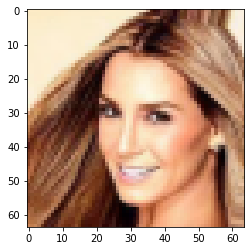

In [17]:
plt.imshow(img)

In [18]:
#with tf.Session() as sess:
#    op = sess.graph.get_operations()
#    for m in op:
#        print( m.values() )

Functions for training and evaluations.

In [19]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [20]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            
            batch = [ get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files ]
            batch_images = np.array(batch).astype(np.float32)
            
            batch_real_labels = np.random.uniform(.7, 1.2, [BATCH_SIZE, 1]).astype(np.float32)            
            batch_fake_labels = np.random.uniform(0., .3, [BATCH_SIZE, 1]).astype(np.float32)
            
            label_flip_choices = np.random.uniform(0., 1., BATCH_SIZE)
            for label_i in range(BATCH_SIZE):
                if label_flip_choices[label_i] < FLIP_LABEL_PROB:
                    batch_real_labels[label_i], batch_fake_labels[label_i] = batch_fake_labels[label_i], batch_real_labels[label_i]
                        
            #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)

            # Update D network
            #sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})
            sess.run(d_real_optim, feed_dict={ images: batch_images, real_labels: batch_real_labels, is_training: True})
            sess.run(d_fake_optim, feed_dict={ z: batch_z, fake_labels: batch_fake_labels, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
                batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)
                sess.run(g_optim, feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, fake_labels: batch_fake_labels, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, real_labels: batch_real_labels, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess,
                           os.path.join(save_dir, '{}_{:02d}_{:04d}'.format(model_name, epoch, idx)))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                print(samples.shape)
                save_images(samples[:25], None, os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)) )
                print("Sample")

In [ ]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint', n_epochs=100, sample_frequency=100, n_generator_update=2, max_to_keep=20)

Epoch: [ 0] [   0/3165] time: 6.0216, d_loss: 64.16538239, g_loss: 27.24776459
Epoch: [ 0] [   1/3165] time: 7.3056, d_loss: 73.31715393, g_loss: 24.05423546
Epoch: [ 0] [   2/3165] time: 8.5856, d_loss: 72.25742340, g_loss: 36.78853989
Epoch: [ 0] [   3/3165] time: 9.8696, d_loss: 82.63067627, g_loss: 33.60554886
Epoch: [ 0] [   4/3165] time: 11.1486, d_loss: 55.68937683, g_loss: 31.72817230
Epoch: [ 0] [   5/3165] time: 12.4285, d_loss: 74.18917847, g_loss: 30.72331238
Epoch: [ 0] [   6/3165] time: 13.7105, d_loss: 54.24026108, g_loss: 22.63794327
Epoch: [ 0] [   7/3165] time: 14.9912, d_loss: 84.08746338, g_loss: 31.29685211
Epoch: [ 0] [   8/3165] time: 16.2712, d_loss: 50.48789978, g_loss: 35.30888367
Epoch: [ 0] [   9/3165] time: 17.5512, d_loss: 79.64669800, g_loss: 25.54180145
Epoch: [ 0] [  10/3165] time: 18.8331, d_loss: 65.96152496, g_loss: 24.27561378
Epoch: [ 0] [  11/3165] time: 20.1118, d_loss: 52.76624298, g_loss: 33.28456116
Epoch: [ 0] [  12/3165] time: 21.3933, d_los

Epoch: [ 0] [ 102/3165] time: 167.6854, d_loss: 29.89427567, g_loss: 9.04275227
Epoch: [ 0] [ 103/3165] time: 169.2162, d_loss: 27.40913200, g_loss: 12.41642189
Epoch: [ 0] [ 104/3165] time: 170.7469, d_loss: 29.76711655, g_loss: 10.16441345
Epoch: [ 0] [ 105/3165] time: 172.2766, d_loss: 20.48487663, g_loss: 15.54615211
Epoch: [ 0] [ 106/3165] time: 173.8073, d_loss: 30.84230804, g_loss: 11.71639442
Epoch: [ 0] [ 107/3165] time: 175.3340, d_loss: 24.55995941, g_loss: 7.62400961
Epoch: [ 0] [ 108/3165] time: 176.8653, d_loss: 28.16903877, g_loss: 10.75849152
Epoch: [ 0] [ 109/3165] time: 178.3935, d_loss: 30.88202667, g_loss: 11.52564144
Epoch: [ 0] [ 110/3165] time: 179.9241, d_loss: 28.03772354, g_loss: 13.01272106
Epoch: [ 0] [ 111/3165] time: 181.4501, d_loss: 34.93665314, g_loss: 12.01841354
Epoch: [ 0] [ 112/3165] time: 182.9838, d_loss: 26.95003128, g_loss: 9.03778839
Epoch: [ 0] [ 113/3165] time: 184.5099, d_loss: 28.40939331, g_loss: 14.90757751
Epoch: [ 0] [ 114/3165] time: 1

Epoch: [ 0] [ 204/3165] time: 333.6500, d_loss: 16.42284966, g_loss: 4.64677620
Epoch: [ 0] [ 205/3165] time: 335.1815, d_loss: 22.95170212, g_loss: 4.59866524
Epoch: [ 0] [ 206/3165] time: 336.7125, d_loss: 20.87588501, g_loss: 5.95289040
Epoch: [ 0] [ 207/3165] time: 338.2400, d_loss: 19.80192184, g_loss: 5.38476849
Epoch: [ 0] [ 208/3165] time: 339.7730, d_loss: 18.75799561, g_loss: 6.40335846
Epoch: [ 0] [ 209/3165] time: 341.2930, d_loss: 21.88582230, g_loss: 3.79648232
Epoch: [ 0] [ 210/3165] time: 342.8264, d_loss: 20.03166580, g_loss: 5.66357470
Epoch: [ 0] [ 211/3165] time: 344.3532, d_loss: 28.01227951, g_loss: 5.44041777
Epoch: [ 0] [ 212/3165] time: 345.8896, d_loss: 22.36131859, g_loss: 5.04326296
Epoch: [ 0] [ 213/3165] time: 347.4206, d_loss: 22.19443893, g_loss: 5.58887959
Epoch: [ 0] [ 214/3165] time: 348.9507, d_loss: 19.08976364, g_loss: 5.31803417
Epoch: [ 0] [ 215/3165] time: 350.4747, d_loss: 19.58898163, g_loss: 6.04302359
Epoch: [ 0] [ 216/3165] time: 352.0097, 

Epoch: [ 0] [ 306/3165] time: 500.2787, d_loss: 11.18178272, g_loss: 3.25443506
Epoch: [ 0] [ 307/3165] time: 501.8167, d_loss: 11.54483032, g_loss: 2.63927269
Epoch: [ 0] [ 308/3165] time: 503.3557, d_loss: 11.34431267, g_loss: 4.30477238
Epoch: [ 0] [ 309/3165] time: 504.9027, d_loss: 13.27381802, g_loss: 3.46358466
Epoch: [ 0] [ 310/3165] time: 506.4456, d_loss: 11.25621128, g_loss: 3.03725433
Epoch: [ 0] [ 311/3165] time: 507.9836, d_loss: 11.03815174, g_loss: 2.35727072
Epoch: [ 0] [ 312/3165] time: 509.5236, d_loss: 16.88555908, g_loss: 3.39311481
Epoch: [ 0] [ 313/3165] time: 511.0666, d_loss: 12.82036304, g_loss: 2.70450735
Epoch: [ 0] [ 314/3165] time: 512.6095, d_loss: 17.07537079, g_loss: 2.07945776
Epoch: [ 0] [ 315/3165] time: 514.1465, d_loss: 12.29821205, g_loss: 3.37696624
Epoch: [ 0] [ 316/3165] time: 515.6855, d_loss: 12.94983864, g_loss: 2.91996551
Epoch: [ 0] [ 317/3165] time: 517.2255, d_loss: 15.04611778, g_loss: 3.46208191
Epoch: [ 0] [ 318/3165] time: 518.7695, 

Epoch: [ 0] [ 409/3165] time: 668.7266, d_loss: 11.57116890, g_loss: 1.95131373
Epoch: [ 0] [ 410/3165] time: 670.2676, d_loss: 10.33702087, g_loss: 1.70934284
Epoch: [ 0] [ 411/3165] time: 671.8106, d_loss: 9.58639526, g_loss: 1.93961906
Epoch: [ 0] [ 412/3165] time: 673.3485, d_loss: 11.26989651, g_loss: 1.93723810
Epoch: [ 0] [ 413/3165] time: 674.8925, d_loss: 12.62294197, g_loss: 2.20599794
Epoch: [ 0] [ 414/3165] time: 676.4305, d_loss: 11.90710258, g_loss: 1.51983774
Epoch: [ 0] [ 415/3165] time: 677.9704, d_loss: 7.80650854, g_loss: 1.45614791
Epoch: [ 0] [ 416/3165] time: 679.5084, d_loss: 10.22182083, g_loss: 2.01716375
Epoch: [ 0] [ 417/3165] time: 681.0534, d_loss: 11.96293640, g_loss: 1.91055930
Epoch: [ 0] [ 418/3165] time: 682.5964, d_loss: 11.80290794, g_loss: 1.61113930
Epoch: [ 0] [ 419/3165] time: 684.1343, d_loss: 7.90733528, g_loss: 2.01427531
Epoch: [ 0] [ 420/3165] time: 685.6733, d_loss: 9.64227867, g_loss: 2.58903265
Epoch: [ 0] [ 421/3165] time: 687.2203, d_lo

Epoch: [ 0] [ 512/3165] time: 837.1569, d_loss: 7.62759066, g_loss: 0.81674993
Epoch: [ 0] [ 513/3165] time: 838.7019, d_loss: 6.03044701, g_loss: 1.34836435
Epoch: [ 0] [ 514/3165] time: 840.2399, d_loss: 8.03714561, g_loss: 1.25220203
Epoch: [ 0] [ 515/3165] time: 841.7809, d_loss: 7.71248198, g_loss: 1.07624340
Epoch: [ 0] [ 516/3165] time: 843.3208, d_loss: 10.71943855, g_loss: 1.14803171
Epoch: [ 0] [ 517/3165] time: 844.8658, d_loss: 8.76318264, g_loss: 1.26774478
Epoch: [ 0] [ 518/3165] time: 846.4078, d_loss: 8.77406025, g_loss: 0.70687717
Epoch: [ 0] [ 519/3165] time: 847.9588, d_loss: 8.01725864, g_loss: 1.51722753
Epoch: [ 0] [ 520/3165] time: 849.4987, d_loss: 9.21865273, g_loss: 1.32208705
Epoch: [ 0] [ 521/3165] time: 851.0397, d_loss: 11.10298824, g_loss: 1.16970611
Epoch: [ 0] [ 522/3165] time: 852.5817, d_loss: 7.51287794, g_loss: 0.83962405
Epoch: [ 0] [ 523/3165] time: 854.1277, d_loss: 7.77864838, g_loss: 2.10679936
Epoch: [ 0] [ 524/3165] time: 855.6776, d_loss: 6.

Epoch: [ 0] [ 616/3165] time: 1006.9858, d_loss: 7.02501106, g_loss: 1.16383874
Epoch: [ 0] [ 617/3165] time: 1008.5287, d_loss: 7.44519997, g_loss: 0.84747320
Epoch: [ 0] [ 618/3165] time: 1010.0697, d_loss: 5.22231483, g_loss: 0.49274051
Epoch: [ 0] [ 619/3165] time: 1011.6117, d_loss: 7.76432514, g_loss: 1.80060172
Epoch: [ 0] [ 620/3165] time: 1013.1597, d_loss: 6.68499470, g_loss: 1.56152022
Epoch: [ 0] [ 621/3165] time: 1014.6996, d_loss: 6.18647861, g_loss: 0.66667724
Epoch: [ 0] [ 622/3165] time: 1016.2356, d_loss: 5.22898483, g_loss: 1.20244265
Epoch: [ 0] [ 623/3165] time: 1017.7776, d_loss: 8.46423149, g_loss: 1.41111493
Epoch: [ 0] [ 624/3165] time: 1019.3205, d_loss: 7.80718184, g_loss: 0.86104822
Epoch: [ 0] [ 625/3165] time: 1020.8645, d_loss: 5.51484537, g_loss: 1.25963485
Epoch: [ 0] [ 626/3165] time: 1022.4035, d_loss: 7.70568514, g_loss: 0.99073422
Epoch: [ 0] [ 627/3165] time: 1023.9465, d_loss: 7.04520750, g_loss: 1.21382034
Epoch: [ 0] [ 628/3165] time: 1025.4885,

Epoch: [ 0] [ 718/3165] time: 1172.9671, d_loss: 5.17529488, g_loss: 0.97731727
Epoch: [ 0] [ 719/3165] time: 1174.4940, d_loss: 6.11585951, g_loss: 1.08558893
Epoch: [ 0] [ 720/3165] time: 1176.0231, d_loss: 6.52092648, g_loss: 1.25221729
Epoch: [ 0] [ 721/3165] time: 1177.5530, d_loss: 5.26087999, g_loss: 0.85350686
Epoch: [ 0] [ 722/3165] time: 1179.0801, d_loss: 6.11280632, g_loss: 1.05284452
Epoch: [ 0] [ 723/3165] time: 1180.6050, d_loss: 6.40773916, g_loss: 0.76244748
Epoch: [ 0] [ 724/3165] time: 1182.1270, d_loss: 6.12633419, g_loss: 1.05076313
Epoch: [ 0] [ 725/3165] time: 1183.6579, d_loss: 4.61974573, g_loss: 0.76618659
Epoch: [ 0] [ 726/3165] time: 1185.1853, d_loss: 5.66663837, g_loss: 0.99872851
Epoch: [ 0] [ 727/3165] time: 1186.7192, d_loss: 5.98577118, g_loss: 0.51140922
Epoch: [ 0] [ 728/3165] time: 1188.2445, d_loss: 5.50459671, g_loss: 0.72442108
Epoch: [ 0] [ 729/3165] time: 1189.7755, d_loss: 4.71047306, g_loss: 0.89351696
Epoch: [ 0] [ 730/3165] time: 1191.3015,

Epoch: [ 0] [ 820/3165] time: 1338.8183, d_loss: 5.46743536, g_loss: 0.67181778
Epoch: [ 0] [ 821/3165] time: 1340.3508, d_loss: 6.11931133, g_loss: 0.84998107
Epoch: [ 0] [ 822/3165] time: 1341.8879, d_loss: 4.57958269, g_loss: 0.81554520
Epoch: [ 0] [ 823/3165] time: 1343.4217, d_loss: 4.24309158, g_loss: 0.64969379
Epoch: [ 0] [ 824/3165] time: 1344.9608, d_loss: 3.64697075, g_loss: 0.65003860
Epoch: [ 0] [ 825/3165] time: 1346.4964, d_loss: 6.07465267, g_loss: 0.88214070
Epoch: [ 0] [ 826/3165] time: 1348.0353, d_loss: 5.10292673, g_loss: 0.79961300
Epoch: [ 0] [ 827/3165] time: 1349.5719, d_loss: 5.01307058, g_loss: 1.17197561
Epoch: [ 0] [ 828/3165] time: 1351.1028, d_loss: 5.38074780, g_loss: 0.73069167
Epoch: [ 0] [ 829/3165] time: 1352.6410, d_loss: 5.75929594, g_loss: 0.75444448
Epoch: [ 0] [ 830/3165] time: 1354.1750, d_loss: 5.19948196, g_loss: 0.91989422
Epoch: [ 0] [ 831/3165] time: 1355.7112, d_loss: 5.51186800, g_loss: 0.95026946
Epoch: [ 0] [ 832/3165] time: 1357.2443,

Epoch: [ 0] [ 922/3165] time: 1505.1750, d_loss: 6.58962822, g_loss: 0.99108160
Epoch: [ 0] [ 923/3165] time: 1506.7108, d_loss: 4.57968330, g_loss: 0.69896638
Epoch: [ 0] [ 924/3165] time: 1508.2452, d_loss: 4.69019365, g_loss: 0.64449435
Epoch: [ 0] [ 925/3165] time: 1509.7815, d_loss: 3.49997139, g_loss: 1.04701781
Epoch: [ 0] [ 926/3165] time: 1511.3175, d_loss: 4.20721531, g_loss: 1.15659654
Epoch: [ 0] [ 927/3165] time: 1512.8541, d_loss: 5.08004951, g_loss: 1.08544493
Epoch: [ 0] [ 928/3165] time: 1514.3904, d_loss: 4.30484676, g_loss: 0.93495756
Epoch: [ 0] [ 929/3165] time: 1515.9284, d_loss: 3.82493472, g_loss: 0.73461515
Epoch: [ 0] [ 930/3165] time: 1517.4636, d_loss: 3.90536094, g_loss: 1.01261497
Epoch: [ 0] [ 931/3165] time: 1519.0016, d_loss: 4.03407478, g_loss: 0.91513586
Epoch: [ 0] [ 932/3165] time: 1520.5379, d_loss: 5.77459908, g_loss: 0.94417745
Epoch: [ 0] [ 933/3165] time: 1522.0751, d_loss: 4.76128674, g_loss: 0.85248649
Epoch: [ 0] [ 934/3165] time: 1523.6471,

Epoch: [ 0] [1024/3165] time: 1665.6438, d_loss: 3.93183756, g_loss: 0.77342230
Epoch: [ 0] [1025/3165] time: 1666.9547, d_loss: 5.48347616, g_loss: 0.56022382
Epoch: [ 0] [1026/3165] time: 1668.2567, d_loss: 4.29156256, g_loss: 0.77351624
Epoch: [ 0] [1027/3165] time: 1669.5666, d_loss: 3.58115125, g_loss: 0.87457514
Epoch: [ 0] [1028/3165] time: 1670.8906, d_loss: 4.13752508, g_loss: 0.85927421
Epoch: [ 0] [1029/3165] time: 1672.2105, d_loss: 3.89815426, g_loss: 0.86861169
Epoch: [ 0] [1030/3165] time: 1673.5185, d_loss: 4.09976673, g_loss: 0.93492913
Epoch: [ 0] [1031/3165] time: 1674.8282, d_loss: 3.28932810, g_loss: 1.08191109
Epoch: [ 0] [1032/3165] time: 1676.1501, d_loss: 4.75853062, g_loss: 0.68115985
Epoch: [ 0] [1033/3165] time: 1677.4682, d_loss: 4.82906628, g_loss: 0.77412903
Epoch: [ 0] [1034/3165] time: 1678.7902, d_loss: 4.23651791, g_loss: 0.97252929
Epoch: [ 0] [1035/3165] time: 1680.1091, d_loss: 3.79669666, g_loss: 0.72600031
Epoch: [ 0] [1036/3165] time: 1681.4231,

Epoch: [ 0] [1126/3165] time: 1807.7901, d_loss: 4.29297924, g_loss: 0.66191351
Epoch: [ 0] [1127/3165] time: 1809.0871, d_loss: 4.16058731, g_loss: 0.87300855
Epoch: [ 0] [1128/3165] time: 1810.3829, d_loss: 3.24402022, g_loss: 0.65976393
Epoch: [ 0] [1129/3165] time: 1811.6789, d_loss: 3.64170384, g_loss: 0.71674001
Epoch: [ 0] [1130/3165] time: 1812.9748, d_loss: 3.68777657, g_loss: 0.79405057
Epoch: [ 0] [1131/3165] time: 1814.2708, d_loss: 4.30801868, g_loss: 0.77854854
Epoch: [ 0] [1132/3165] time: 1815.5687, d_loss: 3.53989458, g_loss: 0.98870933
Epoch: [ 0] [1133/3165] time: 1816.8647, d_loss: 3.93967819, g_loss: 0.77055132
Epoch: [ 0] [1134/3165] time: 1818.1615, d_loss: 3.17354250, g_loss: 0.82588339
Epoch: [ 0] [1135/3165] time: 1819.4582, d_loss: 3.24904919, g_loss: 0.82348919
Epoch: [ 0] [1136/3165] time: 1820.7553, d_loss: 4.17013454, g_loss: 0.68104649
Epoch: [ 0] [1137/3165] time: 1822.0513, d_loss: 4.30777025, g_loss: 0.76662529
Epoch: [ 0] [1138/3165] time: 1823.3485,

Epoch: [ 0] [1228/3165] time: 1950.1529, d_loss: 3.86963701, g_loss: 0.68597138
Epoch: [ 0] [1229/3165] time: 1951.4549, d_loss: 3.26369977, g_loss: 0.72627008
Epoch: [ 0] [1230/3165] time: 1952.7599, d_loss: 4.45690250, g_loss: 1.11670637
Epoch: [ 0] [1231/3165] time: 1954.0628, d_loss: 3.74071074, g_loss: 0.57236171
Epoch: [ 0] [1232/3165] time: 1955.3677, d_loss: 3.79546642, g_loss: 1.04421341
Epoch: [ 0] [1233/3165] time: 1956.6717, d_loss: 4.03609228, g_loss: 1.11447191
Epoch: [ 0] [1234/3165] time: 1957.9777, d_loss: 4.34919930, g_loss: 1.00536227
Epoch: [ 0] [1235/3165] time: 1959.2816, d_loss: 2.99413919, g_loss: 0.82675338
Epoch: [ 0] [1236/3165] time: 1960.5896, d_loss: 4.51741171, g_loss: 0.72942376
Epoch: [ 0] [1237/3165] time: 1961.8935, d_loss: 3.82902265, g_loss: 0.82237589
Epoch: [ 0] [1238/3165] time: 1963.2015, d_loss: 4.93757582, g_loss: 0.70419610
Epoch: [ 0] [1239/3165] time: 1964.5074, d_loss: 3.33682489, g_loss: 0.87090099
Epoch: [ 0] [1240/3165] time: 1965.8124,

Epoch: [ 0] [1330/3165] time: 2092.5238, d_loss: 4.92277193, g_loss: 0.74037325
Epoch: [ 0] [1331/3165] time: 2093.8278, d_loss: 3.66996288, g_loss: 0.64316845
Epoch: [ 0] [1332/3165] time: 2095.1287, d_loss: 3.08827209, g_loss: 0.98067296
Epoch: [ 0] [1333/3165] time: 2096.4307, d_loss: 3.77357936, g_loss: 0.84611952
Epoch: [ 0] [1334/3165] time: 2097.7306, d_loss: 3.58842421, g_loss: 0.93010187
Epoch: [ 0] [1335/3165] time: 2099.0306, d_loss: 3.86384583, g_loss: 0.90058416
Epoch: [ 0] [1336/3165] time: 2100.3315, d_loss: 3.90009046, g_loss: 0.70899820
Epoch: [ 0] [1337/3165] time: 2101.6315, d_loss: 4.92054129, g_loss: 0.59146369
Epoch: [ 0] [1338/3165] time: 2102.9315, d_loss: 2.63950896, g_loss: 1.01875520
Epoch: [ 0] [1339/3165] time: 2104.2324, d_loss: 3.56631422, g_loss: 0.92417288
Epoch: [ 0] [1340/3165] time: 2105.5373, d_loss: 5.01327848, g_loss: 0.79815733
Epoch: [ 0] [1341/3165] time: 2106.8373, d_loss: 3.84003830, g_loss: 1.10447133
Epoch: [ 0] [1342/3165] time: 2108.1403,

Epoch: [ 0] [1432/3165] time: 2234.8537, d_loss: 2.94393682, g_loss: 0.99514639
Epoch: [ 0] [1433/3165] time: 2236.1537, d_loss: 4.22041512, g_loss: 1.25177264
Epoch: [ 0] [1434/3165] time: 2237.4586, d_loss: 3.99690151, g_loss: 1.08666396
Epoch: [ 0] [1435/3165] time: 2238.7626, d_loss: 4.39590549, g_loss: 0.81190974
Epoch: [ 0] [1436/3165] time: 2240.0665, d_loss: 2.77504826, g_loss: 0.85342366
Epoch: [ 0] [1437/3165] time: 2241.3675, d_loss: 3.66074014, g_loss: 1.10862792
Epoch: [ 0] [1438/3165] time: 2242.6724, d_loss: 3.18089104, g_loss: 1.03170311
Epoch: [ 0] [1439/3165] time: 2243.9744, d_loss: 3.95444536, g_loss: 0.93239367
Epoch: [ 0] [1440/3165] time: 2245.2764, d_loss: 3.75729132, g_loss: 1.06669474
Epoch: [ 0] [1441/3165] time: 2246.5823, d_loss: 4.35595608, g_loss: 0.73604923
Epoch: [ 0] [1442/3165] time: 2247.8873, d_loss: 4.53145218, g_loss: 1.33628964
Epoch: [ 0] [1443/3165] time: 2249.1932, d_loss: 3.92223835, g_loss: 0.78809607
Epoch: [ 0] [1444/3165] time: 2250.4982,

Epoch: [ 0] [1534/3165] time: 2386.0724, d_loss: 3.75972152, g_loss: 1.25901127
Epoch: [ 0] [1535/3165] time: 2387.6343, d_loss: 3.52917790, g_loss: 1.01279068
Epoch: [ 0] [1536/3165] time: 2389.1893, d_loss: 4.80474758, g_loss: 1.04209089
Epoch: [ 0] [1537/3165] time: 2390.7562, d_loss: 4.05242062, g_loss: 0.97887683
Epoch: [ 0] [1538/3165] time: 2392.3172, d_loss: 4.64775038, g_loss: 1.09443820
Epoch: [ 0] [1539/3165] time: 2393.8811, d_loss: 3.53144503, g_loss: 1.11057377
Epoch: [ 0] [1540/3165] time: 2395.4421, d_loss: 2.96834445, g_loss: 0.96256161
Epoch: [ 0] [1541/3165] time: 2397.0050, d_loss: 3.40280104, g_loss: 1.11804616
Epoch: [ 0] [1542/3165] time: 2398.5700, d_loss: 3.81829739, g_loss: 0.93036342
Epoch: [ 0] [1543/3165] time: 2400.1299, d_loss: 4.47496891, g_loss: 0.98046046
Epoch: [ 0] [1544/3165] time: 2401.6978, d_loss: 3.80635428, g_loss: 1.20170808
Epoch: [ 0] [1545/3165] time: 2403.2588, d_loss: 4.96587944, g_loss: 1.24403346
Epoch: [ 0] [1546/3165] time: 2404.8227,

Epoch: [ 0] [1636/3165] time: 2554.8555, d_loss: 4.09799957, g_loss: 1.19669175
Epoch: [ 0] [1637/3165] time: 2556.4124, d_loss: 5.14405441, g_loss: 1.05171514
Epoch: [ 0] [1638/3165] time: 2557.9744, d_loss: 5.36427212, g_loss: 0.79994369
Epoch: [ 0] [1639/3165] time: 2559.5343, d_loss: 4.06221104, g_loss: 1.41330934
Epoch: [ 0] [1640/3165] time: 2561.0902, d_loss: 3.56863117, g_loss: 1.01011014
Epoch: [ 0] [1641/3165] time: 2562.6442, d_loss: 3.51205301, g_loss: 0.91752994
Epoch: [ 0] [1642/3165] time: 2564.2012, d_loss: 4.96591091, g_loss: 0.96427119
Epoch: [ 0] [1643/3165] time: 2565.7571, d_loss: 3.86252308, g_loss: 1.00757146
Epoch: [ 0] [1644/3165] time: 2567.3130, d_loss: 3.66240358, g_loss: 1.18896532
Epoch: [ 0] [1645/3165] time: 2568.8680, d_loss: 3.45311642, g_loss: 1.20374084
Epoch: [ 0] [1646/3165] time: 2570.4219, d_loss: 5.17509460, g_loss: 1.06888020
Epoch: [ 0] [1647/3165] time: 2571.9789, d_loss: 4.46450996, g_loss: 1.17870784
Epoch: [ 0] [1648/3165] time: 2573.5378,

Epoch: [ 0] [1738/3165] time: 2723.0697, d_loss: 3.62426162, g_loss: 1.26047599
Epoch: [ 0] [1739/3165] time: 2724.6266, d_loss: 4.05170345, g_loss: 1.13838625
Epoch: [ 0] [1740/3165] time: 2726.1796, d_loss: 3.39544201, g_loss: 1.55256689
Epoch: [ 0] [1741/3165] time: 2727.7365, d_loss: 4.22610378, g_loss: 1.08517861
Epoch: [ 0] [1742/3165] time: 2729.2915, d_loss: 4.52295685, g_loss: 1.19660342
Epoch: [ 0] [1743/3165] time: 2730.8474, d_loss: 4.01262188, g_loss: 0.89081407
Epoch: [ 0] [1744/3165] time: 2732.4043, d_loss: 4.08997345, g_loss: 1.27282405
Epoch: [ 0] [1745/3165] time: 2733.9623, d_loss: 3.18915081, g_loss: 0.96042895
Epoch: [ 0] [1746/3165] time: 2735.5262, d_loss: 4.65319252, g_loss: 1.18753242
Epoch: [ 0] [1747/3165] time: 2737.0812, d_loss: 2.92446852, g_loss: 1.08681393
Epoch: [ 0] [1748/3165] time: 2738.6381, d_loss: 3.09892368, g_loss: 0.99146688
Epoch: [ 0] [1749/3165] time: 2740.1931, d_loss: 4.16074896, g_loss: 0.95558918
Epoch: [ 0] [1750/3165] time: 2741.7520,

Epoch: [ 0] [1840/3165] time: 2891.2209, d_loss: 4.18553972, g_loss: 1.12590647
Epoch: [ 0] [1841/3165] time: 2892.7828, d_loss: 4.21149111, g_loss: 1.26978397
Epoch: [ 0] [1842/3165] time: 2894.3418, d_loss: 4.07973051, g_loss: 1.13763762
Epoch: [ 0] [1843/3165] time: 2895.9047, d_loss: 4.12593889, g_loss: 1.69689298
Epoch: [ 0] [1844/3165] time: 2897.4667, d_loss: 3.29004145, g_loss: 1.20771646
Epoch: [ 0] [1845/3165] time: 2899.0236, d_loss: 4.38474512, g_loss: 1.44271469
Epoch: [ 0] [1846/3165] time: 2900.5836, d_loss: 3.74012613, g_loss: 1.53937411
Epoch: [ 0] [1847/3165] time: 2902.1465, d_loss: 3.29005432, g_loss: 1.16709590
Epoch: [ 0] [1848/3165] time: 2903.7045, d_loss: 3.96792078, g_loss: 1.20933819
Epoch: [ 0] [1849/3165] time: 2905.2624, d_loss: 3.21536994, g_loss: 1.56344104
Epoch: [ 0] [1850/3165] time: 2906.8204, d_loss: 3.98856878, g_loss: 1.40966439
Epoch: [ 0] [1851/3165] time: 2908.3803, d_loss: 3.65721703, g_loss: 1.36172569
Epoch: [ 0] [1852/3165] time: 2909.9362,

Epoch: [ 0] [1942/3165] time: 3059.4172, d_loss: 3.15277767, g_loss: 1.35382342
Epoch: [ 0] [1943/3165] time: 3060.9801, d_loss: 3.49533319, g_loss: 1.39097130
Epoch: [ 0] [1944/3165] time: 3062.5451, d_loss: 3.28257728, g_loss: 1.14247859
Epoch: [ 0] [1945/3165] time: 3064.1060, d_loss: 3.19969606, g_loss: 1.26213646
Epoch: [ 0] [1946/3165] time: 3065.6690, d_loss: 4.07427502, g_loss: 1.36019337
Epoch: [ 0] [1947/3165] time: 3067.2299, d_loss: 3.11793995, g_loss: 1.44247317
Epoch: [ 0] [1948/3165] time: 3068.7899, d_loss: 3.53530216, g_loss: 1.89254045
Epoch: [ 0] [1949/3165] time: 3070.3438, d_loss: 3.34161830, g_loss: 1.23021376
Epoch: [ 0] [1950/3165] time: 3071.9098, d_loss: 2.74999380, g_loss: 1.30760777
Epoch: [ 0] [1951/3165] time: 3073.4687, d_loss: 3.34484577, g_loss: 1.34467888
Epoch: [ 0] [1952/3165] time: 3075.0267, d_loss: 2.94841194, g_loss: 1.29053867
Epoch: [ 0] [1953/3165] time: 3076.5846, d_loss: 4.00182533, g_loss: 1.44496107
Epoch: [ 0] [1954/3165] time: 3078.1415,

Epoch: [ 0] [2044/3165] time: 3227.6695, d_loss: 3.90265656, g_loss: 1.58635664
Epoch: [ 0] [2045/3165] time: 3229.2325, d_loss: 3.74582958, g_loss: 1.86728597
Epoch: [ 0] [2046/3165] time: 3230.7964, d_loss: 3.97458196, g_loss: 1.36263037
Epoch: [ 0] [2047/3165] time: 3232.3584, d_loss: 3.65117645, g_loss: 1.46588695
Epoch: [ 0] [2048/3165] time: 3233.9153, d_loss: 4.18141174, g_loss: 1.47314334
Epoch: [ 0] [2049/3165] time: 3235.4813, d_loss: 2.77834201, g_loss: 1.85002160
Epoch: [ 0] [2050/3165] time: 3237.0432, d_loss: 3.27153444, g_loss: 1.56770492
Epoch: [ 0] [2051/3165] time: 3238.6081, d_loss: 3.09760523, g_loss: 1.23499060
Epoch: [ 0] [2052/3165] time: 3240.1691, d_loss: 3.47934318, g_loss: 1.47055113
Epoch: [ 0] [2053/3165] time: 3241.7250, d_loss: 3.46438265, g_loss: 1.87204480
Epoch: [ 0] [2054/3165] time: 3243.2780, d_loss: 3.88058376, g_loss: 1.54737043
Epoch: [ 0] [2055/3165] time: 3244.8339, d_loss: 4.54039192, g_loss: 1.88389516
Epoch: [ 0] [2056/3165] time: 3246.3899,

Epoch: [ 0] [2142/3165] time: 3389.8731, d_loss: 3.27664328, g_loss: 1.55313385
Epoch: [ 0] [2143/3165] time: 3391.4351, d_loss: 3.51842880, g_loss: 1.75312018
Epoch: [ 0] [2144/3165] time: 3392.9950, d_loss: 3.49270010, g_loss: 2.17460728
Epoch: [ 0] [2145/3165] time: 3394.5550, d_loss: 3.28158092, g_loss: 1.93911076
Epoch: [ 0] [2146/3165] time: 3396.1100, d_loss: 3.90852070, g_loss: 1.58188844
Epoch: [ 0] [2147/3165] time: 3397.6699, d_loss: 3.94284296, g_loss: 1.44457161
Epoch: [ 0] [2148/3165] time: 3399.2258, d_loss: 4.66947746, g_loss: 1.44045854
Epoch: [ 0] [2149/3165] time: 3400.8108, d_loss: 4.27081919, g_loss: 1.43996930
Epoch: [ 0] [2150/3165] time: 3402.3677, d_loss: 3.31664014, g_loss: 1.55805409
Epoch: [ 0] [2151/3165] time: 3403.9227, d_loss: 4.33604860, g_loss: 2.18700218
Epoch: [ 0] [2152/3165] time: 3405.4826, d_loss: 3.69511557, g_loss: 1.65584230
Epoch: [ 0] [2153/3165] time: 3407.0396, d_loss: 3.68257427, g_loss: 1.69170642
Epoch: [ 0] [2154/3165] time: 3408.6005,

Epoch: [ 0] [2244/3165] time: 3558.7576, d_loss: 2.99806595, g_loss: 1.59085941
Epoch: [ 0] [2245/3165] time: 3560.3155, d_loss: 2.89943790, g_loss: 1.40528858
Epoch: [ 0] [2246/3165] time: 3561.8765, d_loss: 2.88118267, g_loss: 1.73458934
Epoch: [ 0] [2247/3165] time: 3563.4384, d_loss: 3.95144558, g_loss: 1.39010715
Epoch: [ 0] [2248/3165] time: 3564.9994, d_loss: 3.68912053, g_loss: 1.33682275
Epoch: [ 0] [2249/3165] time: 3566.5593, d_loss: 2.91843271, g_loss: 1.53263772
Epoch: [ 0] [2250/3165] time: 3568.1203, d_loss: 3.05496645, g_loss: 1.33840823
Epoch: [ 0] [2251/3165] time: 3569.6963, d_loss: 3.16135383, g_loss: 1.61924911
Epoch: [ 0] [2252/3165] time: 3571.2572, d_loss: 3.40533781, g_loss: 1.79971671
Epoch: [ 0] [2253/3165] time: 3572.8172, d_loss: 4.04419661, g_loss: 1.20850432
Epoch: [ 0] [2254/3165] time: 3574.3751, d_loss: 3.10156631, g_loss: 1.41102684
Epoch: [ 0] [2255/3165] time: 3575.9371, d_loss: 3.83227396, g_loss: 1.43736625
Epoch: [ 0] [2256/3165] time: 3577.5020,

Epoch: [ 0] [2346/3165] time: 3726.9531, d_loss: 3.75731254, g_loss: 1.44536853
Epoch: [ 0] [2347/3165] time: 3728.5111, d_loss: 3.77126551, g_loss: 1.02512836
Epoch: [ 0] [2348/3165] time: 3730.0650, d_loss: 3.20287228, g_loss: 1.09405804
Epoch: [ 0] [2349/3165] time: 3731.6230, d_loss: 3.35022855, g_loss: 1.73205292
Epoch: [ 0] [2350/3165] time: 3733.1779, d_loss: 3.36229610, g_loss: 1.70099115
Epoch: [ 0] [2351/3165] time: 3734.7369, d_loss: 2.72218418, g_loss: 1.67898405
Epoch: [ 0] [2352/3165] time: 3736.2938, d_loss: 3.16214275, g_loss: 1.50703454
Epoch: [ 0] [2353/3165] time: 3737.8518, d_loss: 3.50098658, g_loss: 1.56483865
Epoch: [ 0] [2354/3165] time: 3739.4097, d_loss: 4.27788162, g_loss: 1.49358821
Epoch: [ 0] [2355/3165] time: 3740.9667, d_loss: 3.24977779, g_loss: 1.54352021
Epoch: [ 0] [2356/3165] time: 3742.5246, d_loss: 2.60925531, g_loss: 1.39552069
Epoch: [ 0] [2357/3165] time: 3744.0796, d_loss: 3.35574293, g_loss: 1.36007202
Epoch: [ 0] [2358/3165] time: 3745.6395,

Epoch: [ 0] [2448/3165] time: 3895.8545, d_loss: 2.44103885, g_loss: 1.51878619
Epoch: [ 0] [2449/3165] time: 3897.4145, d_loss: 3.46108198, g_loss: 1.07721114
Epoch: [ 0] [2450/3165] time: 3898.9774, d_loss: 2.94787121, g_loss: 1.09475684
Epoch: [ 0] [2451/3165] time: 3900.5394, d_loss: 2.62129545, g_loss: 1.60659218
Epoch: [ 0] [2452/3165] time: 3902.1024, d_loss: 3.20990777, g_loss: 1.43144596
Epoch: [ 0] [2453/3165] time: 3903.6692, d_loss: 2.65530610, g_loss: 1.39723372
Epoch: [ 0] [2454/3165] time: 3905.2302, d_loss: 3.26683283, g_loss: 0.99463940
Epoch: [ 0] [2455/3165] time: 3906.8039, d_loss: 2.40689635, g_loss: 1.39237213
Epoch: [ 0] [2456/3165] time: 3908.3658, d_loss: 3.05573940, g_loss: 1.55535436
Epoch: [ 0] [2457/3165] time: 3909.9348, d_loss: 2.84792757, g_loss: 1.14905691
Epoch: [ 0] [2458/3165] time: 3911.4997, d_loss: 3.08847904, g_loss: 1.24648023
Epoch: [ 0] [2459/3165] time: 3913.0627, d_loss: 3.15784359, g_loss: 1.38378048
Epoch: [ 0] [2460/3165] time: 3914.6286,

Epoch: [ 0] [2550/3165] time: 4064.4041, d_loss: 2.93356037, g_loss: 1.17057657
Epoch: [ 0] [2551/3165] time: 4065.9731, d_loss: 2.53469086, g_loss: 1.31616390
Epoch: [ 0] [2552/3165] time: 4067.5390, d_loss: 2.72510767, g_loss: 1.28828323
Epoch: [ 0] [2553/3165] time: 4069.1020, d_loss: 2.86408663, g_loss: 0.94437701
Epoch: [ 0] [2554/3165] time: 4070.6679, d_loss: 2.67998528, g_loss: 1.17166281
Epoch: [ 0] [2555/3165] time: 4072.2309, d_loss: 2.20678949, g_loss: 0.98853874
Epoch: [ 0] [2556/3165] time: 4073.7938, d_loss: 2.67854977, g_loss: 1.11434603
Epoch: [ 0] [2557/3165] time: 4075.3558, d_loss: 3.18148041, g_loss: 1.32591701
Epoch: [ 0] [2558/3165] time: 4076.9214, d_loss: 2.55693793, g_loss: 1.41588759
Epoch: [ 0] [2559/3165] time: 4078.4844, d_loss: 2.50403404, g_loss: 1.64318573
Epoch: [ 0] [2560/3165] time: 4080.0473, d_loss: 2.39021826, g_loss: 1.12996852
Epoch: [ 0] [2561/3165] time: 4081.6103, d_loss: 2.82612085, g_loss: 1.55632401
Epoch: [ 0] [2562/3165] time: 4083.1692,

Epoch: [ 0] [2652/3165] time: 4233.4106, d_loss: 2.10829473, g_loss: 1.20550275
Epoch: [ 0] [2653/3165] time: 4234.9735, d_loss: 2.48894143, g_loss: 1.46000314
Epoch: [ 0] [2654/3165] time: 4236.5405, d_loss: 2.37251210, g_loss: 1.35946202
Epoch: [ 0] [2655/3165] time: 4238.1045, d_loss: 2.35393858, g_loss: 1.33360171
Epoch: [ 0] [2656/3165] time: 4239.6714, d_loss: 2.70863843, g_loss: 0.98046327
Epoch: [ 0] [2657/3165] time: 4241.2363, d_loss: 2.47521877, g_loss: 1.29498792
Epoch: [ 0] [2658/3165] time: 4242.8033, d_loss: 2.15778208, g_loss: 1.43077624
Epoch: [ 0] [2659/3165] time: 4244.3612, d_loss: 2.92641735, g_loss: 1.36315465
Epoch: [ 0] [2660/3165] time: 4245.9232, d_loss: 2.77770495, g_loss: 1.35959482
Epoch: [ 0] [2661/3165] time: 4247.4882, d_loss: 2.67352057, g_loss: 1.14232183
Epoch: [ 0] [2662/3165] time: 4249.0571, d_loss: 3.05185223, g_loss: 1.28945589
Epoch: [ 0] [2663/3165] time: 4250.6211, d_loss: 3.10605931, g_loss: 1.39204180
Epoch: [ 0] [2664/3165] time: 4252.1820,

Epoch: [ 0] [2754/3165] time: 4401.9912, d_loss: 2.94585180, g_loss: 1.14827251
Epoch: [ 0] [2755/3165] time: 4403.5502, d_loss: 2.60857868, g_loss: 1.19935381
Epoch: [ 0] [2756/3165] time: 4405.1101, d_loss: 2.30442381, g_loss: 1.01694465
Epoch: [ 0] [2757/3165] time: 4406.6746, d_loss: 2.43042779, g_loss: 1.12055945
Epoch: [ 0] [2758/3165] time: 4408.2415, d_loss: 2.58064985, g_loss: 1.07303500
Epoch: [ 0] [2759/3165] time: 4409.8165, d_loss: 2.82141972, g_loss: 1.05824852
Epoch: [ 0] [2760/3165] time: 4411.3734, d_loss: 2.29910803, g_loss: 1.00148392
Epoch: [ 0] [2761/3165] time: 4412.9364, d_loss: 2.62603283, g_loss: 1.10771978
Epoch: [ 0] [2762/3165] time: 4414.4954, d_loss: 2.32961416, g_loss: 1.03111792
Epoch: [ 0] [2763/3165] time: 4416.0603, d_loss: 2.03684235, g_loss: 1.20181036
Epoch: [ 0] [2764/3165] time: 4417.6213, d_loss: 3.06829000, g_loss: 1.27625954
Epoch: [ 0] [2765/3165] time: 4419.1802, d_loss: 2.46846056, g_loss: 1.08445954
Epoch: [ 0] [2766/3165] time: 4420.7509,

Epoch: [ 0] [2856/3165] time: 4570.6031, d_loss: 2.43646717, g_loss: 0.83064187
Epoch: [ 0] [2857/3165] time: 4572.1650, d_loss: 2.34898019, g_loss: 0.93078154
Epoch: [ 0] [2858/3165] time: 4573.7300, d_loss: 2.34155774, g_loss: 1.22321463
Epoch: [ 0] [2859/3165] time: 4575.2939, d_loss: 2.46099949, g_loss: 1.10752785
Epoch: [ 0] [2860/3165] time: 4576.8539, d_loss: 2.27744150, g_loss: 1.38332379
Epoch: [ 0] [2861/3165] time: 4578.4178, d_loss: 2.06346560, g_loss: 1.26418281
Epoch: [ 0] [2862/3165] time: 4579.9818, d_loss: 2.47928095, g_loss: 1.10726786
Epoch: [ 0] [2863/3165] time: 4581.5436, d_loss: 2.27259302, g_loss: 1.23512292
Epoch: [ 0] [2864/3165] time: 4583.1035, d_loss: 2.17548800, g_loss: 1.14096904
Epoch: [ 0] [2865/3165] time: 4584.6685, d_loss: 2.23434639, g_loss: 1.20538640
Epoch: [ 0] [2866/3165] time: 4586.2304, d_loss: 2.78675628, g_loss: 1.18035746
Epoch: [ 0] [2867/3165] time: 4587.7924, d_loss: 2.38339901, g_loss: 1.15601993
Epoch: [ 0] [2868/3165] time: 4589.3573,

Epoch: [ 0] [2958/3165] time: 4739.3348, d_loss: 2.19613981, g_loss: 0.97449005
Epoch: [ 0] [2959/3165] time: 4740.9017, d_loss: 2.10082698, g_loss: 1.15042949
Epoch: [ 0] [2960/3165] time: 4742.4650, d_loss: 2.00613642, g_loss: 1.09921455
Epoch: [ 0] [2961/3165] time: 4744.0260, d_loss: 2.08440185, g_loss: 1.08930087
Epoch: [ 0] [2962/3165] time: 4745.5939, d_loss: 1.76918042, g_loss: 1.08333075
Epoch: [ 0] [2963/3165] time: 4747.1549, d_loss: 1.79206920, g_loss: 1.24335766
Epoch: [ 0] [2964/3165] time: 4748.7239, d_loss: 1.97437608, g_loss: 1.15345693
Epoch: [ 0] [2965/3165] time: 4750.2898, d_loss: 2.37299585, g_loss: 0.93947792
Epoch: [ 0] [2966/3165] time: 4751.8548, d_loss: 2.39467859, g_loss: 1.02967882
Epoch: [ 0] [2967/3165] time: 4753.4227, d_loss: 2.34029913, g_loss: 0.99681807
Epoch: [ 0] [2968/3165] time: 4754.9877, d_loss: 1.77343953, g_loss: 1.14615250
Epoch: [ 0] [2969/3165] time: 4756.5546, d_loss: 2.06523728, g_loss: 0.73763371
Epoch: [ 0] [2970/3165] time: 4758.1206,

Epoch: [ 0] [3060/3165] time: 4908.3673, d_loss: 2.38440752, g_loss: 1.34074628
Epoch: [ 0] [3061/3165] time: 4909.9285, d_loss: 2.20742655, g_loss: 1.05332613
Epoch: [ 0] [3062/3165] time: 4911.4846, d_loss: 1.98700762, g_loss: 1.33846664
Epoch: [ 0] [3063/3165] time: 4913.0505, d_loss: 2.68162107, g_loss: 1.09331965
Epoch: [ 0] [3064/3165] time: 4914.6074, d_loss: 2.27281809, g_loss: 1.05780315
Epoch: [ 0] [3065/3165] time: 4916.1632, d_loss: 2.16148663, g_loss: 1.20981038
Epoch: [ 0] [3066/3165] time: 4917.7208, d_loss: 2.31802082, g_loss: 1.04115546
Epoch: [ 0] [3067/3165] time: 4919.2746, d_loss: 2.25918579, g_loss: 1.11556625
Epoch: [ 0] [3068/3165] time: 4920.8314, d_loss: 1.84874547, g_loss: 1.34591091
Epoch: [ 0] [3069/3165] time: 4922.3883, d_loss: 2.11357069, g_loss: 1.00521159
Epoch: [ 0] [3070/3165] time: 4923.9442, d_loss: 2.18839550, g_loss: 0.95608330
Epoch: [ 0] [3071/3165] time: 4925.5036, d_loss: 2.52203941, g_loss: 1.08609533
Epoch: [ 0] [3072/3165] time: 4927.0605,

Epoch: [ 0] [3162/3165] time: 5076.4569, d_loss: 2.17747784, g_loss: 1.03034937
Epoch: [ 0] [3163/3165] time: 5078.0319, d_loss: 2.10799336, g_loss: 0.90145719
Epoch: [ 0] [3164/3165] time: 5079.5988, d_loss: 2.01578927, g_loss: 1.10974860
Epoch: [ 1] [   0/3165] time: 5081.1648, d_loss: 2.12195110, g_loss: 0.87852281
Epoch: [ 1] [   1/3165] time: 5082.7298, d_loss: 2.33516788, g_loss: 0.99343550
Epoch: [ 1] [   2/3165] time: 5084.2947, d_loss: 2.25000286, g_loss: 0.89943373
Epoch: [ 1] [   3/3165] time: 5085.8597, d_loss: 2.41867709, g_loss: 0.99000233
Epoch: [ 1] [   4/3165] time: 5087.4246, d_loss: 2.12579298, g_loss: 0.97491777
Epoch: [ 1] [   5/3165] time: 5088.9926, d_loss: 1.89186668, g_loss: 0.95721352
Epoch: [ 1] [   6/3165] time: 5090.5555, d_loss: 1.79714715, g_loss: 0.94680762
Epoch: [ 1] [   7/3165] time: 5092.1165, d_loss: 1.81893754, g_loss: 1.07865679
Epoch: [ 1] [   8/3165] time: 5093.6834, d_loss: 2.16196299, g_loss: 0.94739920
Epoch: [ 1] [   9/3165] time: 5095.2484,

Epoch: [ 1] [  99/3165] time: 5245.1499, d_loss: 1.97580862, g_loss: 0.90162885
Epoch: [ 1] [ 100/3165] time: 5246.7129, d_loss: 1.77106321, g_loss: 0.98250920
Epoch: [ 1] [ 101/3165] time: 5248.2848, d_loss: 2.28978038, g_loss: 0.90511429
Epoch: [ 1] [ 102/3165] time: 5249.8548, d_loss: 1.89423132, g_loss: 1.00025022
Epoch: [ 1] [ 103/3165] time: 5251.4177, d_loss: 2.20214295, g_loss: 0.97486043
Epoch: [ 1] [ 104/3165] time: 5252.9827, d_loss: 2.06868315, g_loss: 0.88370007
Epoch: [ 1] [ 105/3165] time: 5254.5506, d_loss: 1.98009133, g_loss: 0.84979141
Epoch: [ 1] [ 106/3165] time: 5256.1136, d_loss: 2.08439159, g_loss: 1.08352697
Epoch: [ 1] [ 107/3165] time: 5257.6765, d_loss: 2.02158856, g_loss: 1.09426236
Epoch: [ 1] [ 108/3165] time: 5259.2395, d_loss: 2.23738384, g_loss: 1.05324674
Epoch: [ 1] [ 109/3165] time: 5260.8054, d_loss: 1.88515818, g_loss: 0.87979811
Epoch: [ 1] [ 110/3165] time: 5262.3684, d_loss: 1.90131056, g_loss: 0.90841651
Epoch: [ 1] [ 111/3165] time: 5263.9394,

Epoch: [ 1] [ 201/3165] time: 5413.9869, d_loss: 2.05496454, g_loss: 0.91808015
Epoch: [ 1] [ 202/3165] time: 5415.5539, d_loss: 2.28049660, g_loss: 0.85468233
Epoch: [ 1] [ 203/3165] time: 5417.1138, d_loss: 1.92941248, g_loss: 0.88218290
Epoch: [ 1] [ 204/3165] time: 5418.6758, d_loss: 1.87216651, g_loss: 0.88565648
Epoch: [ 1] [ 205/3165] time: 5420.2357, d_loss: 2.06496620, g_loss: 1.00680912
Epoch: [ 1] [ 206/3165] time: 5421.8007, d_loss: 1.80907607, g_loss: 0.92065716
Epoch: [ 1] [ 207/3165] time: 5423.3616, d_loss: 1.85930467, g_loss: 0.89279920
Epoch: [ 1] [ 208/3165] time: 5424.9226, d_loss: 1.80597281, g_loss: 0.83299100
Epoch: [ 1] [ 209/3165] time: 5426.4896, d_loss: 1.73455560, g_loss: 0.84484243
Epoch: [ 1] [ 210/3165] time: 5428.0535, d_loss: 1.70834637, g_loss: 0.77120054
Epoch: [ 1] [ 211/3165] time: 5429.6184, d_loss: 1.79150546, g_loss: 1.05978084
Epoch: [ 1] [ 212/3165] time: 5431.1834, d_loss: 1.66582274, g_loss: 0.97576749
Epoch: [ 1] [ 213/3165] time: 5432.7474,

Epoch: [ 1] [ 303/3165] time: 5582.7180, d_loss: 2.18967009, g_loss: 0.79095125
Epoch: [ 1] [ 304/3165] time: 5584.2839, d_loss: 2.13442469, g_loss: 0.89492667
Epoch: [ 1] [ 305/3165] time: 5585.8529, d_loss: 2.32544661, g_loss: 0.82990712
Epoch: [ 1] [ 306/3165] time: 5587.4148, d_loss: 1.94343936, g_loss: 0.93991101
Epoch: [ 1] [ 307/3165] time: 5588.9818, d_loss: 1.81181550, g_loss: 0.94264770
Epoch: [ 1] [ 308/3165] time: 5590.5467, d_loss: 1.80841196, g_loss: 0.94000709
Epoch: [ 1] [ 309/3165] time: 5592.1127, d_loss: 1.86731052, g_loss: 0.92499804
Epoch: [ 1] [ 310/3165] time: 5593.6766, d_loss: 2.08302236, g_loss: 0.98761749
Epoch: [ 1] [ 311/3165] time: 5595.2416, d_loss: 1.90516472, g_loss: 0.97457385
Epoch: [ 1] [ 312/3165] time: 5596.8076, d_loss: 2.05759859, g_loss: 0.95863795
Epoch: [ 1] [ 313/3165] time: 5598.3735, d_loss: 1.65034413, g_loss: 1.10801101
Epoch: [ 1] [ 314/3165] time: 5599.9415, d_loss: 1.86793721, g_loss: 0.99283135
Epoch: [ 1] [ 315/3165] time: 5601.5104,

Epoch: [ 1] [ 405/3165] time: 5751.6751, d_loss: 1.70428026, g_loss: 0.85199738
Epoch: [ 1] [ 406/3165] time: 5753.2500, d_loss: 2.19989944, g_loss: 0.99620545
Epoch: [ 1] [ 407/3165] time: 5754.8160, d_loss: 1.80493879, g_loss: 0.89287984
Epoch: [ 1] [ 408/3165] time: 5756.3819, d_loss: 1.69679165, g_loss: 1.08082891
Epoch: [ 1] [ 409/3165] time: 5757.9449, d_loss: 1.86250162, g_loss: 0.83985114
Epoch: [ 1] [ 410/3165] time: 5759.5128, d_loss: 1.92369699, g_loss: 0.97468114
Epoch: [ 1] [ 411/3165] time: 5761.0778, d_loss: 1.83439541, g_loss: 0.98618031
Epoch: [ 1] [ 412/3165] time: 5762.6427, d_loss: 1.81282794, g_loss: 0.96659899
Epoch: [ 1] [ 413/3165] time: 5764.2087, d_loss: 1.86480641, g_loss: 0.72707582
Epoch: [ 1] [ 414/3165] time: 5765.7766, d_loss: 1.93544078, g_loss: 1.07194793
Epoch: [ 1] [ 415/3165] time: 5767.3416, d_loss: 1.82966506, g_loss: 1.13256097
Epoch: [ 1] [ 416/3165] time: 5768.9036, d_loss: 1.96085703, g_loss: 0.90068239
Epoch: [ 1] [ 417/3165] time: 5770.4665,

Epoch: [ 1] [ 507/3165] time: 5920.1796, d_loss: 1.69541240, g_loss: 0.83477056
Epoch: [ 1] [ 508/3165] time: 5921.7420, d_loss: 1.91409898, g_loss: 0.83824587
Epoch: [ 1] [ 509/3165] time: 5923.2999, d_loss: 1.70411849, g_loss: 0.94560862
Epoch: [ 1] [ 510/3165] time: 5924.8593, d_loss: 1.72569394, g_loss: 0.79020947
Epoch: [ 1] [ 511/3165] time: 5926.4182, d_loss: 1.80927277, g_loss: 0.90935755
Epoch: [ 1] [ 512/3165] time: 5927.9762, d_loss: 1.95435321, g_loss: 0.78431189
Epoch: [ 1] [ 513/3165] time: 5929.5399, d_loss: 1.90540552, g_loss: 0.79235363
Epoch: [ 1] [ 514/3165] time: 5931.0981, d_loss: 1.77514601, g_loss: 0.75985503
Epoch: [ 1] [ 515/3165] time: 5932.6574, d_loss: 1.44557834, g_loss: 0.89832312
Epoch: [ 1] [ 516/3165] time: 5934.2305, d_loss: 1.77573991, g_loss: 0.79556346
Epoch: [ 1] [ 517/3165] time: 5935.7907, d_loss: 1.63849795, g_loss: 0.86702418
Epoch: [ 1] [ 518/3165] time: 5937.3490, d_loss: 1.75149798, g_loss: 0.72840422
Epoch: [ 1] [ 519/3165] time: 5938.9086,

Epoch: [ 1] [ 609/3165] time: 6088.6126, d_loss: 1.70111322, g_loss: 0.79378271
Epoch: [ 1] [ 610/3165] time: 6090.1865, d_loss: 1.70559275, g_loss: 0.87049437
Epoch: [ 1] [ 611/3165] time: 6091.7575, d_loss: 1.79226947, g_loss: 0.83063281
Epoch: [ 1] [ 612/3165] time: 6093.3235, d_loss: 1.65244079, g_loss: 0.74723041
Epoch: [ 1] [ 613/3165] time: 6094.8914, d_loss: 1.63854349, g_loss: 0.86240131
Epoch: [ 1] [ 614/3165] time: 6096.4604, d_loss: 1.77142608, g_loss: 0.88675374
Epoch: [ 1] [ 615/3165] time: 6098.0263, d_loss: 1.55657578, g_loss: 0.96193951
Epoch: [ 1] [ 616/3165] time: 6099.5944, d_loss: 1.71721435, g_loss: 0.83588976
Epoch: [ 1] [ 617/3165] time: 6101.1584, d_loss: 1.79792762, g_loss: 0.91483903
Epoch: [ 1] [ 618/3165] time: 6102.7299, d_loss: 1.83309591, g_loss: 0.88322663
Epoch: [ 1] [ 619/3165] time: 6104.2959, d_loss: 1.82540369, g_loss: 0.86602485
Epoch: [ 1] [ 620/3165] time: 6105.8696, d_loss: 1.67643166, g_loss: 0.84735727
Epoch: [ 1] [ 621/3165] time: 6107.4375,

Epoch: [ 1] [ 711/3165] time: 6257.4242, d_loss: 1.76271462, g_loss: 0.77790570
Epoch: [ 1] [ 712/3165] time: 6258.9885, d_loss: 1.80011475, g_loss: 0.88784844
Epoch: [ 1] [ 713/3165] time: 6260.5526, d_loss: 1.95198941, g_loss: 0.87327027
Epoch: [ 1] [ 714/3165] time: 6262.1144, d_loss: 1.81989741, g_loss: 0.82080084
Epoch: [ 1] [ 715/3165] time: 6263.6802, d_loss: 1.72329617, g_loss: 0.87283576
Epoch: [ 1] [ 716/3165] time: 6265.2404, d_loss: 1.86975002, g_loss: 0.80658960
Epoch: [ 1] [ 717/3165] time: 6266.8091, d_loss: 1.89338171, g_loss: 0.81434971
Epoch: [ 1] [ 718/3165] time: 6268.3678, d_loss: 2.04445720, g_loss: 0.91064721
Epoch: [ 1] [ 719/3165] time: 6269.9338, d_loss: 2.07003880, g_loss: 0.85274959
Epoch: [ 1] [ 720/3165] time: 6271.4988, d_loss: 1.84640968, g_loss: 0.83850336
Epoch: [ 1] [ 721/3165] time: 6273.0609, d_loss: 1.98172367, g_loss: 0.91191268
Epoch: [ 1] [ 722/3165] time: 6274.6255, d_loss: 2.02811265, g_loss: 0.79636085
Epoch: [ 1] [ 723/3165] time: 6276.1919,

Epoch: [ 1] [ 813/3165] time: 6427.4185, d_loss: 1.86723006, g_loss: 0.81826949
Epoch: [ 1] [ 814/3165] time: 6428.9894, d_loss: 2.03400517, g_loss: 0.83261728
Epoch: [ 1] [ 815/3165] time: 6430.5564, d_loss: 1.76510835, g_loss: 0.82169640
Epoch: [ 1] [ 816/3165] time: 6432.1243, d_loss: 1.90769911, g_loss: 0.86944371
Epoch: [ 1] [ 817/3165] time: 6433.6953, d_loss: 1.76406133, g_loss: 0.86714721
Epoch: [ 1] [ 818/3165] time: 6435.2622, d_loss: 1.96960890, g_loss: 0.80688357
Epoch: [ 1] [ 819/3165] time: 6436.8327, d_loss: 1.90975177, g_loss: 0.90320170
Epoch: [ 1] [ 820/3165] time: 6438.4067, d_loss: 1.72981989, g_loss: 0.80301154
Epoch: [ 1] [ 821/3165] time: 6439.9716, d_loss: 1.94692469, g_loss: 0.97198176
Epoch: [ 1] [ 822/3165] time: 6441.5436, d_loss: 1.90170050, g_loss: 0.85089505
Epoch: [ 1] [ 823/3165] time: 6443.1105, d_loss: 1.72702193, g_loss: 0.88907653
Epoch: [ 1] [ 824/3165] time: 6444.6815, d_loss: 1.94134974, g_loss: 0.93556356
Epoch: [ 1] [ 825/3165] time: 6446.2494,

Epoch: [ 1] [ 915/3165] time: 6596.5037, d_loss: 1.78843915, g_loss: 0.80066127
Epoch: [ 1] [ 916/3165] time: 6598.0696, d_loss: 1.68904662, g_loss: 0.79568976
Epoch: [ 1] [ 917/3165] time: 6599.6386, d_loss: 1.64466333, g_loss: 0.91479313
Epoch: [ 1] [ 918/3165] time: 6601.2035, d_loss: 2.00079918, g_loss: 0.94268215
Epoch: [ 1] [ 919/3165] time: 6602.7735, d_loss: 1.78441191, g_loss: 0.90034562
Epoch: [ 1] [ 920/3165] time: 6604.3395, d_loss: 1.62636709, g_loss: 0.87701666
Epoch: [ 1] [ 921/3165] time: 6605.9094, d_loss: 1.60208750, g_loss: 0.85682058
Epoch: [ 1] [ 922/3165] time: 6607.4774, d_loss: 1.73833895, g_loss: 0.83354783
Epoch: [ 1] [ 923/3165] time: 6609.0443, d_loss: 1.82224560, g_loss: 0.92431521
Epoch: [ 1] [ 924/3165] time: 6610.6163, d_loss: 1.69775569, g_loss: 0.91655254
Epoch: [ 1] [ 925/3165] time: 6612.1823, d_loss: 1.92505550, g_loss: 0.88284230
Epoch: [ 1] [ 926/3165] time: 6613.7542, d_loss: 1.87422192, g_loss: 0.78486371
Epoch: [ 1] [ 927/3165] time: 6615.3182,

Epoch: [ 1] [1017/3165] time: 6765.8470, d_loss: 1.77657962, g_loss: 0.74242389
Epoch: [ 1] [1018/3165] time: 6767.4160, d_loss: 1.88473058, g_loss: 0.82533538
Epoch: [ 1] [1019/3165] time: 6768.9889, d_loss: 1.58157563, g_loss: 0.82970029
Epoch: [ 1] [1020/3165] time: 6770.5629, d_loss: 1.66774213, g_loss: 0.85091865
Epoch: [ 1] [1021/3165] time: 6772.1328, d_loss: 1.84686017, g_loss: 0.89324564
Epoch: [ 1] [1022/3165] time: 6773.7371, d_loss: 1.74867153, g_loss: 0.77150714
Epoch: [ 1] [1023/3165] time: 6775.3061, d_loss: 1.52657306, g_loss: 0.75453609
Epoch: [ 1] [1024/3165] time: 6776.8757, d_loss: 1.84458637, g_loss: 0.83381534
Epoch: [ 1] [1025/3165] time: 6778.4497, d_loss: 1.73742008, g_loss: 0.68340504
Epoch: [ 1] [1026/3165] time: 6780.0157, d_loss: 1.80642867, g_loss: 0.76855612
Epoch: [ 1] [1027/3165] time: 6781.5866, d_loss: 1.98283744, g_loss: 0.82953650
Epoch: [ 1] [1028/3165] time: 6783.1556, d_loss: 1.91964400, g_loss: 0.89167261
Epoch: [ 1] [1029/3165] time: 6784.7245,

Epoch: [ 1] [1119/3165] time: 6935.0665, d_loss: 1.66710997, g_loss: 0.86804581
Epoch: [ 1] [1120/3165] time: 6936.6334, d_loss: 1.69791543, g_loss: 0.74861455
Epoch: [ 1] [1121/3165] time: 6938.1994, d_loss: 1.73483491, g_loss: 0.79399467
Epoch: [ 1] [1122/3165] time: 6939.7694, d_loss: 1.51723504, g_loss: 0.76714253
Epoch: [ 1] [1123/3165] time: 6941.3333, d_loss: 1.62422156, g_loss: 0.81463528
Epoch: [ 1] [1124/3165] time: 6942.9023, d_loss: 1.65219259, g_loss: 0.73644561
Epoch: [ 1] [1125/3165] time: 6944.4712, d_loss: 1.79356086, g_loss: 0.82178432
Epoch: [ 1] [1126/3165] time: 6946.0382, d_loss: 1.88247490, g_loss: 0.78515482
Epoch: [ 1] [1127/3165] time: 6947.6041, d_loss: 1.57199764, g_loss: 0.73838454
Epoch: [ 1] [1128/3165] time: 6949.1721, d_loss: 1.57734346, g_loss: 0.84569311
Epoch: [ 1] [1129/3165] time: 6950.7450, d_loss: 1.48221064, g_loss: 0.77341640
Epoch: [ 1] [1130/3165] time: 6952.3100, d_loss: 1.76225352, g_loss: 0.79426515
Epoch: [ 1] [1131/3165] time: 6953.8840,

Epoch: [ 1] [1221/3165] time: 7104.2409, d_loss: 1.79128265, g_loss: 0.89559627
Epoch: [ 1] [1222/3165] time: 7105.8069, d_loss: 1.73495102, g_loss: 0.83617795
Epoch: [ 1] [1223/3165] time: 7107.3718, d_loss: 1.84729528, g_loss: 0.78900218
Epoch: [ 1] [1224/3165] time: 7108.9368, d_loss: 1.93133581, g_loss: 0.77803266
Epoch: [ 1] [1225/3165] time: 7110.5038, d_loss: 1.71321774, g_loss: 0.82080674
Epoch: [ 1] [1226/3165] time: 7112.0677, d_loss: 1.83125687, g_loss: 0.86194754
Epoch: [ 1] [1227/3165] time: 7113.6367, d_loss: 1.74214244, g_loss: 0.86357987
Epoch: [ 1] [1228/3165] time: 7115.1976, d_loss: 1.53719795, g_loss: 0.82342446
Epoch: [ 1] [1229/3165] time: 7116.7646, d_loss: 1.70542777, g_loss: 0.82980490
Epoch: [ 1] [1230/3165] time: 7118.3285, d_loss: 1.75166273, g_loss: 0.83288598
Epoch: [ 1] [1231/3165] time: 7119.8945, d_loss: 1.68084693, g_loss: 0.86151308
Epoch: [ 1] [1232/3165] time: 7121.4615, d_loss: 1.68577862, g_loss: 0.80615592
Epoch: [ 1] [1233/3165] time: 7123.0284,

Epoch: [ 1] [1323/3165] time: 7273.2933, d_loss: 1.54345798, g_loss: 0.94457823
Epoch: [ 1] [1324/3165] time: 7274.8643, d_loss: 1.84980190, g_loss: 0.72706944
Epoch: [ 1] [1325/3165] time: 7276.4382, d_loss: 1.69749713, g_loss: 0.85722673
Epoch: [ 1] [1326/3165] time: 7278.0082, d_loss: 1.67668509, g_loss: 0.88043934
Epoch: [ 1] [1327/3165] time: 7279.5762, d_loss: 1.68770123, g_loss: 0.76465708
Epoch: [ 1] [1328/3165] time: 7281.1451, d_loss: 1.66084051, g_loss: 0.82406259
Epoch: [ 1] [1329/3165] time: 7282.7181, d_loss: 1.67221653, g_loss: 0.83432227
Epoch: [ 1] [1330/3165] time: 7284.2880, d_loss: 1.55980921, g_loss: 0.83371580
Epoch: [ 1] [1331/3165] time: 7285.8630, d_loss: 1.56999946, g_loss: 0.79948884
Epoch: [ 1] [1332/3165] time: 7287.4369, d_loss: 1.54879355, g_loss: 0.79162347
Epoch: [ 1] [1333/3165] time: 7289.0089, d_loss: 1.54554963, g_loss: 0.79286408
Epoch: [ 1] [1334/3165] time: 7290.5759, d_loss: 1.56860256, g_loss: 0.81431788
Saved model
(64, 64, 64, 3)
Sample
Epoch

Epoch: [ 1] [1425/3165] time: 7442.4578, d_loss: 1.77916718, g_loss: 0.84455323
Epoch: [ 1] [1426/3165] time: 7444.0228, d_loss: 1.78835297, g_loss: 0.84345025
Epoch: [ 1] [1427/3165] time: 7445.5917, d_loss: 1.54808092, g_loss: 0.77440399
Epoch: [ 1] [1428/3165] time: 7447.1557, d_loss: 1.66281915, g_loss: 0.75863016
Epoch: [ 1] [1429/3165] time: 7448.7187, d_loss: 1.87250698, g_loss: 0.74936163
Epoch: [ 1] [1430/3165] time: 7450.2846, d_loss: 1.57597256, g_loss: 0.89394039
Epoch: [ 1] [1431/3165] time: 7451.8506, d_loss: 1.88295591, g_loss: 0.92331243
Epoch: [ 1] [1432/3165] time: 7453.4205, d_loss: 1.77331758, g_loss: 0.86395735
Epoch: [ 1] [1433/3165] time: 7454.9845, d_loss: 1.73753273, g_loss: 0.82035983
Epoch: [ 1] [1434/3165] time: 7456.5534, d_loss: 1.72620535, g_loss: 0.86513734
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 1] [1435/3165] time: 7467.4002, d_loss: 1.63611603, g_loss: 0.80721432
Epoch: [ 1] [1436/3165] time: 7468.9641, d_loss: 1.66777992, g_loss: 0.80438960
Epoch

Epoch: [ 1] [1527/3165] time: 7611.5882, d_loss: 1.88333106, g_loss: 0.88378501
Epoch: [ 1] [1528/3165] time: 7613.1651, d_loss: 1.67517686, g_loss: 0.87763214
Epoch: [ 1] [1529/3165] time: 7614.7361, d_loss: 1.79104686, g_loss: 0.80833268
Epoch: [ 1] [1530/3165] time: 7616.2990, d_loss: 1.77316809, g_loss: 0.88888276
Epoch: [ 1] [1531/3165] time: 7617.8690, d_loss: 1.59498930, g_loss: 0.74387741
Epoch: [ 1] [1532/3165] time: 7619.4379, d_loss: 1.47102809, g_loss: 0.82929838
Epoch: [ 1] [1533/3165] time: 7621.0059, d_loss: 1.65318274, g_loss: 0.89152586
Epoch: [ 1] [1534/3165] time: 7622.5708, d_loss: 1.65192842, g_loss: 0.85975093
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 1] [1535/3165] time: 7633.4676, d_loss: 1.72987938, g_loss: 0.81321323
Epoch: [ 1] [1536/3165] time: 7635.0325, d_loss: 1.51473022, g_loss: 0.88449919
Epoch: [ 1] [1537/3165] time: 7636.5975, d_loss: 1.59093332, g_loss: 0.87661910
Epoch: [ 1] [1538/3165] time: 7638.1624, d_loss: 1.73439693, g_loss: 0.86036658
Epoch

Epoch: [ 1] [1629/3165] time: 7780.4256, d_loss: 1.85628676, g_loss: 0.83773154
Epoch: [ 1] [1630/3165] time: 7781.9821, d_loss: 1.59877872, g_loss: 0.85970843
Epoch: [ 1] [1631/3165] time: 7783.5404, d_loss: 1.67351210, g_loss: 0.78893781
Epoch: [ 1] [1632/3165] time: 7785.0982, d_loss: 1.69313383, g_loss: 0.83380210
Epoch: [ 1] [1633/3165] time: 7786.6542, d_loss: 1.55492187, g_loss: 0.84146941
Epoch: [ 1] [1634/3165] time: 7788.2117, d_loss: 1.89116776, g_loss: 0.78788924
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 1] [1635/3165] time: 7798.8537, d_loss: 1.68751979, g_loss: 0.79356271
Epoch: [ 1] [1636/3165] time: 7800.4124, d_loss: 1.70723224, g_loss: 0.80417490
Epoch: [ 1] [1637/3165] time: 7801.9673, d_loss: 1.64015245, g_loss: 0.78250825
Epoch: [ 1] [1638/3165] time: 7803.5249, d_loss: 1.55734003, g_loss: 0.85874194
Epoch: [ 1] [1639/3165] time: 7805.0762, d_loss: 1.84697902, g_loss: 0.86084241
Epoch: [ 1] [1640/3165] time: 7806.6355, d_loss: 1.55149448, g_loss: 0.80265141
Epoch

Epoch: [ 1] [1731/3165] time: 7948.3798, d_loss: 1.58701181, g_loss: 0.78409588
Epoch: [ 1] [1732/3165] time: 7949.9477, d_loss: 1.69030857, g_loss: 0.85562778
Epoch: [ 1] [1733/3165] time: 7951.5117, d_loss: 1.70262349, g_loss: 0.86026174
Epoch: [ 1] [1734/3165] time: 7953.0746, d_loss: 1.77809751, g_loss: 0.82412338
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 1] [1735/3165] time: 7963.7344, d_loss: 1.79295826, g_loss: 0.86750096
Epoch: [ 1] [1736/3165] time: 7965.3033, d_loss: 1.59519064, g_loss: 0.77565753
Epoch: [ 1] [1737/3165] time: 7966.8693, d_loss: 1.87454462, g_loss: 0.88986015
Epoch: [ 1] [1738/3165] time: 7968.4362, d_loss: 1.83869183, g_loss: 0.88330448
Epoch: [ 1] [1739/3165] time: 7969.9992, d_loss: 1.79664934, g_loss: 0.91558349
Epoch: [ 1] [1740/3165] time: 7971.5632, d_loss: 1.74577975, g_loss: 0.83148867
Epoch: [ 1] [1741/3165] time: 7973.1521, d_loss: 1.63764524, g_loss: 0.95686328
Epoch: [ 1] [1742/3165] time: 7974.7171, d_loss: 1.74083722, g_loss: 0.96212590
Epoch

Epoch: [ 1] [1833/3165] time: 8117.2044, d_loss: 1.81016004, g_loss: 0.87658882
Epoch: [ 1] [1834/3165] time: 8118.7754, d_loss: 1.83149457, g_loss: 0.93236560
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 1] [1835/3165] time: 8130.5901, d_loss: 1.71047831, g_loss: 0.89684021
Epoch: [ 1] [1836/3165] time: 8132.1600, d_loss: 1.57047760, g_loss: 0.78062028
Epoch: [ 1] [1837/3165] time: 8133.7290, d_loss: 1.46589303, g_loss: 0.81081998
Epoch: [ 1] [1838/3165] time: 8135.2969, d_loss: 1.58202338, g_loss: 0.75208336
Epoch: [ 1] [1839/3165] time: 8136.8639, d_loss: 1.56063867, g_loss: 0.75991619
Epoch: [ 1] [1840/3165] time: 8138.4338, d_loss: 1.55786324, g_loss: 0.82001817
Epoch: [ 1] [1841/3165] time: 8139.9988, d_loss: 1.60151601, g_loss: 0.76614285
Epoch: [ 1] [1842/3165] time: 8141.5628, d_loss: 1.70033312, g_loss: 0.84561050
Epoch: [ 1] [1843/3165] time: 8143.1267, d_loss: 1.55973494, g_loss: 0.83382261
Epoch: [ 1] [1844/3165] time: 8144.6927, d_loss: 1.39016831, g_loss: 0.81442934
Epoch

(64, 64, 64, 3)
Sample
Epoch: [ 1] [1935/3165] time: 8296.3048, d_loss: 1.80099368, g_loss: 0.87181473
Epoch: [ 1] [1936/3165] time: 8297.8647, d_loss: 1.50400293, g_loss: 0.88600206
Epoch: [ 1] [1937/3165] time: 8299.4327, d_loss: 1.68930876, g_loss: 0.93141615
Epoch: [ 1] [1938/3165] time: 8300.9937, d_loss: 1.83216751, g_loss: 0.98014981
Epoch: [ 1] [1939/3165] time: 8302.5606, d_loss: 1.92009044, g_loss: 0.96396840
Epoch: [ 1] [1940/3165] time: 8304.1246, d_loss: 1.67492723, g_loss: 0.96756542
Epoch: [ 1] [1941/3165] time: 8305.6915, d_loss: 1.68912756, g_loss: 0.90729856
Epoch: [ 1] [1942/3165] time: 8307.2565, d_loss: 1.66359580, g_loss: 0.80012071
Epoch: [ 1] [1943/3165] time: 8308.8205, d_loss: 1.65068293, g_loss: 0.78985560
Epoch: [ 1] [1944/3165] time: 8310.3884, d_loss: 1.86501884, g_loss: 0.85049522
Epoch: [ 1] [1945/3165] time: 8311.9534, d_loss: 1.68911815, g_loss: 0.89335978
Epoch: [ 1] [1946/3165] time: 8313.5223, d_loss: 1.76176560, g_loss: 0.89211214
Epoch: [ 1] [1947

Epoch: [ 1] [2037/3165] time: 8465.3385, d_loss: 1.59315991, g_loss: 0.83345324
Epoch: [ 1] [2038/3165] time: 8466.8964, d_loss: 1.83437419, g_loss: 0.94377255
Epoch: [ 1] [2039/3165] time: 8468.4634, d_loss: 1.63231194, g_loss: 0.98643875
Epoch: [ 1] [2040/3165] time: 8470.0263, d_loss: 1.70340800, g_loss: 0.88005024
Epoch: [ 1] [2041/3165] time: 8471.5963, d_loss: 1.71751690, g_loss: 0.88096106
Epoch: [ 1] [2042/3165] time: 8473.1613, d_loss: 1.69800425, g_loss: 0.89402485
Epoch: [ 1] [2043/3165] time: 8474.7292, d_loss: 1.58797550, g_loss: 0.88074410
Epoch: [ 1] [2044/3165] time: 8476.2932, d_loss: 1.54594564, g_loss: 0.91610587
Epoch: [ 1] [2045/3165] time: 8477.8551, d_loss: 1.74297523, g_loss: 0.82948405
Epoch: [ 1] [2046/3165] time: 8479.4201, d_loss: 1.69236887, g_loss: 0.83995843
Epoch: [ 1] [2047/3165] time: 8480.9841, d_loss: 1.49350500, g_loss: 0.84295917
Epoch: [ 1] [2048/3165] time: 8482.5530, d_loss: 1.60217726, g_loss: 0.75943631
Epoch: [ 1] [2049/3165] time: 8484.1150,

Epoch: [ 1] [2139/3165] time: 8634.3462, d_loss: 1.83210099, g_loss: 0.81398904
Epoch: [ 1] [2140/3165] time: 8635.9111, d_loss: 1.58536887, g_loss: 0.82575083
Epoch: [ 1] [2141/3165] time: 8637.4721, d_loss: 1.77263343, g_loss: 0.82249355
Epoch: [ 1] [2142/3165] time: 8639.0370, d_loss: 1.77734327, g_loss: 0.88656121
Epoch: [ 1] [2143/3165] time: 8640.6040, d_loss: 1.69373226, g_loss: 0.91824448
Epoch: [ 1] [2144/3165] time: 8642.1660, d_loss: 1.84474313, g_loss: 0.87062097
Epoch: [ 1] [2145/3165] time: 8643.7329, d_loss: 1.76065350, g_loss: 0.85420287
Epoch: [ 1] [2146/3165] time: 8645.2969, d_loss: 1.53802657, g_loss: 0.89605761
Epoch: [ 1] [2147/3165] time: 8646.8639, d_loss: 1.50424159, g_loss: 0.93627959
Epoch: [ 1] [2148/3165] time: 8648.4258, d_loss: 1.79794979, g_loss: 0.91022182
Epoch: [ 1] [2149/3165] time: 8649.9888, d_loss: 1.88686872, g_loss: 0.88365972
Epoch: [ 1] [2150/3165] time: 8651.5567, d_loss: 1.79290891, g_loss: 0.84533757
Epoch: [ 1] [2151/3165] time: 8653.1227,

Epoch: [ 1] [2241/3165] time: 8803.3549, d_loss: 1.53844213, g_loss: 0.86331201
Epoch: [ 1] [2242/3165] time: 8804.9199, d_loss: 1.61267781, g_loss: 0.93763340
Epoch: [ 1] [2243/3165] time: 8806.4888, d_loss: 1.47789645, g_loss: 0.86772645
Epoch: [ 1] [2244/3165] time: 8808.0518, d_loss: 1.64311051, g_loss: 0.95466048
Epoch: [ 1] [2245/3165] time: 8809.6228, d_loss: 1.48243773, g_loss: 0.95262563
Epoch: [ 1] [2246/3165] time: 8811.1927, d_loss: 1.68169045, g_loss: 0.88787794
Epoch: [ 1] [2247/3165] time: 8812.7587, d_loss: 1.50271201, g_loss: 0.84013766
Epoch: [ 1] [2248/3165] time: 8814.3297, d_loss: 1.61937106, g_loss: 0.96676648
Epoch: [ 1] [2249/3165] time: 8815.8976, d_loss: 1.50018132, g_loss: 0.86487854
Epoch: [ 1] [2250/3165] time: 8817.4716, d_loss: 1.73333442, g_loss: 0.95234716
Epoch: [ 1] [2251/3165] time: 8819.0365, d_loss: 1.52153671, g_loss: 0.99303722
Epoch: [ 1] [2252/3165] time: 8820.6095, d_loss: 1.55681920, g_loss: 0.96449763
Epoch: [ 1] [2253/3165] time: 8822.1794,

Epoch: [ 1] [2343/3165] time: 8972.5677, d_loss: 1.67242742, g_loss: 0.82731736
Epoch: [ 1] [2344/3165] time: 8974.1336, d_loss: 1.59035158, g_loss: 0.75201607
Epoch: [ 1] [2345/3165] time: 8975.7016, d_loss: 1.49863899, g_loss: 0.70496231
Epoch: [ 1] [2346/3165] time: 8977.2646, d_loss: 1.64262307, g_loss: 0.73166633
Epoch: [ 1] [2347/3165] time: 8978.8315, d_loss: 1.60773754, g_loss: 0.81387532
Epoch: [ 1] [2348/3165] time: 8980.3955, d_loss: 1.61823046, g_loss: 0.73028141
Epoch: [ 1] [2349/3165] time: 8981.9654, d_loss: 1.38857388, g_loss: 0.76811731
Epoch: [ 1] [2350/3165] time: 8983.5284, d_loss: 1.62368560, g_loss: 0.75354052
Epoch: [ 1] [2351/3165] time: 8985.0944, d_loss: 1.69422412, g_loss: 0.77261853
Epoch: [ 1] [2352/3165] time: 8986.6633, d_loss: 1.63924551, g_loss: 0.78951293
Epoch: [ 1] [2353/3165] time: 8988.2253, d_loss: 1.78228617, g_loss: 0.82446146
Epoch: [ 1] [2354/3165] time: 8989.7932, d_loss: 1.86903131, g_loss: 0.76326549
Epoch: [ 1] [2355/3165] time: 8991.3512,

Epoch: [ 1] [2445/3165] time: 9141.7195, d_loss: 2.16534996, g_loss: 1.05354977
Epoch: [ 1] [2446/3165] time: 9143.2874, d_loss: 2.00170326, g_loss: 1.13677239
Epoch: [ 1] [2447/3165] time: 9144.8554, d_loss: 1.80581832, g_loss: 0.88467896
Epoch: [ 1] [2448/3165] time: 9146.4223, d_loss: 1.95936453, g_loss: 0.94371021
Epoch: [ 1] [2449/3165] time: 9147.9893, d_loss: 1.88375437, g_loss: 0.87159956
Epoch: [ 1] [2450/3165] time: 9149.5623, d_loss: 1.84220767, g_loss: 0.85369885
Epoch: [ 1] [2451/3165] time: 9151.1282, d_loss: 1.64147139, g_loss: 0.83227682
Epoch: [ 1] [2452/3165] time: 9152.6992, d_loss: 1.88784790, g_loss: 0.81848133
Epoch: [ 1] [2453/3165] time: 9154.2731, d_loss: 1.69884765, g_loss: 0.79230398
Epoch: [ 1] [2454/3165] time: 9155.8411, d_loss: 1.56459332, g_loss: 0.81337166
Epoch: [ 1] [2455/3165] time: 9157.4121, d_loss: 1.72861385, g_loss: 0.82120860
Epoch: [ 1] [2456/3165] time: 9158.9800, d_loss: 1.74801600, g_loss: 0.83715367
Epoch: [ 1] [2457/3165] time: 9160.5500,

Epoch: [ 1] [2547/3165] time: 9311.1693, d_loss: 1.76039469, g_loss: 0.95884430
Epoch: [ 1] [2548/3165] time: 9312.7402, d_loss: 1.83587635, g_loss: 1.02660251
Epoch: [ 1] [2549/3165] time: 9314.3052, d_loss: 1.80172110, g_loss: 0.93527430
Epoch: [ 1] [2550/3165] time: 9315.8752, d_loss: 1.86545980, g_loss: 0.87781918
Epoch: [ 1] [2551/3165] time: 9317.4461, d_loss: 1.68985486, g_loss: 0.90561366
Epoch: [ 1] [2552/3165] time: 9319.0161, d_loss: 1.62105024, g_loss: 0.93591011
Epoch: [ 1] [2553/3165] time: 9320.5900, d_loss: 1.74447179, g_loss: 0.86193216
Epoch: [ 1] [2554/3165] time: 9322.1570, d_loss: 1.89575028, g_loss: 0.84779704
Epoch: [ 1] [2555/3165] time: 9323.7280, d_loss: 1.83713138, g_loss: 0.92486608
Epoch: [ 1] [2556/3165] time: 9325.2929, d_loss: 1.84925711, g_loss: 0.80852896
Epoch: [ 1] [2557/3165] time: 9326.8649, d_loss: 1.49763274, g_loss: 0.77041566
Epoch: [ 1] [2558/3165] time: 9328.4468, d_loss: 1.66519487, g_loss: 0.81937724
Epoch: [ 1] [2559/3165] time: 9330.0148,

Epoch: [ 1] [2649/3165] time: 9480.1681, d_loss: 1.91682684, g_loss: 0.69530600
Epoch: [ 1] [2650/3165] time: 9481.7331, d_loss: 1.81426764, g_loss: 0.74236310
Epoch: [ 1] [2651/3165] time: 9483.2970, d_loss: 1.83488619, g_loss: 0.70657992
Epoch: [ 1] [2652/3165] time: 9484.8620, d_loss: 1.72581351, g_loss: 0.60081279
Epoch: [ 1] [2653/3165] time: 9486.4290, d_loss: 1.74281132, g_loss: 0.55717164
Epoch: [ 1] [2654/3165] time: 9487.9949, d_loss: 1.63514996, g_loss: 0.56080520
Epoch: [ 1] [2655/3165] time: 9489.5629, d_loss: 1.66430414, g_loss: 0.56448948
Epoch: [ 1] [2656/3165] time: 9491.1308, d_loss: 1.79540801, g_loss: 0.59719664
Epoch: [ 1] [2657/3165] time: 9492.6998, d_loss: 1.64315319, g_loss: 0.65629292
Epoch: [ 1] [2658/3165] time: 9494.2688, d_loss: 1.81092548, g_loss: 0.56796134
Epoch: [ 1] [2659/3165] time: 9495.8307, d_loss: 1.71444738, g_loss: 0.61520183
Epoch: [ 1] [2660/3165] time: 9497.4007, d_loss: 1.53647923, g_loss: 0.58071196
Epoch: [ 1] [2661/3165] time: 9498.9667,

Epoch: [ 1] [2751/3165] time: 9653.0259, d_loss: 1.67051220, g_loss: 0.62036824
Epoch: [ 1] [2752/3165] time: 9654.7699, d_loss: 1.56854701, g_loss: 0.64027113
Epoch: [ 1] [2753/3165] time: 9656.5128, d_loss: 1.64634800, g_loss: 0.68786931
Epoch: [ 1] [2754/3165] time: 9658.2538, d_loss: 1.80487633, g_loss: 0.67362064
Epoch: [ 1] [2755/3165] time: 9660.0007, d_loss: 1.58382988, g_loss: 0.60892832
Epoch: [ 1] [2756/3165] time: 9661.7457, d_loss: 1.56549478, g_loss: 0.66603541
Epoch: [ 1] [2757/3165] time: 9663.4887, d_loss: 1.45492601, g_loss: 0.71369517
Epoch: [ 1] [2758/3165] time: 9665.2336, d_loss: 1.48978806, g_loss: 0.78932476
Epoch: [ 1] [2759/3165] time: 9666.9826, d_loss: 1.51623917, g_loss: 0.65745854
Epoch: [ 1] [2760/3165] time: 9668.7235, d_loss: 1.55630040, g_loss: 0.64850122
Epoch: [ 1] [2761/3165] time: 9670.4615, d_loss: 1.70990229, g_loss: 0.64415359
Epoch: [ 1] [2762/3165] time: 9672.2034, d_loss: 1.60627246, g_loss: 0.79259419
Epoch: [ 1] [2763/3165] time: 9673.9484,

Epoch: [ 1] [2853/3165] time: 9840.0444, d_loss: 1.55942070, g_loss: 0.95082724
Epoch: [ 1] [2854/3165] time: 9841.7893, d_loss: 1.53638554, g_loss: 1.00172496
Epoch: [ 1] [2855/3165] time: 9843.5333, d_loss: 1.46422720, g_loss: 1.01718509
Epoch: [ 1] [2856/3165] time: 9845.2752, d_loss: 1.59793758, g_loss: 1.06580269
Epoch: [ 1] [2857/3165] time: 9847.0152, d_loss: 1.68517017, g_loss: 1.08672571
Epoch: [ 1] [2858/3165] time: 9848.7602, d_loss: 1.35885835, g_loss: 1.15468705
Epoch: [ 1] [2859/3165] time: 9850.5061, d_loss: 1.18463695, g_loss: 1.03766155
Epoch: [ 1] [2860/3165] time: 9852.2491, d_loss: 1.69417298, g_loss: 1.07938361
Epoch: [ 1] [2861/3165] time: 9853.9940, d_loss: 1.48414397, g_loss: 1.11916530
Epoch: [ 1] [2862/3165] time: 9855.7370, d_loss: 1.38302171, g_loss: 1.13169622
Epoch: [ 1] [2863/3165] time: 9857.4820, d_loss: 1.40767336, g_loss: 1.04095483
Epoch: [ 1] [2864/3165] time: 9859.2259, d_loss: 1.44622707, g_loss: 1.09969783
Epoch: [ 1] [2865/3165] time: 9860.9699,

Epoch: [ 1] [2955/3165] time: 10026.9259, d_loss: 1.71063161, g_loss: 0.61640322
Epoch: [ 1] [2956/3165] time: 10028.6708, d_loss: 1.54719651, g_loss: 0.67820340
Epoch: [ 1] [2957/3165] time: 10030.4138, d_loss: 1.68313062, g_loss: 0.59729522
Epoch: [ 1] [2958/3165] time: 10032.1597, d_loss: 1.40613413, g_loss: 0.67047042
Epoch: [ 1] [2959/3165] time: 10033.9037, d_loss: 1.67833388, g_loss: 0.58613312
Epoch: [ 1] [2960/3165] time: 10035.6477, d_loss: 1.45322001, g_loss: 0.62908387
Epoch: [ 1] [2961/3165] time: 10037.3896, d_loss: 1.59891939, g_loss: 0.60410434
Epoch: [ 1] [2962/3165] time: 10039.1336, d_loss: 1.57695961, g_loss: 0.66010261
Epoch: [ 1] [2963/3165] time: 10040.8715, d_loss: 1.56106997, g_loss: 0.64540213
Epoch: [ 1] [2964/3165] time: 10042.6135, d_loss: 1.55159652, g_loss: 0.72349936
Epoch: [ 1] [2965/3165] time: 10044.3595, d_loss: 1.63201451, g_loss: 0.68687612
Epoch: [ 1] [2966/3165] time: 10046.1034, d_loss: 1.72397184, g_loss: 0.68354297
Epoch: [ 1] [2967/3165] time

Epoch: [ 1] [3056/3165] time: 10212.2474, d_loss: 1.30251670, g_loss: 1.00862026
Epoch: [ 1] [3057/3165] time: 10213.9894, d_loss: 1.68951070, g_loss: 0.96167225
Epoch: [ 1] [3058/3165] time: 10215.7314, d_loss: 1.86962497, g_loss: 1.04314613
Epoch: [ 1] [3059/3165] time: 10217.4763, d_loss: 1.66484857, g_loss: 0.90617025
Epoch: [ 1] [3060/3165] time: 10219.2193, d_loss: 1.85432243, g_loss: 0.94107568
Epoch: [ 1] [3061/3165] time: 10220.9632, d_loss: 2.00676250, g_loss: 0.86337233
Epoch: [ 1] [3062/3165] time: 10222.7072, d_loss: 2.76627994, g_loss: 0.88603723
Epoch: [ 1] [3063/3165] time: 10224.4471, d_loss: 2.43924761, g_loss: 0.97412765
Epoch: [ 1] [3064/3165] time: 10226.1901, d_loss: 2.86878467, g_loss: 0.99482393
Epoch: [ 1] [3065/3165] time: 10227.9341, d_loss: 2.94367266, g_loss: 1.01606083
Epoch: [ 1] [3066/3165] time: 10229.6790, d_loss: 2.85992551, g_loss: 0.96002120
Epoch: [ 1] [3067/3165] time: 10231.4210, d_loss: 2.64714861, g_loss: 1.03832912
Epoch: [ 1] [3068/3165] time

Epoch: [ 1] [3157/3165] time: 10397.7320, d_loss: 1.55641556, g_loss: 0.80537510
Epoch: [ 1] [3158/3165] time: 10399.4800, d_loss: 1.69588876, g_loss: 0.81737643
Epoch: [ 1] [3159/3165] time: 10401.2259, d_loss: 1.72758365, g_loss: 0.75959271
Epoch: [ 1] [3160/3165] time: 10402.9679, d_loss: 1.71111012, g_loss: 0.84697431
Epoch: [ 1] [3161/3165] time: 10404.7099, d_loss: 1.45000160, g_loss: 0.83799380
Epoch: [ 1] [3162/3165] time: 10406.4578, d_loss: 1.59068334, g_loss: 0.80596906
Epoch: [ 1] [3163/3165] time: 10408.2058, d_loss: 1.54913950, g_loss: 0.78855085
Epoch: [ 1] [3164/3165] time: 10409.9497, d_loss: 1.57822490, g_loss: 0.77997178
Epoch: [ 2] [   0/3165] time: 10411.6987, d_loss: 1.68472552, g_loss: 0.81212401
Epoch: [ 2] [   1/3165] time: 10413.4487, d_loss: 1.57639599, g_loss: 0.81413424
Epoch: [ 2] [   2/3165] time: 10415.1906, d_loss: 1.53580594, g_loss: 0.74594080
Epoch: [ 2] [   3/3165] time: 10416.9346, d_loss: 1.61436963, g_loss: 0.75249040
Epoch: [ 2] [   4/3165] time

Epoch: [ 2] [  93/3165] time: 10584.2206, d_loss: 1.70868266, g_loss: 0.98978740
Epoch: [ 2] [  94/3165] time: 10585.9666, d_loss: 1.57774544, g_loss: 1.02122653
Epoch: [ 2] [  95/3165] time: 10587.7106, d_loss: 1.65514278, g_loss: 0.87626654
Epoch: [ 2] [  96/3165] time: 10589.4545, d_loss: 1.66924334, g_loss: 0.87107205
Epoch: [ 2] [  97/3165] time: 10591.1995, d_loss: 1.53028822, g_loss: 0.87009954
Epoch: [ 2] [  98/3165] time: 10592.9454, d_loss: 1.42382240, g_loss: 0.85687971
Epoch: [ 2] [  99/3165] time: 10594.6924, d_loss: 1.55002391, g_loss: 0.89489055
Epoch: [ 2] [ 100/3165] time: 10596.4354, d_loss: 1.53558981, g_loss: 0.90954614
Epoch: [ 2] [ 101/3165] time: 10598.1823, d_loss: 1.44916058, g_loss: 0.90429866
Epoch: [ 2] [ 102/3165] time: 10599.9293, d_loss: 1.52095425, g_loss: 0.94238335
Epoch: [ 2] [ 103/3165] time: 10601.6742, d_loss: 1.50830150, g_loss: 0.99948829
Epoch: [ 2] [ 104/3165] time: 10603.4202, d_loss: 1.49555039, g_loss: 0.99638939
Epoch: [ 2] [ 105/3165] time

Epoch: [ 2] [ 194/3165] time: 10770.0263, d_loss: 1.51022434, g_loss: 0.95322442
Epoch: [ 2] [ 195/3165] time: 10771.7723, d_loss: 1.32332814, g_loss: 1.02885723
Epoch: [ 2] [ 196/3165] time: 10773.5242, d_loss: 1.49589229, g_loss: 0.98498297
Epoch: [ 2] [ 197/3165] time: 10775.2692, d_loss: 1.64279234, g_loss: 1.03663731
Epoch: [ 2] [ 198/3165] time: 10777.0141, d_loss: 1.37657905, g_loss: 0.94205838
Epoch: [ 2] [ 199/3165] time: 10778.7591, d_loss: 1.42058718, g_loss: 0.98513341
Epoch: [ 2] [ 200/3165] time: 10780.5070, d_loss: 1.49868035, g_loss: 1.07608485
Epoch: [ 2] [ 201/3165] time: 10782.2560, d_loss: 1.50097632, g_loss: 0.94305241
Epoch: [ 2] [ 202/3165] time: 10784.0060, d_loss: 1.28333151, g_loss: 1.00704658
Epoch: [ 2] [ 203/3165] time: 10785.7549, d_loss: 1.44770765, g_loss: 0.97385406
Epoch: [ 2] [ 204/3165] time: 10787.5019, d_loss: 1.33207512, g_loss: 0.94092196
Epoch: [ 2] [ 205/3165] time: 10789.2488, d_loss: 1.38805461, g_loss: 0.98149043
Epoch: [ 2] [ 206/3165] time

Epoch: [ 2] [ 295/3165] time: 10955.6780, d_loss: 1.64491248, g_loss: 0.94276428
Epoch: [ 2] [ 296/3165] time: 10957.4239, d_loss: 1.81066895, g_loss: 0.90641135
Epoch: [ 2] [ 297/3165] time: 10959.1669, d_loss: 1.67323852, g_loss: 0.93779242
Epoch: [ 2] [ 298/3165] time: 10960.9158, d_loss: 1.54680228, g_loss: 0.78878820
Epoch: [ 2] [ 299/3165] time: 10962.6618, d_loss: 1.66356266, g_loss: 0.84549952
Epoch: [ 2] [ 300/3165] time: 10964.4078, d_loss: 1.62762487, g_loss: 0.88416660
Epoch: [ 2] [ 301/3165] time: 10966.1517, d_loss: 1.72402883, g_loss: 0.77947319
Epoch: [ 2] [ 302/3165] time: 10967.8977, d_loss: 1.58273959, g_loss: 0.86502296
Epoch: [ 2] [ 303/3165] time: 10969.6446, d_loss: 1.73199415, g_loss: 0.85770810
Epoch: [ 2] [ 304/3165] time: 10971.3896, d_loss: 1.67842889, g_loss: 0.75466001
Epoch: [ 2] [ 305/3165] time: 10973.1466, d_loss: 1.63233852, g_loss: 0.75580096
Epoch: [ 2] [ 306/3165] time: 10974.8905, d_loss: 1.72555053, g_loss: 0.76663184
Epoch: [ 2] [ 307/3165] time

Epoch: [ 2] [ 396/3165] time: 11141.2667, d_loss: 1.57177258, g_loss: 0.90863502
Epoch: [ 2] [ 397/3165] time: 11143.0096, d_loss: 1.72851789, g_loss: 1.01623249
Epoch: [ 2] [ 398/3165] time: 11144.7506, d_loss: 1.58041787, g_loss: 0.88061506
Epoch: [ 2] [ 399/3165] time: 11146.4956, d_loss: 1.87594080, g_loss: 0.94983411
Epoch: [ 2] [ 400/3165] time: 11148.2405, d_loss: 1.69804335, g_loss: 0.89356875
Epoch: [ 2] [ 401/3165] time: 11149.9855, d_loss: 1.54159963, g_loss: 0.90764952
Epoch: [ 2] [ 402/3165] time: 11151.7284, d_loss: 1.69979787, g_loss: 0.88770533
Epoch: [ 2] [ 403/3165] time: 11153.4824, d_loss: 1.51552844, g_loss: 0.84098101
Epoch: [ 2] [ 404/3165] time: 11155.2284, d_loss: 1.59162414, g_loss: 0.89202636
Epoch: [ 2] [ 405/3165] time: 11156.9723, d_loss: 1.67255402, g_loss: 0.83906472
Epoch: [ 2] [ 406/3165] time: 11158.7183, d_loss: 1.74763298, g_loss: 0.88656414
Epoch: [ 2] [ 407/3165] time: 11160.4652, d_loss: 1.74224591, g_loss: 0.77454758
Epoch: [ 2] [ 408/3165] time

Epoch: [ 2] [ 497/3165] time: 11326.8274, d_loss: 1.57931101, g_loss: 0.85414362
Epoch: [ 2] [ 498/3165] time: 11328.5754, d_loss: 1.63298190, g_loss: 0.91965628
Epoch: [ 2] [ 499/3165] time: 11330.3203, d_loss: 1.86712503, g_loss: 0.87834859
Epoch: [ 2] [ 500/3165] time: 11332.0763, d_loss: 1.69492555, g_loss: 0.93269539
Epoch: [ 2] [ 501/3165] time: 11333.8272, d_loss: 1.63259447, g_loss: 0.95804644
Epoch: [ 2] [ 502/3165] time: 11335.5732, d_loss: 1.59923005, g_loss: 0.84682113
Epoch: [ 2] [ 503/3165] time: 11337.3182, d_loss: 1.68145061, g_loss: 0.86710209
Epoch: [ 2] [ 504/3165] time: 11339.0641, d_loss: 1.66131103, g_loss: 0.89165437
Epoch: [ 2] [ 505/3165] time: 11340.8081, d_loss: 1.64740729, g_loss: 0.88996935
Epoch: [ 2] [ 506/3165] time: 11342.5530, d_loss: 1.69874477, g_loss: 0.89870894
Epoch: [ 2] [ 507/3165] time: 11344.3000, d_loss: 1.61303747, g_loss: 0.80629778
Epoch: [ 2] [ 508/3165] time: 11346.0460, d_loss: 1.57021928, g_loss: 0.86311358
Epoch: [ 2] [ 509/3165] time

Epoch: [ 2] [ 598/3165] time: 11512.6622, d_loss: 1.53446174, g_loss: 0.76485455
Epoch: [ 2] [ 599/3165] time: 11514.4111, d_loss: 1.64573169, g_loss: 0.81178617
Epoch: [ 2] [ 600/3165] time: 11516.1541, d_loss: 1.62659538, g_loss: 0.74800491
Epoch: [ 2] [ 601/3165] time: 11517.8990, d_loss: 1.54491186, g_loss: 0.75702465
Epoch: [ 2] [ 602/3165] time: 11519.6460, d_loss: 1.46813977, g_loss: 0.72368681
Epoch: [ 2] [ 603/3165] time: 11521.3960, d_loss: 1.72016764, g_loss: 0.80967140
Epoch: [ 2] [ 604/3165] time: 11523.1419, d_loss: 1.60578001, g_loss: 0.77375036
Epoch: [ 2] [ 605/3165] time: 11524.8889, d_loss: 1.49754071, g_loss: 0.74172819
Epoch: [ 2] [ 606/3165] time: 11526.6378, d_loss: 1.58256269, g_loss: 0.78535080
Epoch: [ 2] [ 607/3165] time: 11528.3868, d_loss: 1.64672303, g_loss: 0.79078937
Epoch: [ 2] [ 608/3165] time: 11530.1348, d_loss: 1.59926713, g_loss: 0.74283904
Epoch: [ 2] [ 609/3165] time: 11531.8827, d_loss: 1.55725157, g_loss: 0.77785039
Epoch: [ 2] [ 610/3165] time

Epoch: [ 2] [ 699/3165] time: 11698.3184, d_loss: 1.70073509, g_loss: 0.89037120
Epoch: [ 2] [ 700/3165] time: 11700.0615, d_loss: 1.71899199, g_loss: 0.86460221
Epoch: [ 2] [ 701/3165] time: 11701.8072, d_loss: 1.81349611, g_loss: 0.87786287
Epoch: [ 2] [ 702/3165] time: 11703.5489, d_loss: 1.71677160, g_loss: 0.86566663
Epoch: [ 2] [ 703/3165] time: 11705.2958, d_loss: 1.70275235, g_loss: 0.82690626
Epoch: [ 2] [ 704/3165] time: 11707.0439, d_loss: 1.68011093, g_loss: 0.86478597
Epoch: [ 2] [ 705/3165] time: 11708.7887, d_loss: 1.65682435, g_loss: 0.81054318
Epoch: [ 2] [ 706/3165] time: 11710.5357, d_loss: 1.72548103, g_loss: 0.91345799
Epoch: [ 2] [ 707/3165] time: 11712.2881, d_loss: 1.68714285, g_loss: 0.87237334
Epoch: [ 2] [ 708/3165] time: 11714.0333, d_loss: 1.59066558, g_loss: 0.83155078
Epoch: [ 2] [ 709/3165] time: 11715.7764, d_loss: 1.67588949, g_loss: 0.84408486
Epoch: [ 2] [ 710/3165] time: 11717.5257, d_loss: 1.54543507, g_loss: 0.77266186
Epoch: [ 2] [ 711/3165] time

Epoch: [ 2] [ 800/3165] time: 11883.9089, d_loss: 1.68417883, g_loss: 0.90845025
Epoch: [ 2] [ 801/3165] time: 11885.6560, d_loss: 1.42388499, g_loss: 0.86598790
Epoch: [ 2] [ 802/3165] time: 11887.4039, d_loss: 1.64215028, g_loss: 0.81408036
Epoch: [ 2] [ 803/3165] time: 11889.1484, d_loss: 1.50414133, g_loss: 0.77645171
Epoch: [ 2] [ 804/3165] time: 11890.8951, d_loss: 1.52005363, g_loss: 0.90030146
Epoch: [ 2] [ 805/3165] time: 11892.6401, d_loss: 1.36264765, g_loss: 0.85022891
Epoch: [ 2] [ 806/3165] time: 11894.3885, d_loss: 1.53323722, g_loss: 0.86752683
Epoch: [ 2] [ 807/3165] time: 11896.1314, d_loss: 1.51432180, g_loss: 0.84409320
Epoch: [ 2] [ 808/3165] time: 11897.8765, d_loss: 1.47367311, g_loss: 0.86042631
Epoch: [ 2] [ 809/3165] time: 11899.6236, d_loss: 1.33067036, g_loss: 0.95722669
Epoch: [ 2] [ 810/3165] time: 11901.3721, d_loss: 1.48154712, g_loss: 0.88035744
Epoch: [ 2] [ 811/3165] time: 11903.1180, d_loss: 1.51539445, g_loss: 0.84310699
Epoch: [ 2] [ 812/3165] time

Epoch: [ 2] [ 901/3165] time: 12069.3032, d_loss: 1.76917434, g_loss: 0.86582100
Epoch: [ 2] [ 902/3165] time: 12071.0441, d_loss: 1.85993505, g_loss: 0.89012963
Epoch: [ 2] [ 903/3165] time: 12072.7854, d_loss: 1.93202376, g_loss: 0.84630108
Epoch: [ 2] [ 904/3165] time: 12074.5258, d_loss: 1.90627313, g_loss: 0.75883770
Epoch: [ 2] [ 905/3165] time: 12076.2654, d_loss: 1.66348219, g_loss: 0.77237713
Epoch: [ 2] [ 906/3165] time: 12078.0047, d_loss: 1.69951797, g_loss: 0.72115588
Epoch: [ 2] [ 907/3165] time: 12079.7439, d_loss: 1.70030534, g_loss: 0.82692617
Epoch: [ 2] [ 908/3165] time: 12081.4826, d_loss: 1.66324651, g_loss: 0.72075832
Epoch: [ 2] [ 909/3165] time: 12083.2210, d_loss: 1.53622413, g_loss: 0.76012671
Epoch: [ 2] [ 910/3165] time: 12084.9640, d_loss: 1.57616055, g_loss: 0.79207850
Epoch: [ 2] [ 911/3165] time: 12086.7059, d_loss: 1.64083660, g_loss: 0.82304531
Epoch: [ 2] [ 912/3165] time: 12088.4672, d_loss: 1.63381565, g_loss: 0.92612040
Epoch: [ 2] [ 913/3165] time

Epoch: [ 2] [1002/3165] time: 12254.7960, d_loss: 1.68129849, g_loss: 0.81515288
Epoch: [ 2] [1003/3165] time: 12256.5374, d_loss: 1.55158448, g_loss: 0.83467382
Epoch: [ 2] [1004/3165] time: 12258.2776, d_loss: 1.70563126, g_loss: 0.76945257
Epoch: [ 2] [1005/3165] time: 12260.0126, d_loss: 1.77299249, g_loss: 0.72575223
Epoch: [ 2] [1006/3165] time: 12261.7556, d_loss: 1.70601463, g_loss: 0.83366555
Epoch: [ 2] [1007/3165] time: 12263.4961, d_loss: 1.70950067, g_loss: 0.83905703
Epoch: [ 2] [1008/3165] time: 12265.2380, d_loss: 1.86926866, g_loss: 0.83582091
Epoch: [ 2] [1009/3165] time: 12266.9770, d_loss: 1.79046726, g_loss: 0.74099219
Epoch: [ 2] [1010/3165] time: 12268.7199, d_loss: 1.50124347, g_loss: 0.84896189
Epoch: [ 2] [1011/3165] time: 12270.4605, d_loss: 1.77514482, g_loss: 0.83009368
Epoch: [ 2] [1012/3165] time: 12272.1965, d_loss: 1.65487623, g_loss: 0.86299789
Epoch: [ 2] [1013/3165] time: 12273.9345, d_loss: 1.77313471, g_loss: 0.85713780
Epoch: [ 2] [1014/3165] time

Epoch: [ 2] [1103/3165] time: 12440.0042, d_loss: 1.70440125, g_loss: 0.83475864
Epoch: [ 2] [1104/3165] time: 12441.7519, d_loss: 1.58599865, g_loss: 0.81617308
Epoch: [ 2] [1105/3165] time: 12443.4973, d_loss: 1.60420418, g_loss: 0.76862317
Epoch: [ 2] [1106/3165] time: 12445.2665, d_loss: 1.39745188, g_loss: 0.82681298
Epoch: [ 2] [1107/3165] time: 12447.0159, d_loss: 1.42196465, g_loss: 0.89852405
Epoch: [ 2] [1108/3165] time: 12448.7738, d_loss: 1.74438906, g_loss: 0.83691883
Epoch: [ 2] [1109/3165] time: 12450.5168, d_loss: 1.46290123, g_loss: 0.77957886
Epoch: [ 2] [1110/3165] time: 12452.2591, d_loss: 1.61274111, g_loss: 0.85611439
Epoch: [ 2] [1111/3165] time: 12454.0010, d_loss: 1.49493337, g_loss: 0.79166353
Epoch: [ 2] [1112/3165] time: 12455.7400, d_loss: 1.77433348, g_loss: 0.78138781
Epoch: [ 2] [1113/3165] time: 12457.4820, d_loss: 1.60345578, g_loss: 0.90687883
Epoch: [ 2] [1114/3165] time: 12459.2235, d_loss: 1.57598281, g_loss: 0.89402425
Epoch: [ 2] [1115/3165] time

Epoch: [ 2] [1204/3165] time: 12625.0842, d_loss: 1.60250950, g_loss: 1.08135116
Epoch: [ 2] [1205/3165] time: 12626.8255, d_loss: 1.57808340, g_loss: 1.16817451
Epoch: [ 2] [1206/3165] time: 12628.5664, d_loss: 1.56445765, g_loss: 1.08643484
Epoch: [ 2] [1207/3165] time: 12630.3072, d_loss: 1.46226835, g_loss: 1.06466126
Epoch: [ 2] [1208/3165] time: 12632.0489, d_loss: 1.52211428, g_loss: 1.16945028
Epoch: [ 2] [1209/3165] time: 12633.7904, d_loss: 1.67304111, g_loss: 1.24066114
Epoch: [ 2] [1210/3165] time: 12635.5322, d_loss: 1.63528013, g_loss: 1.13534951
Epoch: [ 2] [1211/3165] time: 12637.2713, d_loss: 1.56321073, g_loss: 1.13039017
Epoch: [ 2] [1212/3165] time: 12639.0149, d_loss: 1.44540453, g_loss: 1.27288675
Epoch: [ 2] [1213/3165] time: 12640.7567, d_loss: 1.62170482, g_loss: 1.20093381
Epoch: [ 2] [1214/3165] time: 12642.4990, d_loss: 1.41571259, g_loss: 1.18543196
Epoch: [ 2] [1215/3165] time: 12644.2358, d_loss: 1.55399847, g_loss: 1.18974543
Epoch: [ 2] [1216/3165] time

Epoch: [ 2] [1305/3165] time: 12810.4818, d_loss: 1.78651762, g_loss: 0.92708415
Epoch: [ 2] [1306/3165] time: 12812.2270, d_loss: 1.80933714, g_loss: 0.94423115
Epoch: [ 2] [1307/3165] time: 12813.9699, d_loss: 1.78343487, g_loss: 1.02480555
Epoch: [ 2] [1308/3165] time: 12815.7119, d_loss: 1.75271773, g_loss: 0.94729328
Epoch: [ 2] [1309/3165] time: 12817.4538, d_loss: 1.68702221, g_loss: 0.96306276
Epoch: [ 2] [1310/3165] time: 12819.1990, d_loss: 1.79174876, g_loss: 0.88882327
Epoch: [ 2] [1311/3165] time: 12820.9389, d_loss: 1.90907598, g_loss: 0.92460769
Epoch: [ 2] [1312/3165] time: 12822.6818, d_loss: 1.86290789, g_loss: 0.92076254
Epoch: [ 2] [1313/3165] time: 12824.4240, d_loss: 1.80838680, g_loss: 0.89585507
Epoch: [ 2] [1314/3165] time: 12826.1659, d_loss: 1.83907378, g_loss: 0.84691590
Epoch: [ 2] [1315/3165] time: 12827.9078, d_loss: 1.82227635, g_loss: 0.87398338
Epoch: [ 2] [1316/3165] time: 12829.6516, d_loss: 1.58473897, g_loss: 0.81871593
Epoch: [ 2] [1317/3165] time

Epoch: [ 2] [1406/3165] time: 12995.5783, d_loss: 1.57615185, g_loss: 0.78462136
Epoch: [ 2] [1407/3165] time: 12997.3221, d_loss: 1.52206564, g_loss: 0.77494043
Epoch: [ 2] [1408/3165] time: 12999.0648, d_loss: 1.54460073, g_loss: 0.73735726
Epoch: [ 2] [1409/3165] time: 13000.8067, d_loss: 1.51711011, g_loss: 0.70706427
Epoch: [ 2] [1410/3165] time: 13002.5472, d_loss: 1.51064038, g_loss: 0.73714900
Epoch: [ 2] [1411/3165] time: 13004.2872, d_loss: 1.55468249, g_loss: 0.76763040
Epoch: [ 2] [1412/3165] time: 13006.0317, d_loss: 1.70280170, g_loss: 0.73173940
Epoch: [ 2] [1413/3165] time: 13007.7746, d_loss: 1.57782340, g_loss: 0.75790393
Epoch: [ 2] [1414/3165] time: 13009.5229, d_loss: 1.30129528, g_loss: 0.77730405
Epoch: [ 2] [1415/3165] time: 13011.2675, d_loss: 1.58420551, g_loss: 0.74359411
Epoch: [ 2] [1416/3165] time: 13013.0115, d_loss: 1.61699104, g_loss: 0.71992195
Epoch: [ 2] [1417/3165] time: 13014.7556, d_loss: 1.43545341, g_loss: 0.72609055
Epoch: [ 2] [1418/3165] time

Epoch: [ 2] [1507/3165] time: 13180.8777, d_loss: 1.61521924, g_loss: 0.93199140
Epoch: [ 2] [1508/3165] time: 13182.6285, d_loss: 1.61744940, g_loss: 0.99783540
Epoch: [ 2] [1509/3165] time: 13184.3721, d_loss: 1.47721517, g_loss: 0.85516006
Epoch: [ 2] [1510/3165] time: 13186.1182, d_loss: 1.73724127, g_loss: 0.96815300
Epoch: [ 2] [1511/3165] time: 13187.8664, d_loss: 1.52373946, g_loss: 0.92457420
Epoch: [ 2] [1512/3165] time: 13189.6128, d_loss: 1.65685594, g_loss: 0.89107084
Epoch: [ 2] [1513/3165] time: 13191.3600, d_loss: 1.65227413, g_loss: 0.93472087
Epoch: [ 2] [1514/3165] time: 13193.1204, d_loss: 1.74310470, g_loss: 0.92646539
Epoch: [ 2] [1515/3165] time: 13194.8745, d_loss: 1.72034597, g_loss: 0.96705461
Epoch: [ 2] [1516/3165] time: 13196.6221, d_loss: 1.69480968, g_loss: 0.92994356
Epoch: [ 2] [1517/3165] time: 13198.3706, d_loss: 1.66087592, g_loss: 1.01911879
Epoch: [ 2] [1518/3165] time: 13200.1188, d_loss: 1.75719225, g_loss: 1.00073230
Epoch: [ 2] [1519/3165] time

Epoch: [ 2] [1608/3165] time: 13366.8053, d_loss: 1.89946020, g_loss: 0.87968612
Epoch: [ 2] [1609/3165] time: 13368.5549, d_loss: 1.86877787, g_loss: 0.90779901
Epoch: [ 2] [1610/3165] time: 13370.3066, d_loss: 1.91585469, g_loss: 0.85199785
Epoch: [ 2] [1611/3165] time: 13372.0549, d_loss: 1.92722166, g_loss: 0.87636900
Epoch: [ 2] [1612/3165] time: 13373.8033, d_loss: 1.73414850, g_loss: 0.84380287
Epoch: [ 2] [1613/3165] time: 13375.5549, d_loss: 1.84208369, g_loss: 0.83765203
Epoch: [ 2] [1614/3165] time: 13377.3053, d_loss: 1.83562326, g_loss: 0.80652845
Epoch: [ 2] [1615/3165] time: 13379.0546, d_loss: 1.76015830, g_loss: 0.78514516
Epoch: [ 2] [1616/3165] time: 13380.8021, d_loss: 1.87814867, g_loss: 0.78185594
Epoch: [ 2] [1617/3165] time: 13382.5492, d_loss: 1.59823036, g_loss: 0.78354645
Epoch: [ 2] [1618/3165] time: 13384.2962, d_loss: 1.76148701, g_loss: 0.78905177
Epoch: [ 2] [1619/3165] time: 13386.0381, d_loss: 1.77429116, g_loss: 0.76748991
Epoch: [ 2] [1620/3165] time

Epoch: [ 2] [1709/3165] time: 13552.7299, d_loss: 1.75686073, g_loss: 0.87933290
Epoch: [ 2] [1710/3165] time: 13554.4782, d_loss: 1.72167957, g_loss: 0.78208065
Epoch: [ 2] [1711/3165] time: 13556.2290, d_loss: 1.62589335, g_loss: 0.80673552
Epoch: [ 2] [1712/3165] time: 13557.9813, d_loss: 1.67605853, g_loss: 0.77423859
Epoch: [ 2] [1713/3165] time: 13559.7272, d_loss: 1.73667145, g_loss: 0.86743540
Epoch: [ 2] [1714/3165] time: 13561.4747, d_loss: 1.62744904, g_loss: 0.90000856
Epoch: [ 2] [1715/3165] time: 13563.2230, d_loss: 1.78235793, g_loss: 0.85936201
Epoch: [ 2] [1716/3165] time: 13564.9733, d_loss: 1.73970807, g_loss: 0.77459204
Epoch: [ 2] [1717/3165] time: 13566.7223, d_loss: 1.71024835, g_loss: 0.84819758
Epoch: [ 2] [1718/3165] time: 13568.4700, d_loss: 1.70869744, g_loss: 0.87154388
Epoch: [ 2] [1719/3165] time: 13570.2159, d_loss: 1.83778095, g_loss: 0.78930330
Epoch: [ 2] [1720/3165] time: 13571.9670, d_loss: 1.64508569, g_loss: 0.95229316
Epoch: [ 2] [1721/3165] time

Epoch: [ 2] [1810/3165] time: 13738.6053, d_loss: 1.74721885, g_loss: 0.78054971
Epoch: [ 2] [1811/3165] time: 13740.3568, d_loss: 1.65549469, g_loss: 0.75032246
Epoch: [ 2] [1812/3165] time: 13742.1048, d_loss: 1.56526697, g_loss: 0.84874451
Epoch: [ 2] [1813/3165] time: 13743.8544, d_loss: 1.62345529, g_loss: 0.80383688
Epoch: [ 2] [1814/3165] time: 13745.6041, d_loss: 1.53010535, g_loss: 0.81793678
Epoch: [ 2] [1815/3165] time: 13747.3571, d_loss: 1.76780474, g_loss: 0.77024877
Epoch: [ 2] [1816/3165] time: 13749.1077, d_loss: 1.65796268, g_loss: 0.87990159
Epoch: [ 2] [1817/3165] time: 13750.8585, d_loss: 1.74147058, g_loss: 0.79073805
Epoch: [ 2] [1818/3165] time: 13752.6087, d_loss: 1.71377420, g_loss: 0.77336919
Epoch: [ 2] [1819/3165] time: 13754.3568, d_loss: 1.74592042, g_loss: 0.80631340
Epoch: [ 2] [1820/3165] time: 13756.1063, d_loss: 1.60182118, g_loss: 0.83442086
Epoch: [ 2] [1821/3165] time: 13757.8548, d_loss: 1.56462765, g_loss: 0.87150037
Epoch: [ 2] [1822/3165] time

Epoch: [ 2] [1911/3165] time: 13925.4782, d_loss: 1.76854157, g_loss: 0.79894876
Epoch: [ 2] [1912/3165] time: 13927.2232, d_loss: 1.79617536, g_loss: 0.82341957
Epoch: [ 2] [1913/3165] time: 13928.9661, d_loss: 1.55945897, g_loss: 0.88009727
Epoch: [ 2] [1914/3165] time: 13930.7144, d_loss: 1.80173588, g_loss: 0.80691230
Epoch: [ 2] [1915/3165] time: 13932.4590, d_loss: 1.78902245, g_loss: 0.83053792
Epoch: [ 2] [1916/3165] time: 13934.2044, d_loss: 1.78703749, g_loss: 0.83412993
Epoch: [ 2] [1917/3165] time: 13935.9489, d_loss: 1.67055535, g_loss: 0.84129798
Epoch: [ 2] [1918/3165] time: 13937.6937, d_loss: 1.74704289, g_loss: 0.85816306
Epoch: [ 2] [1919/3165] time: 13939.4380, d_loss: 1.82397199, g_loss: 0.83468503
Epoch: [ 2] [1920/3165] time: 13941.1811, d_loss: 1.92538726, g_loss: 0.78532374
Epoch: [ 2] [1921/3165] time: 13942.9252, d_loss: 1.87122691, g_loss: 0.79813808
Epoch: [ 2] [1922/3165] time: 13944.6691, d_loss: 1.70461369, g_loss: 0.82686090
Epoch: [ 2] [1923/3165] time

Epoch: [ 2] [2012/3165] time: 14111.2716, d_loss: 1.64289820, g_loss: 0.97403473
Epoch: [ 2] [2013/3165] time: 14113.0172, d_loss: 1.54957891, g_loss: 0.93106735
Epoch: [ 2] [2014/3165] time: 14114.7634, d_loss: 1.62945092, g_loss: 1.05603611
Epoch: [ 2] [2015/3165] time: 14116.5068, d_loss: 1.56674254, g_loss: 0.95853788
Epoch: [ 2] [2016/3165] time: 14118.2547, d_loss: 1.58128452, g_loss: 0.98730493
Epoch: [ 2] [2017/3165] time: 14119.9988, d_loss: 1.51033211, g_loss: 1.00973916
Epoch: [ 2] [2018/3165] time: 14121.7418, d_loss: 1.47087753, g_loss: 1.13297772
Epoch: [ 2] [2019/3165] time: 14123.4851, d_loss: 1.63603091, g_loss: 1.10731387
Epoch: [ 2] [2020/3165] time: 14125.2300, d_loss: 1.61276782, g_loss: 1.12749887
Epoch: [ 2] [2021/3165] time: 14126.9740, d_loss: 1.63376570, g_loss: 1.24079490
Epoch: [ 2] [2022/3165] time: 14128.7290, d_loss: 1.66532636, g_loss: 1.24468601
Epoch: [ 2] [2023/3165] time: 14130.4745, d_loss: 1.55043006, g_loss: 1.25336623
Epoch: [ 2] [2024/3165] time

Epoch: [ 2] [2113/3165] time: 14296.9409, d_loss: 1.59606278, g_loss: 0.93564880
Epoch: [ 2] [2114/3165] time: 14298.6863, d_loss: 1.61568940, g_loss: 1.04516304
Epoch: [ 2] [2115/3165] time: 14300.4263, d_loss: 1.63344729, g_loss: 0.98233080
Epoch: [ 2] [2116/3165] time: 14302.1700, d_loss: 1.61852968, g_loss: 1.06511283
Epoch: [ 2] [2117/3165] time: 14303.9153, d_loss: 1.50432074, g_loss: 1.10323203
Epoch: [ 2] [2118/3165] time: 14305.6600, d_loss: 1.52732110, g_loss: 1.11351991
Epoch: [ 2] [2119/3165] time: 14307.4033, d_loss: 1.55747867, g_loss: 1.00987339
Epoch: [ 2] [2120/3165] time: 14309.1467, d_loss: 1.65175474, g_loss: 1.18513227
Epoch: [ 2] [2121/3165] time: 14310.8900, d_loss: 1.69150591, g_loss: 1.28337479
Epoch: [ 2] [2122/3165] time: 14312.6310, d_loss: 1.60049343, g_loss: 1.13903522
Epoch: [ 2] [2123/3165] time: 14314.3720, d_loss: 1.58037853, g_loss: 1.31842113
Epoch: [ 2] [2124/3165] time: 14316.1128, d_loss: 1.61569524, g_loss: 1.21934938
Epoch: [ 2] [2125/3165] time

Epoch: [ 2] [2214/3165] time: 14482.5582, d_loss: 1.78761983, g_loss: 1.02698350
Epoch: [ 2] [2215/3165] time: 14484.3035, d_loss: 1.73014736, g_loss: 0.97401839
Epoch: [ 2] [2216/3165] time: 14486.0483, d_loss: 1.68428469, g_loss: 1.02565241
Epoch: [ 2] [2217/3165] time: 14487.7923, d_loss: 1.70595908, g_loss: 1.02323747
Epoch: [ 2] [2218/3165] time: 14489.5430, d_loss: 1.71267855, g_loss: 1.04915786
Epoch: [ 2] [2219/3165] time: 14491.2952, d_loss: 1.64749861, g_loss: 1.07346416
Epoch: [ 2] [2220/3165] time: 14493.0389, d_loss: 1.66501307, g_loss: 1.03100812
Epoch: [ 2] [2221/3165] time: 14494.7839, d_loss: 1.52097380, g_loss: 1.09813356
Epoch: [ 2] [2222/3165] time: 14496.5318, d_loss: 1.68765843, g_loss: 1.18282795
Epoch: [ 2] [2223/3165] time: 14498.2765, d_loss: 1.51860988, g_loss: 1.20700574
Epoch: [ 2] [2224/3165] time: 14500.0209, d_loss: 1.50872707, g_loss: 1.30170703
Epoch: [ 2] [2225/3165] time: 14501.7638, d_loss: 1.69232869, g_loss: 1.16928673
Epoch: [ 2] [2226/3165] time

Epoch: [ 2] [2315/3165] time: 14668.2135, d_loss: 1.66287398, g_loss: 0.71327049
Epoch: [ 2] [2316/3165] time: 14669.9623, d_loss: 1.51474750, g_loss: 0.75234056
Epoch: [ 2] [2317/3165] time: 14671.7046, d_loss: 1.59873700, g_loss: 0.81629610
Epoch: [ 2] [2318/3165] time: 14673.4472, d_loss: 1.74397838, g_loss: 0.69916254
Epoch: [ 2] [2319/3165] time: 14675.1957, d_loss: 1.59852958, g_loss: 0.74988234
Epoch: [ 2] [2320/3165] time: 14676.9423, d_loss: 1.54722345, g_loss: 0.77526879
Epoch: [ 2] [2321/3165] time: 14678.6883, d_loss: 1.46402228, g_loss: 0.77362919
Epoch: [ 2] [2322/3165] time: 14680.4331, d_loss: 1.65023136, g_loss: 0.78620756
Epoch: [ 2] [2323/3165] time: 14682.1829, d_loss: 1.54947376, g_loss: 0.78876245
Epoch: [ 2] [2324/3165] time: 14683.9285, d_loss: 1.48558187, g_loss: 0.72904098
Epoch: [ 2] [2325/3165] time: 14685.6695, d_loss: 1.44923139, g_loss: 0.78128380
Epoch: [ 2] [2326/3165] time: 14687.4129, d_loss: 1.50791895, g_loss: 0.85594207
Epoch: [ 2] [2327/3165] time

Epoch: [ 2] [2416/3165] time: 14853.7866, d_loss: 2.05924988, g_loss: 1.35195374
Epoch: [ 2] [2417/3165] time: 14855.5311, d_loss: 2.14235282, g_loss: 1.36014354
Epoch: [ 2] [2418/3165] time: 14857.2753, d_loss: 2.23844957, g_loss: 1.52640843
Epoch: [ 2] [2419/3165] time: 14859.0181, d_loss: 2.07456565, g_loss: 1.27506113
Epoch: [ 2] [2420/3165] time: 14860.7615, d_loss: 2.13715911, g_loss: 1.31837392
Epoch: [ 2] [2421/3165] time: 14862.5059, d_loss: 2.14515495, g_loss: 1.35578489
Epoch: [ 2] [2422/3165] time: 14864.2494, d_loss: 1.77812290, g_loss: 1.13227224
Epoch: [ 2] [2423/3165] time: 14865.9929, d_loss: 1.92048097, g_loss: 1.21880603
Epoch: [ 2] [2424/3165] time: 14867.7382, d_loss: 1.97966981, g_loss: 1.18030405
Epoch: [ 2] [2425/3165] time: 14869.4816, d_loss: 2.06021476, g_loss: 1.05589890
Epoch: [ 2] [2426/3165] time: 14871.2275, d_loss: 1.99607563, g_loss: 1.06451631
Epoch: [ 2] [2427/3165] time: 14872.9731, d_loss: 1.91032529, g_loss: 0.95272577
Epoch: [ 2] [2428/3165] time

Epoch: [ 2] [2517/3165] time: 15039.2718, d_loss: 1.60057998, g_loss: 1.16947103
Epoch: [ 2] [2518/3165] time: 15041.0180, d_loss: 1.78546572, g_loss: 1.24369371
Epoch: [ 2] [2519/3165] time: 15042.7623, d_loss: 1.68830657, g_loss: 1.22216892
Epoch: [ 2] [2520/3165] time: 15044.5080, d_loss: 1.62412143, g_loss: 1.08742619
Epoch: [ 2] [2521/3165] time: 15046.2526, d_loss: 1.80872095, g_loss: 1.26690602
Epoch: [ 2] [2522/3165] time: 15047.9973, d_loss: 1.75824618, g_loss: 1.17451501
Epoch: [ 2] [2523/3165] time: 15049.7446, d_loss: 1.77904522, g_loss: 1.07647264
Epoch: [ 2] [2524/3165] time: 15051.4898, d_loss: 1.57961738, g_loss: 1.10963440
Epoch: [ 2] [2525/3165] time: 15053.2462, d_loss: 1.68280816, g_loss: 1.12244594
Epoch: [ 2] [2526/3165] time: 15054.9940, d_loss: 1.65463364, g_loss: 1.07556975
Epoch: [ 2] [2527/3165] time: 15056.7425, d_loss: 1.94453418, g_loss: 1.02321482
Epoch: [ 2] [2528/3165] time: 15058.4902, d_loss: 1.69823086, g_loss: 1.07990909
Epoch: [ 2] [2529/3165] time

Epoch: [ 2] [2618/3165] time: 15224.8397, d_loss: 1.66772270, g_loss: 0.88528478
Epoch: [ 2] [2619/3165] time: 15226.5850, d_loss: 1.62159133, g_loss: 0.90045154
Epoch: [ 2] [2620/3165] time: 15228.3342, d_loss: 1.71297252, g_loss: 0.86110091
Epoch: [ 2] [2621/3165] time: 15230.0826, d_loss: 1.69979501, g_loss: 0.91047990
Epoch: [ 2] [2622/3165] time: 15231.8307, d_loss: 1.77999949, g_loss: 0.87799501
Epoch: [ 2] [2623/3165] time: 15233.5872, d_loss: 1.83643401, g_loss: 0.88473439
Epoch: [ 2] [2624/3165] time: 15235.3370, d_loss: 1.63724041, g_loss: 0.85752249
Epoch: [ 2] [2625/3165] time: 15237.0855, d_loss: 1.58617592, g_loss: 0.91459835
Epoch: [ 2] [2626/3165] time: 15238.8324, d_loss: 1.63623285, g_loss: 0.82588863
Epoch: [ 2] [2627/3165] time: 15240.5816, d_loss: 1.61195445, g_loss: 0.89354801
Epoch: [ 2] [2628/3165] time: 15242.3337, d_loss: 1.64294398, g_loss: 0.83922160
Epoch: [ 2] [2629/3165] time: 15244.0829, d_loss: 1.48667359, g_loss: 0.84650820
Epoch: [ 2] [2630/3165] time

Epoch: [ 2] [2719/3165] time: 15410.4920, d_loss: 1.67253566, g_loss: 0.99728054
Epoch: [ 2] [2720/3165] time: 15412.2385, d_loss: 1.54062343, g_loss: 1.09950864
Epoch: [ 2] [2721/3165] time: 15413.9853, d_loss: 1.73330879, g_loss: 1.05375445
Epoch: [ 2] [2722/3165] time: 15415.7351, d_loss: 1.85481000, g_loss: 1.23855698
Epoch: [ 2] [2723/3165] time: 15417.4791, d_loss: 1.71658397, g_loss: 1.14333582
Epoch: [ 2] [2724/3165] time: 15419.2268, d_loss: 1.91198158, g_loss: 1.10073745
Epoch: [ 2] [2725/3165] time: 15420.9745, d_loss: 1.88190949, g_loss: 1.11516857
Epoch: [ 2] [2726/3165] time: 15422.7236, d_loss: 1.80806518, g_loss: 0.97572529
Epoch: [ 2] [2727/3165] time: 15424.4681, d_loss: 1.56617093, g_loss: 1.03802609
Epoch: [ 2] [2728/3165] time: 15426.2154, d_loss: 1.80284834, g_loss: 0.99413466
Epoch: [ 2] [2729/3165] time: 15427.9663, d_loss: 1.79950416, g_loss: 1.08139622
Epoch: [ 2] [2730/3165] time: 15429.7123, d_loss: 1.74917471, g_loss: 1.00376916
Epoch: [ 2] [2731/3165] time

Epoch: [ 2] [2820/3165] time: 15596.1746, d_loss: 1.60987628, g_loss: 0.84653151
Epoch: [ 2] [2821/3165] time: 15597.9146, d_loss: 1.69378793, g_loss: 0.85717362
Epoch: [ 2] [2822/3165] time: 15599.6629, d_loss: 1.79616725, g_loss: 0.88228792
Epoch: [ 2] [2823/3165] time: 15601.4097, d_loss: 1.62472939, g_loss: 0.93156308
Epoch: [ 2] [2824/3165] time: 15603.1558, d_loss: 1.48459518, g_loss: 0.96354461
Epoch: [ 2] [2825/3165] time: 15604.8993, d_loss: 1.64940739, g_loss: 0.82632422
Epoch: [ 2] [2826/3165] time: 15606.6474, d_loss: 1.79190779, g_loss: 1.07137418
Epoch: [ 2] [2827/3165] time: 15608.3969, d_loss: 1.63992488, g_loss: 0.91611207
Epoch: [ 2] [2828/3165] time: 15610.1420, d_loss: 1.80222249, g_loss: 0.96291059
Epoch: [ 2] [2829/3165] time: 15611.8892, d_loss: 1.59133315, g_loss: 1.07340443
Epoch: [ 2] [2830/3165] time: 15613.6390, d_loss: 1.74688125, g_loss: 0.92128241
Epoch: [ 2] [2831/3165] time: 15615.3863, d_loss: 1.78708863, g_loss: 0.99978679
Epoch: [ 2] [2832/3165] time

Epoch: [ 2] [2921/3165] time: 15781.9965, d_loss: 1.88424659, g_loss: 0.96848005
Epoch: [ 2] [2922/3165] time: 15783.7436, d_loss: 1.65069699, g_loss: 0.97158521
Epoch: [ 2] [2923/3165] time: 15785.4877, d_loss: 1.57379544, g_loss: 0.97203076
Epoch: [ 2] [2924/3165] time: 15787.2337, d_loss: 1.75756264, g_loss: 0.97511715
Epoch: [ 2] [2925/3165] time: 15788.9803, d_loss: 1.66460657, g_loss: 0.98313308
Epoch: [ 2] [2926/3165] time: 15790.7271, d_loss: 1.70830202, g_loss: 0.97194630
Epoch: [ 2] [2927/3165] time: 15792.4748, d_loss: 1.73490787, g_loss: 1.00631070
Epoch: [ 2] [2928/3165] time: 15794.2276, d_loss: 1.70622206, g_loss: 0.98858351
Epoch: [ 2] [2929/3165] time: 15795.9758, d_loss: 1.82636416, g_loss: 1.03454542
Epoch: [ 2] [2930/3165] time: 15797.7247, d_loss: 1.84995389, g_loss: 1.09845805
Epoch: [ 2] [2931/3165] time: 15799.4728, d_loss: 1.71944880, g_loss: 1.06284308
Epoch: [ 2] [2932/3165] time: 15801.2215, d_loss: 1.73761106, g_loss: 1.05446911
Epoch: [ 2] [2933/3165] time

Epoch: [ 2] [3022/3165] time: 15967.7614, d_loss: 1.54587555, g_loss: 0.78401518
Epoch: [ 2] [3023/3165] time: 15969.5051, d_loss: 1.90240049, g_loss: 0.87881815
Epoch: [ 2] [3024/3165] time: 15971.2545, d_loss: 1.54847121, g_loss: 0.93490362
Epoch: [ 2] [3025/3165] time: 15973.0014, d_loss: 1.45623982, g_loss: 0.87651098
Epoch: [ 2] [3026/3165] time: 15974.7491, d_loss: 1.67467260, g_loss: 1.11110735
Epoch: [ 2] [3027/3165] time: 15976.4947, d_loss: 1.75638390, g_loss: 1.27047551
Epoch: [ 2] [3028/3165] time: 15978.2449, d_loss: 1.96110129, g_loss: 1.48414755
Epoch: [ 2] [3029/3165] time: 15979.9943, d_loss: 1.98274255, g_loss: 1.55942452
Epoch: [ 2] [3030/3165] time: 15981.7425, d_loss: 2.11758518, g_loss: 1.39452267
Epoch: [ 2] [3031/3165] time: 15983.4922, d_loss: 2.00251389, g_loss: 1.49829316
Epoch: [ 2] [3032/3165] time: 15985.2423, d_loss: 2.21850586, g_loss: 1.38852358
Epoch: [ 2] [3033/3165] time: 15986.9898, d_loss: 1.92891502, g_loss: 1.52306497
Epoch: [ 2] [3034/3165] time

Epoch: [ 2] [3123/3165] time: 16153.4849, d_loss: 1.63029695, g_loss: 0.96254086
Epoch: [ 2] [3124/3165] time: 16155.2325, d_loss: 1.60010445, g_loss: 0.97287154
Epoch: [ 2] [3125/3165] time: 16156.9810, d_loss: 1.57818842, g_loss: 0.92683339
Epoch: [ 2] [3126/3165] time: 16158.7293, d_loss: 1.58844626, g_loss: 0.92603189
Epoch: [ 2] [3127/3165] time: 16160.4815, d_loss: 1.53571725, g_loss: 0.91337883
Epoch: [ 2] [3128/3165] time: 16162.2268, d_loss: 1.71585655, g_loss: 0.90361053
Epoch: [ 2] [3129/3165] time: 16163.9735, d_loss: 1.66858661, g_loss: 0.83744907
Epoch: [ 2] [3130/3165] time: 16165.7252, d_loss: 1.69808388, g_loss: 0.91835171
Epoch: [ 2] [3131/3165] time: 16167.4737, d_loss: 1.56138229, g_loss: 0.86490238
Epoch: [ 2] [3132/3165] time: 16169.2307, d_loss: 1.65823305, g_loss: 0.85255307
Epoch: [ 2] [3133/3165] time: 16170.9803, d_loss: 1.57162452, g_loss: 0.81641018
Epoch: [ 2] [3134/3165] time: 16172.7279, d_loss: 1.49355292, g_loss: 0.95467156
Epoch: [ 2] [3135/3165] time

Epoch: [ 3] [  59/3165] time: 16339.4496, d_loss: 1.76754284, g_loss: 1.41911483
Epoch: [ 3] [  60/3165] time: 16341.2018, d_loss: 1.91854930, g_loss: 1.20008028
Epoch: [ 3] [  61/3165] time: 16342.9544, d_loss: 1.76209569, g_loss: 1.54301667
Epoch: [ 3] [  62/3165] time: 16344.7044, d_loss: 1.65929115, g_loss: 1.55718482
Epoch: [ 3] [  63/3165] time: 16346.4561, d_loss: 1.87172389, g_loss: 1.57354403
Epoch: [ 3] [  64/3165] time: 16348.2078, d_loss: 1.66918170, g_loss: 1.50007868
Epoch: [ 3] [  65/3165] time: 16349.9587, d_loss: 1.87435412, g_loss: 1.50457072
Epoch: [ 3] [  66/3165] time: 16351.7068, d_loss: 1.71288204, g_loss: 1.59165764
Epoch: [ 3] [  67/3165] time: 16353.4596, d_loss: 1.88116264, g_loss: 1.62320781
Epoch: [ 3] [  68/3165] time: 16355.2122, d_loss: 1.86728036, g_loss: 1.56588507
Epoch: [ 3] [  69/3165] time: 16356.9606, d_loss: 1.73903489, g_loss: 1.59551942
Epoch: [ 3] [  70/3165] time: 16358.7096, d_loss: 1.79522538, g_loss: 1.75488949
Epoch: [ 3] [  71/3165] time

Epoch: [ 3] [ 160/3165] time: 16525.3517, d_loss: 1.71272135, g_loss: 0.79042393
Epoch: [ 3] [ 161/3165] time: 16527.1040, d_loss: 1.58691251, g_loss: 0.77583647
Epoch: [ 3] [ 162/3165] time: 16528.8594, d_loss: 1.50559556, g_loss: 0.78820801
Epoch: [ 3] [ 163/3165] time: 16530.6114, d_loss: 1.53764200, g_loss: 0.77740604
Epoch: [ 3] [ 164/3165] time: 16532.3590, d_loss: 1.60201573, g_loss: 0.76291150
Epoch: [ 3] [ 165/3165] time: 16534.1121, d_loss: 1.60093498, g_loss: 0.78015637
Epoch: [ 3] [ 166/3165] time: 16535.8617, d_loss: 1.55016828, g_loss: 0.77821672
Epoch: [ 3] [ 167/3165] time: 16537.6097, d_loss: 1.44475925, g_loss: 0.79911029
Epoch: [ 3] [ 168/3165] time: 16539.3621, d_loss: 1.61019421, g_loss: 0.79044718
Epoch: [ 3] [ 169/3165] time: 16541.1131, d_loss: 1.65639162, g_loss: 0.79230052
Epoch: [ 3] [ 170/3165] time: 16542.8619, d_loss: 1.57065105, g_loss: 0.74727434
Epoch: [ 3] [ 171/3165] time: 16544.6138, d_loss: 1.47326040, g_loss: 0.77613878
Epoch: [ 3] [ 172/3165] time

Epoch: [ 3] [ 261/3165] time: 16711.3239, d_loss: 1.77863431, g_loss: 1.33725166
Epoch: [ 3] [ 262/3165] time: 16713.0733, d_loss: 1.85855460, g_loss: 1.29294491
Epoch: [ 3] [ 263/3165] time: 16714.8252, d_loss: 1.62175989, g_loss: 1.23924470
Epoch: [ 3] [ 264/3165] time: 16716.5782, d_loss: 1.89914060, g_loss: 1.22953963
Epoch: [ 3] [ 265/3165] time: 16718.3281, d_loss: 1.77088547, g_loss: 1.46613717
Epoch: [ 3] [ 266/3165] time: 16720.0763, d_loss: 1.61065221, g_loss: 1.49579203
Epoch: [ 3] [ 267/3165] time: 16721.8257, d_loss: 1.81581473, g_loss: 1.40990269
Epoch: [ 3] [ 268/3165] time: 16723.5741, d_loss: 2.02683425, g_loss: 1.37639821
Epoch: [ 3] [ 269/3165] time: 16725.3221, d_loss: 1.96809173, g_loss: 1.18185568
Epoch: [ 3] [ 270/3165] time: 16727.0680, d_loss: 1.89371300, g_loss: 1.27293873
Epoch: [ 3] [ 271/3165] time: 16728.8130, d_loss: 2.01668882, g_loss: 1.18548489
Epoch: [ 3] [ 272/3165] time: 16730.5641, d_loss: 2.16401291, g_loss: 1.09422159
Epoch: [ 3] [ 273/3165] time

Epoch: [ 3] [ 362/3165] time: 16897.2470, d_loss: 1.51061392, g_loss: 1.13851428
Epoch: [ 3] [ 363/3165] time: 16898.9986, d_loss: 1.63424277, g_loss: 0.98148710
Epoch: [ 3] [ 364/3165] time: 16900.7468, d_loss: 1.48782599, g_loss: 1.01804304
Epoch: [ 3] [ 365/3165] time: 16902.4974, d_loss: 1.51391101, g_loss: 1.07425046
Epoch: [ 3] [ 366/3165] time: 16904.2504, d_loss: 1.47662139, g_loss: 1.08281732
Epoch: [ 3] [ 367/3165] time: 16905.9973, d_loss: 1.60761201, g_loss: 1.19555819
Epoch: [ 3] [ 368/3165] time: 16907.7437, d_loss: 1.51280928, g_loss: 1.18909526
Epoch: [ 3] [ 369/3165] time: 16909.4907, d_loss: 1.59515071, g_loss: 1.24745512
Epoch: [ 3] [ 370/3165] time: 16911.2372, d_loss: 1.64370084, g_loss: 1.18856812
Epoch: [ 3] [ 371/3165] time: 16912.9871, d_loss: 1.51884377, g_loss: 1.18634021
Epoch: [ 3] [ 372/3165] time: 16914.7360, d_loss: 1.61463726, g_loss: 1.28641975
Epoch: [ 3] [ 373/3165] time: 16916.4852, d_loss: 1.67099059, g_loss: 1.21161997
Epoch: [ 3] [ 374/3165] time

Epoch: [ 3] [ 463/3165] time: 17083.2182, d_loss: 1.81236744, g_loss: 0.91149139
Epoch: [ 3] [ 464/3165] time: 17084.9653, d_loss: 1.82106161, g_loss: 0.83845001
Epoch: [ 3] [ 465/3165] time: 17086.7152, d_loss: 1.64124024, g_loss: 0.80079585
Epoch: [ 3] [ 466/3165] time: 17088.4632, d_loss: 1.74982035, g_loss: 0.80936563
Epoch: [ 3] [ 467/3165] time: 17090.2132, d_loss: 1.62762821, g_loss: 0.84894389
Epoch: [ 3] [ 468/3165] time: 17091.9615, d_loss: 1.61702824, g_loss: 0.78978312
Epoch: [ 3] [ 469/3165] time: 17093.7087, d_loss: 1.50357294, g_loss: 0.78189957
Epoch: [ 3] [ 470/3165] time: 17095.4555, d_loss: 1.70698380, g_loss: 0.81068170
Epoch: [ 3] [ 471/3165] time: 17097.2054, d_loss: 1.57676291, g_loss: 0.87726641
Epoch: [ 3] [ 472/3165] time: 17098.9528, d_loss: 1.71364319, g_loss: 0.77389133
Epoch: [ 3] [ 473/3165] time: 17100.6994, d_loss: 1.75398576, g_loss: 0.79670912
Epoch: [ 3] [ 474/3165] time: 17102.4459, d_loss: 1.69958246, g_loss: 0.77211457
Epoch: [ 3] [ 475/3165] time

Epoch: [ 3] [ 564/3165] time: 17269.3179, d_loss: 1.60551119, g_loss: 0.91674399
Epoch: [ 3] [ 565/3165] time: 17271.0680, d_loss: 1.74074185, g_loss: 0.97304386
Epoch: [ 3] [ 566/3165] time: 17272.8187, d_loss: 1.56174076, g_loss: 0.92784667
Epoch: [ 3] [ 567/3165] time: 17274.5697, d_loss: 1.48013663, g_loss: 0.86906463
Epoch: [ 3] [ 568/3165] time: 17276.3173, d_loss: 1.58915329, g_loss: 0.91640157
Epoch: [ 3] [ 569/3165] time: 17278.0657, d_loss: 1.46509767, g_loss: 0.93469399
Epoch: [ 3] [ 570/3165] time: 17279.8187, d_loss: 1.58389580, g_loss: 0.94681513
Epoch: [ 3] [ 571/3165] time: 17281.5673, d_loss: 1.61704552, g_loss: 0.96139866
Epoch: [ 3] [ 572/3165] time: 17283.3169, d_loss: 1.52238178, g_loss: 0.97563660
Epoch: [ 3] [ 573/3165] time: 17285.0656, d_loss: 1.52315748, g_loss: 1.00869346
Epoch: [ 3] [ 574/3165] time: 17286.8202, d_loss: 1.63000584, g_loss: 0.98276812
Epoch: [ 3] [ 575/3165] time: 17288.5697, d_loss: 1.67936480, g_loss: 0.93302107
Epoch: [ 3] [ 576/3165] time

Epoch: [ 3] [ 665/3165] time: 17455.2875, d_loss: 1.58061159, g_loss: 0.92908257
Epoch: [ 3] [ 666/3165] time: 17457.0361, d_loss: 1.51355731, g_loss: 0.95163906
Epoch: [ 3] [ 667/3165] time: 17458.7864, d_loss: 1.52721024, g_loss: 0.95181835
Epoch: [ 3] [ 668/3165] time: 17460.5348, d_loss: 1.63295186, g_loss: 0.95347053
Epoch: [ 3] [ 669/3165] time: 17462.2858, d_loss: 1.62570453, g_loss: 0.94176108
Epoch: [ 3] [ 670/3165] time: 17464.0320, d_loss: 1.58797419, g_loss: 1.00977588
Epoch: [ 3] [ 671/3165] time: 17465.7759, d_loss: 1.52196395, g_loss: 1.02495730
Epoch: [ 3] [ 672/3165] time: 17467.5241, d_loss: 1.66087580, g_loss: 1.02766466
Epoch: [ 3] [ 673/3165] time: 17469.2750, d_loss: 1.63789701, g_loss: 0.91423440
Epoch: [ 3] [ 674/3165] time: 17471.0236, d_loss: 1.71092033, g_loss: 0.95121026
Epoch: [ 3] [ 675/3165] time: 17472.7746, d_loss: 1.64898181, g_loss: 0.92006791
Epoch: [ 3] [ 676/3165] time: 17474.5269, d_loss: 1.60996997, g_loss: 1.05539632
Epoch: [ 3] [ 677/3165] time

Epoch: [ 3] [ 766/3165] time: 17641.2556, d_loss: 1.65449810, g_loss: 1.33501458
Epoch: [ 3] [ 767/3165] time: 17643.0047, d_loss: 1.80911732, g_loss: 1.38726699
Epoch: [ 3] [ 768/3165] time: 17644.7568, d_loss: 1.78777575, g_loss: 1.58123028
Epoch: [ 3] [ 769/3165] time: 17646.5053, d_loss: 2.01444602, g_loss: 1.38603568
Epoch: [ 3] [ 770/3165] time: 17648.2518, d_loss: 1.88674021, g_loss: 1.29928100
Epoch: [ 3] [ 771/3165] time: 17650.0022, d_loss: 1.87188196, g_loss: 1.18837190
Epoch: [ 3] [ 772/3165] time: 17651.7520, d_loss: 1.90370059, g_loss: 1.20663118
Epoch: [ 3] [ 773/3165] time: 17653.4983, d_loss: 1.76420665, g_loss: 1.23076940
Epoch: [ 3] [ 774/3165] time: 17655.2523, d_loss: 1.65849376, g_loss: 1.06981790
Epoch: [ 3] [ 775/3165] time: 17657.0018, d_loss: 1.80257535, g_loss: 1.10812449
Epoch: [ 3] [ 776/3165] time: 17658.7491, d_loss: 1.59741902, g_loss: 1.05138183
Epoch: [ 3] [ 777/3165] time: 17660.4980, d_loss: 1.70463610, g_loss: 0.94406688
Epoch: [ 3] [ 778/3165] time

Epoch: [ 3] [ 867/3165] time: 17827.2243, d_loss: 1.57504046, g_loss: 1.00139093
Epoch: [ 3] [ 868/3165] time: 17828.9734, d_loss: 1.60883987, g_loss: 1.16255629
Epoch: [ 3] [ 869/3165] time: 17830.7244, d_loss: 1.78036058, g_loss: 1.21511531
Epoch: [ 3] [ 870/3165] time: 17832.4768, d_loss: 1.59314620, g_loss: 1.19916368
Epoch: [ 3] [ 871/3165] time: 17834.2282, d_loss: 1.69272852, g_loss: 1.23220742
Epoch: [ 3] [ 872/3165] time: 17835.9787, d_loss: 1.73025644, g_loss: 1.30540502
Epoch: [ 3] [ 873/3165] time: 17837.7292, d_loss: 1.58940673, g_loss: 1.15788627
Epoch: [ 3] [ 874/3165] time: 17839.4828, d_loss: 1.78514218, g_loss: 1.17587829
Epoch: [ 3] [ 875/3165] time: 17841.2351, d_loss: 1.70431805, g_loss: 1.26750100
Epoch: [ 3] [ 876/3165] time: 17842.9869, d_loss: 1.70990431, g_loss: 1.15418005
Epoch: [ 3] [ 877/3165] time: 17844.7413, d_loss: 1.82705569, g_loss: 1.07015789
Epoch: [ 3] [ 878/3165] time: 17846.4922, d_loss: 1.70919394, g_loss: 1.17515719
Epoch: [ 3] [ 879/3165] time

Epoch: [ 3] [ 968/3165] time: 18013.6854, d_loss: 1.81779480, g_loss: 0.83635819
Epoch: [ 3] [ 969/3165] time: 18015.4405, d_loss: 1.86626363, g_loss: 0.83841336
Epoch: [ 3] [ 970/3165] time: 18017.1897, d_loss: 1.82643950, g_loss: 0.89685333
Epoch: [ 3] [ 971/3165] time: 18018.9422, d_loss: 1.60979807, g_loss: 0.75809109
Epoch: [ 3] [ 972/3165] time: 18020.6933, d_loss: 1.66666460, g_loss: 0.78501034
Epoch: [ 3] [ 973/3165] time: 18022.4462, d_loss: 1.79877830, g_loss: 0.73312598
Epoch: [ 3] [ 974/3165] time: 18024.2023, d_loss: 1.49142921, g_loss: 0.80996752
Epoch: [ 3] [ 975/3165] time: 18025.9541, d_loss: 1.52727973, g_loss: 0.81691694
Epoch: [ 3] [ 976/3165] time: 18027.7097, d_loss: 1.66905451, g_loss: 0.84046501
Epoch: [ 3] [ 977/3165] time: 18029.4626, d_loss: 1.73457348, g_loss: 0.81299317
Epoch: [ 3] [ 978/3165] time: 18031.2132, d_loss: 2.03748941, g_loss: 0.87815630
Epoch: [ 3] [ 979/3165] time: 18032.9660, d_loss: 2.04532933, g_loss: 0.87897933
Epoch: [ 3] [ 980/3165] time

Epoch: [ 3] [1069/3165] time: 18201.9817, d_loss: 1.46628785, g_loss: 1.25678515
Epoch: [ 3] [1070/3165] time: 18203.7381, d_loss: 1.21981716, g_loss: 1.23521602
Epoch: [ 3] [1071/3165] time: 18205.4981, d_loss: 1.17700863, g_loss: 1.51201963
Epoch: [ 3] [1072/3165] time: 18207.2561, d_loss: 1.42200208, g_loss: 1.55045938
Epoch: [ 3] [1073/3165] time: 18209.0160, d_loss: 1.57521474, g_loss: 1.53829002
Epoch: [ 3] [1074/3165] time: 18210.7740, d_loss: 1.63348556, g_loss: 1.70036662
Epoch: [ 3] [1075/3165] time: 18212.5310, d_loss: 1.29753113, g_loss: 1.51895905
Epoch: [ 3] [1076/3165] time: 18214.2899, d_loss: 1.68136120, g_loss: 1.53073037
Epoch: [ 3] [1077/3165] time: 18216.0469, d_loss: 1.51254106, g_loss: 1.54670143
Epoch: [ 3] [1078/3165] time: 18217.8039, d_loss: 1.44362783, g_loss: 1.41611218
Epoch: [ 3] [1079/3165] time: 18219.5619, d_loss: 1.67624140, g_loss: 1.57979357
Epoch: [ 3] [1080/3165] time: 18221.3238, d_loss: 1.83571696, g_loss: 1.52172089
Epoch: [ 3] [1081/3165] time

Epoch: [ 3] [1170/3165] time: 18388.9456, d_loss: 1.44626474, g_loss: 0.69014746
Epoch: [ 3] [1171/3165] time: 18390.7115, d_loss: 1.40370357, g_loss: 0.65296191
Epoch: [ 3] [1172/3165] time: 18392.4755, d_loss: 1.43674147, g_loss: 0.65373564
Epoch: [ 3] [1173/3165] time: 18394.2415, d_loss: 1.43777502, g_loss: 0.68423927
Epoch: [ 3] [1174/3165] time: 18396.0024, d_loss: 1.43474150, g_loss: 0.68241423
Epoch: [ 3] [1175/3165] time: 18397.7664, d_loss: 1.42512584, g_loss: 0.66384459
Epoch: [ 3] [1176/3165] time: 18399.5313, d_loss: 1.42515659, g_loss: 0.69095159
Epoch: [ 3] [1177/3165] time: 18401.2953, d_loss: 1.37175298, g_loss: 0.70132625
Epoch: [ 3] [1178/3165] time: 18403.0633, d_loss: 1.49134004, g_loss: 0.67009002
Epoch: [ 3] [1179/3165] time: 18404.8292, d_loss: 1.50918293, g_loss: 0.69854015
Epoch: [ 3] [1180/3165] time: 18406.5922, d_loss: 1.49160576, g_loss: 0.70308638
Epoch: [ 3] [1181/3165] time: 18408.3562, d_loss: 1.47347093, g_loss: 0.71255147
Epoch: [ 3] [1182/3165] time

Epoch: [ 3] [1271/3165] time: 18576.2919, d_loss: 1.61019659, g_loss: 1.12636280
Epoch: [ 3] [1272/3165] time: 18578.0579, d_loss: 1.50389814, g_loss: 1.10428965
Epoch: [ 3] [1273/3165] time: 18579.8269, d_loss: 1.34322262, g_loss: 1.07847774
Epoch: [ 3] [1274/3165] time: 18581.5918, d_loss: 1.55380654, g_loss: 1.12807822
Epoch: [ 3] [1275/3165] time: 18583.3558, d_loss: 1.34352064, g_loss: 1.15185380
Epoch: [ 3] [1276/3165] time: 18585.1217, d_loss: 1.52137589, g_loss: 1.06936669
Epoch: [ 3] [1277/3165] time: 18586.8857, d_loss: 1.37014008, g_loss: 1.09477603
Epoch: [ 3] [1278/3165] time: 18588.6517, d_loss: 1.38011885, g_loss: 1.19487298
Epoch: [ 3] [1279/3165] time: 18590.4127, d_loss: 1.42047191, g_loss: 1.14193857
Epoch: [ 3] [1280/3165] time: 18592.1786, d_loss: 1.37431645, g_loss: 1.28365433
Epoch: [ 3] [1281/3165] time: 18593.9826, d_loss: 1.31201911, g_loss: 1.18403935
Epoch: [ 3] [1282/3165] time: 18595.7495, d_loss: 1.39244103, g_loss: 1.18477380
Epoch: [ 3] [1283/3165] time

Epoch: [ 3] [1372/3165] time: 18763.5173, d_loss: 1.97939014, g_loss: 1.39780879
Epoch: [ 3] [1373/3165] time: 18765.2823, d_loss: 2.16862082, g_loss: 1.59344673
Epoch: [ 3] [1374/3165] time: 18767.0422, d_loss: 2.23854637, g_loss: 1.55218148
Epoch: [ 3] [1375/3165] time: 18768.8012, d_loss: 2.03238750, g_loss: 1.45740938
Epoch: [ 3] [1376/3165] time: 18770.5612, d_loss: 2.09044075, g_loss: 1.35433698
Epoch: [ 3] [1377/3165] time: 18772.3221, d_loss: 2.05357504, g_loss: 1.20215082
Epoch: [ 3] [1378/3165] time: 18774.0751, d_loss: 1.91241741, g_loss: 1.27238691
Epoch: [ 3] [1379/3165] time: 18775.8241, d_loss: 1.90006661, g_loss: 1.19855738
Epoch: [ 3] [1380/3165] time: 18777.5761, d_loss: 1.99779451, g_loss: 1.12476122
Epoch: [ 3] [1381/3165] time: 18779.3400, d_loss: 1.87754810, g_loss: 1.14290786
Epoch: [ 3] [1382/3165] time: 18781.1010, d_loss: 1.92043638, g_loss: 1.01308155
Epoch: [ 3] [1383/3165] time: 18782.8610, d_loss: 1.93171275, g_loss: 0.94306648
Epoch: [ 3] [1384/3165] time

Epoch: [ 3] [1473/3165] time: 18946.2654, d_loss: 1.87858701, g_loss: 1.30885768
Epoch: [ 3] [1474/3165] time: 18947.8544, d_loss: 1.91009676, g_loss: 1.16738844
Epoch: [ 3] [1475/3165] time: 18949.4426, d_loss: 1.97440958, g_loss: 1.25239158
Epoch: [ 3] [1476/3165] time: 18951.0332, d_loss: 1.85150898, g_loss: 1.10258806
Epoch: [ 3] [1477/3165] time: 18952.6210, d_loss: 1.85672641, g_loss: 1.07219768
Epoch: [ 3] [1478/3165] time: 18954.2320, d_loss: 1.86942506, g_loss: 1.14963222
Epoch: [ 3] [1479/3165] time: 18955.8203, d_loss: 1.81936586, g_loss: 1.10589612
Epoch: [ 3] [1480/3165] time: 18957.4110, d_loss: 1.74697733, g_loss: 1.03605056
Epoch: [ 3] [1481/3165] time: 18959.0073, d_loss: 1.78392315, g_loss: 1.09314346
Epoch: [ 3] [1482/3165] time: 18960.6223, d_loss: 1.94473255, g_loss: 1.11421371
Epoch: [ 3] [1483/3165] time: 18962.2411, d_loss: 1.90440392, g_loss: 1.04017663
Epoch: [ 3] [1484/3165] time: 18963.8490, d_loss: 1.64080524, g_loss: 1.13081098
Epoch: [ 3] [1485/3165] time

Epoch: [ 3] [1574/3165] time: 19128.2844, d_loss: 1.47368312, g_loss: 0.70798278
Epoch: [ 3] [1575/3165] time: 19130.0434, d_loss: 1.49175215, g_loss: 0.76876462
Epoch: [ 3] [1576/3165] time: 19131.8063, d_loss: 1.45897126, g_loss: 0.80717033
Epoch: [ 3] [1577/3165] time: 19133.5773, d_loss: 1.39912915, g_loss: 0.72631741
Epoch: [ 3] [1578/3165] time: 19135.3403, d_loss: 1.54198647, g_loss: 0.73327345
Epoch: [ 3] [1579/3165] time: 19137.1022, d_loss: 1.47398984, g_loss: 0.83589137
Epoch: [ 3] [1580/3165] time: 19138.8642, d_loss: 1.35779023, g_loss: 1.01808858
Epoch: [ 3] [1581/3165] time: 19140.6241, d_loss: 1.53718686, g_loss: 0.94308555
Epoch: [ 3] [1582/3165] time: 19142.3851, d_loss: 1.58493268, g_loss: 1.00825381
Epoch: [ 3] [1583/3165] time: 19144.1461, d_loss: 1.58113301, g_loss: 1.04097044
Epoch: [ 3] [1584/3165] time: 19145.9080, d_loss: 1.59349191, g_loss: 1.09036207
Epoch: [ 3] [1585/3165] time: 19147.6680, d_loss: 1.59850121, g_loss: 1.19800758
Epoch: [ 3] [1586/3165] time

Epoch: [ 3] [1675/3165] time: 19315.3138, d_loss: 1.45624173, g_loss: 1.18063593
Epoch: [ 3] [1676/3165] time: 19317.0758, d_loss: 1.46876574, g_loss: 1.20916867
Epoch: [ 3] [1677/3165] time: 19318.8387, d_loss: 1.56915402, g_loss: 1.18510020
Epoch: [ 3] [1678/3165] time: 19320.5997, d_loss: 1.77489638, g_loss: 1.36548817
Epoch: [ 3] [1679/3165] time: 19322.3597, d_loss: 1.54440951, g_loss: 1.20063138
Epoch: [ 3] [1680/3165] time: 19324.1176, d_loss: 1.49857974, g_loss: 1.18455648
Epoch: [ 3] [1681/3165] time: 19325.8826, d_loss: 1.39838016, g_loss: 1.33899045
Epoch: [ 3] [1682/3165] time: 19327.6456, d_loss: 1.47875297, g_loss: 1.35061574
Epoch: [ 3] [1683/3165] time: 19329.4075, d_loss: 1.28687179, g_loss: 1.33962536
Epoch: [ 3] [1684/3165] time: 19331.1695, d_loss: 1.50972867, g_loss: 1.31476140
Epoch: [ 3] [1685/3165] time: 19332.9345, d_loss: 1.46356678, g_loss: 1.30560052
Epoch: [ 3] [1686/3165] time: 19334.6914, d_loss: 1.45372367, g_loss: 1.27718449
Epoch: [ 3] [1687/3165] time

Epoch: [ 3] [1776/3165] time: 19502.2062, d_loss: 1.67183042, g_loss: 1.04820001
Epoch: [ 3] [1777/3165] time: 19503.9662, d_loss: 1.79620051, g_loss: 1.06556940
Epoch: [ 3] [1778/3165] time: 19505.7332, d_loss: 1.90298307, g_loss: 1.19891226
Epoch: [ 3] [1779/3165] time: 19507.4961, d_loss: 1.87830722, g_loss: 1.03996348
Epoch: [ 3] [1780/3165] time: 19509.2641, d_loss: 1.89083302, g_loss: 0.99998474
Epoch: [ 3] [1781/3165] time: 19511.0281, d_loss: 2.01634431, g_loss: 1.09945035
Epoch: [ 3] [1782/3165] time: 19512.7910, d_loss: 1.90823305, g_loss: 0.99480611
Epoch: [ 3] [1783/3165] time: 19514.5550, d_loss: 2.01734066, g_loss: 1.04939222
Epoch: [ 3] [1784/3165] time: 19516.3209, d_loss: 2.15008640, g_loss: 1.15778720
Epoch: [ 3] [1785/3165] time: 19518.0829, d_loss: 1.90191340, g_loss: 1.03847909
Epoch: [ 3] [1786/3165] time: 19519.8409, d_loss: 2.01258349, g_loss: 1.04111648
Epoch: [ 3] [1787/3165] time: 19521.5909, d_loss: 1.90030873, g_loss: 0.91607153
Epoch: [ 3] [1788/3165] time

Epoch: [ 3] [1877/3165] time: 19689.7367, d_loss: 1.58506870, g_loss: 0.87630737
Epoch: [ 3] [1878/3165] time: 19691.5066, d_loss: 1.48405099, g_loss: 0.81119227
Epoch: [ 3] [1879/3165] time: 19693.2836, d_loss: 1.59418213, g_loss: 0.85418904
Epoch: [ 3] [1880/3165] time: 19695.0546, d_loss: 1.51771021, g_loss: 0.82425594
Epoch: [ 3] [1881/3165] time: 19696.8255, d_loss: 1.50106394, g_loss: 0.87002933
Epoch: [ 3] [1882/3165] time: 19698.5915, d_loss: 1.40823150, g_loss: 0.79584253
Epoch: [ 3] [1883/3165] time: 19700.3595, d_loss: 1.49037623, g_loss: 0.87354648
Epoch: [ 3] [1884/3165] time: 19702.1264, d_loss: 1.51654935, g_loss: 0.85240972
Epoch: [ 3] [1885/3165] time: 19703.8964, d_loss: 1.54783440, g_loss: 0.80675310
Epoch: [ 3] [1886/3165] time: 19705.6664, d_loss: 1.47148824, g_loss: 0.82777870
Epoch: [ 3] [1887/3165] time: 19707.4333, d_loss: 1.52598512, g_loss: 0.80844593
Epoch: [ 3] [1888/3165] time: 19709.2023, d_loss: 1.43457222, g_loss: 0.87852085
Epoch: [ 3] [1889/3165] time

Epoch: [ 3] [1978/3165] time: 19877.2851, d_loss: 1.68507099, g_loss: 1.49788618
Epoch: [ 3] [1979/3165] time: 19879.0370, d_loss: 1.61979103, g_loss: 1.67603588
Epoch: [ 3] [1980/3165] time: 19880.7900, d_loss: 1.85779166, g_loss: 1.44182467
Epoch: [ 3] [1981/3165] time: 19882.5460, d_loss: 1.88572323, g_loss: 1.35914004
Epoch: [ 3] [1982/3165] time: 19884.3029, d_loss: 1.76990104, g_loss: 1.39037943
Epoch: [ 3] [1983/3165] time: 19886.0549, d_loss: 1.66945219, g_loss: 1.14381373
Epoch: [ 3] [1984/3165] time: 19887.8059, d_loss: 1.92111719, g_loss: 1.24044037
Epoch: [ 3] [1985/3165] time: 19889.5729, d_loss: 1.99731910, g_loss: 1.18393004
Epoch: [ 3] [1986/3165] time: 19891.3408, d_loss: 1.91629958, g_loss: 1.21039701
Epoch: [ 3] [1987/3165] time: 19893.1048, d_loss: 2.06059384, g_loss: 1.17647636
Epoch: [ 3] [1988/3165] time: 19894.8678, d_loss: 1.63111746, g_loss: 1.21402502
Epoch: [ 3] [1989/3165] time: 19896.6277, d_loss: 1.84837723, g_loss: 1.04148293
Epoch: [ 3] [1990/3165] time

Epoch: [ 3] [2079/3165] time: 20064.3415, d_loss: 1.53940392, g_loss: 0.98521465
Epoch: [ 3] [2080/3165] time: 20066.1075, d_loss: 1.69220901, g_loss: 0.98623282
Epoch: [ 3] [2081/3165] time: 20067.8715, d_loss: 1.70455194, g_loss: 0.88787973
Epoch: [ 3] [2082/3165] time: 20069.6334, d_loss: 1.51599264, g_loss: 0.91687059
Epoch: [ 3] [2083/3165] time: 20071.3984, d_loss: 1.55571699, g_loss: 1.01924276
Epoch: [ 3] [2084/3165] time: 20073.1624, d_loss: 1.66877699, g_loss: 0.95619345
Epoch: [ 3] [2085/3165] time: 20074.9223, d_loss: 1.44144464, g_loss: 1.04399872
Epoch: [ 3] [2086/3165] time: 20076.6843, d_loss: 1.77363563, g_loss: 1.01270103
Epoch: [ 3] [2087/3165] time: 20078.4453, d_loss: 1.71049345, g_loss: 0.93401265
Epoch: [ 3] [2088/3165] time: 20080.2102, d_loss: 1.76211119, g_loss: 1.13678169
Epoch: [ 3] [2089/3165] time: 20081.9742, d_loss: 1.76088417, g_loss: 1.13178062
Epoch: [ 3] [2090/3165] time: 20083.7382, d_loss: 1.64944732, g_loss: 1.09326124
Epoch: [ 3] [2091/3165] time

Epoch: [ 3] [2180/3165] time: 20252.1240, d_loss: 1.41820121, g_loss: 1.28913283
Epoch: [ 3] [2181/3165] time: 20253.8899, d_loss: 1.11633253, g_loss: 1.69194245
Epoch: [ 3] [2182/3165] time: 20255.6569, d_loss: 1.29438138, g_loss: 2.19293094
Epoch: [ 3] [2183/3165] time: 20257.4189, d_loss: 1.48825860, g_loss: 2.41105318
Epoch: [ 3] [2184/3165] time: 20259.1798, d_loss: 1.76095366, g_loss: 2.47718501
Epoch: [ 3] [2185/3165] time: 20260.9398, d_loss: 1.88994110, g_loss: 2.08127546
Epoch: [ 3] [2186/3165] time: 20262.7038, d_loss: 1.91889286, g_loss: 1.52161574
Epoch: [ 3] [2187/3165] time: 20264.4637, d_loss: 1.96780968, g_loss: 1.39467633
Epoch: [ 3] [2188/3165] time: 20266.2267, d_loss: 1.84084368, g_loss: 1.07467258
Epoch: [ 3] [2189/3165] time: 20267.9847, d_loss: 1.60685349, g_loss: 1.07995164
Epoch: [ 3] [2190/3165] time: 20269.7447, d_loss: 1.59253728, g_loss: 0.81238139
Epoch: [ 3] [2191/3165] time: 20271.5096, d_loss: 1.47056174, g_loss: 0.93442321
Epoch: [ 3] [2192/3165] time

Epoch: [ 3] [2281/3165] time: 20439.7155, d_loss: 1.34886706, g_loss: 1.77597308
Epoch: [ 3] [2282/3165] time: 20441.4804, d_loss: 1.28811669, g_loss: 1.91626036
Epoch: [ 3] [2283/3165] time: 20443.2414, d_loss: 1.87032759, g_loss: 2.03345323
Epoch: [ 3] [2284/3165] time: 20445.0064, d_loss: 1.80251884, g_loss: 2.10747170
Epoch: [ 3] [2285/3165] time: 20446.7733, d_loss: 1.77857065, g_loss: 1.96322703
Epoch: [ 3] [2286/3165] time: 20448.5383, d_loss: 1.72846651, g_loss: 2.15820861
Epoch: [ 3] [2287/3165] time: 20450.3043, d_loss: 1.42174518, g_loss: 2.03136206
Epoch: [ 3] [2288/3165] time: 20452.0702, d_loss: 1.35524988, g_loss: 2.00735044
Epoch: [ 3] [2289/3165] time: 20453.8362, d_loss: 1.49028957, g_loss: 1.86658227
Epoch: [ 3] [2290/3165] time: 20455.6021, d_loss: 1.27289701, g_loss: 1.75077319
Epoch: [ 3] [2291/3165] time: 20457.3671, d_loss: 1.61001778, g_loss: 1.69477201
Epoch: [ 3] [2292/3165] time: 20459.1321, d_loss: 1.46235895, g_loss: 1.53594148
Epoch: [ 3] [2293/3165] time

Epoch: [ 3] [2382/3165] time: 20627.7209, d_loss: 1.49813271, g_loss: 1.21996641
Epoch: [ 3] [2383/3165] time: 20629.4908, d_loss: 1.36315870, g_loss: 1.27084458
Epoch: [ 3] [2384/3165] time: 20631.2658, d_loss: 1.38388884, g_loss: 1.31685615
Epoch: [ 3] [2385/3165] time: 20633.0318, d_loss: 1.51978731, g_loss: 1.34940219
Epoch: [ 3] [2386/3165] time: 20634.8027, d_loss: 1.69384539, g_loss: 1.44754016
Epoch: [ 3] [2387/3165] time: 20636.5737, d_loss: 1.58351851, g_loss: 1.37210572
Epoch: [ 3] [2388/3165] time: 20638.3477, d_loss: 1.57185006, g_loss: 1.39929473
Epoch: [ 3] [2389/3165] time: 20640.1187, d_loss: 1.50633454, g_loss: 1.35135770
Epoch: [ 3] [2390/3165] time: 20641.8886, d_loss: 1.60316288, g_loss: 1.31550336
Epoch: [ 3] [2391/3165] time: 20643.6616, d_loss: 1.71741414, g_loss: 1.31432271
Epoch: [ 3] [2392/3165] time: 20645.4336, d_loss: 1.47660637, g_loss: 1.27126431
Epoch: [ 3] [2393/3165] time: 20647.2055, d_loss: 1.41837656, g_loss: 1.19075894
Epoch: [ 3] [2394/3165] time

Epoch: [ 3] [2483/3165] time: 20815.3424, d_loss: 1.97671390, g_loss: 1.13530421
Epoch: [ 3] [2484/3165] time: 20817.1113, d_loss: 1.99827719, g_loss: 1.06203365
Epoch: [ 3] [2485/3165] time: 20818.8893, d_loss: 2.00864339, g_loss: 0.95831692
Epoch: [ 3] [2486/3165] time: 20820.6553, d_loss: 1.91294694, g_loss: 1.04203260
Epoch: [ 3] [2487/3165] time: 20822.4202, d_loss: 1.94389260, g_loss: 1.02294219
Epoch: [ 3] [2488/3165] time: 20824.1912, d_loss: 2.06024814, g_loss: 1.13204515
Epoch: [ 3] [2489/3165] time: 20825.9622, d_loss: 1.89800155, g_loss: 1.02166331
Epoch: [ 3] [2490/3165] time: 20827.7311, d_loss: 1.90465450, g_loss: 1.08775282
Epoch: [ 3] [2491/3165] time: 20829.5021, d_loss: 1.79336238, g_loss: 1.11628246
Epoch: [ 3] [2492/3165] time: 20831.2741, d_loss: 1.77106917, g_loss: 1.03764331
Epoch: [ 3] [2493/3165] time: 20833.0450, d_loss: 1.73277009, g_loss: 1.06487584
Epoch: [ 3] [2494/3165] time: 20834.8170, d_loss: 1.78735328, g_loss: 1.09168279
Epoch: [ 3] [2495/3165] time

Epoch: [ 3] [2584/3165] time: 21002.6269, d_loss: 1.58165741, g_loss: 1.06290388
Epoch: [ 3] [2585/3165] time: 21004.3888, d_loss: 1.65269423, g_loss: 1.06129551
Epoch: [ 3] [2586/3165] time: 21006.1538, d_loss: 1.77482510, g_loss: 1.04473019
Epoch: [ 3] [2587/3165] time: 21007.9187, d_loss: 1.59456050, g_loss: 1.07894516
Epoch: [ 3] [2588/3165] time: 21009.6777, d_loss: 1.58654583, g_loss: 1.06842303
Epoch: [ 3] [2589/3165] time: 21011.4407, d_loss: 1.61232924, g_loss: 1.12468600
Epoch: [ 3] [2590/3165] time: 21013.2037, d_loss: 1.52203286, g_loss: 1.08737922
Epoch: [ 3] [2591/3165] time: 21014.9696, d_loss: 1.61737466, g_loss: 1.16376424
Epoch: [ 3] [2592/3165] time: 21016.7376, d_loss: 1.70545745, g_loss: 1.22665429
Epoch: [ 3] [2593/3165] time: 21018.4965, d_loss: 1.56520987, g_loss: 1.37095141
Epoch: [ 3] [2594/3165] time: 21020.2595, d_loss: 1.66337681, g_loss: 1.29335952
Epoch: [ 3] [2595/3165] time: 21022.0245, d_loss: 1.66674685, g_loss: 1.32464576
Epoch: [ 3] [2596/3165] time

Epoch: [ 3] [2685/3165] time: 21190.3594, d_loss: 3.06481862, g_loss: 1.34794259
Epoch: [ 3] [2686/3165] time: 21192.1293, d_loss: 2.25447130, g_loss: 1.35516036
Epoch: [ 3] [2687/3165] time: 21193.9003, d_loss: 2.15435386, g_loss: 1.28290570
Epoch: [ 3] [2688/3165] time: 21195.6663, d_loss: 2.28409100, g_loss: 1.23289108
Epoch: [ 3] [2689/3165] time: 21197.4362, d_loss: 2.03029609, g_loss: 1.26133597
Epoch: [ 3] [2690/3165] time: 21199.2032, d_loss: 2.29152513, g_loss: 1.14229226
Epoch: [ 3] [2691/3165] time: 21200.9722, d_loss: 2.17367172, g_loss: 1.10137916
Epoch: [ 3] [2692/3165] time: 21202.7411, d_loss: 1.71187770, g_loss: 1.06964159
Epoch: [ 3] [2693/3165] time: 21204.5091, d_loss: 2.04053426, g_loss: 0.96756995
Epoch: [ 3] [2694/3165] time: 21206.2790, d_loss: 1.82308626, g_loss: 0.96317661
Epoch: [ 3] [2695/3165] time: 21208.0540, d_loss: 1.85397899, g_loss: 0.92660022
Epoch: [ 3] [2696/3165] time: 21209.8260, d_loss: 1.61083436, g_loss: 0.93317902
Epoch: [ 3] [2697/3165] time

Epoch: [ 3] [2786/3165] time: 21377.9888, d_loss: 1.56756544, g_loss: 1.41775298
Epoch: [ 3] [2787/3165] time: 21379.7548, d_loss: 1.55157363, g_loss: 1.56361055
Epoch: [ 3] [2788/3165] time: 21381.5098, d_loss: 1.58962464, g_loss: 1.43843710
Epoch: [ 3] [2789/3165] time: 21383.2687, d_loss: 1.57204580, g_loss: 1.62239957
Epoch: [ 3] [2790/3165] time: 21385.0637, d_loss: 1.45035648, g_loss: 1.53911448
Epoch: [ 3] [2791/3165] time: 21386.8287, d_loss: 1.55172992, g_loss: 1.43339705
Epoch: [ 3] [2792/3165] time: 21388.5926, d_loss: 1.66417086, g_loss: 1.36384654
Epoch: [ 3] [2793/3165] time: 21390.3586, d_loss: 1.67510295, g_loss: 1.37457752
Epoch: [ 3] [2794/3165] time: 21392.1216, d_loss: 1.56194735, g_loss: 1.21795225
Epoch: [ 3] [2795/3165] time: 21393.8875, d_loss: 1.48377848, g_loss: 1.32962561
Epoch: [ 3] [2796/3165] time: 21395.6525, d_loss: 1.53567505, g_loss: 1.30868077
Epoch: [ 3] [2797/3165] time: 21397.4155, d_loss: 1.52991462, g_loss: 1.19846249
Epoch: [ 3] [2798/3165] time

Epoch: [ 3] [2887/3165] time: 21565.3983, d_loss: 1.68702960, g_loss: 1.07944179
Epoch: [ 3] [2888/3165] time: 21567.1663, d_loss: 1.79578757, g_loss: 1.06411958
Epoch: [ 3] [2889/3165] time: 21568.9323, d_loss: 1.77901149, g_loss: 1.13090658
Epoch: [ 3] [2890/3165] time: 21570.6932, d_loss: 1.66223323, g_loss: 1.21040642
Epoch: [ 3] [2891/3165] time: 21572.4582, d_loss: 1.85615134, g_loss: 1.08046770
Epoch: [ 3] [2892/3165] time: 21574.2232, d_loss: 1.66571736, g_loss: 1.26169527
Epoch: [ 3] [2893/3165] time: 21575.9882, d_loss: 1.69034350, g_loss: 1.10364246
Epoch: [ 3] [2894/3165] time: 21577.7521, d_loss: 1.93003440, g_loss: 1.09229898
Epoch: [ 3] [2895/3165] time: 21579.5171, d_loss: 1.81742930, g_loss: 1.11828947
Epoch: [ 3] [2896/3165] time: 21581.2880, d_loss: 1.92894673, g_loss: 1.24134326
Epoch: [ 3] [2897/3165] time: 21583.0540, d_loss: 1.93671930, g_loss: 1.17438555
Epoch: [ 3] [2898/3165] time: 21584.8170, d_loss: 1.80167556, g_loss: 1.23602045
Epoch: [ 3] [2899/3165] time

Epoch: [ 3] [2988/3165] time: 21752.8859, d_loss: 1.81219101, g_loss: 1.16030431
Epoch: [ 3] [2989/3165] time: 21754.6548, d_loss: 1.77536011, g_loss: 1.14550543
Epoch: [ 3] [2990/3165] time: 21756.4178, d_loss: 1.66816831, g_loss: 1.13227820
Epoch: [ 3] [2991/3165] time: 21758.1837, d_loss: 1.73288202, g_loss: 1.16553545
Epoch: [ 3] [2992/3165] time: 21759.9517, d_loss: 1.61443973, g_loss: 1.13470733
Epoch: [ 3] [2993/3165] time: 21761.7207, d_loss: 1.69415164, g_loss: 1.10688615
Epoch: [ 3] [2994/3165] time: 21763.4867, d_loss: 1.55024791, g_loss: 1.20470047
Epoch: [ 3] [2995/3165] time: 21765.2516, d_loss: 1.53865302, g_loss: 1.10472322
Epoch: [ 3] [2996/3165] time: 21767.0196, d_loss: 1.69962621, g_loss: 1.29663789
Epoch: [ 3] [2997/3165] time: 21768.7875, d_loss: 1.52717292, g_loss: 1.21806479
Epoch: [ 3] [2998/3165] time: 21770.5525, d_loss: 1.60397601, g_loss: 1.31730914
Epoch: [ 3] [2999/3165] time: 21772.3165, d_loss: 1.67407608, g_loss: 1.46907699
Epoch: [ 3] [3000/3165] time

Epoch: [ 3] [3089/3165] time: 21940.7204, d_loss: 1.50677252, g_loss: 1.36313272
Epoch: [ 3] [3090/3165] time: 21942.4903, d_loss: 1.52804613, g_loss: 1.38456178
Epoch: [ 3] [3091/3165] time: 21944.2563, d_loss: 1.58377790, g_loss: 1.34548831
Epoch: [ 3] [3092/3165] time: 21946.0233, d_loss: 1.53821051, g_loss: 1.20764828
Epoch: [ 3] [3093/3165] time: 21947.7912, d_loss: 1.35177565, g_loss: 1.52757883
Epoch: [ 3] [3094/3165] time: 21949.5602, d_loss: 1.45024252, g_loss: 1.36273324
Epoch: [ 3] [3095/3165] time: 21951.3272, d_loss: 1.40486193, g_loss: 1.45399499
Epoch: [ 3] [3096/3165] time: 21953.1121, d_loss: 1.33304679, g_loss: 1.67995358
Epoch: [ 3] [3097/3165] time: 21954.8851, d_loss: 1.60901403, g_loss: 1.66682291
Epoch: [ 3] [3098/3165] time: 21956.6501, d_loss: 1.33468115, g_loss: 1.76531172
Epoch: [ 3] [3099/3165] time: 21958.4380, d_loss: 1.57587242, g_loss: 1.61526334
Epoch: [ 3] [3100/3165] time: 21960.2040, d_loss: 1.44463575, g_loss: 1.70473671
Epoch: [ 3] [3101/3165] time

Epoch: [ 4] [  25/3165] time: 22128.7469, d_loss: 1.83902180, g_loss: 1.24952579
Epoch: [ 4] [  26/3165] time: 22130.5189, d_loss: 1.71735394, g_loss: 1.16875100
Epoch: [ 4] [  27/3165] time: 22132.2918, d_loss: 1.82656550, g_loss: 1.26448035
Epoch: [ 4] [  28/3165] time: 22134.0648, d_loss: 1.83528817, g_loss: 1.23363781
Epoch: [ 4] [  29/3165] time: 22135.8367, d_loss: 1.83802223, g_loss: 1.26268864
Epoch: [ 4] [  30/3165] time: 22137.6047, d_loss: 1.92669308, g_loss: 1.19690871
Epoch: [ 4] [  31/3165] time: 22139.3757, d_loss: 1.81664693, g_loss: 1.17916369
Epoch: [ 4] [  32/3165] time: 22141.1487, d_loss: 1.69327903, g_loss: 1.15423441
Epoch: [ 4] [  33/3165] time: 22142.9196, d_loss: 1.65537715, g_loss: 1.15613985
Epoch: [ 4] [  34/3165] time: 22144.6906, d_loss: 1.72712266, g_loss: 1.15303004
Epoch: [ 4] [  35/3165] time: 22146.4586, d_loss: 1.75122356, g_loss: 1.24697566
Epoch: [ 4] [  36/3165] time: 22148.2305, d_loss: 1.66762304, g_loss: 0.99284822
Epoch: [ 4] [  37/3165] time

Epoch: [ 4] [ 126/3165] time: 22316.6024, d_loss: 1.12606382, g_loss: 1.44563186
Epoch: [ 4] [ 127/3165] time: 22318.3794, d_loss: 1.26663542, g_loss: 1.44484508
Epoch: [ 4] [ 128/3165] time: 22320.1543, d_loss: 1.31921256, g_loss: 1.57349682
Epoch: [ 4] [ 129/3165] time: 22321.9283, d_loss: 1.55559289, g_loss: 1.50222039
Epoch: [ 4] [ 130/3165] time: 22323.7053, d_loss: 1.86681211, g_loss: 1.69425488
Epoch: [ 4] [ 131/3165] time: 22325.4803, d_loss: 1.73210549, g_loss: 1.70926547
Epoch: [ 4] [ 132/3165] time: 22327.2552, d_loss: 1.71282434, g_loss: 1.65070939
Epoch: [ 4] [ 133/3165] time: 22329.0302, d_loss: 2.03749657, g_loss: 1.76931143
Epoch: [ 4] [ 134/3165] time: 22330.8071, d_loss: 2.57943535, g_loss: 1.77347875
Epoch: [ 4] [ 135/3165] time: 22332.5741, d_loss: 2.53309441, g_loss: 1.85026026
Epoch: [ 4] [ 136/3165] time: 22334.3461, d_loss: 2.74915791, g_loss: 1.68158221
Epoch: [ 4] [ 137/3165] time: 22336.1171, d_loss: 3.16135406, g_loss: 1.87766564
Epoch: [ 4] [ 138/3165] time

Epoch: [ 4] [ 227/3165] time: 22504.4240, d_loss: 1.64823973, g_loss: 1.19899917
Epoch: [ 4] [ 228/3165] time: 22506.2009, d_loss: 1.77964997, g_loss: 1.22932100
Epoch: [ 4] [ 229/3165] time: 22507.9769, d_loss: 1.61520958, g_loss: 1.31019890
Epoch: [ 4] [ 230/3165] time: 22509.7479, d_loss: 1.64971805, g_loss: 1.04025006
Epoch: [ 4] [ 231/3165] time: 22511.5178, d_loss: 1.77967250, g_loss: 1.15806973
Epoch: [ 4] [ 232/3165] time: 22513.2868, d_loss: 1.64994717, g_loss: 1.14511418
Epoch: [ 4] [ 233/3165] time: 22515.0597, d_loss: 1.68008482, g_loss: 1.04167533
Epoch: [ 4] [ 234/3165] time: 22516.8347, d_loss: 1.74467707, g_loss: 1.12666678
Epoch: [ 4] [ 235/3165] time: 22518.6077, d_loss: 1.49539685, g_loss: 1.15755010
Epoch: [ 4] [ 236/3165] time: 22520.3806, d_loss: 1.59711015, g_loss: 1.02628326
Epoch: [ 4] [ 237/3165] time: 22522.1526, d_loss: 1.68143332, g_loss: 1.04672396
Epoch: [ 4] [ 238/3165] time: 22523.9256, d_loss: 1.57982969, g_loss: 0.99375486
Epoch: [ 4] [ 239/3165] time

Epoch: [ 4] [ 328/3165] time: 22691.8400, d_loss: 0.86417210, g_loss: 1.62051833
Epoch: [ 4] [ 329/3165] time: 22693.6054, d_loss: 0.77058589, g_loss: 1.78087568
Epoch: [ 4] [ 330/3165] time: 22695.3674, d_loss: 1.09522843, g_loss: 1.78594291
Epoch: [ 4] [ 331/3165] time: 22697.1312, d_loss: 1.42673790, g_loss: 1.62428784
Epoch: [ 4] [ 332/3165] time: 22698.8927, d_loss: 1.14201450, g_loss: 1.74343657
Epoch: [ 4] [ 333/3165] time: 22700.6486, d_loss: 1.88473845, g_loss: 2.08015919
Epoch: [ 4] [ 334/3165] time: 22702.4107, d_loss: 2.19425440, g_loss: 1.95725965
Epoch: [ 4] [ 335/3165] time: 22704.1717, d_loss: 2.31718397, g_loss: 1.96593881
Epoch: [ 4] [ 336/3165] time: 22705.9329, d_loss: 3.04022861, g_loss: 2.12572145
Epoch: [ 4] [ 337/3165] time: 22707.6928, d_loss: 2.69472098, g_loss: 2.18972635
Epoch: [ 4] [ 338/3165] time: 22709.4544, d_loss: 3.36391830, g_loss: 2.24506283
Epoch: [ 4] [ 339/3165] time: 22711.2109, d_loss: 3.27752447, g_loss: 2.38989210
Saved model
(64, 64, 64, 3)


Epoch: [ 4] [ 429/3165] time: 22878.4485, d_loss: 1.57743847, g_loss: 1.07692719
Epoch: [ 4] [ 430/3165] time: 22880.2063, d_loss: 1.59909606, g_loss: 1.06172776
Epoch: [ 4] [ 431/3165] time: 22881.9649, d_loss: 1.89987206, g_loss: 1.03921247
Epoch: [ 4] [ 432/3165] time: 22883.7271, d_loss: 1.60437822, g_loss: 1.00481391
Epoch: [ 4] [ 433/3165] time: 22885.4824, d_loss: 1.58959925, g_loss: 1.07352996
Epoch: [ 4] [ 434/3165] time: 22887.2419, d_loss: 1.58522534, g_loss: 0.96424192
Epoch: [ 4] [ 435/3165] time: 22889.0007, d_loss: 1.52649999, g_loss: 0.98192042
Epoch: [ 4] [ 436/3165] time: 22890.7563, d_loss: 1.59223771, g_loss: 0.96543014
Epoch: [ 4] [ 437/3165] time: 22892.5147, d_loss: 1.50273824, g_loss: 0.95295799
Epoch: [ 4] [ 438/3165] time: 22894.2734, d_loss: 1.51869774, g_loss: 0.97534299
Epoch: [ 4] [ 439/3165] time: 22896.0278, d_loss: 1.50784004, g_loss: 1.03186727
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 440/3165] time: 22907.6390, d_loss: 1.44323707, g_loss: 0.90

Epoch: [ 4] [ 530/3165] time: 23065.6500, d_loss: 1.27171779, g_loss: 1.46050024
Epoch: [ 4] [ 531/3165] time: 23067.4069, d_loss: 0.85354358, g_loss: 1.36855936
Epoch: [ 4] [ 532/3165] time: 23069.1633, d_loss: 1.05482650, g_loss: 1.42052233
Epoch: [ 4] [ 533/3165] time: 23070.9187, d_loss: 1.13162231, g_loss: 1.49257398
Epoch: [ 4] [ 534/3165] time: 23072.6755, d_loss: 1.22110283, g_loss: 1.64923573
Epoch: [ 4] [ 535/3165] time: 23074.4288, d_loss: 1.15113068, g_loss: 1.79600573
Epoch: [ 4] [ 536/3165] time: 23076.1838, d_loss: 1.23288739, g_loss: 2.10944605
Epoch: [ 4] [ 537/3165] time: 23077.9387, d_loss: 1.43371868, g_loss: 2.28862667
Epoch: [ 4] [ 538/3165] time: 23079.7017, d_loss: 1.67496216, g_loss: 2.61203647
Epoch: [ 4] [ 539/3165] time: 23081.4562, d_loss: 1.83156443, g_loss: 2.37568951
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 540/3165] time: 23095.3136, d_loss: 1.72886968, g_loss: 2.27884197
Epoch: [ 4] [ 541/3165] time: 23097.0833, d_loss: 1.99603438, g_loss: 2.28

Epoch: [ 4] [ 631/3165] time: 23255.6242, d_loss: 1.61930537, g_loss: 1.43714821
Epoch: [ 4] [ 632/3165] time: 23257.3814, d_loss: 1.71351576, g_loss: 1.47960234
Epoch: [ 4] [ 633/3165] time: 23259.1381, d_loss: 1.66310704, g_loss: 1.44118917
Epoch: [ 4] [ 634/3165] time: 23260.8940, d_loss: 1.58258152, g_loss: 1.36130643
Epoch: [ 4] [ 635/3165] time: 23262.6524, d_loss: 1.47143650, g_loss: 1.48283601
Epoch: [ 4] [ 636/3165] time: 23264.4117, d_loss: 1.57187045, g_loss: 1.32098699
Epoch: [ 4] [ 637/3165] time: 23266.1687, d_loss: 1.63339663, g_loss: 1.36526000
Epoch: [ 4] [ 638/3165] time: 23267.9251, d_loss: 1.35653853, g_loss: 1.29689264
Epoch: [ 4] [ 639/3165] time: 23269.6817, d_loss: 1.61799955, g_loss: 1.21664155
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 640/3165] time: 23280.5898, d_loss: 1.48538578, g_loss: 1.41188502
Epoch: [ 4] [ 641/3165] time: 23282.3538, d_loss: 1.53447354, g_loss: 1.22939515
Epoch: [ 4] [ 642/3165] time: 23284.1214, d_loss: 1.57433844, g_loss: 1.17

Epoch: [ 4] [ 732/3165] time: 23442.4599, d_loss: 1.44468546, g_loss: 2.78456926
Epoch: [ 4] [ 733/3165] time: 23444.2175, d_loss: 1.43402505, g_loss: 2.22270155
Epoch: [ 4] [ 734/3165] time: 23445.9790, d_loss: 1.66699541, g_loss: 2.13516808
Epoch: [ 4] [ 735/3165] time: 23447.7409, d_loss: 1.77592516, g_loss: 1.91438258
Epoch: [ 4] [ 736/3165] time: 23449.5069, d_loss: 1.12385094, g_loss: 1.89728093
Epoch: [ 4] [ 737/3165] time: 23451.2677, d_loss: 1.29603910, g_loss: 1.83779585
Epoch: [ 4] [ 738/3165] time: 23453.0317, d_loss: 1.44685674, g_loss: 1.79427230
Epoch: [ 4] [ 739/3165] time: 23454.7929, d_loss: 1.02361333, g_loss: 1.78009486
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 740/3165] time: 23465.7369, d_loss: 1.40350676, g_loss: 1.90051603
Epoch: [ 4] [ 741/3165] time: 23467.5009, d_loss: 1.45970964, g_loss: 1.66749978
Epoch: [ 4] [ 742/3165] time: 23469.2639, d_loss: 1.67629027, g_loss: 1.96105981
Epoch: [ 4] [ 743/3165] time: 23471.0253, d_loss: 1.89695406, g_loss: 2.00

Epoch: [ 4] [ 833/3165] time: 23629.5523, d_loss: 1.65241528, g_loss: 0.95995915
Epoch: [ 4] [ 834/3165] time: 23631.3132, d_loss: 1.67309356, g_loss: 0.98221576
Epoch: [ 4] [ 835/3165] time: 23633.0775, d_loss: 1.74492717, g_loss: 0.94367492
Epoch: [ 4] [ 836/3165] time: 23634.8371, d_loss: 1.75271618, g_loss: 0.90776414
Epoch: [ 4] [ 837/3165] time: 23636.5963, d_loss: 1.62739778, g_loss: 0.91994113
Epoch: [ 4] [ 838/3165] time: 23638.3621, d_loss: 1.79047012, g_loss: 0.96557230
Epoch: [ 4] [ 839/3165] time: 23640.1237, d_loss: 1.64614093, g_loss: 0.92947268
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 840/3165] time: 23651.1298, d_loss: 1.79155469, g_loss: 1.02641177
Epoch: [ 4] [ 841/3165] time: 23652.8938, d_loss: 1.61372757, g_loss: 0.97519881
Epoch: [ 4] [ 842/3165] time: 23654.6591, d_loss: 1.81425834, g_loss: 0.96085846
Epoch: [ 4] [ 843/3165] time: 23656.4209, d_loss: 1.69733942, g_loss: 0.98654389
Epoch: [ 4] [ 844/3165] time: 23658.1874, d_loss: 1.74526358, g_loss: 0.95

Epoch: [ 4] [ 934/3165] time: 23816.8954, d_loss: 1.54626882, g_loss: 1.64344049
Epoch: [ 4] [ 935/3165] time: 23818.6614, d_loss: 1.70423532, g_loss: 1.46094215
Epoch: [ 4] [ 936/3165] time: 23820.4264, d_loss: 1.53925335, g_loss: 1.53527689
Epoch: [ 4] [ 937/3165] time: 23822.1886, d_loss: 1.50939178, g_loss: 1.51670754
Epoch: [ 4] [ 938/3165] time: 23823.9526, d_loss: 1.72155619, g_loss: 1.49893975
Epoch: [ 4] [ 939/3165] time: 23825.7158, d_loss: 1.31652701, g_loss: 1.39028835
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [ 940/3165] time: 23836.7168, d_loss: 1.22955716, g_loss: 1.31783783
Epoch: [ 4] [ 941/3165] time: 23838.4829, d_loss: 1.47553289, g_loss: 1.31150198
Epoch: [ 4] [ 942/3165] time: 23840.2419, d_loss: 1.48028040, g_loss: 1.25791740
Epoch: [ 4] [ 943/3165] time: 23842.0080, d_loss: 1.32828641, g_loss: 1.36086655
Epoch: [ 4] [ 944/3165] time: 23843.7769, d_loss: 1.36879015, g_loss: 1.34414172
Epoch: [ 4] [ 945/3165] time: 23845.5399, d_loss: 1.41663039, g_loss: 1.37

Epoch: [ 4] [1035/3165] time: 24004.5287, d_loss: 1.69576895, g_loss: 1.93280363
Epoch: [ 4] [1036/3165] time: 24006.2976, d_loss: 1.93306470, g_loss: 1.95226336
Epoch: [ 4] [1037/3165] time: 24008.0639, d_loss: 1.63996458, g_loss: 1.83450282
Epoch: [ 4] [1038/3165] time: 24009.8296, d_loss: 1.35609126, g_loss: 1.80988312
Epoch: [ 4] [1039/3165] time: 24011.5930, d_loss: 1.64143109, g_loss: 1.67077184
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [1040/3165] time: 24022.6448, d_loss: 1.59108067, g_loss: 1.66682243
Epoch: [ 4] [1041/3165] time: 24024.4087, d_loss: 1.60352588, g_loss: 1.59841490
Epoch: [ 4] [1042/3165] time: 24026.1740, d_loss: 1.71184742, g_loss: 1.60589004
Epoch: [ 4] [1043/3165] time: 24027.9292, d_loss: 1.49304640, g_loss: 1.71273804
Epoch: [ 4] [1044/3165] time: 24029.6927, d_loss: 1.29772353, g_loss: 2.02098608
Epoch: [ 4] [1045/3165] time: 24031.4538, d_loss: 1.78595757, g_loss: 1.72961473
Epoch: [ 4] [1046/3165] time: 24033.2130, d_loss: 1.28479707, g_loss: 1.84

Epoch: [ 4] [1136/3165] time: 24191.6384, d_loss: 1.53732657, g_loss: 1.24306965
Epoch: [ 4] [1137/3165] time: 24193.3967, d_loss: 1.51614547, g_loss: 1.19922662
Epoch: [ 4] [1138/3165] time: 24195.1553, d_loss: 1.37688923, g_loss: 1.10633707
Epoch: [ 4] [1139/3165] time: 24196.9178, d_loss: 1.72410631, g_loss: 1.25997472
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [1140/3165] time: 24207.9588, d_loss: 1.32305634, g_loss: 1.21050060
Epoch: [ 4] [1141/3165] time: 24209.7238, d_loss: 1.50507998, g_loss: 1.26902938
Epoch: [ 4] [1142/3165] time: 24211.4959, d_loss: 1.38356364, g_loss: 1.30944788
Epoch: [ 4] [1143/3165] time: 24213.2591, d_loss: 1.41133547, g_loss: 1.34735537
Epoch: [ 4] [1144/3165] time: 24215.0271, d_loss: 1.22357833, g_loss: 1.53182626
Epoch: [ 4] [1145/3165] time: 24216.7897, d_loss: 1.54072022, g_loss: 1.52007186
Epoch: [ 4] [1146/3165] time: 24218.5506, d_loss: 1.37269557, g_loss: 1.47274125
Epoch: [ 4] [1147/3165] time: 24220.3066, d_loss: 1.26432252, g_loss: 1.49

Epoch: [ 4] [1237/3165] time: 24379.0705, d_loss: 0.81596839, g_loss: 1.35676026
Epoch: [ 4] [1238/3165] time: 24380.8308, d_loss: 0.47658217, g_loss: 1.48525572
Epoch: [ 4] [1239/3165] time: 24382.5936, d_loss: 1.00834894, g_loss: 1.47200823
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [1240/3165] time: 24393.8216, d_loss: 1.06648922, g_loss: 1.62364626
Epoch: [ 4] [1241/3165] time: 24395.5815, d_loss: 0.93866777, g_loss: 1.55464983
Epoch: [ 4] [1242/3165] time: 24397.3457, d_loss: 0.98024243, g_loss: 1.79479504
Epoch: [ 4] [1243/3165] time: 24399.1057, d_loss: 0.99178183, g_loss: 1.89305925
Epoch: [ 4] [1244/3165] time: 24400.8678, d_loss: 0.90826434, g_loss: 1.79666972
Epoch: [ 4] [1245/3165] time: 24402.6277, d_loss: 0.80084288, g_loss: 1.87027085
Epoch: [ 4] [1246/3165] time: 24404.3870, d_loss: 1.02728903, g_loss: 1.80153465
Epoch: [ 4] [1247/3165] time: 24406.1459, d_loss: 0.93210065, g_loss: 1.85340238
Epoch: [ 4] [1248/3165] time: 24407.9052, d_loss: 1.04867673, g_loss: 1.96

Epoch: [ 4] [1338/3165] time: 24566.8497, d_loss: 1.56852365, g_loss: 1.19928420
Epoch: [ 4] [1339/3165] time: 24568.6303, d_loss: 1.42728770, g_loss: 1.28110731
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [1340/3165] time: 24579.5070, d_loss: 1.31514871, g_loss: 1.24780178
Epoch: [ 4] [1341/3165] time: 24581.2684, d_loss: 1.28295565, g_loss: 1.16236913
Epoch: [ 4] [1342/3165] time: 24583.0324, d_loss: 1.24053216, g_loss: 1.06686020
Epoch: [ 4] [1343/3165] time: 24584.7977, d_loss: 1.38473439, g_loss: 1.14945972
Epoch: [ 4] [1344/3165] time: 24586.5597, d_loss: 1.34341002, g_loss: 1.21529663
Epoch: [ 4] [1345/3165] time: 24588.3226, d_loss: 1.53717422, g_loss: 1.29189909
Epoch: [ 4] [1346/3165] time: 24590.0846, d_loss: 1.41558564, g_loss: 1.13370991
Epoch: [ 4] [1347/3165] time: 24591.8498, d_loss: 1.65457535, g_loss: 1.23794341
Epoch: [ 4] [1348/3165] time: 24593.6208, d_loss: 1.57709181, g_loss: 1.27534819
Epoch: [ 4] [1349/3165] time: 24595.3847, d_loss: 1.32262254, g_loss: 1.21

Epoch: [ 4] [1439/3165] time: 24754.3283, d_loss: 1.79100347, g_loss: 2.00588274
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 4] [1440/3165] time: 24765.2955, d_loss: 1.67201555, g_loss: 1.97201157
Epoch: [ 4] [1441/3165] time: 24767.0621, d_loss: 1.41696346, g_loss: 1.89973724
Epoch: [ 4] [1442/3165] time: 24768.8304, d_loss: 2.03598928, g_loss: 2.26054549
Epoch: [ 4] [1443/3165] time: 24770.5930, d_loss: 1.51638901, g_loss: 2.03331971
Epoch: [ 4] [1444/3165] time: 24772.3605, d_loss: 1.67557216, g_loss: 2.17895103
Epoch: [ 4] [1445/3165] time: 24774.1755, d_loss: 1.78374302, g_loss: 2.28578281
Epoch: [ 4] [1446/3165] time: 24775.9492, d_loss: 1.36987257, g_loss: 1.94468939
Epoch: [ 4] [1447/3165] time: 24777.7118, d_loss: 1.67667997, g_loss: 1.90958726
Epoch: [ 4] [1448/3165] time: 24779.4766, d_loss: 1.33605123, g_loss: 1.62667847
Epoch: [ 4] [1449/3165] time: 24781.2424, d_loss: 1.44812357, g_loss: 1.52533460
Epoch: [ 4] [1450/3165] time: 24783.0085, d_loss: 1.33089948, g_loss: 1.44

(64, 64, 64, 3)
Sample
Epoch: [ 4] [1540/3165] time: 24951.4461, d_loss: 1.22432518, g_loss: 0.92088687
Epoch: [ 4] [1541/3165] time: 24953.2220, d_loss: 1.24851990, g_loss: 0.91333467
Epoch: [ 4] [1542/3165] time: 24954.9911, d_loss: 1.15749526, g_loss: 0.91361153
Epoch: [ 4] [1543/3165] time: 24956.7558, d_loss: 1.24640274, g_loss: 0.96138102
Epoch: [ 4] [1544/3165] time: 24958.5276, d_loss: 1.24549758, g_loss: 0.96962851
Epoch: [ 4] [1545/3165] time: 24960.2896, d_loss: 1.03985667, g_loss: 0.89495754
Epoch: [ 4] [1546/3165] time: 24962.0571, d_loss: 1.21858358, g_loss: 0.91339791
Epoch: [ 4] [1547/3165] time: 24963.8238, d_loss: 0.99295211, g_loss: 0.90769082
Epoch: [ 4] [1548/3165] time: 24965.5940, d_loss: 1.06687069, g_loss: 0.99392343
Epoch: [ 4] [1549/3165] time: 24967.3620, d_loss: 1.05777001, g_loss: 1.01910067
Epoch: [ 4] [1550/3165] time: 24969.1317, d_loss: 1.00236487, g_loss: 0.92309010
Epoch: [ 4] [1551/3165] time: 24970.9007, d_loss: 1.07558417, g_loss: 1.00576425
Epoch

Epoch: [ 4] [1641/3165] time: 25139.0837, d_loss: 1.50985277, g_loss: 1.98644912
Epoch: [ 4] [1642/3165] time: 25140.8527, d_loss: 1.39769864, g_loss: 2.22103167
Epoch: [ 4] [1643/3165] time: 25142.6129, d_loss: 1.59303641, g_loss: 2.51136732
Epoch: [ 4] [1644/3165] time: 25144.3760, d_loss: 1.77388501, g_loss: 2.49571848
Epoch: [ 4] [1645/3165] time: 25146.1366, d_loss: 1.58712614, g_loss: 2.60462022
Epoch: [ 4] [1646/3165] time: 25147.8940, d_loss: 1.94379234, g_loss: 2.47423744
Epoch: [ 4] [1647/3165] time: 25149.6542, d_loss: 1.79065430, g_loss: 2.26392245
Epoch: [ 4] [1648/3165] time: 25151.4177, d_loss: 1.98719299, g_loss: 2.57533097
Epoch: [ 4] [1649/3165] time: 25153.1772, d_loss: 2.01086760, g_loss: 2.41129303
Epoch: [ 4] [1650/3165] time: 25154.9371, d_loss: 2.17523098, g_loss: 2.45090961
Epoch: [ 4] [1651/3165] time: 25156.6981, d_loss: 2.02573276, g_loss: 2.68938065
Epoch: [ 4] [1652/3165] time: 25158.4592, d_loss: 2.14563084, g_loss: 2.79277968
Epoch: [ 4] [1653/3165] time

Epoch: [ 4] [1742/3165] time: 25326.2564, d_loss: 2.06729913, g_loss: 1.70968616
Epoch: [ 4] [1743/3165] time: 25328.0166, d_loss: 2.09194517, g_loss: 1.72141361
Epoch: [ 4] [1744/3165] time: 25329.7759, d_loss: 1.92908072, g_loss: 1.46944165
Epoch: [ 4] [1745/3165] time: 25331.5358, d_loss: 2.18139291, g_loss: 1.50308120
Epoch: [ 4] [1746/3165] time: 25333.2983, d_loss: 1.96799445, g_loss: 1.32257104
Epoch: [ 4] [1747/3165] time: 25335.0554, d_loss: 1.96243143, g_loss: 1.52627313
Epoch: [ 4] [1748/3165] time: 25336.8186, d_loss: 1.92899096, g_loss: 1.39026952
Epoch: [ 4] [1749/3165] time: 25338.5768, d_loss: 1.81145799, g_loss: 1.48870516
Epoch: [ 4] [1750/3165] time: 25340.3410, d_loss: 1.89466727, g_loss: 1.39101601
Epoch: [ 4] [1751/3165] time: 25342.0971, d_loss: 1.86472106, g_loss: 1.55324554
Epoch: [ 4] [1752/3165] time: 25343.8610, d_loss: 1.82589352, g_loss: 1.37010527
Epoch: [ 4] [1753/3165] time: 25345.6210, d_loss: 1.77482271, g_loss: 1.51494312
Epoch: [ 4] [1754/3165] time

Epoch: [ 4] [1843/3165] time: 25513.9385, d_loss: 2.02861595, g_loss: 2.33271956
Epoch: [ 4] [1844/3165] time: 25515.7065, d_loss: 3.16150975, g_loss: 2.67984438
Epoch: [ 4] [1845/3165] time: 25517.4744, d_loss: 2.59080505, g_loss: 3.19156551
Epoch: [ 4] [1846/3165] time: 25519.2444, d_loss: 2.97935510, g_loss: 3.21971393
Epoch: [ 4] [1847/3165] time: 25521.0164, d_loss: 3.31080174, g_loss: 3.18716383
Epoch: [ 4] [1848/3165] time: 25522.7833, d_loss: 3.05279851, g_loss: 3.19754839
Epoch: [ 4] [1849/3165] time: 25524.5543, d_loss: 3.46009254, g_loss: 2.84948397
Epoch: [ 4] [1850/3165] time: 25526.3253, d_loss: 3.14748120, g_loss: 2.68277597
Epoch: [ 4] [1851/3165] time: 25528.1183, d_loss: 3.53691936, g_loss: 2.84226012
Epoch: [ 4] [1852/3165] time: 25529.8922, d_loss: 3.94886065, g_loss: 2.79326320
Epoch: [ 4] [1853/3165] time: 25531.6622, d_loss: 3.51476812, g_loss: 2.53958082
Epoch: [ 4] [1854/3165] time: 25533.4432, d_loss: 3.75646663, g_loss: 2.85603619
Epoch: [ 4] [1855/3165] time

Epoch: [ 4] [1944/3165] time: 25702.3221, d_loss: 1.87069070, g_loss: 1.34146357
Epoch: [ 4] [1945/3165] time: 25704.0971, d_loss: 1.91124892, g_loss: 1.25575006
Epoch: [ 4] [1946/3165] time: 25705.8741, d_loss: 1.75204754, g_loss: 1.22019637
Epoch: [ 4] [1947/3165] time: 25707.6440, d_loss: 1.74529231, g_loss: 1.29665029
Epoch: [ 4] [1948/3165] time: 25709.4140, d_loss: 1.73489594, g_loss: 1.22668338
Epoch: [ 4] [1949/3165] time: 25711.1830, d_loss: 1.88449049, g_loss: 1.12970996
Epoch: [ 4] [1950/3165] time: 25712.9529, d_loss: 1.80563855, g_loss: 1.14775622
Epoch: [ 4] [1951/3165] time: 25714.7229, d_loss: 1.68980527, g_loss: 1.15022564
Epoch: [ 4] [1952/3165] time: 25716.4929, d_loss: 1.60237479, g_loss: 1.19757032
Epoch: [ 4] [1953/3165] time: 25718.2619, d_loss: 1.21564627, g_loss: 1.18712056
Epoch: [ 4] [1954/3165] time: 25720.0378, d_loss: 1.45194876, g_loss: 1.19055128
Epoch: [ 4] [1955/3165] time: 25721.8078, d_loss: 1.56143665, g_loss: 1.18314791
Epoch: [ 4] [1956/3165] time

Epoch: [ 4] [2045/3165] time: 25890.6048, d_loss: 1.19605708, g_loss: 1.38918185
Epoch: [ 4] [2046/3165] time: 25892.3877, d_loss: 1.30746496, g_loss: 1.20554531
Epoch: [ 4] [2047/3165] time: 25894.1647, d_loss: 1.16987491, g_loss: 1.28723526
Epoch: [ 4] [2048/3165] time: 25895.9437, d_loss: 1.19167447, g_loss: 1.29671192
Epoch: [ 4] [2049/3165] time: 25897.7196, d_loss: 1.74944842, g_loss: 1.50048292
Epoch: [ 4] [2050/3165] time: 25899.4996, d_loss: 1.35442591, g_loss: 1.51526523
Epoch: [ 4] [2051/3165] time: 25901.2766, d_loss: 1.33218098, g_loss: 1.58956146
Epoch: [ 4] [2052/3165] time: 25903.0545, d_loss: 1.20943213, g_loss: 1.55827248
Epoch: [ 4] [2053/3165] time: 25904.8305, d_loss: 1.12627387, g_loss: 1.47539854
Epoch: [ 4] [2054/3165] time: 25906.6115, d_loss: 1.43510938, g_loss: 1.51079345
Epoch: [ 4] [2055/3165] time: 25908.3894, d_loss: 1.34150958, g_loss: 1.47563541
Epoch: [ 4] [2056/3165] time: 25910.1684, d_loss: 1.56052804, g_loss: 1.41504323
Epoch: [ 4] [2057/3165] time

Epoch: [ 4] [2146/3165] time: 26079.3374, d_loss: 1.17712069, g_loss: 1.46310329
Epoch: [ 4] [2147/3165] time: 26081.1094, d_loss: 1.09683096, g_loss: 1.65069544
Epoch: [ 4] [2148/3165] time: 26082.8833, d_loss: 1.25293159, g_loss: 1.55551219
Epoch: [ 4] [2149/3165] time: 26084.6543, d_loss: 1.13492894, g_loss: 1.51405561
Epoch: [ 4] [2150/3165] time: 26086.4293, d_loss: 0.89221114, g_loss: 1.60336566
Epoch: [ 4] [2151/3165] time: 26088.2002, d_loss: 1.10400772, g_loss: 1.54173660
Epoch: [ 4] [2152/3165] time: 26089.9712, d_loss: 0.97718167, g_loss: 1.69706094
Epoch: [ 4] [2153/3165] time: 26091.7422, d_loss: 0.93206304, g_loss: 1.67269838
Epoch: [ 4] [2154/3165] time: 26093.5231, d_loss: 1.01516414, g_loss: 1.71462989
Epoch: [ 4] [2155/3165] time: 26095.2931, d_loss: 0.72537750, g_loss: 1.89416265
Epoch: [ 4] [2156/3165] time: 26097.0661, d_loss: 0.90831244, g_loss: 1.87648606
Epoch: [ 4] [2157/3165] time: 26098.8370, d_loss: 0.89178348, g_loss: 2.08363724
Epoch: [ 4] [2158/3165] time

Epoch: [ 4] [2247/3165] time: 26267.6330, d_loss: 1.80605495, g_loss: 2.98291254
Epoch: [ 4] [2248/3165] time: 26269.4090, d_loss: 1.99314141, g_loss: 3.37771630
Epoch: [ 4] [2249/3165] time: 26271.1820, d_loss: 1.34412551, g_loss: 2.89296103
Epoch: [ 4] [2250/3165] time: 26272.9619, d_loss: 2.42010212, g_loss: 2.71584177
Epoch: [ 4] [2251/3165] time: 26274.7379, d_loss: 1.80658185, g_loss: 2.86728787
Epoch: [ 4] [2252/3165] time: 26276.5109, d_loss: 2.31260252, g_loss: 2.90206718
Epoch: [ 4] [2253/3165] time: 26278.2828, d_loss: 1.77492940, g_loss: 3.07973170
Epoch: [ 4] [2254/3165] time: 26280.0558, d_loss: 2.12456822, g_loss: 2.77309108
Epoch: [ 4] [2255/3165] time: 26281.8318, d_loss: 2.41510081, g_loss: 2.67289853
Epoch: [ 4] [2256/3165] time: 26283.6057, d_loss: 2.20250440, g_loss: 2.89978576
Epoch: [ 4] [2257/3165] time: 26285.3817, d_loss: 1.85978055, g_loss: 2.55797672
Epoch: [ 4] [2258/3165] time: 26287.1567, d_loss: 2.26388907, g_loss: 2.79889584
Epoch: [ 4] [2259/3165] time

Epoch: [ 4] [2348/3165] time: 26456.3807, d_loss: 1.86158323, g_loss: 1.10649514
Epoch: [ 4] [2349/3165] time: 26458.1516, d_loss: 1.74226463, g_loss: 1.10615540
Epoch: [ 4] [2350/3165] time: 26459.9256, d_loss: 1.85674703, g_loss: 1.16558623
Epoch: [ 4] [2351/3165] time: 26461.7026, d_loss: 1.84046471, g_loss: 1.01137662
Epoch: [ 4] [2352/3165] time: 26463.4745, d_loss: 1.59053361, g_loss: 1.09101129
Epoch: [ 4] [2353/3165] time: 26465.2455, d_loss: 1.98157573, g_loss: 1.18771458
Epoch: [ 4] [2354/3165] time: 26467.0205, d_loss: 1.80124652, g_loss: 1.08974051
Epoch: [ 4] [2355/3165] time: 26468.7924, d_loss: 2.28843784, g_loss: 1.08580613
Epoch: [ 4] [2356/3165] time: 26470.5664, d_loss: 1.93774009, g_loss: 1.01330090
Epoch: [ 4] [2357/3165] time: 26472.3414, d_loss: 2.02902246, g_loss: 1.22249115
Epoch: [ 4] [2358/3165] time: 26474.1173, d_loss: 2.04669738, g_loss: 1.26357782
Epoch: [ 4] [2359/3165] time: 26475.8933, d_loss: 1.92335868, g_loss: 1.27090240
Epoch: [ 4] [2360/3165] time

Epoch: [ 4] [2449/3165] time: 26645.3763, d_loss: 1.58614504, g_loss: 1.85456622
Epoch: [ 4] [2450/3165] time: 26647.1463, d_loss: 1.69364488, g_loss: 1.95081949
Epoch: [ 4] [2451/3165] time: 26648.9262, d_loss: 1.95437574, g_loss: 1.94588017
Epoch: [ 4] [2452/3165] time: 26650.7052, d_loss: 1.52009928, g_loss: 1.91675806
Epoch: [ 4] [2453/3165] time: 26652.4862, d_loss: 1.46523976, g_loss: 2.10350847
Epoch: [ 4] [2454/3165] time: 26654.2641, d_loss: 1.34217858, g_loss: 1.82368207
Epoch: [ 4] [2455/3165] time: 26656.0391, d_loss: 1.36235321, g_loss: 1.85985029
Epoch: [ 4] [2456/3165] time: 26657.8191, d_loss: 1.11356592, g_loss: 2.03428841
Epoch: [ 4] [2457/3165] time: 26659.6010, d_loss: 0.86070591, g_loss: 1.96965122
Epoch: [ 4] [2458/3165] time: 26661.3790, d_loss: 0.93424201, g_loss: 1.79624379
Epoch: [ 4] [2459/3165] time: 26663.1590, d_loss: 1.06790328, g_loss: 2.14651704
Epoch: [ 4] [2460/3165] time: 26664.9409, d_loss: 0.99072433, g_loss: 1.82186556
Epoch: [ 4] [2461/3165] time

Epoch: [ 4] [2550/3165] time: 26834.2979, d_loss: 1.94607198, g_loss: 2.10827494
Epoch: [ 4] [2551/3165] time: 26836.0739, d_loss: 1.52045131, g_loss: 2.10450816
Epoch: [ 4] [2552/3165] time: 26837.8499, d_loss: 1.60669672, g_loss: 2.01039815
Epoch: [ 4] [2553/3165] time: 26839.6228, d_loss: 1.57722938, g_loss: 1.96126127
Epoch: [ 4] [2554/3165] time: 26841.4008, d_loss: 1.91428912, g_loss: 2.10203266
Epoch: [ 4] [2555/3165] time: 26843.1778, d_loss: 1.83679569, g_loss: 1.93886471
Epoch: [ 4] [2556/3165] time: 26844.9557, d_loss: 1.97080791, g_loss: 1.86733937
Epoch: [ 4] [2557/3165] time: 26846.7317, d_loss: 1.66655231, g_loss: 2.02181792
Epoch: [ 4] [2558/3165] time: 26848.5337, d_loss: 1.67851400, g_loss: 2.02102518
Epoch: [ 4] [2559/3165] time: 26850.3166, d_loss: 1.60515392, g_loss: 1.91040277
Epoch: [ 4] [2560/3165] time: 26852.1006, d_loss: 1.59442353, g_loss: 1.84877110
Epoch: [ 4] [2561/3165] time: 26853.8786, d_loss: 2.21717358, g_loss: 1.71705258
Epoch: [ 4] [2562/3165] time

Epoch: [ 4] [2651/3165] time: 27023.4676, d_loss: 1.72845411, g_loss: 2.71223783
Epoch: [ 4] [2652/3165] time: 27025.2505, d_loss: 1.45956481, g_loss: 2.50943923
Epoch: [ 4] [2653/3165] time: 27027.0335, d_loss: 1.81072247, g_loss: 2.51812220
Epoch: [ 4] [2654/3165] time: 27028.8165, d_loss: 1.30638528, g_loss: 2.41474557
Epoch: [ 4] [2655/3165] time: 27030.5984, d_loss: 1.17496133, g_loss: 2.46295381
Epoch: [ 4] [2656/3165] time: 27032.3814, d_loss: 1.46041083, g_loss: 2.28556871
Epoch: [ 4] [2657/3165] time: 27034.1614, d_loss: 1.11240697, g_loss: 2.24253273
Epoch: [ 4] [2658/3165] time: 27035.9453, d_loss: 1.72165370, g_loss: 2.03325129
Epoch: [ 4] [2659/3165] time: 27037.7253, d_loss: 1.31916821, g_loss: 2.05293369
Epoch: [ 4] [2660/3165] time: 27039.5083, d_loss: 1.87352586, g_loss: 1.82749701
Epoch: [ 4] [2661/3165] time: 27041.2822, d_loss: 1.28088212, g_loss: 1.61678481
Epoch: [ 4] [2662/3165] time: 27043.0562, d_loss: 1.60320234, g_loss: 1.73269486
Epoch: [ 4] [2663/3165] time

Epoch: [ 4] [2752/3165] time: 27212.4332, d_loss: 1.39722228, g_loss: 2.26470613
Epoch: [ 4] [2753/3165] time: 27214.2122, d_loss: 1.38436866, g_loss: 2.02132797
Epoch: [ 4] [2754/3165] time: 27215.9931, d_loss: 1.27080750, g_loss: 2.17744160
Epoch: [ 4] [2755/3165] time: 27217.7741, d_loss: 1.55571854, g_loss: 1.95756054
Epoch: [ 4] [2756/3165] time: 27219.5571, d_loss: 1.13043749, g_loss: 2.27823830
Epoch: [ 4] [2757/3165] time: 27221.3370, d_loss: 1.37622058, g_loss: 2.00598478
Epoch: [ 4] [2758/3165] time: 27223.1220, d_loss: 1.59789848, g_loss: 2.08106899
Epoch: [ 4] [2759/3165] time: 27224.9050, d_loss: 1.57727826, g_loss: 1.92666006
Epoch: [ 4] [2760/3165] time: 27226.6849, d_loss: 1.64543700, g_loss: 1.80398870
Epoch: [ 4] [2761/3165] time: 27228.4669, d_loss: 1.65808535, g_loss: 1.75294483
Epoch: [ 4] [2762/3165] time: 27230.2489, d_loss: 1.69161153, g_loss: 1.86233985
Epoch: [ 4] [2763/3165] time: 27232.0299, d_loss: 1.48922384, g_loss: 2.01302624
Epoch: [ 4] [2764/3165] time

Epoch: [ 4] [2853/3165] time: 27401.5579, d_loss: 1.73734403, g_loss: 1.58101583
Epoch: [ 4] [2854/3165] time: 27403.3338, d_loss: 1.67377245, g_loss: 1.36451197
Epoch: [ 4] [2855/3165] time: 27405.1088, d_loss: 1.58030963, g_loss: 1.68054700
Epoch: [ 4] [2856/3165] time: 27406.8858, d_loss: 1.56281304, g_loss: 1.78055882
Epoch: [ 4] [2857/3165] time: 27408.6587, d_loss: 1.41130221, g_loss: 1.78386438
Epoch: [ 4] [2858/3165] time: 27410.4377, d_loss: 1.44164538, g_loss: 1.71911263
Epoch: [ 4] [2859/3165] time: 27412.2127, d_loss: 1.39496291, g_loss: 1.81465268
Epoch: [ 4] [2860/3165] time: 27413.9886, d_loss: 1.82122695, g_loss: 1.82788479
Epoch: [ 4] [2861/3165] time: 27415.7646, d_loss: 1.58031523, g_loss: 1.85517383
Epoch: [ 4] [2862/3165] time: 27417.5356, d_loss: 1.62577534, g_loss: 2.10083199
Epoch: [ 4] [2863/3165] time: 27419.3085, d_loss: 1.19452691, g_loss: 1.96171999
Epoch: [ 4] [2864/3165] time: 27421.0835, d_loss: 1.57446074, g_loss: 1.99797952
Epoch: [ 4] [2865/3165] time

Epoch: [ 4] [2954/3165] time: 27590.4565, d_loss: 1.65350819, g_loss: 3.06954360
Epoch: [ 4] [2955/3165] time: 27592.2395, d_loss: 1.98202455, g_loss: 2.83734179
Epoch: [ 4] [2956/3165] time: 27594.0234, d_loss: 2.02209711, g_loss: 2.93462133
Epoch: [ 4] [2957/3165] time: 27595.8024, d_loss: 1.58488166, g_loss: 2.74208927
Epoch: [ 4] [2958/3165] time: 27597.5864, d_loss: 2.49688339, g_loss: 3.22134542
Epoch: [ 4] [2959/3165] time: 27599.3683, d_loss: 3.83457279, g_loss: 4.12375975
Epoch: [ 4] [2960/3165] time: 27601.1533, d_loss: 3.19287515, g_loss: 4.42565727
Epoch: [ 4] [2961/3165] time: 27602.9353, d_loss: 3.41089225, g_loss: 4.32749176
Epoch: [ 4] [2962/3165] time: 27604.7193, d_loss: 3.08936810, g_loss: 4.55911446
Epoch: [ 4] [2963/3165] time: 27606.5012, d_loss: 4.01774979, g_loss: 4.02049875
Epoch: [ 4] [2964/3165] time: 27608.2872, d_loss: 4.11493206, g_loss: 3.70043230
Epoch: [ 4] [2965/3165] time: 27610.0692, d_loss: 2.96029234, g_loss: 3.63450551
Epoch: [ 4] [2966/3165] time

Epoch: [ 4] [3055/3165] time: 27779.3942, d_loss: 2.06422973, g_loss: 5.20806122
Epoch: [ 4] [3056/3165] time: 27781.1711, d_loss: 2.70162010, g_loss: 5.30693436
Epoch: [ 4] [3057/3165] time: 27782.9551, d_loss: 2.95757484, g_loss: 5.04789066
Epoch: [ 4] [3058/3165] time: 27784.7281, d_loss: 2.64773989, g_loss: 5.85279369
Epoch: [ 4] [3059/3165] time: 27786.5020, d_loss: 2.70455289, g_loss: 5.67076588
Epoch: [ 4] [3060/3165] time: 27788.2800, d_loss: 2.22327495, g_loss: 5.90258217
Epoch: [ 4] [3061/3165] time: 27790.0610, d_loss: 2.88375831, g_loss: 5.63287210
Epoch: [ 4] [3062/3165] time: 27791.8389, d_loss: 4.19834375, g_loss: 6.64080238
Epoch: [ 4] [3063/3165] time: 27793.6149, d_loss: 3.43325186, g_loss: 6.57989979
Epoch: [ 4] [3064/3165] time: 27795.3889, d_loss: 4.24641895, g_loss: 6.98275948
Epoch: [ 4] [3065/3165] time: 27797.1668, d_loss: 4.31380844, g_loss: 6.44101381
Epoch: [ 4] [3066/3165] time: 27798.9438, d_loss: 4.84940863, g_loss: 6.22705746
Epoch: [ 4] [3067/3165] time

Epoch: [ 4] [3156/3165] time: 27968.1678, d_loss: 1.44007635, g_loss: 1.65780711
Epoch: [ 4] [3157/3165] time: 27969.9438, d_loss: 1.59427738, g_loss: 1.65836680
Epoch: [ 4] [3158/3165] time: 27971.7198, d_loss: 1.29193330, g_loss: 1.65955734
Epoch: [ 4] [3159/3165] time: 27973.4947, d_loss: 1.32055235, g_loss: 1.57370591
Epoch: [ 4] [3160/3165] time: 27975.2727, d_loss: 1.06334174, g_loss: 1.63922334
Epoch: [ 4] [3161/3165] time: 27977.0447, d_loss: 1.14575958, g_loss: 1.98495018
Epoch: [ 4] [3162/3165] time: 27978.8236, d_loss: 1.15861928, g_loss: 2.02494478
Epoch: [ 4] [3163/3165] time: 27980.5986, d_loss: 1.31989229, g_loss: 2.48073030
Epoch: [ 4] [3164/3165] time: 27982.3756, d_loss: 1.24524605, g_loss: 2.85390282
Epoch: [ 5] [   0/3165] time: 27984.1505, d_loss: 1.28205931, g_loss: 2.49072504
Epoch: [ 5] [   1/3165] time: 27985.9295, d_loss: 1.23337364, g_loss: 2.33958054
Epoch: [ 5] [   2/3165] time: 27987.7045, d_loss: 1.35282230, g_loss: 2.24499416
Epoch: [ 5] [   3/3165] time

Epoch: [ 5] [  92/3165] time: 28157.1465, d_loss: 1.71327865, g_loss: 3.04968834
Epoch: [ 5] [  93/3165] time: 28158.9264, d_loss: 1.88319886, g_loss: 3.31002450
Epoch: [ 5] [  94/3165] time: 28160.7064, d_loss: 2.15988708, g_loss: 3.25701666
Epoch: [ 5] [  95/3165] time: 28162.4844, d_loss: 1.72166514, g_loss: 3.16683435
Epoch: [ 5] [  96/3165] time: 28164.2634, d_loss: 1.78857517, g_loss: 3.06847048
Epoch: [ 5] [  97/3165] time: 28166.0403, d_loss: 1.69280982, g_loss: 3.17358470
Epoch: [ 5] [  98/3165] time: 28167.8183, d_loss: 1.61327660, g_loss: 2.84629154
Epoch: [ 5] [  99/3165] time: 28169.6003, d_loss: 1.32120562, g_loss: 2.86769676
Epoch: [ 5] [ 100/3165] time: 28171.3822, d_loss: 1.13077748, g_loss: 3.64821386
Epoch: [ 5] [ 101/3165] time: 28173.1642, d_loss: 1.66441274, g_loss: 3.45497584
Epoch: [ 5] [ 102/3165] time: 28174.9462, d_loss: 1.14019668, g_loss: 3.44919372
Epoch: [ 5] [ 103/3165] time: 28176.7281, d_loss: 1.03124511, g_loss: 3.69074392
Epoch: [ 5] [ 104/3165] time

Epoch: [ 5] [ 193/3165] time: 28346.2181, d_loss: 1.15437126, g_loss: 2.94782257
Epoch: [ 5] [ 194/3165] time: 28347.9991, d_loss: 0.89620191, g_loss: 3.43378925
Epoch: [ 5] [ 195/3165] time: 28349.7791, d_loss: 1.45027924, g_loss: 3.29071426
Epoch: [ 5] [ 196/3165] time: 28351.5610, d_loss: 1.39426291, g_loss: 3.43643188
Epoch: [ 5] [ 197/3165] time: 28353.3440, d_loss: 1.13245857, g_loss: 3.17152739
Epoch: [ 5] [ 198/3165] time: 28355.1240, d_loss: 1.22351360, g_loss: 3.32841873
Epoch: [ 5] [ 199/3165] time: 28356.9049, d_loss: 1.57148814, g_loss: 3.66928530
Epoch: [ 5] [ 200/3165] time: 28358.6889, d_loss: 1.31841373, g_loss: 3.23757339
Epoch: [ 5] [ 201/3165] time: 28360.4729, d_loss: 1.26180089, g_loss: 2.84853554
Epoch: [ 5] [ 202/3165] time: 28362.2488, d_loss: 1.52462506, g_loss: 2.94638872
Epoch: [ 5] [ 203/3165] time: 28364.0288, d_loss: 1.38931906, g_loss: 2.84310055
Epoch: [ 5] [ 204/3165] time: 28365.8088, d_loss: 1.64653063, g_loss: 2.92159605
Epoch: [ 5] [ 205/3165] time

Epoch: [ 5] [ 294/3165] time: 28535.2578, d_loss: 0.75806099, g_loss: 1.91277742
Epoch: [ 5] [ 295/3165] time: 28537.0398, d_loss: 0.94936335, g_loss: 1.85735607
Epoch: [ 5] [ 296/3165] time: 28538.8167, d_loss: 0.90327567, g_loss: 1.86563623
Epoch: [ 5] [ 297/3165] time: 28540.5967, d_loss: 1.38305771, g_loss: 1.45387173
Epoch: [ 5] [ 298/3165] time: 28542.3747, d_loss: 1.14996457, g_loss: 1.50338221
Epoch: [ 5] [ 299/3165] time: 28544.1526, d_loss: 1.55045581, g_loss: 1.21856475
Epoch: [ 5] [ 300/3165] time: 28545.9306, d_loss: 1.75157571, g_loss: 1.26398480
Epoch: [ 5] [ 301/3165] time: 28547.7096, d_loss: 2.50386262, g_loss: 1.47711885
Epoch: [ 5] [ 302/3165] time: 28549.4885, d_loss: 3.82812834, g_loss: 2.01869941
Epoch: [ 5] [ 303/3165] time: 28551.2685, d_loss: 3.24802589, g_loss: 2.62630272
Epoch: [ 5] [ 304/3165] time: 28553.0445, d_loss: 3.62435627, g_loss: 3.16512942
Epoch: [ 5] [ 305/3165] time: 28554.8225, d_loss: 3.88392377, g_loss: 3.55765891
Epoch: [ 5] [ 306/3165] time

Epoch: [ 5] [ 395/3165] time: 28724.5125, d_loss: 0.81726348, g_loss: 2.68316269
Epoch: [ 5] [ 396/3165] time: 28726.2944, d_loss: 1.00699949, g_loss: 2.96062112
Epoch: [ 5] [ 397/3165] time: 28728.0754, d_loss: 1.31869841, g_loss: 2.87235022
Epoch: [ 5] [ 398/3165] time: 28729.8554, d_loss: 1.17961502, g_loss: 3.26725745
Epoch: [ 5] [ 399/3165] time: 28731.6373, d_loss: 1.11174095, g_loss: 2.84191322
Epoch: [ 5] [ 400/3165] time: 28733.4273, d_loss: 0.93059027, g_loss: 3.08326411
Epoch: [ 5] [ 401/3165] time: 28735.2063, d_loss: 0.74697679, g_loss: 2.33249617
Epoch: [ 5] [ 402/3165] time: 28736.9902, d_loss: 0.65122473, g_loss: 2.81621408
Epoch: [ 5] [ 403/3165] time: 28738.7762, d_loss: 0.82148266, g_loss: 2.75244188
Epoch: [ 5] [ 404/3165] time: 28740.5542, d_loss: 0.60798556, g_loss: 3.07577157
Epoch: [ 5] [ 405/3165] time: 28742.3352, d_loss: 0.85914660, g_loss: 2.85865474
Epoch: [ 5] [ 406/3165] time: 28744.1171, d_loss: 1.18529260, g_loss: 3.38089967
Epoch: [ 5] [ 407/3165] time

Epoch: [ 5] [ 496/3165] time: 28913.6351, d_loss: 1.59325480, g_loss: 1.74159598
Epoch: [ 5] [ 497/3165] time: 28915.4171, d_loss: 1.54527557, g_loss: 1.48345196
Epoch: [ 5] [ 498/3165] time: 28917.1971, d_loss: 1.48014474, g_loss: 1.46931791
Epoch: [ 5] [ 499/3165] time: 28918.9760, d_loss: 1.75321269, g_loss: 1.39550829
Epoch: [ 5] [ 500/3165] time: 28920.7570, d_loss: 1.71104109, g_loss: 1.25136638
Epoch: [ 5] [ 501/3165] time: 28922.5390, d_loss: 1.85667741, g_loss: 1.34638643
Epoch: [ 5] [ 502/3165] time: 28924.3139, d_loss: 1.69608879, g_loss: 1.34342992
Epoch: [ 5] [ 503/3165] time: 28926.0909, d_loss: 1.52788663, g_loss: 1.46987092
Epoch: [ 5] [ 504/3165] time: 28927.8709, d_loss: 1.70611989, g_loss: 1.43289709
Epoch: [ 5] [ 505/3165] time: 28929.6519, d_loss: 1.83013403, g_loss: 1.43354595
Epoch: [ 5] [ 506/3165] time: 28931.4308, d_loss: 1.83245158, g_loss: 1.54451013
Epoch: [ 5] [ 507/3165] time: 28933.2138, d_loss: 1.84253418, g_loss: 1.73941374
Epoch: [ 5] [ 508/3165] time

Epoch: [ 5] [ 597/3165] time: 29102.6870, d_loss: 2.36122966, g_loss: 2.98530197
Epoch: [ 5] [ 598/3165] time: 29104.4590, d_loss: 2.41489768, g_loss: 2.87206960
Epoch: [ 5] [ 599/3165] time: 29106.2356, d_loss: 2.49175978, g_loss: 3.01994324
Epoch: [ 5] [ 600/3165] time: 29108.0086, d_loss: 2.34120178, g_loss: 3.03036022
Epoch: [ 5] [ 601/3165] time: 29109.7841, d_loss: 3.10825276, g_loss: 2.78140974
Epoch: [ 5] [ 602/3165] time: 29111.5590, d_loss: 2.65920353, g_loss: 3.30191183
Epoch: [ 5] [ 603/3165] time: 29113.3336, d_loss: 2.55905724, g_loss: 2.95488787
Epoch: [ 5] [ 604/3165] time: 29115.1046, d_loss: 2.96352386, g_loss: 3.00131750
Epoch: [ 5] [ 605/3165] time: 29116.8716, d_loss: 3.33806729, g_loss: 2.53645420
Epoch: [ 5] [ 606/3165] time: 29118.6455, d_loss: 2.89715600, g_loss: 2.70343351
Epoch: [ 5] [ 607/3165] time: 29120.4154, d_loss: 2.80504227, g_loss: 2.70056891
Epoch: [ 5] [ 608/3165] time: 29122.1854, d_loss: 2.14330697, g_loss: 2.30575323
Epoch: [ 5] [ 609/3165] time

Epoch: [ 5] [ 698/3165] time: 29291.2429, d_loss: 2.13673830, g_loss: 3.70236373
Epoch: [ 5] [ 699/3165] time: 29293.0193, d_loss: 2.86764956, g_loss: 3.87927008
Epoch: [ 5] [ 700/3165] time: 29294.7945, d_loss: 2.63194442, g_loss: 4.48576927
Epoch: [ 5] [ 701/3165] time: 29296.5689, d_loss: 3.54875374, g_loss: 4.22900152
Epoch: [ 5] [ 702/3165] time: 29298.3448, d_loss: 2.65282965, g_loss: 3.84315872
Epoch: [ 5] [ 703/3165] time: 29300.1215, d_loss: 2.90222979, g_loss: 3.40717220
Epoch: [ 5] [ 704/3165] time: 29301.8960, d_loss: 1.99177182, g_loss: 3.59106398
Epoch: [ 5] [ 705/3165] time: 29303.6760, d_loss: 1.41152334, g_loss: 3.24483323
Epoch: [ 5] [ 706/3165] time: 29305.4552, d_loss: 2.06387568, g_loss: 3.21962595
Epoch: [ 5] [ 707/3165] time: 29307.2328, d_loss: 2.13063240, g_loss: 3.41805410
Epoch: [ 5] [ 708/3165] time: 29309.0092, d_loss: 2.31794810, g_loss: 2.94057655
Epoch: [ 5] [ 709/3165] time: 29310.7857, d_loss: 2.03880572, g_loss: 3.03224540
Epoch: [ 5] [ 710/3165] time

Epoch: [ 5] [ 799/3165] time: 29480.1796, d_loss: 2.53576612, g_loss: 3.04886866
Epoch: [ 5] [ 800/3165] time: 29481.9561, d_loss: 2.23502016, g_loss: 3.14805412
Epoch: [ 5] [ 801/3165] time: 29483.7346, d_loss: 2.78490710, g_loss: 3.24851847
Epoch: [ 5] [ 802/3165] time: 29485.5155, d_loss: 2.53309298, g_loss: 3.19850063
Epoch: [ 5] [ 803/3165] time: 29487.2935, d_loss: 2.95970750, g_loss: 3.40535831
Epoch: [ 5] [ 804/3165] time: 29489.0755, d_loss: 3.35705280, g_loss: 3.26220798
Epoch: [ 5] [ 805/3165] time: 29490.8584, d_loss: 2.83563113, g_loss: 3.06690049
Epoch: [ 5] [ 806/3165] time: 29492.6315, d_loss: 3.15571880, g_loss: 3.04473114
Epoch: [ 5] [ 807/3165] time: 29494.4145, d_loss: 2.93206596, g_loss: 2.63002539
Epoch: [ 5] [ 808/3165] time: 29496.1914, d_loss: 2.57008862, g_loss: 2.30221367
Epoch: [ 5] [ 809/3165] time: 29497.9736, d_loss: 2.45280242, g_loss: 2.40019035
Epoch: [ 5] [ 810/3165] time: 29499.7536, d_loss: 2.34787202, g_loss: 2.13633394
Epoch: [ 5] [ 811/3165] time

Epoch: [ 5] [ 900/3165] time: 29671.7447, d_loss: 1.07076335, g_loss: 2.40202188
Epoch: [ 5] [ 901/3165] time: 29673.5262, d_loss: 0.84943926, g_loss: 2.75131297
Epoch: [ 5] [ 902/3165] time: 29675.2932, d_loss: 0.88619363, g_loss: 2.60213542
Epoch: [ 5] [ 903/3165] time: 29677.0674, d_loss: 1.01875246, g_loss: 2.53108668
Epoch: [ 5] [ 904/3165] time: 29678.8364, d_loss: 1.08114254, g_loss: 2.76635337
Epoch: [ 5] [ 905/3165] time: 29680.6156, d_loss: 0.95551771, g_loss: 2.79683208
Epoch: [ 5] [ 906/3165] time: 29682.3860, d_loss: 1.19245899, g_loss: 3.25915051
Epoch: [ 5] [ 907/3165] time: 29684.1627, d_loss: 1.29506207, g_loss: 2.99986553
Epoch: [ 5] [ 908/3165] time: 29685.9328, d_loss: 1.16396201, g_loss: 3.04942918
Epoch: [ 5] [ 909/3165] time: 29687.7116, d_loss: 0.82750201, g_loss: 2.78735256
Epoch: [ 5] [ 910/3165] time: 29689.4818, d_loss: 1.33987796, g_loss: 2.87955856
Epoch: [ 5] [ 911/3165] time: 29691.2564, d_loss: 1.34071922, g_loss: 2.87907386
Epoch: [ 5] [ 912/3165] time

Epoch: [ 5] [1001/3165] time: 29860.6662, d_loss: 1.65737164, g_loss: 2.75611830
Epoch: [ 5] [1002/3165] time: 29862.4441, d_loss: 1.75757205, g_loss: 2.27304173
Epoch: [ 5] [1003/3165] time: 29864.2223, d_loss: 1.43783450, g_loss: 2.21705556
Epoch: [ 5] [1004/3165] time: 29865.9989, d_loss: 1.58293819, g_loss: 2.29634809
Epoch: [ 5] [1005/3165] time: 29867.7780, d_loss: 2.02572751, g_loss: 1.62598872
Epoch: [ 5] [1006/3165] time: 29869.5562, d_loss: 1.38229430, g_loss: 1.95903611
Epoch: [ 5] [1007/3165] time: 29871.3354, d_loss: 1.66038442, g_loss: 1.70309412
Epoch: [ 5] [1008/3165] time: 29873.1213, d_loss: 1.75066376, g_loss: 1.63582611
Epoch: [ 5] [1009/3165] time: 29874.9009, d_loss: 2.22531486, g_loss: 1.61889648
Epoch: [ 5] [1010/3165] time: 29876.6755, d_loss: 1.63302243, g_loss: 1.63627303
Epoch: [ 5] [1011/3165] time: 29878.4587, d_loss: 1.77118504, g_loss: 1.49150288
Epoch: [ 5] [1012/3165] time: 29880.2363, d_loss: 1.97095752, g_loss: 1.69872868
Epoch: [ 5] [1013/3165] time

Epoch: [ 5] [1102/3165] time: 30049.8388, d_loss: 1.34667099, g_loss: 1.32850218
Epoch: [ 5] [1103/3165] time: 30051.6194, d_loss: 1.16482735, g_loss: 1.49545956
Epoch: [ 5] [1104/3165] time: 30053.4093, d_loss: 0.95428550, g_loss: 1.43797898
Epoch: [ 5] [1105/3165] time: 30055.1907, d_loss: 1.33501720, g_loss: 1.62520123
Epoch: [ 5] [1106/3165] time: 30056.9699, d_loss: 1.39179945, g_loss: 1.54631281
Epoch: [ 5] [1107/3165] time: 30058.7538, d_loss: 1.36362875, g_loss: 1.49794197
Epoch: [ 5] [1108/3165] time: 30060.5316, d_loss: 1.28466856, g_loss: 1.37294078
Epoch: [ 5] [1109/3165] time: 30062.3144, d_loss: 1.13703954, g_loss: 1.56594229
Epoch: [ 5] [1110/3165] time: 30064.0970, d_loss: 0.97875100, g_loss: 1.58990836
Epoch: [ 5] [1111/3165] time: 30065.8757, d_loss: 1.09550691, g_loss: 1.76707602
Epoch: [ 5] [1112/3165] time: 30067.6532, d_loss: 1.08835900, g_loss: 1.64180470
Epoch: [ 5] [1113/3165] time: 30069.4345, d_loss: 0.80527639, g_loss: 1.66844320
Epoch: [ 5] [1114/3165] time

Epoch: [ 5] [1203/3165] time: 30238.8757, d_loss: 1.57839394, g_loss: 1.51030278
Epoch: [ 5] [1204/3165] time: 30240.6519, d_loss: 1.85800266, g_loss: 1.44570434
Epoch: [ 5] [1205/3165] time: 30242.4304, d_loss: 1.45226312, g_loss: 1.43339252
Epoch: [ 5] [1206/3165] time: 30244.2088, d_loss: 1.50097752, g_loss: 1.42717671
Epoch: [ 5] [1207/3165] time: 30245.9901, d_loss: 1.64829230, g_loss: 1.41886997
Epoch: [ 5] [1208/3165] time: 30247.7681, d_loss: 1.64469755, g_loss: 1.42622268
Epoch: [ 5] [1209/3165] time: 30249.5465, d_loss: 1.47213340, g_loss: 1.34884322
Epoch: [ 5] [1210/3165] time: 30251.3220, d_loss: 1.73458207, g_loss: 1.38720560
Epoch: [ 5] [1211/3165] time: 30253.1048, d_loss: 1.46248150, g_loss: 1.25780225
Epoch: [ 5] [1212/3165] time: 30254.8818, d_loss: 1.70738196, g_loss: 1.30986714
Epoch: [ 5] [1213/3165] time: 30256.6599, d_loss: 1.61017823, g_loss: 1.06632388
Epoch: [ 5] [1214/3165] time: 30258.4373, d_loss: 1.32710731, g_loss: 1.08936739
Epoch: [ 5] [1215/3165] time

Epoch: [ 5] [1304/3165] time: 30427.9243, d_loss: 1.25914443, g_loss: 3.12300920
Epoch: [ 5] [1305/3165] time: 30429.7059, d_loss: 0.97472835, g_loss: 3.13082290
Epoch: [ 5] [1306/3165] time: 30431.4854, d_loss: 0.86124086, g_loss: 3.15013385
Epoch: [ 5] [1307/3165] time: 30433.2681, d_loss: 0.79734379, g_loss: 2.86745739
Epoch: [ 5] [1308/3165] time: 30435.0481, d_loss: 0.92538029, g_loss: 2.90404177
Epoch: [ 5] [1309/3165] time: 30436.8316, d_loss: 1.04672825, g_loss: 2.88777328
Epoch: [ 5] [1310/3165] time: 30438.6095, d_loss: 0.79049981, g_loss: 3.37547684
Epoch: [ 5] [1311/3165] time: 30440.3898, d_loss: 0.64023334, g_loss: 3.11605501
Epoch: [ 5] [1312/3165] time: 30442.1672, d_loss: 0.73759586, g_loss: 3.29181552
Epoch: [ 5] [1313/3165] time: 30443.9461, d_loss: 0.32677221, g_loss: 3.39330244
Epoch: [ 5] [1314/3165] time: 30445.7231, d_loss: 0.72789639, g_loss: 2.97807169
Epoch: [ 5] [1315/3165] time: 30447.5047, d_loss: 0.84151798, g_loss: 2.71161366
Epoch: [ 5] [1316/3165] time

Epoch: [ 5] [1405/3165] time: 30616.8747, d_loss: 1.46005535, g_loss: 3.00943041
Epoch: [ 5] [1406/3165] time: 30618.6512, d_loss: 1.20129800, g_loss: 3.20972395
Epoch: [ 5] [1407/3165] time: 30620.4278, d_loss: 1.08615708, g_loss: 3.03095913
Epoch: [ 5] [1408/3165] time: 30622.2062, d_loss: 0.97124887, g_loss: 2.91160607
Epoch: [ 5] [1409/3165] time: 30623.9866, d_loss: 1.68149912, g_loss: 2.95849609
Epoch: [ 5] [1410/3165] time: 30625.7628, d_loss: 1.36528206, g_loss: 2.64476013
Epoch: [ 5] [1411/3165] time: 30627.5411, d_loss: 1.21582448, g_loss: 2.76884890
Epoch: [ 5] [1412/3165] time: 30629.3183, d_loss: 1.33428240, g_loss: 2.84405041
Epoch: [ 5] [1413/3165] time: 30631.0957, d_loss: 1.27382505, g_loss: 2.76227283
Epoch: [ 5] [1414/3165] time: 30632.8699, d_loss: 1.42528772, g_loss: 2.63518286
Epoch: [ 5] [1415/3165] time: 30634.6490, d_loss: 1.45025611, g_loss: 2.76923704
Epoch: [ 5] [1416/3165] time: 30636.4259, d_loss: 1.56181955, g_loss: 2.76069522
Epoch: [ 5] [1417/3165] time

Epoch: [ 5] [1506/3165] time: 30805.7378, d_loss: 1.30200005, g_loss: 2.13398027
Epoch: [ 5] [1507/3165] time: 30807.5178, d_loss: 1.47299123, g_loss: 2.32901478
Epoch: [ 5] [1508/3165] time: 30809.2954, d_loss: 1.32287633, g_loss: 1.95518291
Epoch: [ 5] [1509/3165] time: 30811.0834, d_loss: 1.20558500, g_loss: 2.16306019
Epoch: [ 5] [1510/3165] time: 30812.8616, d_loss: 1.10951746, g_loss: 2.29983640
Epoch: [ 5] [1511/3165] time: 30814.6408, d_loss: 1.28716850, g_loss: 2.26620841
Epoch: [ 5] [1512/3165] time: 30816.4207, d_loss: 1.10057008, g_loss: 2.49657726
Epoch: [ 5] [1513/3165] time: 30818.2019, d_loss: 1.10010540, g_loss: 2.26432300
Epoch: [ 5] [1514/3165] time: 30819.9768, d_loss: 1.06493843, g_loss: 2.46085143
Epoch: [ 5] [1515/3165] time: 30821.7557, d_loss: 0.94380927, g_loss: 2.59980822
Epoch: [ 5] [1516/3165] time: 30823.5333, d_loss: 0.93345428, g_loss: 2.58816671
Epoch: [ 5] [1517/3165] time: 30825.3154, d_loss: 1.04067218, g_loss: 2.43760920
Epoch: [ 5] [1518/3165] time

Epoch: [ 5] [1607/3165] time: 30995.0012, d_loss: 1.50229669, g_loss: 1.70096564
Epoch: [ 5] [1608/3165] time: 30996.7842, d_loss: 1.69491541, g_loss: 1.79438210
Epoch: [ 5] [1609/3165] time: 30998.5751, d_loss: 1.67173994, g_loss: 1.90101886
Epoch: [ 5] [1610/3165] time: 31000.3543, d_loss: 1.38391936, g_loss: 1.82882655
Epoch: [ 5] [1611/3165] time: 31002.1339, d_loss: 1.11928296, g_loss: 1.66791379
Epoch: [ 5] [1612/3165] time: 31003.9148, d_loss: 1.44773209, g_loss: 2.23696804
Epoch: [ 5] [1613/3165] time: 31005.6980, d_loss: 1.31131744, g_loss: 2.36163902
Epoch: [ 5] [1614/3165] time: 31007.4776, d_loss: 1.47319710, g_loss: 2.46673393
Epoch: [ 5] [1615/3165] time: 31009.2656, d_loss: 1.68127787, g_loss: 2.12851954
Epoch: [ 5] [1616/3165] time: 31011.0478, d_loss: 1.58008981, g_loss: 2.28489256
Epoch: [ 5] [1617/3165] time: 31012.8323, d_loss: 1.28177953, g_loss: 2.56321621
Epoch: [ 5] [1618/3165] time: 31014.6123, d_loss: 1.61868668, g_loss: 2.26716065
Epoch: [ 5] [1619/3165] time

Epoch: [ 5] [1708/3165] time: 31184.2787, d_loss: 2.87985826, g_loss: 2.55339336
Epoch: [ 5] [1709/3165] time: 31186.0628, d_loss: 1.98040402, g_loss: 2.75222778
Epoch: [ 5] [1710/3165] time: 31187.8415, d_loss: 2.53402114, g_loss: 2.55140924
Epoch: [ 5] [1711/3165] time: 31189.6259, d_loss: 1.94012880, g_loss: 2.36136627
Epoch: [ 5] [1712/3165] time: 31191.4053, d_loss: 2.44035721, g_loss: 2.45565009
Epoch: [ 5] [1713/3165] time: 31193.1962, d_loss: 2.13451982, g_loss: 2.09537482
Epoch: [ 5] [1714/3165] time: 31194.9776, d_loss: 2.30556393, g_loss: 2.08412671
Epoch: [ 5] [1715/3165] time: 31196.7623, d_loss: 2.35671687, g_loss: 1.97323382
Epoch: [ 5] [1716/3165] time: 31198.5480, d_loss: 2.25861883, g_loss: 2.19869328
Epoch: [ 5] [1717/3165] time: 31200.3321, d_loss: 1.76118135, g_loss: 2.00987482
Epoch: [ 5] [1718/3165] time: 31202.1137, d_loss: 1.97715998, g_loss: 1.85267329
Epoch: [ 5] [1719/3165] time: 31203.8941, d_loss: 1.76584911, g_loss: 1.81840241
Epoch: [ 5] [1720/3165] time

Epoch: [ 5] [1809/3165] time: 31374.1774, d_loss: 1.51973867, g_loss: 3.77597570
Epoch: [ 5] [1810/3165] time: 31375.9652, d_loss: 1.00713432, g_loss: 3.63833880
Epoch: [ 5] [1811/3165] time: 31377.7535, d_loss: 1.59414649, g_loss: 4.14688396
Epoch: [ 5] [1812/3165] time: 31379.5388, d_loss: 1.55023766, g_loss: 4.15443897
Epoch: [ 5] [1813/3165] time: 31381.3301, d_loss: 1.59838927, g_loss: 3.88274765
Epoch: [ 5] [1814/3165] time: 31383.1186, d_loss: 1.66890252, g_loss: 4.43280172
Epoch: [ 5] [1815/3165] time: 31384.9078, d_loss: 1.43307233, g_loss: 4.85471964
Epoch: [ 5] [1816/3165] time: 31386.6930, d_loss: 1.96394944, g_loss: 4.37078524
Epoch: [ 5] [1817/3165] time: 31388.4820, d_loss: 1.55735195, g_loss: 4.84469843
Epoch: [ 5] [1818/3165] time: 31390.2696, d_loss: 1.32366550, g_loss: 4.73799706
Epoch: [ 5] [1819/3165] time: 31392.0605, d_loss: 1.57490504, g_loss: 4.75835228
Epoch: [ 5] [1820/3165] time: 31393.8492, d_loss: 1.75224578, g_loss: 5.51450825
Epoch: [ 5] [1821/3165] time

Epoch: [ 5] [1910/3165] time: 31563.9771, d_loss: 0.82429242, g_loss: 2.75656223
Epoch: [ 5] [1911/3165] time: 31565.7704, d_loss: 0.99323523, g_loss: 2.16477847
Epoch: [ 5] [1912/3165] time: 31567.5610, d_loss: 1.15150404, g_loss: 2.71187258
Epoch: [ 5] [1913/3165] time: 31569.3465, d_loss: 1.30219102, g_loss: 2.78753281
Epoch: [ 5] [1914/3165] time: 31571.1336, d_loss: 1.66470158, g_loss: 2.87006903
Epoch: [ 5] [1915/3165] time: 31572.9178, d_loss: 2.29771996, g_loss: 3.19457603
Epoch: [ 5] [1916/3165] time: 31574.7074, d_loss: 3.01193547, g_loss: 3.58644795
Epoch: [ 5] [1917/3165] time: 31576.4988, d_loss: 4.09449959, g_loss: 4.55434990
Epoch: [ 5] [1918/3165] time: 31578.2834, d_loss: 3.68065381, g_loss: 4.16440678
Epoch: [ 5] [1919/3165] time: 31580.0749, d_loss: 3.72218227, g_loss: 4.36078167
Epoch: [ 5] [1920/3165] time: 31581.8610, d_loss: 3.79575300, g_loss: 4.37402725
Epoch: [ 5] [1921/3165] time: 31583.6499, d_loss: 3.71523833, g_loss: 4.51533794
Epoch: [ 5] [1922/3165] time

Epoch: [ 5] [2011/3165] time: 31754.0084, d_loss: 1.79533601, g_loss: 2.60723209
Epoch: [ 5] [2012/3165] time: 31755.8002, d_loss: 2.13368154, g_loss: 2.27403736
Epoch: [ 5] [2013/3165] time: 31757.5930, d_loss: 1.84162867, g_loss: 2.50384140
Epoch: [ 5] [2014/3165] time: 31759.3823, d_loss: 1.54421461, g_loss: 2.09681439
Epoch: [ 5] [2015/3165] time: 31761.1757, d_loss: 1.60323918, g_loss: 2.11282420
Epoch: [ 5] [2016/3165] time: 31762.9684, d_loss: 1.41433263, g_loss: 2.10299015
Epoch: [ 5] [2017/3165] time: 31764.7631, d_loss: 1.31876540, g_loss: 1.90417624
Epoch: [ 5] [2018/3165] time: 31766.5529, d_loss: 1.23300147, g_loss: 2.10923624
Epoch: [ 5] [2019/3165] time: 31768.3595, d_loss: 1.00664854, g_loss: 2.34362984
Epoch: [ 5] [2020/3165] time: 31770.1454, d_loss: 1.41569567, g_loss: 2.35568905
Epoch: [ 5] [2021/3165] time: 31771.9342, d_loss: 1.38345790, g_loss: 2.41857862
Epoch: [ 5] [2022/3165] time: 31773.7191, d_loss: 1.23573327, g_loss: 2.31576920
Epoch: [ 5] [2023/3165] time

Epoch: [ 5] [2112/3165] time: 31943.9475, d_loss: 0.99630868, g_loss: 3.07694387
Epoch: [ 5] [2113/3165] time: 31945.7400, d_loss: 1.23523164, g_loss: 2.85431719
Epoch: [ 5] [2114/3165] time: 31947.5317, d_loss: 0.92420745, g_loss: 2.97995853
Epoch: [ 5] [2115/3165] time: 31949.3219, d_loss: 1.50528216, g_loss: 2.66857076
Epoch: [ 5] [2116/3165] time: 31951.1108, d_loss: 1.26380932, g_loss: 2.82319880
Epoch: [ 5] [2117/3165] time: 31952.9009, d_loss: 0.73688167, g_loss: 2.26941109
Epoch: [ 5] [2118/3165] time: 31954.6930, d_loss: 1.15638018, g_loss: 2.30910158
Epoch: [ 5] [2119/3165] time: 31956.4860, d_loss: 0.79551768, g_loss: 2.31767225
Epoch: [ 5] [2120/3165] time: 31958.2774, d_loss: 0.85268909, g_loss: 2.24554586
Epoch: [ 5] [2121/3165] time: 31960.0650, d_loss: 0.83620280, g_loss: 2.28189182
Epoch: [ 5] [2122/3165] time: 31961.8524, d_loss: 0.99322808, g_loss: 2.08835173
Epoch: [ 5] [2123/3165] time: 31963.6426, d_loss: 0.82360721, g_loss: 2.23491430
Epoch: [ 5] [2124/3165] time

Epoch: [ 5] [2213/3165] time: 32134.1553, d_loss: 1.64773822, g_loss: 3.01597404
Epoch: [ 5] [2214/3165] time: 32135.9429, d_loss: 2.04293442, g_loss: 3.25010324
Epoch: [ 5] [2215/3165] time: 32137.7287, d_loss: 2.16091228, g_loss: 3.25247574
Epoch: [ 5] [2216/3165] time: 32139.5164, d_loss: 2.00350165, g_loss: 3.57162452
Epoch: [ 5] [2217/3165] time: 32141.3052, d_loss: 2.04081511, g_loss: 3.41860342
Epoch: [ 5] [2218/3165] time: 32143.0914, d_loss: 2.62083030, g_loss: 3.80439472
Epoch: [ 5] [2219/3165] time: 32144.8789, d_loss: 2.18649435, g_loss: 3.38700628
Epoch: [ 5] [2220/3165] time: 32146.6672, d_loss: 1.77415824, g_loss: 3.63507223
Epoch: [ 5] [2221/3165] time: 32148.4540, d_loss: 1.60080421, g_loss: 3.56138825
Epoch: [ 5] [2222/3165] time: 32150.2420, d_loss: 1.89963937, g_loss: 3.26328278
Epoch: [ 5] [2223/3165] time: 32152.0269, d_loss: 1.44208121, g_loss: 3.56643438
Epoch: [ 5] [2224/3165] time: 32153.8123, d_loss: 1.52677691, g_loss: 2.88132334
Epoch: [ 5] [2225/3165] time

Epoch: [ 5] [2314/3165] time: 32323.8747, d_loss: 2.17439437, g_loss: 3.54985666
Epoch: [ 5] [2315/3165] time: 32325.6603, d_loss: 2.36435390, g_loss: 4.07289124
Epoch: [ 5] [2316/3165] time: 32327.4440, d_loss: 2.57440019, g_loss: 3.84137440
Epoch: [ 5] [2317/3165] time: 32329.2340, d_loss: 2.94874144, g_loss: 4.19187260
Epoch: [ 5] [2318/3165] time: 32331.0235, d_loss: 3.15664220, g_loss: 4.14918900
Epoch: [ 5] [2319/3165] time: 32332.8119, d_loss: 3.00014019, g_loss: 3.87203217
Epoch: [ 5] [2320/3165] time: 32334.6024, d_loss: 3.06920791, g_loss: 3.58396101
Epoch: [ 5] [2321/3165] time: 32336.3862, d_loss: 2.75042844, g_loss: 3.64354277
Epoch: [ 5] [2322/3165] time: 32338.1740, d_loss: 3.24477673, g_loss: 3.62801552
Epoch: [ 5] [2323/3165] time: 32339.9600, d_loss: 2.92593002, g_loss: 3.45213461
Epoch: [ 5] [2324/3165] time: 32341.7444, d_loss: 3.14985752, g_loss: 3.64286709
Epoch: [ 5] [2325/3165] time: 32343.5302, d_loss: 3.78049564, g_loss: 3.54028940
Epoch: [ 5] [2326/3165] time

Epoch: [ 5] [2415/3165] time: 32513.6989, d_loss: 2.43084955, g_loss: 3.49290061
Epoch: [ 5] [2416/3165] time: 32515.4886, d_loss: 2.68003559, g_loss: 3.95175552
Epoch: [ 5] [2417/3165] time: 32517.2730, d_loss: 2.62816334, g_loss: 4.01936340
Epoch: [ 5] [2418/3165] time: 32519.0623, d_loss: 2.16051149, g_loss: 3.68272209
Epoch: [ 5] [2419/3165] time: 32520.8483, d_loss: 2.43053961, g_loss: 3.76326275
Epoch: [ 5] [2420/3165] time: 32522.6333, d_loss: 2.86803269, g_loss: 3.69015217
Epoch: [ 5] [2421/3165] time: 32524.4157, d_loss: 2.10404491, g_loss: 3.54830408
Epoch: [ 5] [2422/3165] time: 32526.2008, d_loss: 1.57967210, g_loss: 3.16001701
Epoch: [ 5] [2423/3165] time: 32527.9854, d_loss: 1.82732391, g_loss: 3.22826862
Epoch: [ 5] [2424/3165] time: 32529.7714, d_loss: 1.64141178, g_loss: 2.81313419
Epoch: [ 5] [2425/3165] time: 32531.5519, d_loss: 1.38058770, g_loss: 3.30294943
Epoch: [ 5] [2426/3165] time: 32533.3396, d_loss: 1.27373445, g_loss: 2.93067026
Epoch: [ 5] [2427/3165] time

Epoch: [ 5] [2516/3165] time: 32704.0928, d_loss: 4.32902765, g_loss: 5.53094149
Epoch: [ 5] [2517/3165] time: 32705.8948, d_loss: 3.96373773, g_loss: 5.29345322
Epoch: [ 5] [2518/3165] time: 32707.7007, d_loss: 3.43156648, g_loss: 4.98326874
Epoch: [ 5] [2519/3165] time: 32709.5067, d_loss: 3.24116588, g_loss: 5.25603962
Epoch: [ 5] [2520/3165] time: 32711.3037, d_loss: 2.80411959, g_loss: 5.25990677
Epoch: [ 5] [2521/3165] time: 32713.1036, d_loss: 2.00327516, g_loss: 5.02980804
Epoch: [ 5] [2522/3165] time: 32714.9036, d_loss: 2.92439771, g_loss: 4.89655113
Epoch: [ 5] [2523/3165] time: 32716.7066, d_loss: 2.56296730, g_loss: 4.77160692
Epoch: [ 5] [2524/3165] time: 32718.5055, d_loss: 2.12946868, g_loss: 3.52647209
Epoch: [ 5] [2525/3165] time: 32720.3065, d_loss: 2.02597642, g_loss: 3.20025349
Epoch: [ 5] [2526/3165] time: 32722.1055, d_loss: 1.62952888, g_loss: 2.75079560
Epoch: [ 5] [2527/3165] time: 32723.9094, d_loss: 1.69540334, g_loss: 2.66795015
Epoch: [ 5] [2528/3165] time

Epoch: [ 5] [2617/3165] time: 32895.1445, d_loss: 1.07319331, g_loss: 1.73130894
Epoch: [ 5] [2618/3165] time: 32896.9464, d_loss: 1.14846504, g_loss: 1.95614576
Epoch: [ 5] [2619/3165] time: 32898.7454, d_loss: 0.72390813, g_loss: 1.82858181
Epoch: [ 5] [2620/3165] time: 32900.5454, d_loss: 0.75992596, g_loss: 1.94730473
Epoch: [ 5] [2621/3165] time: 32902.3473, d_loss: 0.87714154, g_loss: 2.05119085
Epoch: [ 5] [2622/3165] time: 32904.1463, d_loss: 0.90044975, g_loss: 2.10984564
Epoch: [ 5] [2623/3165] time: 32905.9453, d_loss: 0.78785467, g_loss: 2.20886517
Epoch: [ 5] [2624/3165] time: 32907.7432, d_loss: 0.97094035, g_loss: 2.06796002
Epoch: [ 5] [2625/3165] time: 32909.5422, d_loss: 0.87488890, g_loss: 2.34333801
Epoch: [ 5] [2626/3165] time: 32911.3362, d_loss: 0.90006173, g_loss: 2.35810566
Epoch: [ 5] [2627/3165] time: 32913.1362, d_loss: 0.74709678, g_loss: 2.42096996
Epoch: [ 5] [2628/3165] time: 32914.9331, d_loss: 0.70555270, g_loss: 2.32866168
Epoch: [ 5] [2629/3165] time

Epoch: [ 5] [2718/3165] time: 33086.1941, d_loss: 1.05151105, g_loss: 3.24815345
Epoch: [ 5] [2719/3165] time: 33088.0131, d_loss: 0.69134390, g_loss: 3.71717310
Epoch: [ 5] [2720/3165] time: 33089.8091, d_loss: 1.03495550, g_loss: 3.54608846
Epoch: [ 5] [2721/3165] time: 33091.6050, d_loss: 0.78531158, g_loss: 3.41715479
Epoch: [ 5] [2722/3165] time: 33093.4030, d_loss: 1.02203751, g_loss: 2.74066401
Epoch: [ 5] [2723/3165] time: 33095.2050, d_loss: 0.65765095, g_loss: 2.31617999
Epoch: [ 5] [2724/3165] time: 33097.0040, d_loss: 1.16995990, g_loss: 2.69101810
Epoch: [ 5] [2725/3165] time: 33098.8039, d_loss: 0.70326895, g_loss: 2.46857834
Epoch: [ 5] [2726/3165] time: 33100.6049, d_loss: 0.99496561, g_loss: 2.51331997
Epoch: [ 5] [2727/3165] time: 33102.4079, d_loss: 1.14359343, g_loss: 3.00167894
Epoch: [ 5] [2728/3165] time: 33104.2038, d_loss: 0.57900584, g_loss: 3.04434729
Epoch: [ 5] [2729/3165] time: 33106.0058, d_loss: 1.38269091, g_loss: 3.01876736
Epoch: [ 5] [2730/3165] time

Epoch: [ 5] [2819/3165] time: 33277.3218, d_loss: 1.11387157, g_loss: 3.59397817
Epoch: [ 5] [2820/3165] time: 33279.1208, d_loss: 1.04394126, g_loss: 3.58978629
Epoch: [ 5] [2821/3165] time: 33280.9258, d_loss: 1.10801530, g_loss: 3.75738430
Epoch: [ 5] [2822/3165] time: 33282.7247, d_loss: 1.59912634, g_loss: 4.29810143
Epoch: [ 5] [2823/3165] time: 33284.5267, d_loss: 2.44525623, g_loss: 4.17505074
Epoch: [ 5] [2824/3165] time: 33286.3287, d_loss: 1.78589416, g_loss: 4.61540413
Epoch: [ 5] [2825/3165] time: 33288.1326, d_loss: 2.51909256, g_loss: 4.83971596
Epoch: [ 5] [2826/3165] time: 33289.9376, d_loss: 2.79139113, g_loss: 4.59307337
Epoch: [ 5] [2827/3165] time: 33291.7396, d_loss: 2.84145117, g_loss: 4.23366880
Epoch: [ 5] [2828/3165] time: 33293.5525, d_loss: 3.45542860, g_loss: 4.30995655
Epoch: [ 5] [2829/3165] time: 33295.3605, d_loss: 2.37530255, g_loss: 3.62967515
Epoch: [ 5] [2830/3165] time: 33297.1655, d_loss: 3.36345291, g_loss: 3.30983782
Epoch: [ 5] [2831/3165] time

Epoch: [ 5] [2920/3165] time: 33467.9415, d_loss: 1.52806604, g_loss: 4.81524467
Epoch: [ 5] [2921/3165] time: 33469.7415, d_loss: 1.31766319, g_loss: 4.29830265
Epoch: [ 5] [2922/3165] time: 33471.5374, d_loss: 1.92258668, g_loss: 5.08036327
Epoch: [ 5] [2923/3165] time: 33473.3444, d_loss: 1.59639764, g_loss: 5.30709171
Epoch: [ 5] [2924/3165] time: 33475.1404, d_loss: 1.86390066, g_loss: 4.73504686
Epoch: [ 5] [2925/3165] time: 33476.9393, d_loss: 1.58369696, g_loss: 4.98020792
Epoch: [ 5] [2926/3165] time: 33478.7363, d_loss: 1.55063927, g_loss: 5.66178226
Epoch: [ 5] [2927/3165] time: 33480.5353, d_loss: 1.15383351, g_loss: 5.28829765
Epoch: [ 5] [2928/3165] time: 33482.3292, d_loss: 1.58118331, g_loss: 4.89036942
Epoch: [ 5] [2929/3165] time: 33484.1282, d_loss: 1.45318103, g_loss: 4.97421598
Epoch: [ 5] [2930/3165] time: 33485.9212, d_loss: 1.08732355, g_loss: 4.35577106
Epoch: [ 5] [2931/3165] time: 33487.7192, d_loss: 0.72998673, g_loss: 4.55994606
Epoch: [ 5] [2932/3165] time

Epoch: [ 5] [3021/3165] time: 33659.0882, d_loss: 1.55044281, g_loss: 3.89168882
Epoch: [ 5] [3022/3165] time: 33660.8891, d_loss: 1.42024577, g_loss: 3.45393229
Epoch: [ 5] [3023/3165] time: 33662.6931, d_loss: 1.01314795, g_loss: 3.34453487
Epoch: [ 5] [3024/3165] time: 33664.4981, d_loss: 0.93305582, g_loss: 3.61723137
Epoch: [ 5] [3025/3165] time: 33666.2970, d_loss: 1.01936734, g_loss: 3.57967138
Epoch: [ 5] [3026/3165] time: 33668.0980, d_loss: 1.25376236, g_loss: 3.96283555
Epoch: [ 5] [3027/3165] time: 33669.8970, d_loss: 1.32637000, g_loss: 3.70778704
Epoch: [ 5] [3028/3165] time: 33671.7000, d_loss: 0.90777302, g_loss: 3.66371107
Epoch: [ 5] [3029/3165] time: 33673.4999, d_loss: 0.74782217, g_loss: 3.66670227
Epoch: [ 5] [3030/3165] time: 33675.2979, d_loss: 0.72344947, g_loss: 3.89730096
Epoch: [ 5] [3031/3165] time: 33677.0969, d_loss: 0.85636038, g_loss: 3.95794535
Epoch: [ 5] [3032/3165] time: 33678.8958, d_loss: 0.40999463, g_loss: 3.96357012
Epoch: [ 5] [3033/3165] time

Epoch: [ 5] [3122/3165] time: 33849.9248, d_loss: 1.11651707, g_loss: 2.89202476
Epoch: [ 5] [3123/3165] time: 33851.7218, d_loss: 1.17705572, g_loss: 3.17490864
Epoch: [ 5] [3124/3165] time: 33853.5168, d_loss: 1.32125747, g_loss: 3.33214092
Epoch: [ 5] [3125/3165] time: 33855.3128, d_loss: 1.45861042, g_loss: 3.31465006
Epoch: [ 5] [3126/3165] time: 33857.1077, d_loss: 1.10321188, g_loss: 3.46041632
Epoch: [ 5] [3127/3165] time: 33858.9047, d_loss: 1.84874749, g_loss: 3.36494017
Epoch: [ 5] [3128/3165] time: 33860.6977, d_loss: 0.99545079, g_loss: 3.53509808
Epoch: [ 5] [3129/3165] time: 33862.4936, d_loss: 0.80602396, g_loss: 3.49352217
Epoch: [ 5] [3130/3165] time: 33864.2876, d_loss: 1.50073576, g_loss: 3.60903835
Epoch: [ 5] [3131/3165] time: 33866.0815, d_loss: 1.09595692, g_loss: 3.39144301
Epoch: [ 5] [3132/3165] time: 33867.8754, d_loss: 1.31340253, g_loss: 3.07720733
Epoch: [ 5] [3133/3165] time: 33869.6684, d_loss: 1.38516605, g_loss: 3.05549908
Epoch: [ 5] [3134/3165] time

Epoch: [ 6] [  58/3165] time: 34040.6850, d_loss: 0.72577727, g_loss: 5.51710510
Epoch: [ 6] [  59/3165] time: 34042.4859, d_loss: 0.65127945, g_loss: 5.47626305
Epoch: [ 6] [  60/3165] time: 34044.2899, d_loss: 0.49109253, g_loss: 5.77381611
Epoch: [ 6] [  61/3165] time: 34046.0948, d_loss: 0.43523583, g_loss: 5.37113571
Epoch: [ 6] [  62/3165] time: 34047.9087, d_loss: 0.56997305, g_loss: 5.31847048
Epoch: [ 6] [  63/3165] time: 34049.7077, d_loss: 0.40611511, g_loss: 5.40968800
Epoch: [ 6] [  64/3165] time: 34051.5076, d_loss: 0.23205324, g_loss: 5.73670673
Epoch: [ 6] [  65/3165] time: 34053.3045, d_loss: 0.19909605, g_loss: 5.51489735
Epoch: [ 6] [  66/3165] time: 34055.1015, d_loss: 0.42508376, g_loss: 5.17193127
Epoch: [ 6] [  67/3165] time: 34056.8984, d_loss: 0.59726852, g_loss: 5.61988640
Epoch: [ 6] [  68/3165] time: 34058.6983, d_loss: 0.45609945, g_loss: 4.66588211
Epoch: [ 6] [  69/3165] time: 34060.4983, d_loss: 0.44523004, g_loss: 5.23931885
Epoch: [ 6] [  70/3165] time

Epoch: [ 6] [ 159/3165] time: 34231.5230, d_loss: 2.16986895, g_loss: 2.80278206
Epoch: [ 6] [ 160/3165] time: 34233.3259, d_loss: 1.51936245, g_loss: 2.77847052
Epoch: [ 6] [ 161/3165] time: 34235.1289, d_loss: 2.07715416, g_loss: 2.71821809
Epoch: [ 6] [ 162/3165] time: 34236.9248, d_loss: 1.98155582, g_loss: 2.62856317
Epoch: [ 6] [ 163/3165] time: 34238.7197, d_loss: 2.78758550, g_loss: 3.03483152
Epoch: [ 6] [ 164/3165] time: 34240.5217, d_loss: 2.06163073, g_loss: 2.73875427
Epoch: [ 6] [ 165/3165] time: 34242.3196, d_loss: 2.34234500, g_loss: 2.98573518
Epoch: [ 6] [ 166/3165] time: 34244.1185, d_loss: 2.45374537, g_loss: 3.57035303
Epoch: [ 6] [ 167/3165] time: 34245.9135, d_loss: 2.46833611, g_loss: 3.69265795
Epoch: [ 6] [ 168/3165] time: 34247.7084, d_loss: 2.65774941, g_loss: 3.76339340
Epoch: [ 6] [ 169/3165] time: 34249.5083, d_loss: 2.46908498, g_loss: 3.73846054
Epoch: [ 6] [ 170/3165] time: 34251.3043, d_loss: 2.89378881, g_loss: 4.02148151
Epoch: [ 6] [ 171/3165] time

Epoch: [ 6] [ 260/3165] time: 34422.9050, d_loss: 0.48301858, g_loss: 4.09914255
Epoch: [ 6] [ 261/3165] time: 34424.7110, d_loss: 0.51397252, g_loss: 4.04934072
Epoch: [ 6] [ 262/3165] time: 34426.5149, d_loss: 0.40152019, g_loss: 4.02315140
Epoch: [ 6] [ 263/3165] time: 34428.3208, d_loss: 0.56667471, g_loss: 3.81695962
Epoch: [ 6] [ 264/3165] time: 34430.1248, d_loss: 0.65401667, g_loss: 3.67218208
Epoch: [ 6] [ 265/3165] time: 34431.9287, d_loss: 0.94710994, g_loss: 3.89349651
Epoch: [ 6] [ 266/3165] time: 34433.7336, d_loss: 1.41924596, g_loss: 4.35857248
Epoch: [ 6] [ 267/3165] time: 34435.5346, d_loss: 1.70344937, g_loss: 4.05257034
Epoch: [ 6] [ 268/3165] time: 34437.3455, d_loss: 1.20919812, g_loss: 4.66133881
Epoch: [ 6] [ 269/3165] time: 34439.1564, d_loss: 1.25484669, g_loss: 4.35513973
Epoch: [ 6] [ 270/3165] time: 34440.9684, d_loss: 1.67517996, g_loss: 4.44963646
Epoch: [ 6] [ 271/3165] time: 34442.7753, d_loss: 1.98808074, g_loss: 4.20785236
Epoch: [ 6] [ 272/3165] time

Epoch: [ 6] [ 361/3165] time: 34614.4552, d_loss: 0.94364613, g_loss: 3.71904707
Epoch: [ 6] [ 362/3165] time: 34616.2581, d_loss: 1.12750602, g_loss: 3.65904260
Epoch: [ 6] [ 363/3165] time: 34618.0690, d_loss: 1.01235449, g_loss: 3.44400525
Epoch: [ 6] [ 364/3165] time: 34619.8660, d_loss: 1.44723761, g_loss: 3.82378101
Epoch: [ 6] [ 365/3165] time: 34621.6689, d_loss: 1.16657305, g_loss: 3.71495581
Epoch: [ 6] [ 366/3165] time: 34623.4678, d_loss: 0.77198893, g_loss: 2.98874426
Epoch: [ 6] [ 367/3165] time: 34625.2628, d_loss: 1.18035769, g_loss: 3.42878342
Epoch: [ 6] [ 368/3165] time: 34627.0607, d_loss: 1.26218343, g_loss: 3.07336855
Epoch: [ 6] [ 369/3165] time: 34628.8657, d_loss: 0.89946944, g_loss: 3.17714167
Epoch: [ 6] [ 370/3165] time: 34630.6706, d_loss: 1.25416350, g_loss: 3.46747208
Epoch: [ 6] [ 371/3165] time: 34632.4745, d_loss: 0.87727100, g_loss: 3.22855616
Epoch: [ 6] [ 372/3165] time: 34634.2815, d_loss: 1.51535249, g_loss: 3.21760654
Epoch: [ 6] [ 373/3165] time

Epoch: [ 6] [ 462/3165] time: 34805.8174, d_loss: 0.48009089, g_loss: 4.42330933
Epoch: [ 6] [ 463/3165] time: 34807.6153, d_loss: 0.42039707, g_loss: 4.35723782
Epoch: [ 6] [ 464/3165] time: 34809.4173, d_loss: 0.47933841, g_loss: 4.66726112
Epoch: [ 6] [ 465/3165] time: 34811.2212, d_loss: 0.38909668, g_loss: 4.64556074
Epoch: [ 6] [ 466/3165] time: 34813.0221, d_loss: 0.52439696, g_loss: 4.37795258
Epoch: [ 6] [ 467/3165] time: 34814.8251, d_loss: 0.89124787, g_loss: 4.51331186
Epoch: [ 6] [ 468/3165] time: 34816.6250, d_loss: 0.73590076, g_loss: 4.60076952
Epoch: [ 6] [ 469/3165] time: 34818.4229, d_loss: 0.80821085, g_loss: 4.69597530
Epoch: [ 6] [ 470/3165] time: 34820.2229, d_loss: 0.49716389, g_loss: 4.67105770
Epoch: [ 6] [ 471/3165] time: 34822.0248, d_loss: 1.19500923, g_loss: 4.06902027
Epoch: [ 6] [ 472/3165] time: 34823.8218, d_loss: 0.57251787, g_loss: 4.93434381
Epoch: [ 6] [ 473/3165] time: 34825.6187, d_loss: 0.88711262, g_loss: 4.18710661
Epoch: [ 6] [ 474/3165] time

Epoch: [ 6] [ 563/3165] time: 34996.9157, d_loss: 1.23539627, g_loss: 2.28967547
Epoch: [ 6] [ 564/3165] time: 34998.7226, d_loss: 1.12850118, g_loss: 2.46846843
Epoch: [ 6] [ 565/3165] time: 35000.5316, d_loss: 0.96114343, g_loss: 2.35542464
Epoch: [ 6] [ 566/3165] time: 35002.3405, d_loss: 0.91530651, g_loss: 2.16947794
Epoch: [ 6] [ 567/3165] time: 35004.1454, d_loss: 1.20546985, g_loss: 2.17403650
Epoch: [ 6] [ 568/3165] time: 35005.9524, d_loss: 1.09959841, g_loss: 2.29254770
Epoch: [ 6] [ 569/3165] time: 35007.7613, d_loss: 0.97330844, g_loss: 2.26690793
Epoch: [ 6] [ 570/3165] time: 35009.5712, d_loss: 0.91847390, g_loss: 2.21879864
Epoch: [ 6] [ 571/3165] time: 35011.3822, d_loss: 0.69630033, g_loss: 2.32334042
Epoch: [ 6] [ 572/3165] time: 35013.1891, d_loss: 0.66389835, g_loss: 2.63974333
Epoch: [ 6] [ 573/3165] time: 35014.9931, d_loss: 0.67760992, g_loss: 2.25086069
Epoch: [ 6] [ 574/3165] time: 35016.8040, d_loss: 0.75742698, g_loss: 2.79481387
Epoch: [ 6] [ 575/3165] time

Epoch: [ 6] [ 664/3165] time: 35188.6511, d_loss: 1.21853292, g_loss: 2.23123264
Epoch: [ 6] [ 665/3165] time: 35190.4580, d_loss: 1.03415740, g_loss: 2.42242503
Epoch: [ 6] [ 666/3165] time: 35192.2659, d_loss: 1.34974372, g_loss: 2.15094304
Epoch: [ 6] [ 667/3165] time: 35194.0809, d_loss: 0.87067759, g_loss: 2.17977571
Epoch: [ 6] [ 668/3165] time: 35195.8888, d_loss: 0.96312594, g_loss: 2.55261517
Epoch: [ 6] [ 669/3165] time: 35197.6948, d_loss: 1.17762625, g_loss: 2.35558414
Epoch: [ 6] [ 670/3165] time: 35199.5077, d_loss: 0.97798252, g_loss: 2.70880175
Epoch: [ 6] [ 671/3165] time: 35201.3066, d_loss: 1.43651247, g_loss: 2.94464064
Epoch: [ 6] [ 672/3165] time: 35203.1096, d_loss: 0.87133777, g_loss: 2.50476074
Epoch: [ 6] [ 673/3165] time: 35204.9145, d_loss: 0.95297575, g_loss: 2.45890713
Epoch: [ 6] [ 674/3165] time: 35206.7245, d_loss: 1.12407267, g_loss: 2.85912943
Epoch: [ 6] [ 675/3165] time: 35208.5304, d_loss: 0.87728745, g_loss: 2.46866965
Epoch: [ 6] [ 676/3165] time

Epoch: [ 6] [ 765/3165] time: 35380.5355, d_loss: 1.87383366, g_loss: 1.60726881
Epoch: [ 6] [ 766/3165] time: 35382.3384, d_loss: 1.81706369, g_loss: 1.54185963
Epoch: [ 6] [ 767/3165] time: 35384.1374, d_loss: 1.54596925, g_loss: 1.68125820
Epoch: [ 6] [ 768/3165] time: 35385.9403, d_loss: 1.38389385, g_loss: 1.36173582
Epoch: [ 6] [ 769/3165] time: 35387.7383, d_loss: 1.06471443, g_loss: 1.62696445
Epoch: [ 6] [ 770/3165] time: 35389.5382, d_loss: 1.68894541, g_loss: 1.46184230
Epoch: [ 6] [ 771/3165] time: 35391.3341, d_loss: 1.10174537, g_loss: 1.63533521
Epoch: [ 6] [ 772/3165] time: 35393.1461, d_loss: 1.07753491, g_loss: 1.59101963
Epoch: [ 6] [ 773/3165] time: 35394.9430, d_loss: 1.13316369, g_loss: 1.74815106
Epoch: [ 6] [ 774/3165] time: 35396.7440, d_loss: 1.41169119, g_loss: 1.44390512
Epoch: [ 6] [ 775/3165] time: 35398.5489, d_loss: 1.09116268, g_loss: 1.57052958
Epoch: [ 6] [ 776/3165] time: 35400.3518, d_loss: 0.99915695, g_loss: 1.64759803
Epoch: [ 6] [ 777/3165] time

Epoch: [ 6] [ 866/3165] time: 35571.6411, d_loss: 2.27044415, g_loss: 1.41493201
Epoch: [ 6] [ 867/3165] time: 35573.4510, d_loss: 1.28121805, g_loss: 1.36446929
Epoch: [ 6] [ 868/3165] time: 35575.2529, d_loss: 1.27072835, g_loss: 1.23664415
Epoch: [ 6] [ 869/3165] time: 35577.0579, d_loss: 1.83869648, g_loss: 1.33013165
Epoch: [ 6] [ 870/3165] time: 35578.8668, d_loss: 1.24704504, g_loss: 1.23282027
Epoch: [ 6] [ 871/3165] time: 35580.6628, d_loss: 1.45365429, g_loss: 1.54701662
Epoch: [ 6] [ 872/3165] time: 35582.4647, d_loss: 1.24801612, g_loss: 1.19646347
Epoch: [ 6] [ 873/3165] time: 35584.2666, d_loss: 1.49922144, g_loss: 1.82878494
Epoch: [ 6] [ 874/3165] time: 35586.0706, d_loss: 1.44179618, g_loss: 1.67782140
Epoch: [ 6] [ 875/3165] time: 35587.8705, d_loss: 1.18914533, g_loss: 2.02603078
Epoch: [ 6] [ 876/3165] time: 35589.6695, d_loss: 1.72497368, g_loss: 1.74069309
Epoch: [ 6] [ 877/3165] time: 35591.4694, d_loss: 1.69971931, g_loss: 2.30146837
Epoch: [ 6] [ 878/3165] time

Epoch: [ 6] [ 967/3165] time: 35763.0947, d_loss: 1.06910729, g_loss: 3.35390401
Epoch: [ 6] [ 968/3165] time: 35764.9036, d_loss: 1.20936871, g_loss: 3.34988928
Epoch: [ 6] [ 969/3165] time: 35766.7146, d_loss: 1.39167213, g_loss: 3.53403831
Epoch: [ 6] [ 970/3165] time: 35768.5165, d_loss: 1.57572556, g_loss: 3.99289489
Epoch: [ 6] [ 971/3165] time: 35770.3144, d_loss: 1.29562914, g_loss: 3.49440432
Epoch: [ 6] [ 972/3165] time: 35772.1134, d_loss: 1.64180768, g_loss: 3.40195656
Epoch: [ 6] [ 973/3165] time: 35773.9133, d_loss: 1.80802453, g_loss: 3.13284969
Epoch: [ 6] [ 974/3165] time: 35775.7163, d_loss: 1.65174747, g_loss: 3.72189713
Epoch: [ 6] [ 975/3165] time: 35777.5142, d_loss: 1.94202971, g_loss: 3.36331415
Epoch: [ 6] [ 976/3165] time: 35779.3131, d_loss: 1.64182925, g_loss: 3.76935339
Epoch: [ 6] [ 977/3165] time: 35781.1141, d_loss: 1.51226187, g_loss: 3.87533617
Epoch: [ 6] [ 978/3165] time: 35782.9140, d_loss: 1.69823658, g_loss: 3.91418004
Epoch: [ 6] [ 979/3165] time

Epoch: [ 6] [1068/3165] time: 35954.8773, d_loss: 0.89888483, g_loss: 2.13438463
Epoch: [ 6] [1069/3165] time: 35956.6913, d_loss: 1.57843828, g_loss: 2.38001132
Epoch: [ 6] [1070/3165] time: 35958.5032, d_loss: 1.22392893, g_loss: 2.59557295
Epoch: [ 6] [1071/3165] time: 35960.3151, d_loss: 1.17900157, g_loss: 2.58643079
Epoch: [ 6] [1072/3165] time: 35962.1251, d_loss: 1.53076541, g_loss: 2.51131511
Epoch: [ 6] [1073/3165] time: 35963.9360, d_loss: 1.44787621, g_loss: 2.57799125
Epoch: [ 6] [1074/3165] time: 35965.7450, d_loss: 1.96836221, g_loss: 3.01218796
Epoch: [ 6] [1075/3165] time: 35967.5619, d_loss: 1.62829101, g_loss: 3.23087931
Epoch: [ 6] [1076/3165] time: 35969.3659, d_loss: 1.86843204, g_loss: 2.81605291
Epoch: [ 6] [1077/3165] time: 35971.1748, d_loss: 1.58003330, g_loss: 2.98679805
Epoch: [ 6] [1078/3165] time: 35972.9807, d_loss: 1.48902166, g_loss: 2.97552061
Epoch: [ 6] [1079/3165] time: 35974.7867, d_loss: 1.42234111, g_loss: 2.94278002
Epoch: [ 6] [1080/3165] time

Epoch: [ 6] [1169/3165] time: 36146.9361, d_loss: 1.10803020, g_loss: 2.40056038
Epoch: [ 6] [1170/3165] time: 36148.7440, d_loss: 0.98415428, g_loss: 2.53408289
Epoch: [ 6] [1171/3165] time: 36150.5550, d_loss: 1.08207059, g_loss: 3.08884382
Epoch: [ 6] [1172/3165] time: 36152.3639, d_loss: 0.95428133, g_loss: 2.48456168
Epoch: [ 6] [1173/3165] time: 36154.1728, d_loss: 1.03193820, g_loss: 2.35662222
Epoch: [ 6] [1174/3165] time: 36155.9818, d_loss: 0.71359003, g_loss: 2.45409703
Epoch: [ 6] [1175/3165] time: 36157.7927, d_loss: 0.71224195, g_loss: 2.57467699
Epoch: [ 6] [1176/3165] time: 36159.6027, d_loss: 0.67650336, g_loss: 2.47848439
Epoch: [ 6] [1177/3165] time: 36161.4236, d_loss: 0.67352116, g_loss: 2.67044187
Epoch: [ 6] [1178/3165] time: 36163.2345, d_loss: 0.73310483, g_loss: 2.99572515
Epoch: [ 6] [1179/3165] time: 36165.0455, d_loss: 0.85947669, g_loss: 3.10291767
Epoch: [ 6] [1180/3165] time: 36166.8554, d_loss: 0.74460411, g_loss: 3.09655976
Epoch: [ 6] [1181/3165] time

Epoch: [ 6] [1270/3165] time: 36338.5055, d_loss: 0.99440092, g_loss: 2.58625031
Epoch: [ 6] [1271/3165] time: 36340.3046, d_loss: 0.91883159, g_loss: 2.66252375
Epoch: [ 6] [1272/3165] time: 36342.1025, d_loss: 1.12748265, g_loss: 2.84236717
Epoch: [ 6] [1273/3165] time: 36343.9001, d_loss: 1.10530460, g_loss: 2.29384398
Epoch: [ 6] [1274/3165] time: 36345.6987, d_loss: 0.98258835, g_loss: 2.48779345
Epoch: [ 6] [1275/3165] time: 36347.4998, d_loss: 1.77397096, g_loss: 2.38701916
Epoch: [ 6] [1276/3165] time: 36349.2982, d_loss: 1.61606789, g_loss: 2.55934453
Epoch: [ 6] [1277/3165] time: 36351.0954, d_loss: 1.29580951, g_loss: 2.51418781
Epoch: [ 6] [1278/3165] time: 36352.8950, d_loss: 1.26944292, g_loss: 2.82279801
Epoch: [ 6] [1279/3165] time: 36354.6929, d_loss: 0.85557806, g_loss: 3.03324270
Epoch: [ 6] [1280/3165] time: 36356.4968, d_loss: 1.69109380, g_loss: 2.97766042
Epoch: [ 6] [1281/3165] time: 36358.2996, d_loss: 1.42442155, g_loss: 3.31358171
Epoch: [ 6] [1282/3165] time

Epoch: [ 6] [1371/3165] time: 36529.6342, d_loss: 2.40763927, g_loss: 4.76910877
Epoch: [ 6] [1372/3165] time: 36531.4349, d_loss: 2.16204715, g_loss: 4.78681469
Epoch: [ 6] [1373/3165] time: 36533.2428, d_loss: 2.63061023, g_loss: 4.90560865
Epoch: [ 6] [1374/3165] time: 36535.0446, d_loss: 1.98180890, g_loss: 4.60652828
Epoch: [ 6] [1375/3165] time: 36536.8466, d_loss: 1.23164237, g_loss: 4.40612888
Epoch: [ 6] [1376/3165] time: 36538.6505, d_loss: 0.92102987, g_loss: 4.04780817
Epoch: [ 6] [1377/3165] time: 36540.4524, d_loss: 1.11508954, g_loss: 3.67438173
Epoch: [ 6] [1378/3165] time: 36542.2570, d_loss: 0.85863501, g_loss: 3.44703674
Epoch: [ 6] [1379/3165] time: 36544.0653, d_loss: 1.62258482, g_loss: 2.92440224
Epoch: [ 6] [1380/3165] time: 36545.8705, d_loss: 1.00764489, g_loss: 3.05792642
Epoch: [ 6] [1381/3165] time: 36547.6697, d_loss: 0.86399591, g_loss: 2.94143653
Epoch: [ 6] [1382/3165] time: 36549.4721, d_loss: 1.00504267, g_loss: 2.58703184
Epoch: [ 6] [1383/3165] time

Epoch: [ 6] [1472/3165] time: 36720.9492, d_loss: 2.07859635, g_loss: 2.67689180
Epoch: [ 6] [1473/3165] time: 36722.7572, d_loss: 2.45767689, g_loss: 2.59714866
Epoch: [ 6] [1474/3165] time: 36724.5668, d_loss: 1.90565324, g_loss: 2.19575477
Epoch: [ 6] [1475/3165] time: 36726.3756, d_loss: 1.90626037, g_loss: 2.16808057
Epoch: [ 6] [1476/3165] time: 36728.1856, d_loss: 1.65517449, g_loss: 2.07696199
Epoch: [ 6] [1477/3165] time: 36729.9944, d_loss: 1.83979607, g_loss: 2.01139307
Epoch: [ 6] [1478/3165] time: 36731.8040, d_loss: 1.66510844, g_loss: 2.19205236
Epoch: [ 6] [1479/3165] time: 36733.6116, d_loss: 2.00980544, g_loss: 2.15409613
Epoch: [ 6] [1480/3165] time: 36735.4258, d_loss: 2.15070844, g_loss: 2.35941720
Epoch: [ 6] [1481/3165] time: 36737.2351, d_loss: 1.71405530, g_loss: 2.28797269
Epoch: [ 6] [1482/3165] time: 36739.0444, d_loss: 2.26399708, g_loss: 2.44740868
Epoch: [ 6] [1483/3165] time: 36740.8522, d_loss: 2.19631243, g_loss: 2.60876107
Epoch: [ 6] [1484/3165] time

Epoch: [ 6] [1573/3165] time: 36913.5440, d_loss: 1.80217028, g_loss: 2.70148182
Epoch: [ 6] [1574/3165] time: 36915.3563, d_loss: 2.50414920, g_loss: 2.70474434
Epoch: [ 6] [1575/3165] time: 36917.1645, d_loss: 1.72693157, g_loss: 2.45681882
Epoch: [ 6] [1576/3165] time: 36918.9762, d_loss: 1.91126990, g_loss: 2.79698634
Epoch: [ 6] [1577/3165] time: 36920.7893, d_loss: 2.01184845, g_loss: 2.58495307
Epoch: [ 6] [1578/3165] time: 36922.6013, d_loss: 1.73577702, g_loss: 2.70662308
Epoch: [ 6] [1579/3165] time: 36924.4085, d_loss: 1.43920386, g_loss: 2.46528459
Epoch: [ 6] [1580/3165] time: 36926.2186, d_loss: 1.83011484, g_loss: 3.03459644
Epoch: [ 6] [1581/3165] time: 36928.0567, d_loss: 1.89558673, g_loss: 2.83084416
Epoch: [ 6] [1582/3165] time: 36929.8618, d_loss: 1.80168629, g_loss: 2.66151905
Epoch: [ 6] [1583/3165] time: 36931.6646, d_loss: 1.78693056, g_loss: 2.48294616
Epoch: [ 6] [1584/3165] time: 36933.4693, d_loss: 2.23525429, g_loss: 2.41348457
Epoch: [ 6] [1585/3165] time

Epoch: [ 6] [1674/3165] time: 37104.9998, d_loss: 1.23869359, g_loss: 2.46201158
Epoch: [ 6] [1675/3165] time: 37106.8027, d_loss: 0.92810935, g_loss: 2.82540274
Epoch: [ 6] [1676/3165] time: 37108.6056, d_loss: 1.06991601, g_loss: 2.69922471
Epoch: [ 6] [1677/3165] time: 37110.4106, d_loss: 0.79515702, g_loss: 3.13075876
Epoch: [ 6] [1678/3165] time: 37112.2146, d_loss: 1.74606407, g_loss: 3.04586124
Epoch: [ 6] [1679/3165] time: 37114.0205, d_loss: 1.27073193, g_loss: 2.78897882
Epoch: [ 6] [1680/3165] time: 37115.8235, d_loss: 0.91910464, g_loss: 2.76738548
Epoch: [ 6] [1681/3165] time: 37117.6275, d_loss: 1.61141050, g_loss: 2.74802923
Epoch: [ 6] [1682/3165] time: 37119.4357, d_loss: 1.45829535, g_loss: 3.37019348
Epoch: [ 6] [1683/3165] time: 37121.2350, d_loss: 1.63680923, g_loss: 3.43799448
Epoch: [ 6] [1684/3165] time: 37123.0349, d_loss: 2.04965115, g_loss: 3.46420979
Epoch: [ 6] [1685/3165] time: 37124.8410, d_loss: 1.95465171, g_loss: 3.56429505
Epoch: [ 6] [1686/3165] time

Epoch: [ 6] [1775/3165] time: 37296.4063, d_loss: 0.26163986, g_loss: 1.95553982
Epoch: [ 6] [1776/3165] time: 37298.2152, d_loss: 0.48962766, g_loss: 2.46175361
Epoch: [ 6] [1777/3165] time: 37300.0242, d_loss: 0.68348581, g_loss: 2.58924103
Epoch: [ 6] [1778/3165] time: 37301.8294, d_loss: 0.64303601, g_loss: 2.77005720
Epoch: [ 6] [1779/3165] time: 37303.6337, d_loss: 0.75317824, g_loss: 2.59894705
Epoch: [ 6] [1780/3165] time: 37305.4369, d_loss: 0.94056320, g_loss: 3.22461486
Epoch: [ 6] [1781/3165] time: 37307.2428, d_loss: 1.17962646, g_loss: 2.68930793
Epoch: [ 6] [1782/3165] time: 37309.0453, d_loss: 1.03478146, g_loss: 3.05057478
Epoch: [ 6] [1783/3165] time: 37310.8440, d_loss: 1.70864081, g_loss: 3.13756323
Epoch: [ 6] [1784/3165] time: 37312.6430, d_loss: 1.21329796, g_loss: 2.92591500
Epoch: [ 6] [1785/3165] time: 37314.4467, d_loss: 1.89093041, g_loss: 3.46861553
Epoch: [ 6] [1786/3165] time: 37316.2507, d_loss: 2.02669311, g_loss: 3.83595562
Epoch: [ 6] [1787/3165] time

Epoch: [ 6] [1876/3165] time: 37487.7250, d_loss: 0.92298883, g_loss: 2.42169309
Epoch: [ 6] [1877/3165] time: 37489.5309, d_loss: 1.64273345, g_loss: 2.32505941
Epoch: [ 6] [1878/3165] time: 37491.3356, d_loss: 1.26869380, g_loss: 2.64362288
Epoch: [ 6] [1879/3165] time: 37493.1468, d_loss: 1.87136519, g_loss: 2.74290085
Epoch: [ 6] [1880/3165] time: 37494.9540, d_loss: 2.03843594, g_loss: 2.57682920
Epoch: [ 6] [1881/3165] time: 37496.7560, d_loss: 2.12267303, g_loss: 2.54184866
Epoch: [ 6] [1882/3165] time: 37498.5612, d_loss: 1.98143697, g_loss: 2.45338440
Epoch: [ 6] [1883/3165] time: 37500.3649, d_loss: 2.64142919, g_loss: 2.50143671
Epoch: [ 6] [1884/3165] time: 37502.1738, d_loss: 2.00275064, g_loss: 2.41428947
Epoch: [ 6] [1885/3165] time: 37503.9766, d_loss: 1.38233244, g_loss: 2.22306943
Epoch: [ 6] [1886/3165] time: 37505.7795, d_loss: 2.09544921, g_loss: 2.37093782
Epoch: [ 6] [1887/3165] time: 37507.5836, d_loss: 1.90221810, g_loss: 2.06364489
Epoch: [ 6] [1888/3165] time

Epoch: [ 6] [1977/3165] time: 37679.1647, d_loss: 1.50620437, g_loss: 3.64088702
Epoch: [ 6] [1978/3165] time: 37680.9696, d_loss: 1.21649766, g_loss: 3.72131038
Epoch: [ 6] [1979/3165] time: 37682.7745, d_loss: 1.60608900, g_loss: 3.46321130
Epoch: [ 6] [1980/3165] time: 37684.5790, d_loss: 1.11428118, g_loss: 4.31870556
Epoch: [ 6] [1981/3165] time: 37686.3800, d_loss: 1.39048755, g_loss: 4.31758499
Epoch: [ 6] [1982/3165] time: 37688.1855, d_loss: 1.20806015, g_loss: 4.16646051
Epoch: [ 6] [1983/3165] time: 37689.9903, d_loss: 1.03435481, g_loss: 3.17917228
Epoch: [ 6] [1984/3165] time: 37691.7973, d_loss: 1.05119848, g_loss: 3.17457914
Epoch: [ 6] [1985/3165] time: 37693.6003, d_loss: 0.90418559, g_loss: 3.63323784
Epoch: [ 6] [1986/3165] time: 37695.4065, d_loss: 0.82350373, g_loss: 3.58509636
Epoch: [ 6] [1987/3165] time: 37697.2149, d_loss: 1.00926816, g_loss: 3.29603457
Epoch: [ 6] [1988/3165] time: 37699.0272, d_loss: 0.98370695, g_loss: 2.86124468
Epoch: [ 6] [1989/3165] time

Epoch: [ 6] [2078/3165] time: 37870.6626, d_loss: 1.67864323, g_loss: 2.29111433
Epoch: [ 6] [2079/3165] time: 37872.4659, d_loss: 1.06094563, g_loss: 2.17445493
Epoch: [ 6] [2080/3165] time: 37874.2684, d_loss: 1.52303278, g_loss: 2.15213156
Epoch: [ 6] [2081/3165] time: 37876.0688, d_loss: 1.47787821, g_loss: 2.06932044
Epoch: [ 6] [2082/3165] time: 37877.8748, d_loss: 1.37368500, g_loss: 2.32921362
Epoch: [ 6] [2083/3165] time: 37879.6844, d_loss: 1.04444838, g_loss: 2.50728631
Epoch: [ 6] [2084/3165] time: 37881.4962, d_loss: 1.86971390, g_loss: 2.56241775
Epoch: [ 6] [2085/3165] time: 37883.2974, d_loss: 1.05941355, g_loss: 2.48036242
Epoch: [ 6] [2086/3165] time: 37885.1089, d_loss: 1.61064029, g_loss: 2.44218445
Epoch: [ 6] [2087/3165] time: 37886.9153, d_loss: 1.12828124, g_loss: 2.39326954
Epoch: [ 6] [2088/3165] time: 37888.7250, d_loss: 1.49504876, g_loss: 2.07797432
Epoch: [ 6] [2089/3165] time: 37890.5264, d_loss: 1.49309945, g_loss: 2.51328564
Epoch: [ 6] [2090/3165] time

Epoch: [ 6] [2179/3165] time: 38065.9343, d_loss: 1.51399624, g_loss: 3.67749548
Epoch: [ 6] [2180/3165] time: 38067.7364, d_loss: 1.64220226, g_loss: 3.96112180
Epoch: [ 6] [2181/3165] time: 38069.5363, d_loss: 1.56722760, g_loss: 3.57241344
Epoch: [ 6] [2182/3165] time: 38071.3416, d_loss: 1.78798974, g_loss: 3.46937704
Epoch: [ 6] [2183/3165] time: 38073.1437, d_loss: 2.14943171, g_loss: 3.55421782
Epoch: [ 6] [2184/3165] time: 38074.9499, d_loss: 1.25929713, g_loss: 3.43809128
Epoch: [ 6] [2185/3165] time: 38076.7540, d_loss: 2.27102590, g_loss: 3.01346731
Epoch: [ 6] [2186/3165] time: 38078.5633, d_loss: 1.31854057, g_loss: 3.01936960
Epoch: [ 6] [2187/3165] time: 38080.3641, d_loss: 1.42723894, g_loss: 2.41160727
Epoch: [ 6] [2188/3165] time: 38082.1706, d_loss: 1.47953320, g_loss: 2.16116381
Epoch: [ 6] [2189/3165] time: 38083.9746, d_loss: 1.50390601, g_loss: 2.12724566
Epoch: [ 6] [2190/3165] time: 38085.7827, d_loss: 2.01667953, g_loss: 2.09506321
Epoch: [ 6] [2191/3165] time

Epoch: [ 6] [2280/3165] time: 38257.6461, d_loss: 2.52551699, g_loss: 1.64350057
Epoch: [ 6] [2281/3165] time: 38259.4516, d_loss: 1.99880016, g_loss: 1.39931941
Epoch: [ 6] [2282/3165] time: 38261.2594, d_loss: 1.33458805, g_loss: 1.33190250
Epoch: [ 6] [2283/3165] time: 38263.0602, d_loss: 1.67412722, g_loss: 1.53410387
Epoch: [ 6] [2284/3165] time: 38264.8669, d_loss: 1.33148110, g_loss: 1.38846779
Epoch: [ 6] [2285/3165] time: 38266.6732, d_loss: 1.44317865, g_loss: 1.34334671
Epoch: [ 6] [2286/3165] time: 38268.4832, d_loss: 1.32549083, g_loss: 1.31048763
Epoch: [ 6] [2287/3165] time: 38270.2911, d_loss: 1.13771224, g_loss: 1.34145808
Epoch: [ 6] [2288/3165] time: 38272.0987, d_loss: 1.30256224, g_loss: 1.51109922
Epoch: [ 6] [2289/3165] time: 38273.8980, d_loss: 1.32138062, g_loss: 1.45978498
Epoch: [ 6] [2290/3165] time: 38275.7108, d_loss: 1.21736538, g_loss: 1.52844715
Epoch: [ 6] [2291/3165] time: 38277.5093, d_loss: 1.27486730, g_loss: 1.53115070
Epoch: [ 6] [2292/3165] time

Epoch: [ 6] [2381/3165] time: 38449.4592, d_loss: 1.99388385, g_loss: 2.13282633
Epoch: [ 6] [2382/3165] time: 38451.2663, d_loss: 3.07073569, g_loss: 2.07647300
Epoch: [ 6] [2383/3165] time: 38453.0812, d_loss: 2.12776947, g_loss: 1.87244821
Epoch: [ 6] [2384/3165] time: 38454.8880, d_loss: 2.70293903, g_loss: 2.00688839
Epoch: [ 6] [2385/3165] time: 38456.6920, d_loss: 2.55815554, g_loss: 1.96554923
Epoch: [ 6] [2386/3165] time: 38458.4999, d_loss: 2.30778718, g_loss: 2.39245343
Epoch: [ 6] [2387/3165] time: 38460.3069, d_loss: 2.57184529, g_loss: 2.14309692
Epoch: [ 6] [2388/3165] time: 38462.1225, d_loss: 2.03735685, g_loss: 2.14846468
Epoch: [ 6] [2389/3165] time: 38463.9337, d_loss: 2.24168444, g_loss: 2.16199422
Epoch: [ 6] [2390/3165] time: 38465.7417, d_loss: 2.49058127, g_loss: 1.92927945
Epoch: [ 6] [2391/3165] time: 38467.5451, d_loss: 2.24003148, g_loss: 1.97364902
Epoch: [ 6] [2392/3165] time: 38469.3565, d_loss: 1.79551589, g_loss: 1.64342809
Epoch: [ 6] [2393/3165] time

Epoch: [ 6] [2482/3165] time: 38641.2004, d_loss: 1.37373567, g_loss: 3.03588533
Epoch: [ 6] [2483/3165] time: 38643.0026, d_loss: 2.02511501, g_loss: 2.80696082
Epoch: [ 6] [2484/3165] time: 38644.8106, d_loss: 1.91418433, g_loss: 2.93602896
Epoch: [ 6] [2485/3165] time: 38646.6155, d_loss: 1.48196471, g_loss: 2.78385210
Epoch: [ 6] [2486/3165] time: 38648.4209, d_loss: 1.89444137, g_loss: 3.23235106
Epoch: [ 6] [2487/3165] time: 38650.2251, d_loss: 1.69893801, g_loss: 3.09329462
Epoch: [ 6] [2488/3165] time: 38652.0339, d_loss: 2.09212947, g_loss: 2.57965374
Epoch: [ 6] [2489/3165] time: 38653.8393, d_loss: 1.77578211, g_loss: 3.05790806
Epoch: [ 6] [2490/3165] time: 38655.6550, d_loss: 1.59521949, g_loss: 3.01461697
Epoch: [ 6] [2491/3165] time: 38657.4602, d_loss: 1.65152812, g_loss: 2.88686180
Epoch: [ 6] [2492/3165] time: 38659.2694, d_loss: 1.81320393, g_loss: 2.76661420
Epoch: [ 6] [2493/3165] time: 38661.0756, d_loss: 1.99671173, g_loss: 3.27411199
Epoch: [ 6] [2494/3165] time

Epoch: [ 6] [2583/3165] time: 38833.2716, d_loss: 0.40894279, g_loss: 2.69172716
Epoch: [ 6] [2584/3165] time: 38835.0830, d_loss: 0.39894104, g_loss: 2.72210956
Epoch: [ 6] [2585/3165] time: 38836.8888, d_loss: 0.14258279, g_loss: 3.05440927
Epoch: [ 6] [2586/3165] time: 38838.6995, d_loss: 0.64022940, g_loss: 2.89518476
Epoch: [ 6] [2587/3165] time: 38840.5048, d_loss: 0.34109962, g_loss: 2.89803910
Epoch: [ 6] [2588/3165] time: 38842.3159, d_loss: 0.48362726, g_loss: 2.92763853
Epoch: [ 6] [2589/3165] time: 38844.1224, d_loss: 0.74254239, g_loss: 2.77456236
Epoch: [ 6] [2590/3165] time: 38845.9345, d_loss: 1.03221512, g_loss: 2.73656845
Epoch: [ 6] [2591/3165] time: 38847.7541, d_loss: 1.42624438, g_loss: 3.22857380
Epoch: [ 6] [2592/3165] time: 38849.5624, d_loss: 1.64475608, g_loss: 3.49947596
Epoch: [ 6] [2593/3165] time: 38851.3680, d_loss: 1.76340675, g_loss: 3.46788335
Epoch: [ 6] [2594/3165] time: 38853.1830, d_loss: 2.25439835, g_loss: 3.55094624
Epoch: [ 6] [2595/3165] time

Epoch: [ 6] [2684/3165] time: 39025.0099, d_loss: 1.61541033, g_loss: 2.97428679
Epoch: [ 6] [2685/3165] time: 39026.8135, d_loss: 1.27845526, g_loss: 3.14480400
Epoch: [ 6] [2686/3165] time: 39028.6197, d_loss: 1.25561440, g_loss: 3.08166265
Epoch: [ 6] [2687/3165] time: 39030.4270, d_loss: 1.53219545, g_loss: 2.85668850
Epoch: [ 6] [2688/3165] time: 39032.2349, d_loss: 1.83059156, g_loss: 3.63467073
Epoch: [ 6] [2689/3165] time: 39034.0358, d_loss: 1.54130948, g_loss: 3.84827757
Epoch: [ 6] [2690/3165] time: 39035.8418, d_loss: 2.06359386, g_loss: 3.57136464
Epoch: [ 6] [2691/3165] time: 39037.6447, d_loss: 1.91272259, g_loss: 4.01690912
Epoch: [ 6] [2692/3165] time: 39039.4558, d_loss: 1.37139773, g_loss: 3.71343780
Epoch: [ 6] [2693/3165] time: 39041.2589, d_loss: 1.45893598, g_loss: 3.45777106
Epoch: [ 6] [2694/3165] time: 39043.0636, d_loss: 1.20333242, g_loss: 3.86589241
Epoch: [ 6] [2695/3165] time: 39044.8668, d_loss: 1.36396205, g_loss: 3.23131347
Epoch: [ 6] [2696/3165] time

Epoch: [ 6] [2785/3165] time: 39216.7607, d_loss: 1.64710093, g_loss: 1.14801955
Epoch: [ 6] [2786/3165] time: 39218.5680, d_loss: 1.77711713, g_loss: 1.11297476
Epoch: [ 6] [2787/3165] time: 39220.3729, d_loss: 1.80944991, g_loss: 1.23521829
Epoch: [ 6] [2788/3165] time: 39222.1826, d_loss: 1.68694019, g_loss: 1.29889381
Epoch: [ 6] [2789/3165] time: 39223.9880, d_loss: 1.75656796, g_loss: 1.31274796
Epoch: [ 6] [2790/3165] time: 39225.7955, d_loss: 1.54344749, g_loss: 1.28345752
Epoch: [ 6] [2791/3165] time: 39227.5967, d_loss: 1.72096694, g_loss: 1.18117142
Epoch: [ 6] [2792/3165] time: 39229.4006, d_loss: 1.94152713, g_loss: 1.27325082
Epoch: [ 6] [2793/3165] time: 39231.2046, d_loss: 1.61947417, g_loss: 1.40158129
Epoch: [ 6] [2794/3165] time: 39233.0112, d_loss: 1.72107160, g_loss: 1.39774942
Epoch: [ 6] [2795/3165] time: 39234.8135, d_loss: 1.50836015, g_loss: 1.37527275
Epoch: [ 6] [2796/3165] time: 39236.6200, d_loss: 1.61084104, g_loss: 1.28668845
Epoch: [ 6] [2797/3165] time

Epoch: [ 6] [2886/3165] time: 39408.7925, d_loss: 2.18481040, g_loss: 2.08847475
Epoch: [ 6] [2887/3165] time: 39410.6019, d_loss: 2.61229229, g_loss: 1.89934981
Epoch: [ 6] [2888/3165] time: 39412.4158, d_loss: 2.20923901, g_loss: 1.81782246
Epoch: [ 6] [2889/3165] time: 39414.2298, d_loss: 2.08012247, g_loss: 2.20103717
Epoch: [ 6] [2890/3165] time: 39416.0428, d_loss: 2.12655234, g_loss: 2.28868914
Epoch: [ 6] [2891/3165] time: 39417.8658, d_loss: 2.28197503, g_loss: 1.81612813
Epoch: [ 6] [2892/3165] time: 39419.6988, d_loss: 1.96799779, g_loss: 1.73356771
Epoch: [ 6] [2893/3165] time: 39421.5073, d_loss: 2.04404545, g_loss: 1.81888020
Epoch: [ 6] [2894/3165] time: 39423.3306, d_loss: 2.00777864, g_loss: 1.86668861
Epoch: [ 6] [2895/3165] time: 39425.1416, d_loss: 1.80994117, g_loss: 1.65633225
Epoch: [ 6] [2896/3165] time: 39426.9546, d_loss: 1.86553156, g_loss: 1.65941095
Epoch: [ 6] [2897/3165] time: 39428.7657, d_loss: 2.03181863, g_loss: 1.48560286
Epoch: [ 6] [2898/3165] time

Epoch: [ 6] [2987/3165] time: 39600.9499, d_loss: 1.90477610, g_loss: 1.49775815
Epoch: [ 6] [2988/3165] time: 39602.7572, d_loss: 2.03005838, g_loss: 1.63007998
Epoch: [ 6] [2989/3165] time: 39604.5586, d_loss: 1.94121027, g_loss: 1.59473205
Epoch: [ 6] [2990/3165] time: 39606.3633, d_loss: 2.07125258, g_loss: 1.57926011
Epoch: [ 6] [2991/3165] time: 39608.1651, d_loss: 1.71581841, g_loss: 2.11247587
Epoch: [ 6] [2992/3165] time: 39609.9731, d_loss: 1.72012424, g_loss: 1.84885406
Epoch: [ 6] [2993/3165] time: 39611.7792, d_loss: 1.92930615, g_loss: 1.93761802
Epoch: [ 6] [2994/3165] time: 39613.5862, d_loss: 2.33653426, g_loss: 1.59811115
Epoch: [ 6] [2995/3165] time: 39615.3961, d_loss: 2.40529132, g_loss: 1.82728839
Epoch: [ 6] [2996/3165] time: 39617.2061, d_loss: 1.89833331, g_loss: 1.84457862
Epoch: [ 6] [2997/3165] time: 39619.0110, d_loss: 1.60633409, g_loss: 2.04416513
Epoch: [ 6] [2998/3165] time: 39620.8216, d_loss: 1.84784853, g_loss: 1.84688723
Epoch: [ 6] [2999/3165] time

Epoch: [ 6] [3088/3165] time: 39792.9949, d_loss: 1.89663243, g_loss: 2.95777106
Epoch: [ 6] [3089/3165] time: 39794.8037, d_loss: 1.74172604, g_loss: 3.39180088
Epoch: [ 6] [3090/3165] time: 39796.6139, d_loss: 1.21658373, g_loss: 2.94961071
Epoch: [ 6] [3091/3165] time: 39798.4191, d_loss: 1.46604979, g_loss: 3.68000603
Epoch: [ 6] [3092/3165] time: 39800.2271, d_loss: 1.56713653, g_loss: 2.97384214
Epoch: [ 6] [3093/3165] time: 39802.0322, d_loss: 2.46109056, g_loss: 3.17206550
Epoch: [ 6] [3094/3165] time: 39803.8413, d_loss: 1.80194283, g_loss: 3.26851034
Epoch: [ 6] [3095/3165] time: 39805.6476, d_loss: 1.26319301, g_loss: 3.39791179
Epoch: [ 6] [3096/3165] time: 39807.4585, d_loss: 1.62862015, g_loss: 3.04576612
Epoch: [ 6] [3097/3165] time: 39809.2619, d_loss: 1.84858823, g_loss: 2.99222565
Epoch: [ 6] [3098/3165] time: 39811.0748, d_loss: 1.10468376, g_loss: 2.71975231
Epoch: [ 6] [3099/3165] time: 39812.8869, d_loss: 0.89371312, g_loss: 2.58328915
Epoch: [ 6] [3100/3165] time

Epoch: [ 7] [  24/3165] time: 39985.6987, d_loss: 1.50362945, g_loss: 1.50288594
Epoch: [ 7] [  25/3165] time: 39987.5116, d_loss: 1.89898467, g_loss: 1.41971600
Epoch: [ 7] [  26/3165] time: 39989.3216, d_loss: 1.44182563, g_loss: 1.54886127
Epoch: [ 7] [  27/3165] time: 39991.1335, d_loss: 1.65103543, g_loss: 1.40760827
Epoch: [ 7] [  28/3165] time: 39992.9425, d_loss: 1.57839406, g_loss: 1.28764534
Epoch: [ 7] [  29/3165] time: 39994.7504, d_loss: 1.73147154, g_loss: 1.66206622
Epoch: [ 7] [  30/3165] time: 39996.5604, d_loss: 1.47472644, g_loss: 1.73345494
Epoch: [ 7] [  31/3165] time: 39998.3743, d_loss: 1.38840103, g_loss: 2.07969761
Epoch: [ 7] [  32/3165] time: 40000.1893, d_loss: 1.53653133, g_loss: 1.66825926
Epoch: [ 7] [  33/3165] time: 40002.0082, d_loss: 1.57986164, g_loss: 1.64114535
Epoch: [ 7] [  34/3165] time: 40003.8302, d_loss: 1.41361594, g_loss: 1.92483878
Epoch: [ 7] [  35/3165] time: 40005.6532, d_loss: 1.28526306, g_loss: 1.90255952
Epoch: [ 7] [  36/3165] time

Epoch: [ 7] [ 125/3165] time: 40179.0615, d_loss: 1.91719389, g_loss: 1.60689628
Epoch: [ 7] [ 126/3165] time: 40180.9055, d_loss: 2.05320311, g_loss: 1.80896425
Epoch: [ 7] [ 127/3165] time: 40182.7724, d_loss: 1.89560795, g_loss: 1.67510891
Epoch: [ 7] [ 128/3165] time: 40184.6154, d_loss: 2.06956553, g_loss: 1.66797161
Epoch: [ 7] [ 129/3165] time: 40186.7753, d_loss: 2.23248434, g_loss: 1.42324615
Epoch: [ 7] [ 130/3165] time: 40188.6143, d_loss: 2.02509737, g_loss: 1.56541014
Epoch: [ 7] [ 131/3165] time: 40190.4452, d_loss: 2.13162684, g_loss: 1.58683217
Epoch: [ 7] [ 132/3165] time: 40192.2992, d_loss: 2.07104349, g_loss: 1.46185732
Epoch: [ 7] [ 133/3165] time: 40194.1191, d_loss: 2.13913321, g_loss: 1.42779827
Epoch: [ 7] [ 134/3165] time: 40195.9361, d_loss: 2.02618623, g_loss: 1.46851397
Epoch: [ 7] [ 135/3165] time: 40197.7601, d_loss: 1.97445846, g_loss: 1.53712082
Epoch: [ 7] [ 136/3165] time: 40199.5800, d_loss: 2.14793181, g_loss: 1.55607295
Epoch: [ 7] [ 137/3165] time

Epoch: [ 7] [ 226/3165] time: 40373.1025, d_loss: 1.64510965, g_loss: 1.89968491
Epoch: [ 7] [ 227/3165] time: 40374.9234, d_loss: 1.31326902, g_loss: 1.84426761
Epoch: [ 7] [ 228/3165] time: 40376.7524, d_loss: 1.61682212, g_loss: 1.83521187
Epoch: [ 7] [ 229/3165] time: 40378.5773, d_loss: 1.24983096, g_loss: 1.92991281
Epoch: [ 7] [ 230/3165] time: 40380.4043, d_loss: 1.57760382, g_loss: 2.02751875
Epoch: [ 7] [ 231/3165] time: 40382.2372, d_loss: 1.81021380, g_loss: 1.87782669
Epoch: [ 7] [ 232/3165] time: 40384.0622, d_loss: 1.61788702, g_loss: 1.91570902
Epoch: [ 7] [ 233/3165] time: 40385.8911, d_loss: 1.95353913, g_loss: 1.92720568
Epoch: [ 7] [ 234/3165] time: 40387.7221, d_loss: 1.80407357, g_loss: 1.90021300
Epoch: [ 7] [ 235/3165] time: 40389.5480, d_loss: 1.68147683, g_loss: 1.88164926
Epoch: [ 7] [ 236/3165] time: 40391.3780, d_loss: 1.81529224, g_loss: 1.98629117
Epoch: [ 7] [ 237/3165] time: 40393.1909, d_loss: 1.87006760, g_loss: 1.87971556
Epoch: [ 7] [ 238/3165] time

Epoch: [ 7] [ 327/3165] time: 40566.4294, d_loss: 1.82706380, g_loss: 1.42432725
Epoch: [ 7] [ 328/3165] time: 40568.2474, d_loss: 1.60815752, g_loss: 1.36334574
Epoch: [ 7] [ 329/3165] time: 40570.0713, d_loss: 1.59797096, g_loss: 1.39889157
Epoch: [ 7] [ 330/3165] time: 40571.8853, d_loss: 1.65917683, g_loss: 1.37214947
Epoch: [ 7] [ 331/3165] time: 40573.7033, d_loss: 1.57487249, g_loss: 1.50548398
Epoch: [ 7] [ 332/3165] time: 40575.5152, d_loss: 1.69733250, g_loss: 1.33424807
Epoch: [ 7] [ 333/3165] time: 40577.3381, d_loss: 1.93429708, g_loss: 1.29635060
Epoch: [ 7] [ 334/3165] time: 40579.1541, d_loss: 1.70604801, g_loss: 1.24970579
Epoch: [ 7] [ 335/3165] time: 40580.9761, d_loss: 1.46646059, g_loss: 1.35232627
Epoch: [ 7] [ 336/3165] time: 40582.7880, d_loss: 1.83362460, g_loss: 1.26655698
Epoch: [ 7] [ 337/3165] time: 40584.6020, d_loss: 1.49557924, g_loss: 1.38464689
Epoch: [ 7] [ 338/3165] time: 40586.4269, d_loss: 1.56294715, g_loss: 1.29978418
Epoch: [ 7] [ 339/3165] time

Epoch: [ 7] [ 428/3165] time: 40759.3165, d_loss: 2.14310122, g_loss: 1.61217475
Epoch: [ 7] [ 429/3165] time: 40761.1274, d_loss: 2.02027845, g_loss: 1.63213134
Epoch: [ 7] [ 430/3165] time: 40762.9454, d_loss: 2.30236793, g_loss: 1.63065434
Epoch: [ 7] [ 431/3165] time: 40764.7763, d_loss: 2.16376209, g_loss: 1.46185541
Epoch: [ 7] [ 432/3165] time: 40766.6013, d_loss: 2.35358644, g_loss: 1.65453064
Epoch: [ 7] [ 433/3165] time: 40768.4302, d_loss: 2.15132976, g_loss: 1.57383299
Epoch: [ 7] [ 434/3165] time: 40770.2572, d_loss: 2.32418180, g_loss: 1.61988735
Epoch: [ 7] [ 435/3165] time: 40772.0841, d_loss: 2.28466606, g_loss: 1.57654023
Epoch: [ 7] [ 436/3165] time: 40773.9171, d_loss: 2.22119808, g_loss: 1.60754406
Epoch: [ 7] [ 437/3165] time: 40775.7290, d_loss: 2.18644881, g_loss: 1.72792983
Epoch: [ 7] [ 438/3165] time: 40777.5460, d_loss: 2.16955709, g_loss: 1.65299416
Epoch: [ 7] [ 439/3165] time: 40779.3710, d_loss: 2.19304967, g_loss: 1.59545028
Epoch: [ 7] [ 440/3165] time

Epoch: [ 7] [ 529/3165] time: 40951.8876, d_loss: 1.71376967, g_loss: 1.49554265
Epoch: [ 7] [ 530/3165] time: 40953.7105, d_loss: 1.81685007, g_loss: 1.40238547
Epoch: [ 7] [ 531/3165] time: 40955.5324, d_loss: 1.86612415, g_loss: 1.24545097
Epoch: [ 7] [ 532/3165] time: 40957.3524, d_loss: 1.82531023, g_loss: 1.45029521
Epoch: [ 7] [ 533/3165] time: 40959.1734, d_loss: 1.73296332, g_loss: 1.48279560
Epoch: [ 7] [ 534/3165] time: 40960.9953, d_loss: 1.65699208, g_loss: 1.52700770
Epoch: [ 7] [ 535/3165] time: 40962.8203, d_loss: 1.68527615, g_loss: 1.54885387
Epoch: [ 7] [ 536/3165] time: 40964.6422, d_loss: 1.75365138, g_loss: 1.57902288
Epoch: [ 7] [ 537/3165] time: 40966.4652, d_loss: 1.99776888, g_loss: 1.53719997
Epoch: [ 7] [ 538/3165] time: 40968.2861, d_loss: 1.66410577, g_loss: 1.46961594
Epoch: [ 7] [ 539/3165] time: 40970.1111, d_loss: 1.72392416, g_loss: 1.42437625
Epoch: [ 7] [ 540/3165] time: 40971.9281, d_loss: 1.90736055, g_loss: 1.52612412
Epoch: [ 7] [ 541/3165] time

Epoch: [ 7] [ 630/3165] time: 41145.2577, d_loss: 1.62837946, g_loss: 1.29971528
Epoch: [ 7] [ 631/3165] time: 41147.0866, d_loss: 1.64108062, g_loss: 1.21438193
Epoch: [ 7] [ 632/3165] time: 41148.9095, d_loss: 1.55502605, g_loss: 1.19985449
Epoch: [ 7] [ 633/3165] time: 41150.7375, d_loss: 1.70657063, g_loss: 1.18169188
Epoch: [ 7] [ 634/3165] time: 41152.5635, d_loss: 1.77026153, g_loss: 1.13307548
Epoch: [ 7] [ 635/3165] time: 41154.3884, d_loss: 1.61273289, g_loss: 1.15197921
Epoch: [ 7] [ 636/3165] time: 41156.1964, d_loss: 1.56091428, g_loss: 1.14771283
Epoch: [ 7] [ 637/3165] time: 41158.0153, d_loss: 1.57248831, g_loss: 1.23065245
Epoch: [ 7] [ 638/3165] time: 41159.8403, d_loss: 1.64791131, g_loss: 1.31127179
Epoch: [ 7] [ 639/3165] time: 41161.6662, d_loss: 1.82244372, g_loss: 1.39215946
Epoch: [ 7] [ 640/3165] time: 41163.4862, d_loss: 1.53407419, g_loss: 1.31736159
Epoch: [ 7] [ 641/3165] time: 41165.3101, d_loss: 1.61539602, g_loss: 1.34033287
Epoch: [ 7] [ 642/3165] time

Epoch: [ 7] [ 731/3165] time: 41338.5318, d_loss: 1.57829714, g_loss: 1.27896667
Epoch: [ 7] [ 732/3165] time: 41340.3527, d_loss: 1.69353676, g_loss: 1.32558656
Epoch: [ 7] [ 733/3165] time: 41342.1687, d_loss: 1.62486935, g_loss: 1.24431205
Epoch: [ 7] [ 734/3165] time: 41343.9926, d_loss: 1.78859746, g_loss: 1.36680365
Epoch: [ 7] [ 735/3165] time: 41345.8156, d_loss: 1.65019274, g_loss: 1.23197317
Epoch: [ 7] [ 736/3165] time: 41347.6355, d_loss: 1.83217549, g_loss: 1.20917034
Epoch: [ 7] [ 737/3165] time: 41349.4545, d_loss: 1.58344948, g_loss: 1.30269885
Epoch: [ 7] [ 738/3165] time: 41351.2694, d_loss: 1.66410434, g_loss: 1.19046104
Epoch: [ 7] [ 739/3165] time: 41353.0834, d_loss: 1.67601979, g_loss: 1.27983999
Epoch: [ 7] [ 740/3165] time: 41354.8984, d_loss: 1.65781176, g_loss: 1.26529598
Epoch: [ 7] [ 741/3165] time: 41356.7103, d_loss: 1.69092584, g_loss: 1.28296924
Epoch: [ 7] [ 742/3165] time: 41358.5273, d_loss: 1.73364162, g_loss: 1.15392995
Epoch: [ 7] [ 743/3165] time

Epoch: [ 7] [ 832/3165] time: 41531.6209, d_loss: 1.61360097, g_loss: 1.31717086
Epoch: [ 7] [ 833/3165] time: 41533.4429, d_loss: 1.77513576, g_loss: 1.23203599
Epoch: [ 7] [ 834/3165] time: 41535.2619, d_loss: 1.73864210, g_loss: 1.28645241
Epoch: [ 7] [ 835/3165] time: 41537.0838, d_loss: 1.50593364, g_loss: 1.21304440
Epoch: [ 7] [ 836/3165] time: 41538.9028, d_loss: 1.83044577, g_loss: 1.27148032
Epoch: [ 7] [ 837/3165] time: 41540.7237, d_loss: 1.51372790, g_loss: 1.10670018
Epoch: [ 7] [ 838/3165] time: 41542.5447, d_loss: 1.66965413, g_loss: 1.06325758
Epoch: [ 7] [ 839/3165] time: 41544.3656, d_loss: 1.73366141, g_loss: 1.21264982
Epoch: [ 7] [ 840/3165] time: 41546.1876, d_loss: 1.75617087, g_loss: 1.15376019
Epoch: [ 7] [ 841/3165] time: 41548.0135, d_loss: 1.72904599, g_loss: 1.07631779
Epoch: [ 7] [ 842/3165] time: 41549.8375, d_loss: 1.75087452, g_loss: 1.22570229
Epoch: [ 7] [ 843/3165] time: 41551.6585, d_loss: 1.69471145, g_loss: 1.24728823
Epoch: [ 7] [ 844/3165] time

Epoch: [ 7] [ 933/3165] time: 41724.7702, d_loss: 1.80621457, g_loss: 1.37347698
Epoch: [ 7] [ 934/3165] time: 41726.5841, d_loss: 1.78942311, g_loss: 1.34412718
Epoch: [ 7] [ 935/3165] time: 41728.4101, d_loss: 1.75138187, g_loss: 1.32110381
Epoch: [ 7] [ 936/3165] time: 41730.2250, d_loss: 1.72051954, g_loss: 1.29479027
Epoch: [ 7] [ 937/3165] time: 41732.0450, d_loss: 1.52637327, g_loss: 1.16739380
Epoch: [ 7] [ 938/3165] time: 41733.8579, d_loss: 1.72329569, g_loss: 1.17378378
Epoch: [ 7] [ 939/3165] time: 41735.6789, d_loss: 1.63578475, g_loss: 1.15930367
Epoch: [ 7] [ 940/3165] time: 41737.4918, d_loss: 1.61191154, g_loss: 1.19841015
Epoch: [ 7] [ 941/3165] time: 41739.3128, d_loss: 1.80861771, g_loss: 1.05954838
Epoch: [ 7] [ 942/3165] time: 41741.1408, d_loss: 1.77922893, g_loss: 1.16284132
Epoch: [ 7] [ 943/3165] time: 41742.9677, d_loss: 1.87576103, g_loss: 1.15687561
Epoch: [ 7] [ 944/3165] time: 41744.7947, d_loss: 1.69729733, g_loss: 1.19314981
Saved model
(64, 64, 64, 3)


Epoch: [ 7] [1034/3165] time: 41918.1124, d_loss: 1.69095874, g_loss: 1.17750669
Epoch: [ 7] [1035/3165] time: 41919.9444, d_loss: 1.75762844, g_loss: 1.19406247
Epoch: [ 7] [1036/3165] time: 41921.7723, d_loss: 1.67862284, g_loss: 1.13272023
Epoch: [ 7] [1037/3165] time: 41923.6033, d_loss: 1.61363888, g_loss: 1.07234335
Epoch: [ 7] [1038/3165] time: 41925.4302, d_loss: 1.69120288, g_loss: 1.09092331
Epoch: [ 7] [1039/3165] time: 41927.2602, d_loss: 1.89050233, g_loss: 1.13885999
Epoch: [ 7] [1040/3165] time: 41929.0921, d_loss: 1.79933321, g_loss: 1.16482997
Epoch: [ 7] [1041/3165] time: 41930.9241, d_loss: 1.75969112, g_loss: 1.20666063
Epoch: [ 7] [1042/3165] time: 41932.7531, d_loss: 1.75634491, g_loss: 1.15373302
Epoch: [ 7] [1043/3165] time: 41934.5860, d_loss: 1.87740076, g_loss: 1.12038171
Epoch: [ 7] [1044/3165] time: 41936.4170, d_loss: 1.82096791, g_loss: 1.18576419
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1045/3165] time: 41947.4767, d_loss: 1.72869897, g_loss: 1.18

Epoch: [ 7] [1135/3165] time: 42111.4707, d_loss: 1.75186658, g_loss: 1.35774243
Epoch: [ 7] [1136/3165] time: 42113.3117, d_loss: 1.71322215, g_loss: 1.46008146
Epoch: [ 7] [1137/3165] time: 42115.1296, d_loss: 1.76209664, g_loss: 1.48813605
Epoch: [ 7] [1138/3165] time: 42116.9436, d_loss: 1.81242585, g_loss: 1.37868357
Epoch: [ 7] [1139/3165] time: 42118.7695, d_loss: 2.09196711, g_loss: 1.24033427
Epoch: [ 7] [1140/3165] time: 42120.5835, d_loss: 1.73799634, g_loss: 1.31548643
Epoch: [ 7] [1141/3165] time: 42122.4034, d_loss: 1.65158010, g_loss: 1.41793334
Epoch: [ 7] [1142/3165] time: 42124.2214, d_loss: 1.78775263, g_loss: 1.37796080
Epoch: [ 7] [1143/3165] time: 42126.0403, d_loss: 1.83611643, g_loss: 1.37620652
Epoch: [ 7] [1144/3165] time: 42127.8603, d_loss: 1.63669777, g_loss: 1.24871182
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1145/3165] time: 42139.0260, d_loss: 2.06388998, g_loss: 1.27346361
Epoch: [ 7] [1146/3165] time: 42140.8400, d_loss: 1.97306454, g_loss: 1.30

Epoch: [ 7] [1236/3165] time: 42304.7470, d_loss: 1.44159579, g_loss: 1.63867986
Epoch: [ 7] [1237/3165] time: 42306.5800, d_loss: 1.38469052, g_loss: 1.59986186
Epoch: [ 7] [1238/3165] time: 42308.3999, d_loss: 1.48835731, g_loss: 1.42988551
Epoch: [ 7] [1239/3165] time: 42310.2199, d_loss: 1.34785485, g_loss: 1.53969741
Epoch: [ 7] [1240/3165] time: 42312.0358, d_loss: 1.44103038, g_loss: 1.42832756
Epoch: [ 7] [1241/3165] time: 42313.8598, d_loss: 1.65476727, g_loss: 1.49254274
Epoch: [ 7] [1242/3165] time: 42315.6737, d_loss: 1.55142939, g_loss: 1.69103026
Epoch: [ 7] [1243/3165] time: 42317.4947, d_loss: 1.62299156, g_loss: 1.77170658
Epoch: [ 7] [1244/3165] time: 42319.3077, d_loss: 1.63542688, g_loss: 1.71785343
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1245/3165] time: 42330.2244, d_loss: 1.57913268, g_loss: 1.92996454
Epoch: [ 7] [1246/3165] time: 42332.0493, d_loss: 1.79066443, g_loss: 1.76459312
Epoch: [ 7] [1247/3165] time: 42333.8693, d_loss: 1.74547124, g_loss: 1.82

Epoch: [ 7] [1337/3165] time: 42497.9653, d_loss: 1.72273028, g_loss: 1.35506523
Epoch: [ 7] [1338/3165] time: 42499.7953, d_loss: 1.60918045, g_loss: 1.14313889
Epoch: [ 7] [1339/3165] time: 42501.6253, d_loss: 1.73153937, g_loss: 1.15604389
Epoch: [ 7] [1340/3165] time: 42503.4542, d_loss: 1.71563959, g_loss: 1.27342129
Epoch: [ 7] [1341/3165] time: 42505.2862, d_loss: 1.83787084, g_loss: 1.20627105
Epoch: [ 7] [1342/3165] time: 42507.1201, d_loss: 1.59526968, g_loss: 1.23692298
Epoch: [ 7] [1343/3165] time: 42508.9531, d_loss: 1.64517140, g_loss: 1.24958956
Epoch: [ 7] [1344/3165] time: 42510.7881, d_loss: 1.65429127, g_loss: 1.26540494
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1345/3165] time: 42521.9348, d_loss: 1.85119665, g_loss: 1.38408303
Epoch: [ 7] [1346/3165] time: 42523.7667, d_loss: 1.63055468, g_loss: 1.31174088
Epoch: [ 7] [1347/3165] time: 42525.6007, d_loss: 1.65715671, g_loss: 1.38355947
Epoch: [ 7] [1348/3165] time: 42527.4297, d_loss: 1.73674440, g_loss: 1.39

Epoch: [ 7] [1438/3165] time: 42691.9197, d_loss: 1.60956061, g_loss: 1.24793482
Epoch: [ 7] [1439/3165] time: 42693.7387, d_loss: 1.73565602, g_loss: 1.27958179
Epoch: [ 7] [1440/3165] time: 42695.5616, d_loss: 1.66568410, g_loss: 1.23074889
Epoch: [ 7] [1441/3165] time: 42697.3856, d_loss: 1.65263486, g_loss: 1.33922338
Epoch: [ 7] [1442/3165] time: 42699.2035, d_loss: 1.76135802, g_loss: 1.26798844
Epoch: [ 7] [1443/3165] time: 42701.0375, d_loss: 1.87826633, g_loss: 1.20479131
Epoch: [ 7] [1444/3165] time: 42702.8725, d_loss: 1.72247303, g_loss: 1.19272518
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1445/3165] time: 42713.9242, d_loss: 1.70244467, g_loss: 1.16410363
Epoch: [ 7] [1446/3165] time: 42715.7551, d_loss: 1.63208711, g_loss: 1.18209434
Epoch: [ 7] [1447/3165] time: 42717.5891, d_loss: 1.75623047, g_loss: 1.28238606
Epoch: [ 7] [1448/3165] time: 42719.4181, d_loss: 1.96938157, g_loss: 1.37960100
Epoch: [ 7] [1449/3165] time: 42721.2510, d_loss: 1.60312128, g_loss: 1.29

Epoch: [ 7] [1539/3165] time: 42885.5471, d_loss: 1.86646438, g_loss: 1.34971786
Epoch: [ 7] [1540/3165] time: 42887.3771, d_loss: 1.80045509, g_loss: 1.38517380
Epoch: [ 7] [1541/3165] time: 42889.2120, d_loss: 1.54518294, g_loss: 1.47398138
Epoch: [ 7] [1542/3165] time: 42891.0400, d_loss: 1.82710576, g_loss: 1.49416757
Epoch: [ 7] [1543/3165] time: 42892.8780, d_loss: 1.72251725, g_loss: 1.34381604
Epoch: [ 7] [1544/3165] time: 42894.7129, d_loss: 1.68392026, g_loss: 1.32629704
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1545/3165] time: 42905.7557, d_loss: 1.97005272, g_loss: 1.32063532
Epoch: [ 7] [1546/3165] time: 42907.5846, d_loss: 1.64876282, g_loss: 1.26506543
Epoch: [ 7] [1547/3165] time: 42909.4185, d_loss: 1.78278959, g_loss: 1.09530997
Epoch: [ 7] [1548/3165] time: 42911.2525, d_loss: 1.51416552, g_loss: 1.22961414
Epoch: [ 7] [1549/3165] time: 42913.0885, d_loss: 1.71006751, g_loss: 1.22107840
Epoch: [ 7] [1550/3165] time: 42914.9184, d_loss: 1.86737800, g_loss: 1.24

Epoch: [ 7] [1640/3165] time: 43079.6845, d_loss: 1.87799466, g_loss: 1.60893083
Epoch: [ 7] [1641/3165] time: 43081.5065, d_loss: 1.88224530, g_loss: 1.42505527
Epoch: [ 7] [1642/3165] time: 43083.3324, d_loss: 1.66960025, g_loss: 1.67996633
Epoch: [ 7] [1643/3165] time: 43085.1574, d_loss: 1.85668874, g_loss: 1.44871068
Epoch: [ 7] [1644/3165] time: 43086.9824, d_loss: 1.71434915, g_loss: 1.39580953
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1645/3165] time: 43097.9801, d_loss: 1.96392155, g_loss: 1.30114138
Epoch: [ 7] [1646/3165] time: 43099.8131, d_loss: 1.77361941, g_loss: 1.24853063
Epoch: [ 7] [1647/3165] time: 43101.6550, d_loss: 1.70602083, g_loss: 1.30705142
Epoch: [ 7] [1648/3165] time: 43103.4910, d_loss: 1.61783481, g_loss: 1.22568500
Epoch: [ 7] [1649/3165] time: 43105.3299, d_loss: 1.76128817, g_loss: 1.34570670
Epoch: [ 7] [1650/3165] time: 43107.1599, d_loss: 1.77132022, g_loss: 1.30875027
Epoch: [ 7] [1651/3165] time: 43108.9928, d_loss: 1.75594711, g_loss: 1.20

Epoch: [ 7] [1741/3165] time: 43273.3850, d_loss: 2.02374363, g_loss: 1.57359672
Epoch: [ 7] [1742/3165] time: 43275.2129, d_loss: 1.82658529, g_loss: 1.79476953
Epoch: [ 7] [1743/3165] time: 43277.0339, d_loss: 1.78856575, g_loss: 1.43632495
Epoch: [ 7] [1744/3165] time: 43278.8609, d_loss: 1.97291112, g_loss: 1.59220839
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1745/3165] time: 43289.8266, d_loss: 2.22540116, g_loss: 1.31757712
Epoch: [ 7] [1746/3165] time: 43291.6566, d_loss: 2.24028373, g_loss: 1.46165574
Epoch: [ 7] [1747/3165] time: 43293.4945, d_loss: 2.14674425, g_loss: 1.31460249
Epoch: [ 7] [1748/3165] time: 43295.3265, d_loss: 1.93731332, g_loss: 1.35257959
Epoch: [ 7] [1749/3165] time: 43297.1614, d_loss: 1.92068648, g_loss: 1.42534077
Epoch: [ 7] [1750/3165] time: 43298.9894, d_loss: 1.97670412, g_loss: 1.45075047
Epoch: [ 7] [1751/3165] time: 43300.8193, d_loss: 1.93578768, g_loss: 1.58235812
Epoch: [ 7] [1752/3165] time: 43302.6453, d_loss: 2.17603517, g_loss: 1.61

Epoch: [ 7] [1842/3165] time: 43467.1601, d_loss: 1.98799777, g_loss: 1.41818941
Epoch: [ 7] [1843/3165] time: 43468.9842, d_loss: 1.97513866, g_loss: 1.28155911
Epoch: [ 7] [1844/3165] time: 43470.8136, d_loss: 1.76918828, g_loss: 1.18720865
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1845/3165] time: 43481.9867, d_loss: 1.95406723, g_loss: 1.23644936
Epoch: [ 7] [1846/3165] time: 43483.8078, d_loss: 1.90026522, g_loss: 1.26350653
Epoch: [ 7] [1847/3165] time: 43485.6372, d_loss: 1.90780187, g_loss: 1.30678165
Epoch: [ 7] [1848/3165] time: 43487.4593, d_loss: 1.83267534, g_loss: 1.19271815
Epoch: [ 7] [1849/3165] time: 43489.2843, d_loss: 1.86364591, g_loss: 1.12572813
Epoch: [ 7] [1850/3165] time: 43491.1037, d_loss: 1.75273418, g_loss: 1.28549552
Epoch: [ 7] [1851/3165] time: 43492.9330, d_loss: 1.90969348, g_loss: 1.29946244
Epoch: [ 7] [1852/3165] time: 43494.7532, d_loss: 1.80549324, g_loss: 1.22247076
Epoch: [ 7] [1853/3165] time: 43496.5782, d_loss: 1.78896415, g_loss: 1.08

Epoch: [ 7] [1943/3165] time: 43660.9242, d_loss: 1.73835969, g_loss: 1.22733045
Epoch: [ 7] [1944/3165] time: 43662.7534, d_loss: 1.87623239, g_loss: 1.20601618
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [1945/3165] time: 43674.0005, d_loss: 1.59317374, g_loss: 1.36097956
Epoch: [ 7] [1946/3165] time: 43675.8203, d_loss: 1.71980131, g_loss: 1.18293262
Epoch: [ 7] [1947/3165] time: 43677.6428, d_loss: 1.74634123, g_loss: 1.34716570
Epoch: [ 7] [1948/3165] time: 43679.4626, d_loss: 1.72649312, g_loss: 1.19286919
Epoch: [ 7] [1949/3165] time: 43681.2927, d_loss: 1.84490466, g_loss: 1.17916584
Epoch: [ 7] [1950/3165] time: 43683.1144, d_loss: 1.69144630, g_loss: 1.24329996
Epoch: [ 7] [1951/3165] time: 43684.9418, d_loss: 1.73455167, g_loss: 1.20251465
Epoch: [ 7] [1952/3165] time: 43686.7626, d_loss: 1.70525742, g_loss: 1.16182423
Epoch: [ 7] [1953/3165] time: 43688.5814, d_loss: 1.67800689, g_loss: 1.21265626
Epoch: [ 7] [1954/3165] time: 43690.4023, d_loss: 1.77285123, g_loss: 1.23

Epoch: [ 7] [2044/3165] time: 43854.7260, d_loss: 1.72496247, g_loss: 0.96746308
Saved model
(64, 64, 64, 3)
Sample
Epoch: [ 7] [2045/3165] time: 43865.8835, d_loss: 1.98690498, g_loss: 1.14360213
Epoch: [ 7] [2046/3165] time: 43867.7069, d_loss: 1.68364429, g_loss: 1.10375285
Epoch: [ 7] [2047/3165] time: 43869.5445, d_loss: 1.68594873, g_loss: 1.19622242
Epoch: [ 7] [2048/3165] time: 43871.3680, d_loss: 1.70650744, g_loss: 1.06413245
Epoch: [ 7] [2049/3165] time: 43873.1961, d_loss: 1.64662886, g_loss: 1.25774944
Epoch: [ 7] [2050/3165] time: 43875.0233, d_loss: 1.67580903, g_loss: 1.22406888
Epoch: [ 7] [2051/3165] time: 43876.8529, d_loss: 1.69344854, g_loss: 1.18448389
Epoch: [ 7] [2052/3165] time: 43878.6765, d_loss: 1.70546007, g_loss: 1.20891643
Epoch: [ 7] [2053/3165] time: 43880.5049, d_loss: 1.71477032, g_loss: 1.40277290
Epoch: [ 7] [2054/3165] time: 43882.3282, d_loss: 1.69160163, g_loss: 1.16039920
Epoch: [ 7] [2055/3165] time: 43884.1528, d_loss: 1.74891567, g_loss: 1.32

(64, 64, 64, 3)
Sample
Epoch: [ 7] [2145/3165] time: 44058.1582, d_loss: 1.92377937, g_loss: 1.33972645
Epoch: [ 7] [2146/3165] time: 44059.9818, d_loss: 1.65294886, g_loss: 1.18169248
Epoch: [ 7] [2147/3165] time: 44061.8142, d_loss: 1.71120727, g_loss: 1.32234383
Epoch: [ 7] [2148/3165] time: 44063.6363, d_loss: 1.64837623, g_loss: 1.19916260
Epoch: [ 7] [2149/3165] time: 44065.4691, d_loss: 1.68821764, g_loss: 1.24831712
Epoch: [ 7] [2150/3165] time: 44067.2949, d_loss: 1.79785299, g_loss: 1.15105224
Epoch: [ 7] [2151/3165] time: 44069.1263, d_loss: 1.45927167, g_loss: 1.18936753
Epoch: [ 7] [2152/3165] time: 44070.9482, d_loss: 1.60285234, g_loss: 1.22319746
Epoch: [ 7] [2153/3165] time: 44072.7761, d_loss: 1.56417739, g_loss: 1.12476623
Epoch: [ 7] [2154/3165] time: 44074.5984, d_loss: 1.79334188, g_loss: 1.40909266
Epoch: [ 7] [2155/3165] time: 44076.4250, d_loss: 1.57823360, g_loss: 1.38434005
Epoch: [ 7] [2156/3165] time: 44078.2493, d_loss: 1.76070702, g_loss: 1.32585216
Epoch

Epoch: [ 7] [2246/3165] time: 44252.4567, d_loss: 1.67853856, g_loss: 1.67979014
Epoch: [ 7] [2247/3165] time: 44254.2903, d_loss: 1.82776439, g_loss: 1.63843095
Epoch: [ 7] [2248/3165] time: 44256.1108, d_loss: 1.95820010, g_loss: 1.67556441
Epoch: [ 7] [2249/3165] time: 44257.9415, d_loss: 1.86298740, g_loss: 1.74564767
Epoch: [ 7] [2250/3165] time: 44259.7695, d_loss: 1.86491740, g_loss: 1.72618270
Epoch: [ 7] [2251/3165] time: 44261.6016, d_loss: 1.86981678, g_loss: 1.92628181
Epoch: [ 7] [2252/3165] time: 44263.4286, d_loss: 2.18538952, g_loss: 1.88126862
Epoch: [ 7] [2253/3165] time: 44265.2559, d_loss: 2.36514950, g_loss: 2.11973596
Epoch: [ 7] [2254/3165] time: 44267.0769, d_loss: 2.35146308, g_loss: 2.00780559
Epoch: [ 7] [2255/3165] time: 44268.9082, d_loss: 2.21483016, g_loss: 1.72371066
Epoch: [ 7] [2256/3165] time: 44270.7293, d_loss: 2.20684981, g_loss: 1.81383491
Epoch: [ 7] [2257/3165] time: 44272.5606, d_loss: 2.14898992, g_loss: 1.97256219
Epoch: [ 7] [2258/3165] time

Epoch: [ 7] [2347/3165] time: 44446.1291, d_loss: 1.68010318, g_loss: 1.76631629
Epoch: [ 7] [2348/3165] time: 44447.9522, d_loss: 1.66901946, g_loss: 1.50083613
Epoch: [ 7] [2349/3165] time: 44449.7812, d_loss: 1.51865125, g_loss: 1.66396141
Epoch: [ 7] [2350/3165] time: 44451.6045, d_loss: 1.86835849, g_loss: 1.84250569
Epoch: [ 7] [2351/3165] time: 44453.4502, d_loss: 1.80485499, g_loss: 1.66924214
Epoch: [ 7] [2352/3165] time: 44455.2703, d_loss: 2.00734043, g_loss: 1.95786321
Epoch: [ 7] [2353/3165] time: 44457.1003, d_loss: 2.23532629, g_loss: 1.81513238
Epoch: [ 7] [2354/3165] time: 44458.9203, d_loss: 2.16800380, g_loss: 1.99734950
Epoch: [ 7] [2355/3165] time: 44460.7435, d_loss: 2.10765195, g_loss: 1.79818678
Epoch: [ 7] [2356/3165] time: 44462.5650, d_loss: 2.15077686, g_loss: 1.75104296
Epoch: [ 7] [2357/3165] time: 44464.3938, d_loss: 2.03183603, g_loss: 1.68304992
Epoch: [ 7] [2358/3165] time: 44466.2174, d_loss: 2.04216957, g_loss: 1.64371502
Epoch: [ 7] [2359/3165] time

Epoch: [ 7] [2448/3165] time: 44639.7395, d_loss: 2.26698184, g_loss: 1.60159278
Epoch: [ 7] [2449/3165] time: 44641.5682, d_loss: 2.30631828, g_loss: 1.69089270
Epoch: [ 7] [2450/3165] time: 44643.3875, d_loss: 2.07705116, g_loss: 1.39998913
Epoch: [ 7] [2451/3165] time: 44645.2140, d_loss: 2.09610415, g_loss: 1.55324221
Epoch: [ 7] [2452/3165] time: 44647.0326, d_loss: 2.04428697, g_loss: 1.58154368
Epoch: [ 7] [2453/3165] time: 44648.8565, d_loss: 1.82434964, g_loss: 1.31662774
Epoch: [ 7] [2454/3165] time: 44650.6810, d_loss: 1.80346811, g_loss: 1.34519410
Epoch: [ 7] [2455/3165] time: 44652.5060, d_loss: 1.74010956, g_loss: 1.36926866
Epoch: [ 7] [2456/3165] time: 44654.3340, d_loss: 1.73860991, g_loss: 1.21589518
Epoch: [ 7] [2457/3165] time: 44656.1617, d_loss: 1.79829192, g_loss: 1.20441437
Epoch: [ 7] [2458/3165] time: 44657.9854, d_loss: 1.63896322, g_loss: 1.16822171
Epoch: [ 7] [2459/3165] time: 44659.8091, d_loss: 1.69419241, g_loss: 1.24124479
Epoch: [ 7] [2460/3165] time

Epoch: [ 7] [2549/3165] time: 44833.5543, d_loss: 1.84547639, g_loss: 1.48555768
Epoch: [ 7] [2550/3165] time: 44835.3804, d_loss: 2.04932880, g_loss: 1.42766356
Epoch: [ 7] [2551/3165] time: 44837.2074, d_loss: 2.10935497, g_loss: 1.51813817
Epoch: [ 7] [2552/3165] time: 44839.0278, d_loss: 1.89243698, g_loss: 1.37100077
Epoch: [ 7] [2553/3165] time: 44840.8574, d_loss: 1.78128767, g_loss: 1.23929739
Epoch: [ 7] [2554/3165] time: 44842.6786, d_loss: 1.80460119, g_loss: 1.26530933
Epoch: [ 7] [2555/3165] time: 44844.5067, d_loss: 1.62364995, g_loss: 1.27924359
Epoch: [ 7] [2556/3165] time: 44846.3261, d_loss: 1.87663448, g_loss: 1.29366517
Epoch: [ 7] [2557/3165] time: 44848.2151, d_loss: 1.79039288, g_loss: 1.34430802
Epoch: [ 7] [2558/3165] time: 44850.0405, d_loss: 1.84514165, g_loss: 1.21262741
Epoch: [ 7] [2559/3165] time: 44851.8722, d_loss: 1.89646864, g_loss: 1.24497008
Epoch: [ 7] [2560/3165] time: 44853.7012, d_loss: 1.95777953, g_loss: 1.34362960
Epoch: [ 7] [2561/3165] time

Epoch: [ 7] [2650/3165] time: 45027.6275, d_loss: 1.64215100, g_loss: 1.17585027
Epoch: [ 7] [2651/3165] time: 45029.4579, d_loss: 1.91922808, g_loss: 1.27086568
Epoch: [ 7] [2652/3165] time: 45031.2865, d_loss: 1.67021191, g_loss: 1.34656429
Epoch: [ 7] [2653/3165] time: 45033.1225, d_loss: 1.85046852, g_loss: 1.25763035
Epoch: [ 7] [2654/3165] time: 45034.9553, d_loss: 1.69634128, g_loss: 1.23963284
Epoch: [ 7] [2655/3165] time: 45036.7914, d_loss: 1.78459597, g_loss: 1.22600269
Epoch: [ 7] [2656/3165] time: 45038.6207, d_loss: 1.93579495, g_loss: 1.17772579
Epoch: [ 7] [2657/3165] time: 45040.4524, d_loss: 1.74604428, g_loss: 1.36527085
Epoch: [ 7] [2658/3165] time: 45042.2874, d_loss: 1.89662814, g_loss: 1.25901735
Epoch: [ 7] [2659/3165] time: 45044.1196, d_loss: 1.73326612, g_loss: 1.34707522
Epoch: [ 7] [2660/3165] time: 45045.9512, d_loss: 1.70231128, g_loss: 1.38450146
Epoch: [ 7] [2661/3165] time: 45047.7863, d_loss: 1.92100215, g_loss: 1.22597015
Epoch: [ 7] [2662/3165] time

Epoch: [ 7] [2751/3165] time: 45221.8609, d_loss: 1.79149723, g_loss: 1.17866099
Epoch: [ 7] [2752/3165] time: 45223.6871, d_loss: 1.76127577, g_loss: 1.18280101
Epoch: [ 7] [2753/3165] time: 45225.5146, d_loss: 1.73367953, g_loss: 1.11450791
Epoch: [ 7] [2754/3165] time: 45227.3416, d_loss: 1.85676932, g_loss: 1.19749820
Epoch: [ 7] [2755/3165] time: 45229.1701, d_loss: 1.78225827, g_loss: 1.07023132
Epoch: [ 7] [2756/3165] time: 45230.9961, d_loss: 1.85475659, g_loss: 1.11736608
Epoch: [ 7] [2757/3165] time: 45232.8266, d_loss: 1.84798789, g_loss: 1.11494207
Epoch: [ 7] [2758/3165] time: 45234.6542, d_loss: 1.80910492, g_loss: 1.14386630
Epoch: [ 7] [2759/3165] time: 45236.4860, d_loss: 1.82508743, g_loss: 1.12599337
Epoch: [ 7] [2760/3165] time: 45238.3220, d_loss: 1.83770430, g_loss: 1.14783347
Epoch: [ 7] [2761/3165] time: 45240.1807, d_loss: 1.72906804, g_loss: 1.03533268
Epoch: [ 7] [2762/3165] time: 45242.0041, d_loss: 1.71353650, g_loss: 1.14026976
Epoch: [ 7] [2763/3165] time

Epoch: [ 7] [2852/3165] time: 45416.2144, d_loss: 1.51454246, g_loss: 1.28421652
Epoch: [ 7] [2853/3165] time: 45418.0474, d_loss: 1.50929070, g_loss: 1.24317503
Epoch: [ 7] [2854/3165] time: 45419.8771, d_loss: 1.61335492, g_loss: 1.17146957
Epoch: [ 7] [2855/3165] time: 45421.7122, d_loss: 1.44311833, g_loss: 1.27369797
Epoch: [ 7] [2856/3165] time: 45423.5401, d_loss: 1.49996996, g_loss: 1.30710602
Epoch: [ 7] [2857/3165] time: 45425.3754, d_loss: 1.57792711, g_loss: 1.38243270
Epoch: [ 7] [2858/3165] time: 45427.2096, d_loss: 1.34464777, g_loss: 1.30173075
Epoch: [ 7] [2859/3165] time: 45429.0439, d_loss: 1.51099050, g_loss: 1.42582345
Epoch: [ 7] [2860/3165] time: 45430.8788, d_loss: 1.62663579, g_loss: 1.37315166
Epoch: [ 7] [2861/3165] time: 45432.7150, d_loss: 1.70847511, g_loss: 1.30983925
Epoch: [ 7] [2862/3165] time: 45434.5435, d_loss: 1.66584229, g_loss: 1.37117052
Epoch: [ 7] [2863/3165] time: 45436.3700, d_loss: 1.77302694, g_loss: 1.28433633
Epoch: [ 7] [2864/3165] time

Epoch: [ 7] [2953/3165] time: 45610.8462, d_loss: 1.65277505, g_loss: 1.40125561
Epoch: [ 7] [2954/3165] time: 45612.6692, d_loss: 2.02632427, g_loss: 1.36769748
Epoch: [ 7] [2955/3165] time: 45614.4993, d_loss: 1.69316745, g_loss: 1.40341365
Epoch: [ 7] [2956/3165] time: 45616.3290, d_loss: 1.70527482, g_loss: 1.26890397
Epoch: [ 7] [2957/3165] time: 45618.1583, d_loss: 1.71323538, g_loss: 1.26306605
Epoch: [ 7] [2958/3165] time: 45619.9808, d_loss: 1.82443500, g_loss: 1.35342002
Epoch: [ 7] [2959/3165] time: 45621.8060, d_loss: 1.69625545, g_loss: 1.22905207
Epoch: [ 7] [2960/3165] time: 45623.6318, d_loss: 1.82182455, g_loss: 1.30784881
Epoch: [ 7] [2961/3165] time: 45625.4619, d_loss: 1.93513393, g_loss: 1.14272225
Epoch: [ 7] [2962/3165] time: 45627.2830, d_loss: 1.76636493, g_loss: 1.37782884
Epoch: [ 7] [2963/3165] time: 45629.1093, d_loss: 1.67386556, g_loss: 1.14297891
Epoch: [ 7] [2964/3165] time: 45630.9360, d_loss: 1.74591851, g_loss: 1.24397886
Epoch: [ 7] [2965/3165] time

Epoch: [ 7] [3054/3165] time: 45805.0953, d_loss: 1.85858917, g_loss: 1.46448195
Epoch: [ 7] [3055/3165] time: 45806.9354, d_loss: 1.86487699, g_loss: 1.54574990
Epoch: [ 7] [3056/3165] time: 45808.7685, d_loss: 1.63573766, g_loss: 1.51710999
Epoch: [ 7] [3057/3165] time: 45810.6107, d_loss: 1.99221349, g_loss: 1.52936077
Epoch: [ 7] [3058/3165] time: 45812.4444, d_loss: 1.82081056, g_loss: 1.51703429
Epoch: [ 7] [3059/3165] time: 45814.2791, d_loss: 1.93389308, g_loss: 1.43271756
Epoch: [ 7] [3060/3165] time: 45816.1214, d_loss: 1.74303114, g_loss: 1.37480688
Epoch: [ 7] [3061/3165] time: 45817.9596, d_loss: 1.71831262, g_loss: 1.34442937
Epoch: [ 7] [3062/3165] time: 45819.7927, d_loss: 1.72389543, g_loss: 1.32532680
Epoch: [ 7] [3063/3165] time: 45821.6306, d_loss: 1.80946028, g_loss: 1.36873841
Epoch: [ 7] [3064/3165] time: 45823.4664, d_loss: 1.80425000, g_loss: 1.37547994
Epoch: [ 7] [3065/3165] time: 45825.3013, d_loss: 1.72668552, g_loss: 1.40503430
Epoch: [ 7] [3066/3165] time

Epoch: [ 7] [3155/3165] time: 45999.8448, d_loss: 1.70881844, g_loss: 1.30309725
Epoch: [ 7] [3156/3165] time: 46001.6701, d_loss: 1.70093727, g_loss: 1.20588565
Epoch: [ 7] [3157/3165] time: 46003.5010, d_loss: 1.87179363, g_loss: 1.17205596
Epoch: [ 7] [3158/3165] time: 46005.3339, d_loss: 1.78405118, g_loss: 1.38148701
Epoch: [ 7] [3159/3165] time: 46007.1679, d_loss: 1.97995877, g_loss: 1.43764865
Epoch: [ 7] [3160/3165] time: 46009.0013, d_loss: 1.51168251, g_loss: 1.37592959
Epoch: [ 7] [3161/3165] time: 46010.8322, d_loss: 1.81402969, g_loss: 1.48720217
Epoch: [ 7] [3162/3165] time: 46012.6600, d_loss: 1.70522070, g_loss: 1.43609643
Epoch: [ 7] [3163/3165] time: 46014.4931, d_loss: 1.52219200, g_loss: 1.36678493
Epoch: [ 7] [3164/3165] time: 46016.3221, d_loss: 1.68450284, g_loss: 1.33448946
Epoch: [ 8] [   0/3165] time: 46018.1524, d_loss: 1.51672769, g_loss: 1.31665492
Epoch: [ 8] [   1/3165] time: 46019.9807, d_loss: 1.66218102, g_loss: 1.40658844
Epoch: [ 8] [   2/3165] time

Epoch: [ 8] [  91/3165] time: 46194.4375, d_loss: 1.67611170, g_loss: 1.45051157
Epoch: [ 8] [  92/3165] time: 46196.2687, d_loss: 1.73582196, g_loss: 1.44623744
Epoch: [ 8] [  93/3165] time: 46198.0989, d_loss: 1.68258774, g_loss: 1.37734818
Epoch: [ 8] [  94/3165] time: 46199.9320, d_loss: 1.61243606, g_loss: 1.54413986
Epoch: [ 8] [  95/3165] time: 46201.7617, d_loss: 1.60375619, g_loss: 1.51972091
Epoch: [ 8] [  96/3165] time: 46203.5912, d_loss: 1.86934412, g_loss: 1.33515465
Epoch: [ 8] [  97/3165] time: 46205.4202, d_loss: 1.76495707, g_loss: 1.33754897
Epoch: [ 8] [  98/3165] time: 46207.2540, d_loss: 1.66459715, g_loss: 1.20348203
Epoch: [ 8] [  99/3165] time: 46209.0818, d_loss: 1.50566494, g_loss: 1.50127816
Epoch: [ 8] [ 100/3165] time: 46210.9077, d_loss: 1.67947209, g_loss: 1.47801399
Epoch: [ 8] [ 101/3165] time: 46212.7360, d_loss: 1.63946676, g_loss: 1.39395118
Epoch: [ 8] [ 102/3165] time: 46214.5689, d_loss: 1.80890179, g_loss: 1.39102137
Epoch: [ 8] [ 103/3165] time

Epoch: [ 8] [ 192/3165] time: 46389.0429, d_loss: 1.63549542, g_loss: 1.38044858
Epoch: [ 8] [ 193/3165] time: 46390.8802, d_loss: 1.83908677, g_loss: 1.26932585
Epoch: [ 8] [ 194/3165] time: 46392.7222, d_loss: 1.69271600, g_loss: 1.27467275
Epoch: [ 8] [ 195/3165] time: 46394.5634, d_loss: 1.80728078, g_loss: 1.22827220
Epoch: [ 8] [ 196/3165] time: 46396.4049, d_loss: 1.87313223, g_loss: 1.31899476
Epoch: [ 8] [ 197/3165] time: 46398.2399, d_loss: 1.84652174, g_loss: 1.21151638
Epoch: [ 8] [ 198/3165] time: 46400.0787, d_loss: 1.98038030, g_loss: 1.28773808
Epoch: [ 8] [ 199/3165] time: 46401.9130, d_loss: 1.88280463, g_loss: 1.25229526
Epoch: [ 8] [ 200/3165] time: 46403.7516, d_loss: 1.65872288, g_loss: 1.68987060
Epoch: [ 8] [ 201/3165] time: 46405.5902, d_loss: 1.85025573, g_loss: 1.45962322
Epoch: [ 8] [ 202/3165] time: 46407.4323, d_loss: 1.63130426, g_loss: 1.46922874
Epoch: [ 8] [ 203/3165] time: 46409.2690, d_loss: 1.72042370, g_loss: 1.52459395
Epoch: [ 8] [ 204/3165] time

Epoch: [ 8] [ 293/3165] time: 46584.5450, d_loss: 1.81310284, g_loss: 1.37121248
Epoch: [ 8] [ 294/3165] time: 46586.3873, d_loss: 1.70986223, g_loss: 1.30170596
Epoch: [ 8] [ 295/3165] time: 46588.2223, d_loss: 1.51356101, g_loss: 1.41357255
Epoch: [ 8] [ 296/3165] time: 46590.0630, d_loss: 1.61166978, g_loss: 1.25584626
Epoch: [ 8] [ 297/3165] time: 46591.9015, d_loss: 1.62212169, g_loss: 1.45631099
Epoch: [ 8] [ 298/3165] time: 46593.7405, d_loss: 1.69682550, g_loss: 1.55891514
Epoch: [ 8] [ 299/3165] time: 46595.5783, d_loss: 1.92933869, g_loss: 1.67753470
Epoch: [ 8] [ 300/3165] time: 46597.4108, d_loss: 1.71722257, g_loss: 1.59896648
Epoch: [ 8] [ 301/3165] time: 46599.2477, d_loss: 2.08422852, g_loss: 1.31755531
Epoch: [ 8] [ 302/3165] time: 46601.0925, d_loss: 2.00651073, g_loss: 1.65248191
Epoch: [ 8] [ 303/3165] time: 46602.9332, d_loss: 1.80536687, g_loss: 1.33758044
Epoch: [ 8] [ 304/3165] time: 46604.7716, d_loss: 1.71281552, g_loss: 1.48162711
Epoch: [ 8] [ 305/3165] time

Epoch: [ 8] [ 394/3165] time: 46779.5507, d_loss: 2.26929879, g_loss: 1.53262579
Epoch: [ 8] [ 395/3165] time: 46781.3920, d_loss: 1.90769827, g_loss: 1.43718600
Epoch: [ 8] [ 396/3165] time: 46783.2337, d_loss: 1.81179905, g_loss: 1.31383228
Epoch: [ 8] [ 397/3165] time: 46785.0655, d_loss: 1.99227715, g_loss: 1.42145491
Epoch: [ 8] [ 398/3165] time: 46786.8994, d_loss: 1.90486753, g_loss: 1.31077623
Epoch: [ 8] [ 399/3165] time: 46788.7307, d_loss: 1.70798469, g_loss: 1.43372631
Epoch: [ 8] [ 400/3165] time: 46790.5647, d_loss: 1.86902595, g_loss: 1.25032353
Epoch: [ 8] [ 401/3165] time: 46792.3952, d_loss: 2.00796342, g_loss: 1.31928802
Epoch: [ 8] [ 402/3165] time: 46794.2256, d_loss: 1.84707987, g_loss: 1.29084635
Epoch: [ 8] [ 403/3165] time: 46796.0578, d_loss: 1.73707640, g_loss: 1.31240606
Epoch: [ 8] [ 404/3165] time: 46797.8949, d_loss: 1.78567100, g_loss: 1.30986774
Epoch: [ 8] [ 405/3165] time: 46799.7300, d_loss: 1.58717036, g_loss: 1.25359249
Epoch: [ 8] [ 406/3165] time

Epoch: [ 8] [ 495/3165] time: 46974.6283, d_loss: 1.62999356, g_loss: 1.30059433
Epoch: [ 8] [ 496/3165] time: 46976.4665, d_loss: 1.75409651, g_loss: 1.21564269
Epoch: [ 8] [ 497/3165] time: 46978.3024, d_loss: 1.62972283, g_loss: 1.13734126
Epoch: [ 8] [ 498/3165] time: 46980.1421, d_loss: 1.76174748, g_loss: 1.26567733
Epoch: [ 8] [ 499/3165] time: 46981.9716, d_loss: 1.62627888, g_loss: 1.16665864
Epoch: [ 8] [ 500/3165] time: 46983.8077, d_loss: 1.66781163, g_loss: 1.27195716
Epoch: [ 8] [ 501/3165] time: 46985.6389, d_loss: 1.71941566, g_loss: 1.25382459
Epoch: [ 8] [ 502/3165] time: 46987.4807, d_loss: 1.51661134, g_loss: 1.14092124
Epoch: [ 8] [ 503/3165] time: 46989.3157, d_loss: 1.59552300, g_loss: 1.17747712
Epoch: [ 8] [ 504/3165] time: 46991.1511, d_loss: 1.60390997, g_loss: 1.29222488
Epoch: [ 8] [ 505/3165] time: 46992.9826, d_loss: 1.80512953, g_loss: 1.26270390
Epoch: [ 8] [ 506/3165] time: 46994.8205, d_loss: 1.69797862, g_loss: 1.30697024
Epoch: [ 8] [ 507/3165] time

Epoch: [ 8] [ 596/3165] time: 47170.2371, d_loss: 1.62869573, g_loss: 1.27462053
Epoch: [ 8] [ 597/3165] time: 47172.0750, d_loss: 1.78735244, g_loss: 1.07825208
Epoch: [ 8] [ 598/3165] time: 47173.9190, d_loss: 1.89619470, g_loss: 1.22072053
Epoch: [ 8] [ 599/3165] time: 47175.7560, d_loss: 1.78598392, g_loss: 1.27040517
Epoch: [ 8] [ 600/3165] time: 47177.6019, d_loss: 1.63208079, g_loss: 1.17306399
Epoch: [ 8] [ 601/3165] time: 47179.4489, d_loss: 1.70916808, g_loss: 1.33067775
Epoch: [ 8] [ 602/3165] time: 47181.2958, d_loss: 1.74280369, g_loss: 1.10797381
Epoch: [ 8] [ 603/3165] time: 47183.1358, d_loss: 1.49910891, g_loss: 1.33971500
Epoch: [ 8] [ 604/3165] time: 47184.9818, d_loss: 1.70858121, g_loss: 1.22349274
Epoch: [ 8] [ 605/3165] time: 47186.8187, d_loss: 1.66243291, g_loss: 1.16662371
Epoch: [ 8] [ 606/3165] time: 47188.6607, d_loss: 1.74418747, g_loss: 1.18285704
Epoch: [ 8] [ 607/3165] time: 47190.5057, d_loss: 1.61875713, g_loss: 1.23240602
Epoch: [ 8] [ 608/3165] time

Epoch: [ 8] [ 697/3165] time: 47366.0530, d_loss: 1.64355516, g_loss: 1.46059608
Epoch: [ 8] [ 698/3165] time: 47367.9299, d_loss: 1.93883181, g_loss: 1.49979353
Epoch: [ 8] [ 699/3165] time: 47369.7789, d_loss: 1.54559016, g_loss: 1.51904118
Epoch: [ 8] [ 700/3165] time: 47371.6229, d_loss: 1.63639593, g_loss: 1.47469497
Epoch: [ 8] [ 701/3165] time: 47373.4698, d_loss: 1.98209584, g_loss: 1.53494024
Epoch: [ 8] [ 702/3165] time: 47375.3188, d_loss: 1.55621815, g_loss: 1.58814347
Epoch: [ 8] [ 703/3165] time: 47377.1608, d_loss: 1.74746656, g_loss: 1.31904888
Epoch: [ 8] [ 704/3165] time: 47379.0037, d_loss: 1.79398310, g_loss: 1.49092579
Epoch: [ 8] [ 705/3165] time: 47380.8567, d_loss: 1.74561226, g_loss: 1.48608589
Epoch: [ 8] [ 706/3165] time: 47382.7126, d_loss: 1.79366302, g_loss: 1.56572580
Epoch: [ 8] [ 707/3165] time: 47384.5636, d_loss: 2.07258701, g_loss: 1.65680742
Epoch: [ 8] [ 708/3165] time: 47386.4146, d_loss: 1.98209834, g_loss: 1.69819260
Epoch: [ 8] [ 709/3165] time

Epoch: [ 8] [ 798/3165] time: 47562.5249, d_loss: 1.48499465, g_loss: 1.27418673
Epoch: [ 8] [ 799/3165] time: 47564.3739, d_loss: 1.56584561, g_loss: 1.21584558
Epoch: [ 8] [ 800/3165] time: 47566.2298, d_loss: 1.62594867, g_loss: 1.27107513
Epoch: [ 8] [ 801/3165] time: 47568.0808, d_loss: 1.69158387, g_loss: 1.21246779
Epoch: [ 8] [ 802/3165] time: 47569.9368, d_loss: 1.49488842, g_loss: 1.20349669
Epoch: [ 8] [ 803/3165] time: 47571.7887, d_loss: 1.43340838, g_loss: 1.20782137
Epoch: [ 8] [ 804/3165] time: 47573.6517, d_loss: 1.51150286, g_loss: 1.33557916
Epoch: [ 8] [ 805/3165] time: 47575.5026, d_loss: 1.55923617, g_loss: 1.32062340
Epoch: [ 8] [ 806/3165] time: 47577.3576, d_loss: 1.59092283, g_loss: 1.28014255
Epoch: [ 8] [ 807/3165] time: 47579.2086, d_loss: 1.63682497, g_loss: 1.16888499
Epoch: [ 8] [ 808/3165] time: 47581.0615, d_loss: 1.62287855, g_loss: 1.25870931
Epoch: [ 8] [ 809/3165] time: 47582.9105, d_loss: 1.46993780, g_loss: 1.35406327
Epoch: [ 8] [ 810/3165] time

Epoch: [ 8] [ 899/3165] time: 47758.3389, d_loss: 1.94409895, g_loss: 1.28760171
Epoch: [ 8] [ 900/3165] time: 47760.1988, d_loss: 1.72332716, g_loss: 1.22455931
Epoch: [ 8] [ 901/3165] time: 47762.0448, d_loss: 1.61457133, g_loss: 1.15299749
Epoch: [ 8] [ 902/3165] time: 47763.8908, d_loss: 1.81626332, g_loss: 1.22007132
Epoch: [ 8] [ 903/3165] time: 47765.7297, d_loss: 1.79628146, g_loss: 1.23047543
Epoch: [ 8] [ 904/3165] time: 47767.5757, d_loss: 1.75960851, g_loss: 1.17599559
Epoch: [ 8] [ 905/3165] time: 47769.4267, d_loss: 1.82281971, g_loss: 1.13790572
Epoch: [ 8] [ 906/3165] time: 47771.2846, d_loss: 1.73836231, g_loss: 1.25525856
Epoch: [ 8] [ 907/3165] time: 47773.1366, d_loss: 1.60626674, g_loss: 1.20375133
Epoch: [ 8] [ 908/3165] time: 47774.9815, d_loss: 1.74361730, g_loss: 1.22904611
Epoch: [ 8] [ 909/3165] time: 47776.8215, d_loss: 1.60178363, g_loss: 1.30846095
Epoch: [ 8] [ 910/3165] time: 47778.6675, d_loss: 1.54502010, g_loss: 1.14887094
Epoch: [ 8] [ 911/3165] time

Epoch: [ 8] [1000/3165] time: 47954.8308, d_loss: 1.89478922, g_loss: 1.23486948
Epoch: [ 8] [1001/3165] time: 47956.6768, d_loss: 1.67241955, g_loss: 1.39834094
Epoch: [ 8] [1002/3165] time: 47958.5237, d_loss: 1.56556857, g_loss: 1.31169009
Epoch: [ 8] [1003/3165] time: 47960.3677, d_loss: 1.94132924, g_loss: 1.10923111
Epoch: [ 8] [1004/3165] time: 47962.2167, d_loss: 1.75534391, g_loss: 1.30780053
Epoch: [ 8] [1005/3165] time: 47964.0626, d_loss: 1.78391659, g_loss: 1.15785813
Epoch: [ 8] [1006/3165] time: 47965.9116, d_loss: 1.75454104, g_loss: 1.19589520
Epoch: [ 8] [1007/3165] time: 47967.8016, d_loss: 1.66262436, g_loss: 1.31020093
Epoch: [ 8] [1008/3165] time: 47969.6585, d_loss: 1.69271779, g_loss: 1.35306776
Epoch: [ 8] [1009/3165] time: 47971.5145, d_loss: 1.97006905, g_loss: 1.31138456
Epoch: [ 8] [1010/3165] time: 47973.3684, d_loss: 1.66325808, g_loss: 1.20481074
Epoch: [ 8] [1011/3165] time: 47975.2134, d_loss: 1.71012521, g_loss: 1.22295284
Epoch: [ 8] [1012/3165] time

Epoch: [ 8] [1101/3165] time: 48150.8498, d_loss: 1.69862080, g_loss: 1.24962831
Epoch: [ 8] [1102/3165] time: 48152.7168, d_loss: 1.74836111, g_loss: 1.27798128
Epoch: [ 8] [1103/3165] time: 48154.5767, d_loss: 1.80332851, g_loss: 1.31216908
Epoch: [ 8] [1104/3165] time: 48156.4467, d_loss: 1.75077212, g_loss: 1.43405080
Epoch: [ 8] [1105/3165] time: 48158.3087, d_loss: 1.82335699, g_loss: 1.29612970
Epoch: [ 8] [1106/3165] time: 48160.1696, d_loss: 1.71045613, g_loss: 1.37345409
Epoch: [ 8] [1107/3165] time: 48162.0306, d_loss: 1.57598162, g_loss: 1.22156835
Epoch: [ 8] [1108/3165] time: 48163.9036, d_loss: 1.79672265, g_loss: 1.30528998
Epoch: [ 8] [1109/3165] time: 48165.7545, d_loss: 1.79986858, g_loss: 1.31784487
Epoch: [ 8] [1110/3165] time: 48167.6195, d_loss: 1.70685446, g_loss: 1.27260542
Epoch: [ 8] [1111/3165] time: 48169.4794, d_loss: 1.67463696, g_loss: 1.32386494
Epoch: [ 8] [1112/3165] time: 48171.3424, d_loss: 1.54861879, g_loss: 1.32010818
Epoch: [ 8] [1113/3165] time

Epoch: [ 8] [1202/3165] time: 48352.9177, d_loss: 1.43138337, g_loss: 1.39229572
Epoch: [ 8] [1203/3165] time: 48354.7706, d_loss: 1.64061141, g_loss: 1.17685640
Epoch: [ 8] [1204/3165] time: 48356.6276, d_loss: 1.60312843, g_loss: 1.19042373
Epoch: [ 8] [1205/3165] time: 48358.4846, d_loss: 1.49892306, g_loss: 1.30542159
Epoch: [ 8] [1206/3165] time: 48360.3435, d_loss: 1.51422858, g_loss: 1.22005439
Epoch: [ 8] [1207/3165] time: 48362.1985, d_loss: 1.69880784, g_loss: 1.17934287
Epoch: [ 8] [1208/3165] time: 48364.0514, d_loss: 1.57855046, g_loss: 1.33012354
Epoch: [ 8] [1209/3165] time: 48365.9044, d_loss: 1.65962315, g_loss: 1.14066887
Epoch: [ 8] [1210/3165] time: 48367.7684, d_loss: 1.54580128, g_loss: 1.17622483
Epoch: [ 8] [1211/3165] time: 48369.6273, d_loss: 1.60762858, g_loss: 1.34032905
Epoch: [ 8] [1212/3165] time: 48371.4963, d_loss: 1.35829377, g_loss: 1.21812940
Epoch: [ 8] [1213/3165] time: 48373.3643, d_loss: 1.62754428, g_loss: 1.20699048
Epoch: [ 8] [1214/3165] time

Epoch: [ 8] [1303/3165] time: 48550.2056, d_loss: 1.66066015, g_loss: 1.08352613
Epoch: [ 8] [1304/3165] time: 48552.0576, d_loss: 1.44297040, g_loss: 0.96543932
Epoch: [ 8] [1305/3165] time: 48553.9056, d_loss: 1.65066099, g_loss: 1.09538472
Epoch: [ 8] [1306/3165] time: 48555.7545, d_loss: 1.56391668, g_loss: 1.06765521
Epoch: [ 8] [1307/3165] time: 48557.6015, d_loss: 1.55163240, g_loss: 1.16426873
Epoch: [ 8] [1308/3165] time: 48559.4515, d_loss: 1.55881977, g_loss: 1.11696458
Epoch: [ 8] [1309/3165] time: 48561.2934, d_loss: 1.62063718, g_loss: 1.19900107
Epoch: [ 8] [1310/3165] time: 48563.1474, d_loss: 1.75042057, g_loss: 1.04748571
Epoch: [ 8] [1311/3165] time: 48564.9963, d_loss: 1.65413404, g_loss: 1.08520806
Epoch: [ 8] [1312/3165] time: 48566.8503, d_loss: 1.67723739, g_loss: 1.09192634
Epoch: [ 8] [1313/3165] time: 48568.7113, d_loss: 1.66538906, g_loss: 1.17562079
Epoch: [ 8] [1314/3165] time: 48570.5762, d_loss: 1.58518040, g_loss: 1.06854725
Epoch: [ 8] [1315/3165] time

Epoch: [ 8] [1404/3165] time: 48746.8607, d_loss: 1.71284246, g_loss: 1.16961145
Epoch: [ 8] [1405/3165] time: 48748.7136, d_loss: 1.86074126, g_loss: 1.07255197
Epoch: [ 8] [1406/3165] time: 48750.5706, d_loss: 1.63174224, g_loss: 1.14678216
Epoch: [ 8] [1407/3165] time: 48752.4206, d_loss: 1.69608068, g_loss: 1.07367754
Epoch: [ 8] [1408/3165] time: 48754.2755, d_loss: 1.61867654, g_loss: 1.00582957
Epoch: [ 8] [1409/3165] time: 48756.1255, d_loss: 1.52804863, g_loss: 1.07343614
Epoch: [ 8] [1410/3165] time: 48757.9814, d_loss: 1.58933258, g_loss: 0.99607193
Epoch: [ 8] [1411/3165] time: 48759.8304, d_loss: 1.80962694, g_loss: 1.12023640
Epoch: [ 8] [1412/3165] time: 48761.6964, d_loss: 1.56864285, g_loss: 0.96162069
Epoch: [ 8] [1413/3165] time: 48763.5563, d_loss: 1.68552542, g_loss: 0.95710540
Epoch: [ 8] [1414/3165] time: 48765.4173, d_loss: 1.70064342, g_loss: 0.97738153
Epoch: [ 8] [1415/3165] time: 48767.2763, d_loss: 1.55250275, g_loss: 0.91243285
Epoch: [ 8] [1416/3165] time

Epoch: [ 8] [1505/3165] time: 48943.7387, d_loss: 1.72765064, g_loss: 1.30115819
Epoch: [ 8] [1506/3165] time: 48945.5947, d_loss: 1.78957593, g_loss: 1.33142042
Epoch: [ 8] [1507/3165] time: 48947.4416, d_loss: 1.73128438, g_loss: 1.38264012
Epoch: [ 8] [1508/3165] time: 48949.2956, d_loss: 1.84465921, g_loss: 1.37301517
Epoch: [ 8] [1509/3165] time: 48951.1426, d_loss: 1.55831671, g_loss: 1.22992897
Epoch: [ 8] [1510/3165] time: 48952.9995, d_loss: 2.13905764, g_loss: 1.45958281
Epoch: [ 8] [1511/3165] time: 48954.8505, d_loss: 2.12317371, g_loss: 1.28439975
Epoch: [ 8] [1512/3165] time: 48956.7064, d_loss: 1.59560466, g_loss: 1.27744603
Epoch: [ 8] [1513/3165] time: 48958.5564, d_loss: 1.78274393, g_loss: 1.35455751
Epoch: [ 8] [1514/3165] time: 48960.4124, d_loss: 1.77094102, g_loss: 1.22885144
Epoch: [ 8] [1515/3165] time: 48962.2583, d_loss: 1.77727735, g_loss: 1.21115911
Epoch: [ 8] [1516/3165] time: 48964.1153, d_loss: 1.80245030, g_loss: 1.20787215
Epoch: [ 8] [1517/3165] time

Epoch: [ 8] [1606/3165] time: 49140.7297, d_loss: 1.72228312, g_loss: 1.41588426
Epoch: [ 8] [1607/3165] time: 49142.5817, d_loss: 1.68700337, g_loss: 1.35113919
Epoch: [ 8] [1608/3165] time: 49144.4377, d_loss: 1.68824196, g_loss: 1.30806971
Epoch: [ 8] [1609/3165] time: 49146.2896, d_loss: 1.58947885, g_loss: 1.44307303
Epoch: [ 8] [1610/3165] time: 49148.1596, d_loss: 1.75245225, g_loss: 1.35863721
Epoch: [ 8] [1611/3165] time: 49150.0116, d_loss: 1.82169247, g_loss: 1.26407075
Epoch: [ 8] [1612/3165] time: 49151.8665, d_loss: 1.66613472, g_loss: 1.39754057
Epoch: [ 8] [1613/3165] time: 49153.7205, d_loss: 1.67621553, g_loss: 1.45955324
Epoch: [ 8] [1614/3165] time: 49155.5794, d_loss: 1.56094956, g_loss: 1.24934638
Epoch: [ 8] [1615/3165] time: 49157.4364, d_loss: 1.74704289, g_loss: 1.35945368
Epoch: [ 8] [1616/3165] time: 49159.2874, d_loss: 1.50444853, g_loss: 1.38515830
Epoch: [ 8] [1617/3165] time: 49161.1363, d_loss: 1.61285889, g_loss: 1.40455902
Epoch: [ 8] [1618/3165] time

Epoch: [ 8] [1707/3165] time: 49337.6468, d_loss: 1.65337634, g_loss: 1.00781441
Epoch: [ 8] [1708/3165] time: 49339.5068, d_loss: 1.45187747, g_loss: 1.21627545
Epoch: [ 8] [1709/3165] time: 49341.3577, d_loss: 1.77168250, g_loss: 1.23209679
Epoch: [ 8] [1710/3165] time: 49343.2167, d_loss: 1.67254019, g_loss: 1.12208474
Epoch: [ 8] [1711/3165] time: 49345.0677, d_loss: 1.72303438, g_loss: 1.12756515
Epoch: [ 8] [1712/3165] time: 49346.9346, d_loss: 1.60358071, g_loss: 1.17835641
Epoch: [ 8] [1713/3165] time: 49348.7826, d_loss: 1.61436176, g_loss: 1.11398816
Epoch: [ 8] [1714/3165] time: 49350.6435, d_loss: 1.68422091, g_loss: 1.12238491
Epoch: [ 8] [1715/3165] time: 49352.4985, d_loss: 1.53294694, g_loss: 1.23064911
Epoch: [ 8] [1716/3165] time: 49354.3605, d_loss: 1.60418999, g_loss: 1.22905874
Epoch: [ 8] [1717/3165] time: 49356.2104, d_loss: 1.63718820, g_loss: 1.15069377
Epoch: [ 8] [1718/3165] time: 49358.0734, d_loss: 1.63971019, g_loss: 1.16170526
Epoch: [ 8] [1719/3165] time

Epoch: [ 8] [1808/3165] time: 49535.6899, d_loss: 1.54337883, g_loss: 1.38624811
Epoch: [ 8] [1809/3165] time: 49537.5558, d_loss: 1.70256984, g_loss: 1.26416945
Epoch: [ 8] [1810/3165] time: 49539.4338, d_loss: 1.74317122, g_loss: 1.20884907
Epoch: [ 8] [1811/3165] time: 49541.2897, d_loss: 1.57465160, g_loss: 1.25955033
Epoch: [ 8] [1812/3165] time: 49543.1537, d_loss: 1.51598787, g_loss: 1.31250334
Epoch: [ 8] [1813/3165] time: 49545.0097, d_loss: 1.71210504, g_loss: 1.37633681
Epoch: [ 8] [1814/3165] time: 49546.8706, d_loss: 1.46500778, g_loss: 1.25036812
Epoch: [ 8] [1815/3165] time: 49548.7236, d_loss: 1.66989827, g_loss: 1.34790683
Epoch: [ 8] [1816/3165] time: 49550.5856, d_loss: 1.66557813, g_loss: 1.30115426
Epoch: [ 8] [1817/3165] time: 49552.4365, d_loss: 1.63655019, g_loss: 1.23171449
Epoch: [ 8] [1818/3165] time: 49554.2925, d_loss: 1.65538430, g_loss: 1.28082049
Epoch: [ 8] [1819/3165] time: 49556.1404, d_loss: 1.85539770, g_loss: 1.41109085
Epoch: [ 8] [1820/3165] time

Epoch: [ 8] [1909/3165] time: 49732.6589, d_loss: 1.80514860, g_loss: 1.31029820
Epoch: [ 8] [1910/3165] time: 49734.5219, d_loss: 1.77510202, g_loss: 1.18225574
Epoch: [ 8] [1911/3165] time: 49736.3859, d_loss: 1.79246926, g_loss: 1.38057947
Epoch: [ 8] [1912/3165] time: 49738.2548, d_loss: 1.76847100, g_loss: 1.31993556
Epoch: [ 8] [1913/3165] time: 49740.1238, d_loss: 1.57070899, g_loss: 1.33495235
Epoch: [ 8] [1914/3165] time: 49741.9857, d_loss: 1.61201251, g_loss: 1.30421996
Epoch: [ 8] [1915/3165] time: 49743.8437, d_loss: 1.68201590, g_loss: 1.28810954
Epoch: [ 8] [1916/3165] time: 49745.7107, d_loss: 1.69273186, g_loss: 1.31129932
Epoch: [ 8] [1917/3165] time: 49747.5726, d_loss: 1.88818824, g_loss: 1.30499434
Epoch: [ 8] [1918/3165] time: 49749.4476, d_loss: 1.79983497, g_loss: 1.27310658
Epoch: [ 8] [1919/3165] time: 49751.3106, d_loss: 1.73699987, g_loss: 1.38577724
Epoch: [ 8] [1920/3165] time: 49753.1795, d_loss: 1.70666850, g_loss: 1.25750089
Epoch: [ 8] [1921/3165] time

Epoch: [ 8] [2010/3165] time: 49930.0820, d_loss: 1.62900019, g_loss: 1.21196008
Epoch: [ 8] [2011/3165] time: 49931.9570, d_loss: 1.52664518, g_loss: 1.21814907
Epoch: [ 8] [2012/3165] time: 49933.8339, d_loss: 1.47075915, g_loss: 1.30426359
Epoch: [ 8] [2013/3165] time: 49935.6929, d_loss: 1.70657492, g_loss: 1.11696792
Epoch: [ 8] [2014/3165] time: 49937.5499, d_loss: 1.46263242, g_loss: 1.21069503
Epoch: [ 8] [2015/3165] time: 49939.4068, d_loss: 1.62104726, g_loss: 1.26077926
Epoch: [ 8] [2016/3165] time: 49941.2658, d_loss: 1.68533576, g_loss: 1.20850563
Epoch: [ 8] [2017/3165] time: 49943.1238, d_loss: 1.59086084, g_loss: 1.30827248
Epoch: [ 8] [2018/3165] time: 49944.9807, d_loss: 1.58128917, g_loss: 1.21993566
Epoch: [ 8] [2019/3165] time: 49946.8357, d_loss: 1.59827399, g_loss: 1.13770807
Epoch: [ 8] [2020/3165] time: 49948.7006, d_loss: 1.58281517, g_loss: 1.13584733
Epoch: [ 8] [2021/3165] time: 49950.5606, d_loss: 1.56243837, g_loss: 1.26038587
Epoch: [ 8] [2022/3165] time

Epoch: [ 8] [2111/3165] time: 50127.3631, d_loss: 1.66375995, g_loss: 1.27405310
Epoch: [ 8] [2112/3165] time: 50129.2311, d_loss: 1.52622509, g_loss: 1.21173453
Epoch: [ 8] [2113/3165] time: 50131.0930, d_loss: 1.55799735, g_loss: 1.27976000
Epoch: [ 8] [2114/3165] time: 50132.9570, d_loss: 1.63612652, g_loss: 1.14137626
Epoch: [ 8] [2115/3165] time: 50134.8110, d_loss: 1.47082114, g_loss: 1.26091015
Epoch: [ 8] [2116/3165] time: 50136.6899, d_loss: 1.31630385, g_loss: 1.24047506
Epoch: [ 8] [2117/3165] time: 50138.5599, d_loss: 1.45915747, g_loss: 1.18772244
Epoch: [ 8] [2118/3165] time: 50140.4259, d_loss: 1.45059824, g_loss: 1.26547861
Epoch: [ 8] [2119/3165] time: 50142.2768, d_loss: 1.75562465, g_loss: 1.41582501
Epoch: [ 8] [2120/3165] time: 50144.1258, d_loss: 1.50476360, g_loss: 1.35003877
Epoch: [ 8] [2121/3165] time: 50145.9718, d_loss: 1.59839320, g_loss: 1.37833345
Epoch: [ 8] [2122/3165] time: 50147.8327, d_loss: 1.56237793, g_loss: 1.26736987
Epoch: [ 8] [2123/3165] time

Epoch: [ 8] [2212/3165] time: 50324.9962, d_loss: 1.66249335, g_loss: 1.46146345
Epoch: [ 8] [2213/3165] time: 50326.8652, d_loss: 1.71467257, g_loss: 1.28028321
Epoch: [ 8] [2214/3165] time: 50328.7412, d_loss: 1.72364950, g_loss: 1.37344015
Epoch: [ 8] [2215/3165] time: 50330.6081, d_loss: 1.66475797, g_loss: 1.40876377
Epoch: [ 8] [2216/3165] time: 50332.4831, d_loss: 1.66866803, g_loss: 1.37113810
Epoch: [ 8] [2217/3165] time: 50334.3541, d_loss: 1.76619136, g_loss: 1.55425382
Epoch: [ 8] [2218/3165] time: 50336.2290, d_loss: 1.61223102, g_loss: 1.39986825
Epoch: [ 8] [2219/3165] time: 50338.1020, d_loss: 1.82911253, g_loss: 1.34652662
Epoch: [ 8] [2220/3165] time: 50339.9779, d_loss: 1.68204665, g_loss: 1.21307659
Epoch: [ 8] [2221/3165] time: 50341.8519, d_loss: 1.81601214, g_loss: 1.17496169
Epoch: [ 8] [2222/3165] time: 50343.7159, d_loss: 1.65639639, g_loss: 1.44578695
Epoch: [ 8] [2223/3165] time: 50345.5798, d_loss: 1.65805972, g_loss: 1.40602350
Epoch: [ 8] [2224/3165] time

Epoch: [ 8] [2313/3165] time: 50522.7083, d_loss: 1.95436382, g_loss: 1.25768566
Epoch: [ 8] [2314/3165] time: 50524.5713, d_loss: 1.73401690, g_loss: 1.15810513
Epoch: [ 8] [2315/3165] time: 50526.4303, d_loss: 1.73430789, g_loss: 1.41625953
Epoch: [ 8] [2316/3165] time: 50528.2882, d_loss: 1.72684526, g_loss: 1.14228976
Epoch: [ 8] [2317/3165] time: 50530.1422, d_loss: 1.77806520, g_loss: 1.19845963
Epoch: [ 8] [2318/3165] time: 50532.0002, d_loss: 1.58459318, g_loss: 1.29564452
Epoch: [ 8] [2319/3165] time: 50533.8561, d_loss: 1.67211246, g_loss: 1.22824395
Epoch: [ 8] [2320/3165] time: 50535.7131, d_loss: 1.57415462, g_loss: 1.29833078
Epoch: [ 8] [2321/3165] time: 50537.5811, d_loss: 1.72087288, g_loss: 1.28250384
Epoch: [ 8] [2322/3165] time: 50539.4460, d_loss: 1.52717900, g_loss: 1.15022516
Epoch: [ 8] [2323/3165] time: 50541.3060, d_loss: 1.74263430, g_loss: 1.21733046
Epoch: [ 8] [2324/3165] time: 50543.1649, d_loss: 1.71703243, g_loss: 1.08426547
Epoch: [ 8] [2325/3165] time

Epoch: [ 8] [2414/3165] time: 50719.9334, d_loss: 1.60738635, g_loss: 1.21645951
Epoch: [ 8] [2415/3165] time: 50721.7962, d_loss: 1.86123347, g_loss: 1.30690002
Epoch: [ 8] [2416/3165] time: 50723.6655, d_loss: 1.56146049, g_loss: 1.27746439
Epoch: [ 8] [2417/3165] time: 50725.5305, d_loss: 1.81297755, g_loss: 1.33726990
Epoch: [ 8] [2418/3165] time: 50727.3984, d_loss: 1.63512039, g_loss: 1.36464775
Epoch: [ 8] [2419/3165] time: 50729.2627, d_loss: 1.71373999, g_loss: 1.42799342
Epoch: [ 8] [2420/3165] time: 50731.1263, d_loss: 1.71250641, g_loss: 1.31539726
Epoch: [ 8] [2421/3165] time: 50732.9880, d_loss: 1.72078133, g_loss: 1.57444417
Epoch: [ 8] [2422/3165] time: 50734.8548, d_loss: 1.63101411, g_loss: 1.25573218
Epoch: [ 8] [2423/3165] time: 50736.7251, d_loss: 1.91950405, g_loss: 1.40039039
Epoch: [ 8] [2424/3165] time: 50738.5910, d_loss: 1.69283938, g_loss: 1.47317886
Epoch: [ 8] [2425/3165] time: 50740.4605, d_loss: 1.60003483, g_loss: 1.49255884
Epoch: [ 8] [2426/3165] time

Epoch: [ 8] [2515/3165] time: 50917.5469, d_loss: 1.73420167, g_loss: 1.23462820
Epoch: [ 8] [2516/3165] time: 50919.4100, d_loss: 1.63254642, g_loss: 1.06407881
Epoch: [ 8] [2517/3165] time: 50921.2716, d_loss: 1.62113070, g_loss: 1.15616512
Epoch: [ 8] [2518/3165] time: 50923.1350, d_loss: 1.59896278, g_loss: 1.27611458
Epoch: [ 8] [2519/3165] time: 50924.9956, d_loss: 1.65094948, g_loss: 1.23382783
Epoch: [ 8] [2520/3165] time: 50926.8604, d_loss: 1.66150308, g_loss: 1.27449358
Epoch: [ 8] [2521/3165] time: 50928.7232, d_loss: 1.53796637, g_loss: 1.23368454
Epoch: [ 8] [2522/3165] time: 50930.5886, d_loss: 1.83229375, g_loss: 1.33681190
Epoch: [ 8] [2523/3165] time: 50932.4485, d_loss: 1.61331499, g_loss: 1.22251046
Epoch: [ 8] [2524/3165] time: 50934.3147, d_loss: 1.66187608, g_loss: 1.25649869
Epoch: [ 8] [2525/3165] time: 50936.1774, d_loss: 1.75430095, g_loss: 1.26530433
Epoch: [ 8] [2526/3165] time: 50938.0393, d_loss: 1.67446852, g_loss: 1.18045688
Epoch: [ 8] [2527/3165] time

Epoch: [ 8] [2616/3165] time: 51114.8073, d_loss: 1.64987123, g_loss: 1.32738018
Epoch: [ 8] [2617/3165] time: 51116.6588, d_loss: 1.50718760, g_loss: 1.34601569
Epoch: [ 8] [2618/3165] time: 51118.5197, d_loss: 1.72646773, g_loss: 1.38228011
Epoch: [ 8] [2619/3165] time: 51120.3709, d_loss: 1.60795426, g_loss: 1.30373836
Epoch: [ 8] [2620/3165] time: 51122.2290, d_loss: 1.50517797, g_loss: 1.42420626
Epoch: [ 8] [2621/3165] time: 51124.0847, d_loss: 1.68814087, g_loss: 1.23626637
Epoch: [ 8] [2622/3165] time: 51125.9507, d_loss: 1.67996585, g_loss: 1.31346703
Epoch: [ 8] [2623/3165] time: 51127.8019, d_loss: 1.71288371, g_loss: 1.10919333
Epoch: [ 8] [2624/3165] time: 51129.6589, d_loss: 1.59526062, g_loss: 1.29288268
Epoch: [ 8] [2625/3165] time: 51131.5191, d_loss: 1.78288555, g_loss: 1.15026474
Epoch: [ 8] [2626/3165] time: 51133.3816, d_loss: 1.74741590, g_loss: 1.21578002
Epoch: [ 8] [2627/3165] time: 51135.2370, d_loss: 1.63191295, g_loss: 1.24540949
Epoch: [ 8] [2628/3165] time

Epoch: [ 8] [2717/3165] time: 51312.0714, d_loss: 1.65551198, g_loss: 1.22268629
Epoch: [ 8] [2718/3165] time: 51313.9416, d_loss: 1.66916597, g_loss: 1.34324932
Epoch: [ 8] [2719/3165] time: 51315.8081, d_loss: 1.82482290, g_loss: 1.20646596
Epoch: [ 8] [2720/3165] time: 51317.6810, d_loss: 1.70795202, g_loss: 1.29379702
Epoch: [ 8] [2721/3165] time: 51319.5454, d_loss: 1.68032146, g_loss: 1.33068371
Epoch: [ 8] [2722/3165] time: 51321.4170, d_loss: 1.61307907, g_loss: 1.31634200
Epoch: [ 8] [2723/3165] time: 51323.2854, d_loss: 1.58821940, g_loss: 1.40969419
Epoch: [ 8] [2724/3165] time: 51325.1569, d_loss: 1.72054362, g_loss: 1.24834800
Epoch: [ 8] [2725/3165] time: 51327.0271, d_loss: 1.76996076, g_loss: 1.38510287
Epoch: [ 8] [2726/3165] time: 51328.9006, d_loss: 1.75049210, g_loss: 1.25779200
Epoch: [ 8] [2727/3165] time: 51330.7683, d_loss: 1.62555933, g_loss: 1.32521605
Epoch: [ 8] [2728/3165] time: 51332.6345, d_loss: 1.84778762, g_loss: 1.24370933
Epoch: [ 8] [2729/3165] time

Epoch: [ 8] [2818/3165] time: 51509.8926, d_loss: 1.72148609, g_loss: 1.18769097
Epoch: [ 8] [2819/3165] time: 51511.7497, d_loss: 1.69602787, g_loss: 1.16118562
Epoch: [ 8] [2820/3165] time: 51513.6126, d_loss: 1.68931770, g_loss: 1.11458683
Epoch: [ 8] [2821/3165] time: 51515.4697, d_loss: 1.71945465, g_loss: 1.25689888
Epoch: [ 8] [2822/3165] time: 51517.3295, d_loss: 1.56615210, g_loss: 1.13425899
Epoch: [ 8] [2823/3165] time: 51519.1920, d_loss: 1.84784639, g_loss: 1.39629638
Epoch: [ 8] [2824/3165] time: 51521.0525, d_loss: 1.57130575, g_loss: 1.15615070
Epoch: [ 8] [2825/3165] time: 51522.9112, d_loss: 1.69279099, g_loss: 1.26452780
Epoch: [ 8] [2826/3165] time: 51524.7794, d_loss: 1.70817041, g_loss: 1.18535638
Epoch: [ 8] [2827/3165] time: 51526.6420, d_loss: 1.63989592, g_loss: 1.09920597
Epoch: [ 8] [2828/3165] time: 51528.5059, d_loss: 1.51658523, g_loss: 1.05625737
Epoch: [ 8] [2829/3165] time: 51530.3677, d_loss: 1.69494224, g_loss: 1.17982066
Epoch: [ 8] [2830/3165] time

Epoch: [ 8] [2919/3165] time: 51707.7938, d_loss: 1.71558142, g_loss: 1.43082535
Epoch: [ 8] [2920/3165] time: 51709.6723, d_loss: 1.69925320, g_loss: 1.26223326
Epoch: [ 8] [2921/3165] time: 51711.5460, d_loss: 1.92871332, g_loss: 1.15407383
Epoch: [ 8] [2922/3165] time: 51713.4226, d_loss: 1.76395357, g_loss: 1.22738290
Epoch: [ 8] [2923/3165] time: 51715.2928, d_loss: 1.68133378, g_loss: 1.18351555
Epoch: [ 8] [2924/3165] time: 51717.1635, d_loss: 1.72555041, g_loss: 1.23422575
Epoch: [ 8] [2925/3165] time: 51719.0312, d_loss: 1.86093140, g_loss: 1.20347273
Epoch: [ 8] [2926/3165] time: 51720.9033, d_loss: 1.66076612, g_loss: 1.14791727
Epoch: [ 8] [2927/3165] time: 51722.7706, d_loss: 1.83505607, g_loss: 1.24992180
Epoch: [ 8] [2928/3165] time: 51724.6404, d_loss: 1.79883862, g_loss: 1.22421801
Epoch: [ 8] [2929/3165] time: 51726.5061, d_loss: 1.59147429, g_loss: 1.17987978
Epoch: [ 8] [2930/3165] time: 51728.3734, d_loss: 1.71738505, g_loss: 1.30740130
Epoch: [ 8] [2931/3165] time

Epoch: [ 8] [3020/3165] time: 51906.0653, d_loss: 1.82105458, g_loss: 1.42681003
Epoch: [ 8] [3021/3165] time: 51907.9280, d_loss: 1.63531518, g_loss: 1.38952565
Epoch: [ 8] [3022/3165] time: 51909.8023, d_loss: 1.68110549, g_loss: 1.45056081
Epoch: [ 8] [3023/3165] time: 51911.6663, d_loss: 1.61681545, g_loss: 1.38106418
Epoch: [ 8] [3024/3165] time: 51913.5399, d_loss: 1.68479967, g_loss: 1.41201174
Epoch: [ 8] [3025/3165] time: 51915.4063, d_loss: 1.74392533, g_loss: 1.46686864
Epoch: [ 8] [3026/3165] time: 51917.2802, d_loss: 1.72749877, g_loss: 1.59302282
Epoch: [ 8] [3027/3165] time: 51919.1427, d_loss: 1.64456022, g_loss: 1.47522569
Epoch: [ 8] [3028/3165] time: 51921.0140, d_loss: 1.68155932, g_loss: 1.44627929
Epoch: [ 8] [3029/3165] time: 51922.8801, d_loss: 1.74758530, g_loss: 1.57399797
Epoch: [ 8] [3030/3165] time: 51924.7523, d_loss: 1.59617889, g_loss: 1.42521429
Epoch: [ 8] [3031/3165] time: 51926.6245, d_loss: 1.78785419, g_loss: 1.35546398
Epoch: [ 8] [3032/3165] time

Epoch: [ 8] [3121/3165] time: 52104.4927, d_loss: 1.57434177, g_loss: 0.96022499
Epoch: [ 8] [3122/3165] time: 52106.3625, d_loss: 1.80516815, g_loss: 1.05046141
Epoch: [ 8] [3123/3165] time: 52108.2291, d_loss: 1.42402518, g_loss: 1.04252803
Epoch: [ 8] [3124/3165] time: 52110.1005, d_loss: 1.62944031, g_loss: 1.03074002
Epoch: [ 8] [3125/3165] time: 52111.9695, d_loss: 1.54799390, g_loss: 1.09403276
Epoch: [ 8] [3126/3165] time: 52113.8391, d_loss: 1.59594321, g_loss: 1.00385749
Epoch: [ 8] [3127/3165] time: 52115.7064, d_loss: 1.80114818, g_loss: 1.09197032
Epoch: [ 8] [3128/3165] time: 52117.5854, d_loss: 1.70039606, g_loss: 0.93628758
Epoch: [ 8] [3129/3165] time: 52119.4543, d_loss: 1.48133898, g_loss: 1.03602815
Epoch: [ 8] [3130/3165] time: 52121.3301, d_loss: 1.72030711, g_loss: 1.03096759
Epoch: [ 8] [3131/3165] time: 52123.2031, d_loss: 1.57926702, g_loss: 1.10140324
Epoch: [ 8] [3132/3165] time: 52125.0771, d_loss: 1.63017941, g_loss: 0.98909819
Epoch: [ 8] [3133/3165] time

Epoch: [ 9] [  57/3165] time: 52303.1792, d_loss: 1.55686569, g_loss: 1.12566543
Epoch: [ 9] [  58/3165] time: 52305.0535, d_loss: 1.57736731, g_loss: 1.11334443
Epoch: [ 9] [  59/3165] time: 52306.9286, d_loss: 1.51286387, g_loss: 1.16799331
Epoch: [ 9] [  60/3165] time: 52308.7944, d_loss: 1.60305917, g_loss: 1.11490321
Epoch: [ 9] [  61/3165] time: 52310.6702, d_loss: 1.70341158, g_loss: 1.06816697
Epoch: [ 9] [  62/3165] time: 52312.5397, d_loss: 1.59275198, g_loss: 1.06283975
Epoch: [ 9] [  63/3165] time: 52314.4183, d_loss: 1.57056665, g_loss: 1.14809275
Epoch: [ 9] [  64/3165] time: 52316.2896, d_loss: 1.65223527, g_loss: 1.24994230
Epoch: [ 9] [  65/3165] time: 52318.1722, d_loss: 1.50161684, g_loss: 1.13207364
Epoch: [ 9] [  66/3165] time: 52320.0428, d_loss: 1.52312076, g_loss: 1.15512037
Epoch: [ 9] [  67/3165] time: 52321.9194, d_loss: 1.60182238, g_loss: 1.18579960
Epoch: [ 9] [  68/3165] time: 52323.7868, d_loss: 1.84675932, g_loss: 1.28119016
Epoch: [ 9] [  69/3165] time

Epoch: [ 9] [ 158/3165] time: 52501.8900, d_loss: 1.55700159, g_loss: 1.34031963
Epoch: [ 9] [ 159/3165] time: 52503.7631, d_loss: 1.85083461, g_loss: 1.30020583
Epoch: [ 9] [ 160/3165] time: 52505.6316, d_loss: 1.66353703, g_loss: 1.29318833
Epoch: [ 9] [ 161/3165] time: 52507.5054, d_loss: 1.58878279, g_loss: 1.24968934
Epoch: [ 9] [ 162/3165] time: 52509.3747, d_loss: 1.76867306, g_loss: 1.14285517
Epoch: [ 9] [ 163/3165] time: 52511.2545, d_loss: 1.71921396, g_loss: 1.28719878
Epoch: [ 9] [ 164/3165] time: 52513.1258, d_loss: 1.54750943, g_loss: 1.13721752
Epoch: [ 9] [ 165/3165] time: 52514.9981, d_loss: 1.61760068, g_loss: 1.07733440
Epoch: [ 9] [ 166/3165] time: 52516.8691, d_loss: 1.56574464, g_loss: 1.14118946
Epoch: [ 9] [ 167/3165] time: 52518.7449, d_loss: 1.61002481, g_loss: 1.25964928
Epoch: [ 9] [ 168/3165] time: 52520.6179, d_loss: 1.67411900, g_loss: 1.07680321
Epoch: [ 9] [ 169/3165] time: 52522.4954, d_loss: 1.69888151, g_loss: 1.15936589
Epoch: [ 9] [ 170/3165] time

Epoch: [ 9] [ 259/3165] time: 52700.4994, d_loss: 1.69658077, g_loss: 1.27028131
Epoch: [ 9] [ 260/3165] time: 52702.3690, d_loss: 1.74989748, g_loss: 1.29036784
Epoch: [ 9] [ 261/3165] time: 52704.2470, d_loss: 1.62290835, g_loss: 1.44119573
Epoch: [ 9] [ 262/3165] time: 52706.1196, d_loss: 1.65168941, g_loss: 1.27870429
Epoch: [ 9] [ 263/3165] time: 52707.9882, d_loss: 1.58399463, g_loss: 1.17580652
Epoch: [ 9] [ 264/3165] time: 52709.8541, d_loss: 1.56649673, g_loss: 1.23201108
Epoch: [ 9] [ 265/3165] time: 52711.7268, d_loss: 1.52073407, g_loss: 1.40534520
Epoch: [ 9] [ 266/3165] time: 52713.5925, d_loss: 1.61638725, g_loss: 1.23241711
Epoch: [ 9] [ 267/3165] time: 52715.4706, d_loss: 1.56989026, g_loss: 1.27084017
Epoch: [ 9] [ 268/3165] time: 52717.3402, d_loss: 1.70518565, g_loss: 1.30374312
Epoch: [ 9] [ 269/3165] time: 52719.2073, d_loss: 1.59524798, g_loss: 1.34562230
Epoch: [ 9] [ 270/3165] time: 52721.0684, d_loss: 1.78954625, g_loss: 1.15125692
Epoch: [ 9] [ 271/3165] time

Epoch: [ 9] [ 360/3165] time: 52898.7662, d_loss: 1.61747241, g_loss: 1.27348816
Epoch: [ 9] [ 361/3165] time: 52900.6452, d_loss: 1.71923923, g_loss: 1.19801331
Epoch: [ 9] [ 362/3165] time: 52902.5214, d_loss: 1.84112287, g_loss: 1.35709941
Epoch: [ 9] [ 363/3165] time: 52904.4005, d_loss: 1.74502671, g_loss: 1.32835138
Epoch: [ 9] [ 364/3165] time: 52906.2763, d_loss: 1.73688102, g_loss: 1.27370274
Epoch: [ 9] [ 365/3165] time: 52908.1511, d_loss: 1.68913841, g_loss: 1.24325049
Epoch: [ 9] [ 366/3165] time: 52910.0225, d_loss: 1.52426898, g_loss: 1.27589440
Epoch: [ 9] [ 367/3165] time: 52911.9010, d_loss: 1.72485185, g_loss: 1.37911820
Epoch: [ 9] [ 368/3165] time: 52913.7797, d_loss: 1.73376894, g_loss: 1.19925547
Epoch: [ 9] [ 369/3165] time: 52915.6556, d_loss: 1.77433252, g_loss: 1.14742625
Epoch: [ 9] [ 370/3165] time: 52917.5264, d_loss: 1.70260191, g_loss: 1.29095876
Epoch: [ 9] [ 371/3165] time: 52919.4072, d_loss: 1.78892255, g_loss: 1.21826768
Epoch: [ 9] [ 372/3165] time

Epoch: [ 9] [ 461/3165] time: 53097.4926, d_loss: 1.42052460, g_loss: 1.46111512
Epoch: [ 9] [ 462/3165] time: 53099.3722, d_loss: 1.68365252, g_loss: 1.20842791
Epoch: [ 9] [ 463/3165] time: 53101.2478, d_loss: 1.54327869, g_loss: 1.35949349
Epoch: [ 9] [ 464/3165] time: 53103.1250, d_loss: 1.77856433, g_loss: 1.48926735
Epoch: [ 9] [ 465/3165] time: 53104.9989, d_loss: 1.59737492, g_loss: 1.30503416
Epoch: [ 9] [ 466/3165] time: 53106.8671, d_loss: 1.72710943, g_loss: 1.31195974
Epoch: [ 9] [ 467/3165] time: 53108.7411, d_loss: 1.60597801, g_loss: 1.37133336
Epoch: [ 9] [ 468/3165] time: 53110.6135, d_loss: 1.72762704, g_loss: 1.42253029
Epoch: [ 9] [ 469/3165] time: 53112.4950, d_loss: 1.68378663, g_loss: 1.67122674
Epoch: [ 9] [ 470/3165] time: 53114.3743, d_loss: 1.52917492, g_loss: 1.58130145
Epoch: [ 9] [ 471/3165] time: 53116.2525, d_loss: 1.69739318, g_loss: 1.45700121
Epoch: [ 9] [ 472/3165] time: 53118.1249, d_loss: 1.69670177, g_loss: 1.48108828
Epoch: [ 9] [ 473/3165] time

Epoch: [ 9] [ 562/3165] time: 53296.2398, d_loss: 2.08941174, g_loss: 1.65705824
Epoch: [ 9] [ 563/3165] time: 53298.1210, d_loss: 2.02414060, g_loss: 1.59383881
Epoch: [ 9] [ 564/3165] time: 53299.9953, d_loss: 2.19285297, g_loss: 1.65066481
Epoch: [ 9] [ 565/3165] time: 53301.8737, d_loss: 2.03910851, g_loss: 1.37939215
Epoch: [ 9] [ 566/3165] time: 53303.7502, d_loss: 1.77025187, g_loss: 1.54409432
Epoch: [ 9] [ 567/3165] time: 53305.6314, d_loss: 1.91026402, g_loss: 1.56579208
Epoch: [ 9] [ 568/3165] time: 53307.5050, d_loss: 1.98276842, g_loss: 1.52984786
Epoch: [ 9] [ 569/3165] time: 53309.3847, d_loss: 1.85643899, g_loss: 1.64690471
Epoch: [ 9] [ 570/3165] time: 53311.2616, d_loss: 1.78998590, g_loss: 1.44655633
Epoch: [ 9] [ 571/3165] time: 53313.1408, d_loss: 1.90234947, g_loss: 1.39361632
Epoch: [ 9] [ 572/3165] time: 53315.0149, d_loss: 1.93981135, g_loss: 1.42625332
Epoch: [ 9] [ 573/3165] time: 53316.8957, d_loss: 1.79778671, g_loss: 1.23944235
Epoch: [ 9] [ 574/3165] time

Epoch: [ 9] [ 663/3165] time: 53494.8240, d_loss: 1.81784606, g_loss: 1.28393185
Epoch: [ 9] [ 664/3165] time: 53496.7075, d_loss: 1.59950507, g_loss: 1.21808529
Epoch: [ 9] [ 665/3165] time: 53498.5806, d_loss: 1.59366512, g_loss: 1.23934948
Epoch: [ 9] [ 666/3165] time: 53500.4540, d_loss: 1.66378331, g_loss: 1.31553078
Epoch: [ 9] [ 667/3165] time: 53502.3339, d_loss: 1.43856072, g_loss: 1.14783740
Epoch: [ 9] [ 668/3165] time: 53504.1999, d_loss: 1.66492498, g_loss: 1.30832934
Epoch: [ 9] [ 669/3165] time: 53506.0733, d_loss: 1.72895074, g_loss: 1.13220417
Epoch: [ 9] [ 670/3165] time: 53507.9448, d_loss: 1.76446235, g_loss: 1.30364919
Epoch: [ 9] [ 671/3165] time: 53509.8164, d_loss: 1.79960775, g_loss: 1.29187322
Epoch: [ 9] [ 672/3165] time: 53511.6841, d_loss: 1.81964719, g_loss: 1.35315323
Epoch: [ 9] [ 673/3165] time: 53513.5701, d_loss: 1.60557485, g_loss: 1.52079964
Epoch: [ 9] [ 674/3165] time: 53515.4439, d_loss: 1.78561735, g_loss: 1.36814713
Epoch: [ 9] [ 675/3165] time

Epoch: [ 9] [ 764/3165] time: 53693.1486, d_loss: 1.65069270, g_loss: 1.27415824
Epoch: [ 9] [ 765/3165] time: 53695.0251, d_loss: 1.73591459, g_loss: 1.18960953
Epoch: [ 9] [ 766/3165] time: 53696.8921, d_loss: 1.42290020, g_loss: 1.35362482
Epoch: [ 9] [ 767/3165] time: 53698.7660, d_loss: 1.58993149, g_loss: 1.16057920
Epoch: [ 9] [ 768/3165] time: 53700.6402, d_loss: 1.61080790, g_loss: 1.11929989
Epoch: [ 9] [ 769/3165] time: 53702.5116, d_loss: 1.37955964, g_loss: 1.13340104
Epoch: [ 9] [ 770/3165] time: 53704.3914, d_loss: 1.40884173, g_loss: 1.31772637
Epoch: [ 9] [ 771/3165] time: 53706.2646, d_loss: 1.47877598, g_loss: 1.25554216
Epoch: [ 9] [ 772/3165] time: 53708.1425, d_loss: 1.67002690, g_loss: 1.15412843
Epoch: [ 9] [ 773/3165] time: 53710.0155, d_loss: 1.78079081, g_loss: 1.07949698
Epoch: [ 9] [ 774/3165] time: 53711.8921, d_loss: 1.55247140, g_loss: 1.11517668
Epoch: [ 9] [ 775/3165] time: 53713.7671, d_loss: 1.57715285, g_loss: 1.20393324
Epoch: [ 9] [ 776/3165] time

Epoch: [ 9] [ 865/3165] time: 53892.1439, d_loss: 1.78144681, g_loss: 1.36852670
Epoch: [ 9] [ 866/3165] time: 53894.0289, d_loss: 1.80598736, g_loss: 1.43858159
Epoch: [ 9] [ 867/3165] time: 53895.9118, d_loss: 1.87981391, g_loss: 1.51533735
Epoch: [ 9] [ 868/3165] time: 53897.7887, d_loss: 1.88827586, g_loss: 1.59275997
Epoch: [ 9] [ 869/3165] time: 53899.6712, d_loss: 1.76058698, g_loss: 1.47940230
Epoch: [ 9] [ 870/3165] time: 53901.5492, d_loss: 1.87758744, g_loss: 1.45000255
Epoch: [ 9] [ 871/3165] time: 53903.4327, d_loss: 1.85427999, g_loss: 1.29273653
Epoch: [ 9] [ 872/3165] time: 53905.3150, d_loss: 1.74003386, g_loss: 1.11553907
Epoch: [ 9] [ 873/3165] time: 53907.1963, d_loss: 1.64072466, g_loss: 1.22036481
Epoch: [ 9] [ 874/3165] time: 53909.0708, d_loss: 1.72456682, g_loss: 1.15790045
Epoch: [ 9] [ 875/3165] time: 53910.9529, d_loss: 1.89443982, g_loss: 1.19495940
Epoch: [ 9] [ 876/3165] time: 53912.8282, d_loss: 1.73537660, g_loss: 1.34254217
Epoch: [ 9] [ 877/3165] time

Epoch: [ 9] [ 966/3165] time: 54090.8862, d_loss: 1.84599102, g_loss: 1.48657608
Epoch: [ 9] [ 967/3165] time: 54092.7644, d_loss: 1.75767326, g_loss: 1.43257582
Epoch: [ 9] [ 968/3165] time: 54094.6394, d_loss: 1.69935870, g_loss: 1.48866153
Epoch: [ 9] [ 969/3165] time: 54096.5228, d_loss: 1.87388492, g_loss: 1.25950503
Epoch: [ 9] [ 970/3165] time: 54098.3925, d_loss: 1.91983104, g_loss: 1.26274848
Epoch: [ 9] [ 971/3165] time: 54100.2673, d_loss: 1.73547578, g_loss: 1.45436692
Epoch: [ 9] [ 972/3165] time: 54102.1426, d_loss: 1.64652026, g_loss: 1.30357671
Epoch: [ 9] [ 973/3165] time: 54104.0183, d_loss: 1.85804236, g_loss: 1.18238449
Epoch: [ 9] [ 974/3165] time: 54105.8930, d_loss: 1.55922866, g_loss: 1.28764701
Epoch: [ 9] [ 975/3165] time: 54107.7704, d_loss: 1.72729230, g_loss: 1.17853761
Epoch: [ 9] [ 976/3165] time: 54109.6434, d_loss: 1.64712155, g_loss: 1.37614536
Epoch: [ 9] [ 977/3165] time: 54111.5266, d_loss: 1.77946186, g_loss: 1.23300958
Epoch: [ 9] [ 978/3165] time

Epoch: [ 9] [1067/3165] time: 54290.6676, d_loss: 1.50456345, g_loss: 1.32544374
Epoch: [ 9] [1068/3165] time: 54292.5565, d_loss: 1.76575732, g_loss: 1.18240547
Epoch: [ 9] [1069/3165] time: 54294.4355, d_loss: 1.58177757, g_loss: 1.17785573
Epoch: [ 9] [1070/3165] time: 54296.3074, d_loss: 1.67397547, g_loss: 1.14141762
Epoch: [ 9] [1071/3165] time: 54298.1824, d_loss: 1.76686752, g_loss: 1.10499382
Epoch: [ 9] [1072/3165] time: 54300.0584, d_loss: 1.63923573, g_loss: 1.16994262
Epoch: [ 9] [1073/3165] time: 54301.9403, d_loss: 1.63111365, g_loss: 1.22393847
Epoch: [ 9] [1074/3165] time: 54303.8173, d_loss: 1.66323304, g_loss: 1.27278996
Epoch: [ 9] [1075/3165] time: 54305.6953, d_loss: 1.68459249, g_loss: 1.20022440
Epoch: [ 9] [1076/3165] time: 54307.5712, d_loss: 1.53601205, g_loss: 1.19304776
Epoch: [ 9] [1077/3165] time: 54309.4692, d_loss: 1.74756968, g_loss: 1.01761329
Epoch: [ 9] [1078/3165] time: 54311.3532, d_loss: 1.44490075, g_loss: 1.11886978
Epoch: [ 9] [1079/3165] time

Epoch: [ 9] [1168/3165] time: 54490.1428, d_loss: 1.36654186, g_loss: 1.42757654
Epoch: [ 9] [1169/3165] time: 54492.0268, d_loss: 1.63911664, g_loss: 1.53248155
Epoch: [ 9] [1170/3165] time: 54493.8998, d_loss: 1.46405399, g_loss: 1.35620737
Epoch: [ 9] [1171/3165] time: 54495.7797, d_loss: 1.54508376, g_loss: 1.59086633
Epoch: [ 9] [1172/3165] time: 54497.6597, d_loss: 1.60585594, g_loss: 1.41197562
Epoch: [ 9] [1173/3165] time: 54499.5447, d_loss: 1.70113707, g_loss: 1.44460881
Epoch: [ 9] [1174/3165] time: 54501.4146, d_loss: 1.68119609, g_loss: 1.50563109
Epoch: [ 9] [1175/3165] time: 54503.3006, d_loss: 1.73265684, g_loss: 1.58199000
Epoch: [ 9] [1176/3165] time: 54505.1776, d_loss: 1.53200078, g_loss: 1.69569933
Epoch: [ 9] [1177/3165] time: 54507.0635, d_loss: 1.79192185, g_loss: 1.42158818
Epoch: [ 9] [1178/3165] time: 54508.9405, d_loss: 1.68974614, g_loss: 1.54840350
Epoch: [ 9] [1179/3165] time: 54510.8204, d_loss: 1.74654746, g_loss: 1.67570519
Epoch: [ 9] [1180/3165] time

Epoch: [ 9] [1269/3165] time: 54690.0051, d_loss: 1.61228085, g_loss: 1.11766708
Epoch: [ 9] [1270/3165] time: 54691.8971, d_loss: 1.56983256, g_loss: 1.09041715
Epoch: [ 9] [1271/3165] time: 54693.7911, d_loss: 1.65451574, g_loss: 1.08304834
Epoch: [ 9] [1272/3165] time: 54695.6830, d_loss: 1.61950803, g_loss: 1.09521604
Epoch: [ 9] [1273/3165] time: 54697.5720, d_loss: 1.76156735, g_loss: 1.12447894
Epoch: [ 9] [1274/3165] time: 54699.4510, d_loss: 1.62654459, g_loss: 1.09589005
Epoch: [ 9] [1275/3165] time: 54701.3489, d_loss: 1.56851268, g_loss: 1.11470199
Epoch: [ 9] [1276/3165] time: 54703.2429, d_loss: 1.75206649, g_loss: 1.12616229
Epoch: [ 9] [1277/3165] time: 54705.1438, d_loss: 1.57617855, g_loss: 1.12017095
Epoch: [ 9] [1278/3165] time: 54707.0328, d_loss: 1.73192334, g_loss: 1.10670388
Epoch: [ 9] [1279/3165] time: 54708.9318, d_loss: 1.75569630, g_loss: 1.13048685
Epoch: [ 9] [1280/3165] time: 54710.8227, d_loss: 1.57243013, g_loss: 1.15078807
Epoch: [ 9] [1281/3165] time

Epoch: [ 9] [1370/3165] time: 54889.5244, d_loss: 1.76982987, g_loss: 1.21050870
Epoch: [ 9] [1371/3165] time: 54891.4014, d_loss: 1.75148201, g_loss: 1.45994210
Epoch: [ 9] [1372/3165] time: 54893.2954, d_loss: 1.70275354, g_loss: 1.34198427
Epoch: [ 9] [1373/3165] time: 54895.1703, d_loss: 1.70545149, g_loss: 1.22684681
Epoch: [ 9] [1374/3165] time: 54897.0453, d_loss: 1.61032259, g_loss: 1.19154000
Epoch: [ 9] [1375/3165] time: 54898.9223, d_loss: 1.43743479, g_loss: 1.30091238
Epoch: [ 9] [1376/3165] time: 54900.7992, d_loss: 1.67912436, g_loss: 1.28926086
Epoch: [ 9] [1377/3165] time: 54902.6802, d_loss: 1.59807789, g_loss: 1.31158471
Epoch: [ 9] [1378/3165] time: 54904.5512, d_loss: 1.67841911, g_loss: 1.18026185
Epoch: [ 9] [1379/3165] time: 54906.4221, d_loss: 1.71196318, g_loss: 1.17684960
Epoch: [ 9] [1380/3165] time: 54908.2961, d_loss: 1.62388897, g_loss: 1.30823886
Epoch: [ 9] [1381/3165] time: 54910.1691, d_loss: 1.66055238, g_loss: 1.25700903
Epoch: [ 9] [1382/3165] time

Epoch: [ 9] [1471/3165] time: 55088.6248, d_loss: 1.52871752, g_loss: 1.22561717
Epoch: [ 9] [1472/3165] time: 55090.4947, d_loss: 1.77670026, g_loss: 1.30374122
Epoch: [ 9] [1473/3165] time: 55092.3827, d_loss: 1.73704219, g_loss: 1.31782269
Epoch: [ 9] [1474/3165] time: 55094.2637, d_loss: 1.68072128, g_loss: 1.24306095
Epoch: [ 9] [1475/3165] time: 55096.1526, d_loss: 1.71919143, g_loss: 1.30528498
Epoch: [ 9] [1476/3165] time: 55098.0236, d_loss: 1.64560807, g_loss: 1.30398655
Epoch: [ 9] [1477/3165] time: 55099.9025, d_loss: 1.57795393, g_loss: 1.23319983
Epoch: [ 9] [1478/3165] time: 55101.7725, d_loss: 1.77219701, g_loss: 1.38934815
Epoch: [ 9] [1479/3165] time: 55103.6455, d_loss: 1.60485172, g_loss: 1.29908371
Epoch: [ 9] [1480/3165] time: 55105.5184, d_loss: 1.86181390, g_loss: 1.25320244
Epoch: [ 9] [1481/3165] time: 55107.4084, d_loss: 1.76971281, g_loss: 1.25435281
Epoch: [ 9] [1482/3165] time: 55109.2844, d_loss: 1.74120355, g_loss: 1.11328161
Epoch: [ 9] [1483/3165] time

Epoch: [ 9] [1572/3165] time: 55287.9061, d_loss: 1.71063268, g_loss: 1.16811681
Epoch: [ 9] [1573/3165] time: 55289.7951, d_loss: 1.77457881, g_loss: 1.26391089
Epoch: [ 9] [1574/3165] time: 55291.6760, d_loss: 1.51256144, g_loss: 1.18002689
Epoch: [ 9] [1575/3165] time: 55293.5630, d_loss: 1.53748143, g_loss: 1.14780843
Epoch: [ 9] [1576/3165] time: 55295.4459, d_loss: 1.67038202, g_loss: 1.25255466
Epoch: [ 9] [1577/3165] time: 55297.3339, d_loss: 1.58279228, g_loss: 1.26852465
Epoch: [ 9] [1578/3165] time: 55299.2119, d_loss: 1.50872374, g_loss: 1.16447306
Epoch: [ 9] [1579/3165] time: 55301.0898, d_loss: 1.66136122, g_loss: 1.18009031
Epoch: [ 9] [1580/3165] time: 55302.9638, d_loss: 1.64771616, g_loss: 1.12193012
Epoch: [ 9] [1581/3165] time: 55304.8438, d_loss: 1.46247745, g_loss: 1.04286265
Epoch: [ 9] [1582/3165] time: 55306.7117, d_loss: 1.57035756, g_loss: 1.12892103
Epoch: [ 9] [1583/3165] time: 55308.5867, d_loss: 1.60577941, g_loss: 1.06006479
Epoch: [ 9] [1584/3165] time

Epoch: [ 9] [1673/3165] time: 55486.9564, d_loss: 1.61332297, g_loss: 1.12756610
Epoch: [ 9] [1674/3165] time: 55488.8264, d_loss: 1.64426529, g_loss: 1.08605123
Epoch: [ 9] [1675/3165] time: 55490.7063, d_loss: 1.50811887, g_loss: 1.19257176
Epoch: [ 9] [1676/3165] time: 55492.5783, d_loss: 1.74055243, g_loss: 1.19230771
Epoch: [ 9] [1677/3165] time: 55494.4523, d_loss: 1.65896058, g_loss: 1.02659273
Epoch: [ 9] [1678/3165] time: 55496.3232, d_loss: 1.88967335, g_loss: 1.21086395
Epoch: [ 9] [1679/3165] time: 55498.2022, d_loss: 1.65819907, g_loss: 1.33761573
Epoch: [ 9] [1680/3165] time: 55500.0792, d_loss: 1.63042760, g_loss: 1.18307662
Epoch: [ 9] [1681/3165] time: 55501.9541, d_loss: 1.58079624, g_loss: 1.28642261
Epoch: [ 9] [1682/3165] time: 55503.8261, d_loss: 1.49116039, g_loss: 1.14619279
Epoch: [ 9] [1683/3165] time: 55505.7011, d_loss: 1.67646587, g_loss: 1.26416707
Epoch: [ 9] [1684/3165] time: 55507.5721, d_loss: 1.89332294, g_loss: 1.32735813
Epoch: [ 9] [1685/3165] time

Epoch: [ 9] [1774/3165] time: 55686.5288, d_loss: 1.61199594, g_loss: 1.16696310
Epoch: [ 9] [1775/3165] time: 55688.4247, d_loss: 1.69889700, g_loss: 1.05280232
Epoch: [ 9] [1776/3165] time: 55690.3157, d_loss: 1.65376687, g_loss: 1.04714835
Epoch: [ 9] [1777/3165] time: 55692.2076, d_loss: 1.49236679, g_loss: 1.14719284
Epoch: [ 9] [1778/3165] time: 55694.0806, d_loss: 1.61048031, g_loss: 1.12084579
Epoch: [ 9] [1779/3165] time: 55695.9806, d_loss: 1.71182740, g_loss: 1.08557487
Epoch: [ 9] [1780/3165] time: 55697.8645, d_loss: 1.68768048, g_loss: 1.14190674
Epoch: [ 9] [1781/3165] time: 55699.7605, d_loss: 1.63810468, g_loss: 1.07907331
Epoch: [ 9] [1782/3165] time: 55701.6415, d_loss: 1.63369799, g_loss: 1.14824498
Epoch: [ 9] [1783/3165] time: 55703.5364, d_loss: 1.58365262, g_loss: 1.05347371
Epoch: [ 9] [1784/3165] time: 55705.4234, d_loss: 1.68522096, g_loss: 1.18181920
Epoch: [ 9] [1785/3165] time: 55707.3194, d_loss: 1.61606240, g_loss: 1.04037714
Epoch: [ 9] [1786/3165] time

Epoch: [ 9] [1875/3165] time: 55886.9331, d_loss: 1.60378361, g_loss: 1.47107744
Epoch: [ 9] [1876/3165] time: 55888.8240, d_loss: 1.66432929, g_loss: 1.25583625
Epoch: [ 9] [1877/3165] time: 55890.7170, d_loss: 1.47550058, g_loss: 1.25981808
Epoch: [ 9] [1878/3165] time: 55892.5990, d_loss: 1.73714542, g_loss: 1.36783504
Epoch: [ 9] [1879/3165] time: 55894.4829, d_loss: 1.69623458, g_loss: 1.15475726
Epoch: [ 9] [1880/3165] time: 55896.3809, d_loss: 1.53329253, g_loss: 1.41066861
Epoch: [ 9] [1881/3165] time: 55898.2729, d_loss: 1.78493071, g_loss: 1.29119027
Epoch: [ 9] [1882/3165] time: 55900.1588, d_loss: 1.69947982, g_loss: 1.36268163
Epoch: [ 9] [1883/3165] time: 55902.0448, d_loss: 1.63615847, g_loss: 1.35157704
Epoch: [ 9] [1884/3165] time: 55903.9318, d_loss: 1.54887760, g_loss: 1.38224101
Epoch: [ 9] [1885/3165] time: 55905.8177, d_loss: 1.82693648, g_loss: 1.47193050
Epoch: [ 9] [1886/3165] time: 55907.7007, d_loss: 1.66487169, g_loss: 1.37303960
Epoch: [ 9] [1887/3165] time

Epoch: [ 9] [1976/3165] time: 56086.7154, d_loss: 1.73284459, g_loss: 1.15006268
Epoch: [ 9] [1977/3165] time: 56088.5984, d_loss: 1.54320419, g_loss: 1.27246022
Epoch: [ 9] [1978/3165] time: 56090.4793, d_loss: 1.73063850, g_loss: 1.21423960
Epoch: [ 9] [1979/3165] time: 56092.3653, d_loss: 1.64316630, g_loss: 1.33757544
Epoch: [ 9] [1980/3165] time: 56094.2473, d_loss: 1.59759688, g_loss: 1.41791415
Epoch: [ 9] [1981/3165] time: 56096.1432, d_loss: 1.69732797, g_loss: 1.30185199
Epoch: [ 9] [1982/3165] time: 56098.0282, d_loss: 1.67538977, g_loss: 1.24796057
Epoch: [ 9] [1983/3165] time: 56099.9112, d_loss: 1.70156467, g_loss: 1.28880405
Epoch: [ 9] [1984/3165] time: 56101.7911, d_loss: 1.78006339, g_loss: 1.24710786
Epoch: [ 9] [1985/3165] time: 56103.6691, d_loss: 1.51035488, g_loss: 1.28979278
Epoch: [ 9] [1986/3165] time: 56105.5471, d_loss: 1.68957615, g_loss: 1.30097353
Epoch: [ 9] [1987/3165] time: 56107.4250, d_loss: 1.62007201, g_loss: 1.23634982
Epoch: [ 9] [1988/3165] time

Epoch: [ 9] [2077/3165] time: 56286.6178, d_loss: 1.71012902, g_loss: 1.33558941
Epoch: [ 9] [2078/3165] time: 56288.5047, d_loss: 1.55327713, g_loss: 1.22879958
Epoch: [ 9] [2079/3165] time: 56290.4047, d_loss: 1.58251667, g_loss: 1.33671141
Epoch: [ 9] [2080/3165] time: 56292.2927, d_loss: 1.56049871, g_loss: 1.30910945
Epoch: [ 9] [2081/3165] time: 56294.1766, d_loss: 1.50924993, g_loss: 1.30414641
Epoch: [ 9] [2082/3165] time: 56296.0686, d_loss: 1.64963651, g_loss: 1.30754292
Epoch: [ 9] [2083/3165] time: 56297.9605, d_loss: 1.64100516, g_loss: 1.23780560
Epoch: [ 9] [2084/3165] time: 56299.8565, d_loss: 1.66829371, g_loss: 1.22203231
Epoch: [ 9] [2085/3165] time: 56301.7515, d_loss: 1.65476847, g_loss: 1.35526991
Epoch: [ 9] [2086/3165] time: 56303.6375, d_loss: 1.70597434, g_loss: 1.13657999
Epoch: [ 9] [2087/3165] time: 56305.5364, d_loss: 1.65632784, g_loss: 1.17184246
Epoch: [ 9] [2088/3165] time: 56307.4224, d_loss: 1.65514255, g_loss: 1.25268209
Epoch: [ 9] [2089/3165] time

Epoch: [ 9] [2178/3165] time: 56486.9281, d_loss: 1.51136184, g_loss: 1.18668318
Epoch: [ 9] [2179/3165] time: 56488.8361, d_loss: 1.67017186, g_loss: 1.18124390
Epoch: [ 9] [2180/3165] time: 56490.7381, d_loss: 1.64168096, g_loss: 1.23438799
Epoch: [ 9] [2181/3165] time: 56492.6370, d_loss: 1.65354586, g_loss: 1.12010193
Epoch: [ 9] [2182/3165] time: 56494.5250, d_loss: 1.78544354, g_loss: 1.32191968
Epoch: [ 9] [2183/3165] time: 56496.4209, d_loss: 1.65548110, g_loss: 1.29991996
Epoch: [ 9] [2184/3165] time: 56498.3049, d_loss: 1.58721268, g_loss: 1.09697819
Epoch: [ 9] [2185/3165] time: 56500.1989, d_loss: 1.71754479, g_loss: 1.10030580
Epoch: [ 9] [2186/3165] time: 56502.0928, d_loss: 1.55910528, g_loss: 1.18463039
Epoch: [ 9] [2187/3165] time: 56503.9928, d_loss: 1.65939963, g_loss: 1.18466020
Epoch: [ 9] [2188/3165] time: 56505.8908, d_loss: 1.72089279, g_loss: 1.08910251
Epoch: [ 9] [2189/3165] time: 56507.7917, d_loss: 1.56798768, g_loss: 1.19001031
Epoch: [ 9] [2190/3165] time

Epoch: [ 9] [2279/3165] time: 56687.2025, d_loss: 1.67762947, g_loss: 1.29070163
Epoch: [ 9] [2280/3165] time: 56689.0804, d_loss: 1.60087883, g_loss: 1.35036659
Epoch: [ 9] [2281/3165] time: 56690.9694, d_loss: 1.65115428, g_loss: 1.13477838
Epoch: [ 9] [2282/3165] time: 56692.8494, d_loss: 1.86973703, g_loss: 1.16483784
Epoch: [ 9] [2283/3165] time: 56694.7413, d_loss: 1.63544142, g_loss: 1.27807498
Epoch: [ 9] [2284/3165] time: 56696.6253, d_loss: 1.66169667, g_loss: 1.12911439
Epoch: [ 9] [2285/3165] time: 56698.5222, d_loss: 1.46704280, g_loss: 1.11863577
Epoch: [ 9] [2286/3165] time: 56700.4022, d_loss: 1.75876880, g_loss: 1.22211182
Epoch: [ 9] [2287/3165] time: 56702.2942, d_loss: 1.74698400, g_loss: 1.03030622
Epoch: [ 9] [2288/3165] time: 56704.1761, d_loss: 1.70256162, g_loss: 1.10966671
Epoch: [ 9] [2289/3165] time: 56706.0711, d_loss: 1.53659368, g_loss: 1.13537467
Epoch: [ 9] [2290/3165] time: 56707.9611, d_loss: 1.53421021, g_loss: 1.17879558
Epoch: [ 9] [2291/3165] time

Epoch: [ 9] [2380/3165] time: 56887.9818, d_loss: 1.57222748, g_loss: 1.18352008
Epoch: [ 9] [2381/3165] time: 56889.8688, d_loss: 1.65718436, g_loss: 1.09196305
Epoch: [ 9] [2382/3165] time: 56891.7517, d_loss: 1.62607610, g_loss: 1.09514737
Epoch: [ 9] [2383/3165] time: 56893.6477, d_loss: 1.61050463, g_loss: 1.09421420
Epoch: [ 9] [2384/3165] time: 56895.5307, d_loss: 1.64389420, g_loss: 1.18205154
Epoch: [ 9] [2385/3165] time: 56897.4226, d_loss: 1.64832389, g_loss: 1.22317123
Epoch: [ 9] [2386/3165] time: 56899.3056, d_loss: 1.53655040, g_loss: 1.16226649
Epoch: [ 9] [2387/3165] time: 56901.1976, d_loss: 1.63632143, g_loss: 1.19001222
Epoch: [ 9] [2388/3165] time: 56903.0795, d_loss: 1.54508865, g_loss: 1.15953040
Epoch: [ 9] [2389/3165] time: 56904.9785, d_loss: 1.62642872, g_loss: 1.10909390
Epoch: [ 9] [2390/3165] time: 56906.8695, d_loss: 1.74688685, g_loss: 1.17366099
Epoch: [ 9] [2391/3165] time: 56908.7724, d_loss: 1.62210667, g_loss: 1.19427204
Epoch: [ 9] [2392/3165] time

Epoch: [ 9] [2481/3165] time: 57088.5172, d_loss: 1.85743248, g_loss: 1.18467093
Epoch: [ 9] [2482/3165] time: 57090.4121, d_loss: 1.75556207, g_loss: 1.19485569
Epoch: [ 9] [2483/3165] time: 57092.3151, d_loss: 1.64733112, g_loss: 1.30806673
Epoch: [ 9] [2484/3165] time: 57094.2161, d_loss: 1.65535641, g_loss: 1.20576847
Epoch: [ 9] [2485/3165] time: 57096.1300, d_loss: 1.63273060, g_loss: 1.25789392
Epoch: [ 9] [2486/3165] time: 57098.0140, d_loss: 1.77178311, g_loss: 1.32836175
Epoch: [ 9] [2487/3165] time: 57099.9040, d_loss: 1.62821853, g_loss: 1.10590649
Epoch: [ 9] [2488/3165] time: 57101.7979, d_loss: 1.61302590, g_loss: 1.27472854
Epoch: [ 9] [2489/3165] time: 57103.6949, d_loss: 1.44207442, g_loss: 1.18874097
Epoch: [ 9] [2490/3165] time: 57105.5819, d_loss: 1.65660834, g_loss: 1.21282780
Epoch: [ 9] [2491/3165] time: 57107.4748, d_loss: 1.67633700, g_loss: 1.06089449
Epoch: [ 9] [2492/3165] time: 57109.3588, d_loss: 1.47252941, g_loss: 1.06806421
Epoch: [ 9] [2493/3165] time

Epoch: [ 9] [2582/3165] time: 57289.1095, d_loss: 1.66170549, g_loss: 1.26750267
Epoch: [ 9] [2583/3165] time: 57290.9995, d_loss: 1.56973219, g_loss: 1.40530968
Epoch: [ 9] [2584/3165] time: 57292.8945, d_loss: 1.71431947, g_loss: 1.42788792
Epoch: [ 9] [2585/3165] time: 57294.7894, d_loss: 1.52192461, g_loss: 1.22090626
Epoch: [ 9] [2586/3165] time: 57296.6814, d_loss: 1.57029271, g_loss: 1.15028644
Epoch: [ 9] [2587/3165] time: 57298.5834, d_loss: 1.66762125, g_loss: 1.32218671
Epoch: [ 9] [2588/3165] time: 57300.4713, d_loss: 1.72723985, g_loss: 1.28638947
Epoch: [ 9] [2589/3165] time: 57302.3683, d_loss: 1.67108250, g_loss: 1.21833849
Epoch: [ 9] [2590/3165] time: 57304.2633, d_loss: 1.57547379, g_loss: 1.39045000
Epoch: [ 9] [2591/3165] time: 57306.1582, d_loss: 1.65074396, g_loss: 1.25269747
Epoch: [ 9] [2592/3165] time: 57308.0532, d_loss: 1.91892004, g_loss: 1.39286327
Epoch: [ 9] [2593/3165] time: 57309.9562, d_loss: 1.80350041, g_loss: 1.28443956
Epoch: [ 9] [2594/3165] time

Epoch: [ 9] [2683/3165] time: 57490.1949, d_loss: 1.65519714, g_loss: 1.05917931
Epoch: [ 9] [2684/3165] time: 57492.0919, d_loss: 1.61513627, g_loss: 1.20772994
Epoch: [ 9] [2685/3165] time: 57493.9878, d_loss: 1.55403888, g_loss: 1.07722366
Epoch: [ 9] [2686/3165] time: 57495.8758, d_loss: 1.60443556, g_loss: 1.11372817
Epoch: [ 9] [2687/3165] time: 57497.7688, d_loss: 1.54787254, g_loss: 1.10374665
Epoch: [ 9] [2688/3165] time: 57499.6587, d_loss: 1.62379527, g_loss: 1.15473509
Epoch: [ 9] [2689/3165] time: 57501.5517, d_loss: 1.54010653, g_loss: 1.07531893
Epoch: [ 9] [2690/3165] time: 57503.4487, d_loss: 1.64461470, g_loss: 1.08606791
Epoch: [ 9] [2691/3165] time: 57505.3436, d_loss: 1.60769343, g_loss: 1.14200735
Epoch: [ 9] [2692/3165] time: 57507.2346, d_loss: 1.52104068, g_loss: 1.02368307
Epoch: [ 9] [2693/3165] time: 57509.1306, d_loss: 1.69280314, g_loss: 1.17540228
Epoch: [ 9] [2694/3165] time: 57511.0235, d_loss: 1.83137369, g_loss: 1.03828979
Epoch: [ 9] [2695/3165] time

Epoch: [ 9] [2784/3165] time: 57691.1283, d_loss: 1.60774684, g_loss: 1.04540980
Epoch: [ 9] [2785/3165] time: 57693.0352, d_loss: 1.61509216, g_loss: 1.13784194
Epoch: [ 9] [2786/3165] time: 57694.9392, d_loss: 1.30951428, g_loss: 0.99287790
Epoch: [ 9] [2787/3165] time: 57696.8462, d_loss: 1.45801318, g_loss: 1.08773327
Epoch: [ 9] [2788/3165] time: 57698.7511, d_loss: 1.70456493, g_loss: 0.98253334
Epoch: [ 9] [2789/3165] time: 57700.6571, d_loss: 1.57469392, g_loss: 0.96909660
Epoch: [ 9] [2790/3165] time: 57702.5541, d_loss: 1.70963502, g_loss: 1.04429150
Epoch: [ 9] [2791/3165] time: 57704.4460, d_loss: 1.61852694, g_loss: 1.03487039
Epoch: [ 9] [2792/3165] time: 57706.3390, d_loss: 1.52953005, g_loss: 1.07582021
Epoch: [ 9] [2793/3165] time: 57708.2369, d_loss: 1.62538922, g_loss: 1.12311316
Epoch: [ 9] [2794/3165] time: 57710.1319, d_loss: 1.63634920, g_loss: 1.07412958
Epoch: [ 9] [2795/3165] time: 57712.0319, d_loss: 1.53300095, g_loss: 1.12881184
Epoch: [ 9] [2796/3165] time

Epoch: [ 9] [2885/3165] time: 57891.9841, d_loss: 1.57735693, g_loss: 1.29478323
Epoch: [ 9] [2886/3165] time: 57893.8854, d_loss: 1.55229020, g_loss: 1.45670438
Epoch: [ 9] [2887/3165] time: 57895.7841, d_loss: 1.46335912, g_loss: 1.25641751
Epoch: [ 9] [2888/3165] time: 57897.6724, d_loss: 1.35975039, g_loss: 1.40201378
Epoch: [ 9] [2889/3165] time: 57899.5668, d_loss: 1.72665834, g_loss: 1.24802148
Epoch: [ 9] [2890/3165] time: 57901.4614, d_loss: 1.68423569, g_loss: 1.19346786
Epoch: [ 9] [2891/3165] time: 57903.3598, d_loss: 1.67024660, g_loss: 1.28390741
Epoch: [ 9] [2892/3165] time: 57905.2575, d_loss: 1.46474576, g_loss: 1.26280713
Epoch: [ 9] [2893/3165] time: 57907.1587, d_loss: 1.56258678, g_loss: 1.25124228
Epoch: [ 9] [2894/3165] time: 57909.0510, d_loss: 1.58316946, g_loss: 1.29529047
Epoch: [ 9] [2895/3165] time: 57910.9507, d_loss: 1.81032264, g_loss: 1.32743120
Epoch: [ 9] [2896/3165] time: 57912.8394, d_loss: 1.60789025, g_loss: 1.42773998
Epoch: [ 9] [2897/3165] time

Epoch: [ 9] [2986/3165] time: 58092.6951, d_loss: 1.76624024, g_loss: 1.30178463
Epoch: [ 9] [2987/3165] time: 58094.5950, d_loss: 1.66039205, g_loss: 1.33376503
Epoch: [ 9] [2988/3165] time: 58096.4885, d_loss: 1.55295098, g_loss: 1.26948142
Epoch: [ 9] [2989/3165] time: 58098.3833, d_loss: 1.55322683, g_loss: 1.35014737
Epoch: [ 9] [2990/3165] time: 58100.2805, d_loss: 1.82224488, g_loss: 1.17788386
Epoch: [ 9] [2991/3165] time: 58102.1775, d_loss: 1.51527083, g_loss: 1.22901821
Epoch: [ 9] [2992/3165] time: 58104.0653, d_loss: 1.51626563, g_loss: 1.27181530
Epoch: [ 9] [2993/3165] time: 58105.9596, d_loss: 1.62698996, g_loss: 1.21721792
Epoch: [ 9] [2994/3165] time: 58107.8538, d_loss: 1.71197557, g_loss: 1.18095458
Epoch: [ 9] [2995/3165] time: 58109.7420, d_loss: 1.50493240, g_loss: 1.13347554
Epoch: [ 9] [2996/3165] time: 58111.6335, d_loss: 1.41543674, g_loss: 1.26178455
Epoch: [ 9] [2997/3165] time: 58113.5314, d_loss: 1.65287399, g_loss: 1.24099314
Epoch: [ 9] [2998/3165] time

Epoch: [ 9] [3087/3165] time: 58293.4267, d_loss: 1.66220832, g_loss: 1.08966184
Epoch: [ 9] [3088/3165] time: 58295.3263, d_loss: 1.61301541, g_loss: 1.19347084
Epoch: [ 9] [3089/3165] time: 58297.2195, d_loss: 1.86491036, g_loss: 1.31062829
Epoch: [ 9] [3090/3165] time: 58299.1103, d_loss: 1.62582350, g_loss: 1.17180467
Epoch: [ 9] [3091/3165] time: 58301.0064, d_loss: 1.72326159, g_loss: 1.18398345
Epoch: [ 9] [3092/3165] time: 58302.9068, d_loss: 1.58233273, g_loss: 1.14657235
Epoch: [ 9] [3093/3165] time: 58304.8037, d_loss: 1.73921418, g_loss: 1.21862805
Epoch: [ 9] [3094/3165] time: 58306.7035, d_loss: 1.68011534, g_loss: 1.15025711
Epoch: [ 9] [3095/3165] time: 58308.5962, d_loss: 1.65548360, g_loss: 1.13001156
Epoch: [ 9] [3096/3165] time: 58310.4902, d_loss: 1.71816397, g_loss: 1.11091030
Epoch: [ 9] [3097/3165] time: 58312.3890, d_loss: 1.58931255, g_loss: 1.15615070
Epoch: [ 9] [3098/3165] time: 58314.3060, d_loss: 1.75688243, g_loss: 1.29014468
Epoch: [ 9] [3099/3165] time

Epoch: [10] [  23/3165] time: 58494.2647, d_loss: 1.44993687, g_loss: 1.16147375
Epoch: [10] [  24/3165] time: 58496.1544, d_loss: 1.59654689, g_loss: 1.24109721
Epoch: [10] [  25/3165] time: 58498.0547, d_loss: 1.78731108, g_loss: 1.32552314
Epoch: [10] [  26/3165] time: 58499.9567, d_loss: 1.61838222, g_loss: 1.17834377
Epoch: [10] [  27/3165] time: 58501.8505, d_loss: 1.70917928, g_loss: 1.17525458
Epoch: [10] [  28/3165] time: 58503.7562, d_loss: 1.71771538, g_loss: 1.18975890
Epoch: [10] [  29/3165] time: 58505.6538, d_loss: 1.52883625, g_loss: 1.17506576
Epoch: [10] [  30/3165] time: 58507.5559, d_loss: 1.75764143, g_loss: 1.02750778
Epoch: [10] [  31/3165] time: 58509.4610, d_loss: 1.59758830, g_loss: 1.11755037
Epoch: [10] [  32/3165] time: 58511.3648, d_loss: 1.63505554, g_loss: 1.44412184
Epoch: [10] [  33/3165] time: 58513.2658, d_loss: 1.59147942, g_loss: 1.23332548
Epoch: [10] [  34/3165] time: 58515.1674, d_loss: 1.71822083, g_loss: 1.18686724
Epoch: [10] [  35/3165] time

Epoch: [10] [ 124/3165] time: 58695.3572, d_loss: 1.63425469, g_loss: 1.20987821
Epoch: [10] [ 125/3165] time: 58697.2507, d_loss: 1.63460505, g_loss: 1.33445716
Epoch: [10] [ 126/3165] time: 58699.1446, d_loss: 1.60326815, g_loss: 1.27067852
Epoch: [10] [ 127/3165] time: 58701.0450, d_loss: 1.55394793, g_loss: 1.31937778
Epoch: [10] [ 128/3165] time: 58702.9409, d_loss: 1.74097753, g_loss: 1.24573028
Epoch: [10] [ 129/3165] time: 58704.8341, d_loss: 1.49763489, g_loss: 1.23088825
Epoch: [10] [ 130/3165] time: 58706.7320, d_loss: 1.54020619, g_loss: 1.18137407
Epoch: [10] [ 131/3165] time: 58708.6335, d_loss: 1.67411244, g_loss: 1.34250236
Epoch: [10] [ 132/3165] time: 58710.5340, d_loss: 1.68389010, g_loss: 1.48275781
Epoch: [10] [ 133/3165] time: 58712.4346, d_loss: 1.56394112, g_loss: 1.52514744
Epoch: [10] [ 134/3165] time: 58714.3315, d_loss: 1.66925192, g_loss: 1.19366884
Epoch: [10] [ 135/3165] time: 58716.2241, d_loss: 1.62122786, g_loss: 1.48678350
Epoch: [10] [ 136/3165] time

Epoch: [10] [ 225/3165] time: 58896.7090, d_loss: 1.61046147, g_loss: 1.14554131
Epoch: [10] [ 226/3165] time: 58898.6096, d_loss: 1.63402247, g_loss: 1.19895148
Epoch: [10] [ 227/3165] time: 58900.5057, d_loss: 1.54461670, g_loss: 1.13132596
Epoch: [10] [ 228/3165] time: 58902.4023, d_loss: 1.75028920, g_loss: 1.04770684
Epoch: [10] [ 229/3165] time: 58904.2942, d_loss: 1.61243725, g_loss: 1.20610380
Epoch: [10] [ 230/3165] time: 58906.1872, d_loss: 1.48740423, g_loss: 1.22422731
Epoch: [10] [ 231/3165] time: 58908.0787, d_loss: 1.55091405, g_loss: 1.15960455
Epoch: [10] [ 232/3165] time: 58909.9706, d_loss: 1.66905868, g_loss: 1.17291069
Epoch: [10] [ 233/3165] time: 58911.8616, d_loss: 1.83670592, g_loss: 1.13603735
Epoch: [10] [ 234/3165] time: 58913.7596, d_loss: 1.40861583, g_loss: 1.30937541
Epoch: [10] [ 235/3165] time: 58915.6444, d_loss: 1.48782563, g_loss: 1.12468874
Epoch: [10] [ 236/3165] time: 58917.5353, d_loss: 1.66360378, g_loss: 1.27631998
Epoch: [10] [ 237/3165] time

Epoch: [10] [ 326/3165] time: 59097.5742, d_loss: 1.64106011, g_loss: 1.20901299
Epoch: [10] [ 327/3165] time: 59099.4694, d_loss: 1.64638054, g_loss: 1.17557824
Epoch: [10] [ 328/3165] time: 59101.3683, d_loss: 1.65771818, g_loss: 1.23371077
Epoch: [10] [ 329/3165] time: 59103.2629, d_loss: 1.83026481, g_loss: 1.06296349
Epoch: [10] [ 330/3165] time: 59105.1661, d_loss: 1.55257106, g_loss: 1.08526468
Epoch: [10] [ 331/3165] time: 59107.0602, d_loss: 1.50587535, g_loss: 1.23626256
Epoch: [10] [ 332/3165] time: 59108.9671, d_loss: 1.80574560, g_loss: 1.15045607
Epoch: [10] [ 333/3165] time: 59110.8595, d_loss: 1.66728437, g_loss: 1.24715543
Epoch: [10] [ 334/3165] time: 59112.7647, d_loss: 1.78445268, g_loss: 1.21905756
Epoch: [10] [ 335/3165] time: 59114.6653, d_loss: 1.55837846, g_loss: 1.24940515
Epoch: [10] [ 336/3165] time: 59116.5669, d_loss: 1.61723447, g_loss: 1.17759955
Epoch: [10] [ 337/3165] time: 59118.4696, d_loss: 1.67469335, g_loss: 1.20639980
Epoch: [10] [ 338/3165] time

Epoch: [10] [ 427/3165] time: 59299.1704, d_loss: 1.50210285, g_loss: 1.20086432
Epoch: [10] [ 428/3165] time: 59301.0699, d_loss: 1.58728921, g_loss: 1.28250122
Epoch: [10] [ 429/3165] time: 59302.9666, d_loss: 1.75263035, g_loss: 1.30093741
Epoch: [10] [ 430/3165] time: 59304.8705, d_loss: 1.76339090, g_loss: 1.14866698
Epoch: [10] [ 431/3165] time: 59306.7705, d_loss: 1.69550073, g_loss: 1.18713593
Epoch: [10] [ 432/3165] time: 59308.6739, d_loss: 1.68224406, g_loss: 1.14100850
Epoch: [10] [ 433/3165] time: 59310.5714, d_loss: 1.66974449, g_loss: 1.21273494
Epoch: [10] [ 434/3165] time: 59312.4740, d_loss: 1.65803397, g_loss: 1.16223252
Epoch: [10] [ 435/3165] time: 59314.3797, d_loss: 1.72540617, g_loss: 1.18691730
Epoch: [10] [ 436/3165] time: 59316.2804, d_loss: 1.76845813, g_loss: 1.25122452
Epoch: [10] [ 437/3165] time: 59318.1866, d_loss: 1.65076160, g_loss: 1.16402030
Epoch: [10] [ 438/3165] time: 59320.0889, d_loss: 1.73212171, g_loss: 1.23633146
Epoch: [10] [ 439/3165] time

Epoch: [10] [ 528/3165] time: 59500.4610, d_loss: 1.58290076, g_loss: 1.23460996
Epoch: [10] [ 529/3165] time: 59502.3559, d_loss: 1.52414155, g_loss: 1.09906197
Epoch: [10] [ 530/3165] time: 59504.2516, d_loss: 1.55354118, g_loss: 1.15525925
Epoch: [10] [ 531/3165] time: 59506.1418, d_loss: 1.49082136, g_loss: 1.10890341
Epoch: [10] [ 532/3165] time: 59508.0418, d_loss: 1.43255794, g_loss: 1.08829570
Epoch: [10] [ 533/3165] time: 59509.9341, d_loss: 1.58151436, g_loss: 1.10373771
Epoch: [10] [ 534/3165] time: 59511.8275, d_loss: 1.78018761, g_loss: 1.18074131
Epoch: [10] [ 535/3165] time: 59513.7259, d_loss: 1.69837797, g_loss: 1.25543356
Epoch: [10] [ 536/3165] time: 59515.6280, d_loss: 1.63380611, g_loss: 1.35917914
Epoch: [10] [ 537/3165] time: 59517.5190, d_loss: 1.67961705, g_loss: 1.20279562
Epoch: [10] [ 538/3165] time: 59519.4169, d_loss: 1.75980055, g_loss: 1.25013709
Epoch: [10] [ 539/3165] time: 59521.3108, d_loss: 1.72144341, g_loss: 1.20361710
Epoch: [10] [ 540/3165] time

Epoch: [10] [ 629/3165] time: 59701.5152, d_loss: 1.59442616, g_loss: 1.04655540
Epoch: [10] [ 630/3165] time: 59703.4085, d_loss: 1.66844535, g_loss: 1.25826836
Epoch: [10] [ 631/3165] time: 59705.3065, d_loss: 1.56681025, g_loss: 1.13217306
Epoch: [10] [ 632/3165] time: 59707.2049, d_loss: 1.57807112, g_loss: 1.15815175
Epoch: [10] [ 633/3165] time: 59709.1053, d_loss: 1.54803193, g_loss: 1.18717504
Epoch: [10] [ 634/3165] time: 59711.0031, d_loss: 1.66587377, g_loss: 1.12435794
Epoch: [10] [ 635/3165] time: 59712.9048, d_loss: 1.51195931, g_loss: 1.19640911
Epoch: [10] [ 636/3165] time: 59714.7980, d_loss: 1.52021837, g_loss: 1.10349989
Epoch: [10] [ 637/3165] time: 59716.6954, d_loss: 1.53488672, g_loss: 1.27879930
Epoch: [10] [ 638/3165] time: 59718.5893, d_loss: 1.71668887, g_loss: 1.24889541
Epoch: [10] [ 639/3165] time: 59720.4834, d_loss: 1.62411427, g_loss: 1.20537853
Epoch: [10] [ 640/3165] time: 59722.3822, d_loss: 1.65709126, g_loss: 1.18734670
Epoch: [10] [ 641/3165] time

Epoch: [10] [ 730/3165] time: 59902.8480, d_loss: 1.69969964, g_loss: 1.23748326
Epoch: [10] [ 731/3165] time: 59904.7502, d_loss: 1.69281888, g_loss: 1.11560941
Epoch: [10] [ 732/3165] time: 59906.6493, d_loss: 1.75737762, g_loss: 1.24961960
Epoch: [10] [ 733/3165] time: 59908.5571, d_loss: 1.51092124, g_loss: 1.18704247
Epoch: [10] [ 734/3165] time: 59910.4657, d_loss: 1.53413141, g_loss: 1.08823240
Epoch: [10] [ 735/3165] time: 59912.3639, d_loss: 1.56537569, g_loss: 1.21596193
Epoch: [10] [ 736/3165] time: 59914.2688, d_loss: 1.64433420, g_loss: 1.17516530
Epoch: [10] [ 737/3165] time: 59916.1624, d_loss: 1.74011910, g_loss: 1.08146286
Epoch: [10] [ 738/3165] time: 59918.0812, d_loss: 1.56374860, g_loss: 1.09281135
Epoch: [10] [ 739/3165] time: 59919.9775, d_loss: 1.58003271, g_loss: 1.08668077
Epoch: [10] [ 740/3165] time: 59921.8757, d_loss: 1.70719361, g_loss: 1.18102503
Epoch: [10] [ 741/3165] time: 59923.7694, d_loss: 1.51704514, g_loss: 1.04259276
Epoch: [10] [ 742/3165] time

Epoch: [10] [ 831/3165] time: 60104.4371, d_loss: 1.53354371, g_loss: 1.07584429
Epoch: [10] [ 832/3165] time: 60106.3398, d_loss: 1.64500546, g_loss: 1.04493093
Epoch: [10] [ 833/3165] time: 60108.2467, d_loss: 1.65323400, g_loss: 1.04257035
Epoch: [10] [ 834/3165] time: 60110.1445, d_loss: 1.50670683, g_loss: 1.06591105
Epoch: [10] [ 835/3165] time: 60112.0395, d_loss: 1.50272977, g_loss: 1.19399571
Epoch: [10] [ 836/3165] time: 60113.9509, d_loss: 1.63958859, g_loss: 1.06923437
Epoch: [10] [ 837/3165] time: 60115.8538, d_loss: 1.58807552, g_loss: 1.15228677
Epoch: [10] [ 838/3165] time: 60117.7548, d_loss: 1.60573566, g_loss: 1.09962642
Epoch: [10] [ 839/3165] time: 60119.6500, d_loss: 1.61784911, g_loss: 1.09804142
Epoch: [10] [ 840/3165] time: 60121.5496, d_loss: 1.58497834, g_loss: 1.16222525
Epoch: [10] [ 841/3165] time: 60123.4426, d_loss: 1.59228897, g_loss: 1.16304970
Epoch: [10] [ 842/3165] time: 60125.3425, d_loss: 1.62433362, g_loss: 1.18585968
Epoch: [10] [ 843/3165] time

Epoch: [10] [ 932/3165] time: 60305.8415, d_loss: 1.64808595, g_loss: 1.03881598
Epoch: [10] [ 933/3165] time: 60307.7441, d_loss: 1.62411594, g_loss: 1.08130598
Epoch: [10] [ 934/3165] time: 60309.6538, d_loss: 1.60264933, g_loss: 1.03539562
Epoch: [10] [ 935/3165] time: 60311.5578, d_loss: 1.66048729, g_loss: 1.15033102
Epoch: [10] [ 936/3165] time: 60313.4680, d_loss: 1.52596092, g_loss: 1.18786407
Epoch: [10] [ 937/3165] time: 60315.3635, d_loss: 1.56072688, g_loss: 1.16457427
Epoch: [10] [ 938/3165] time: 60317.2730, d_loss: 1.58495510, g_loss: 1.18114996
Epoch: [10] [ 939/3165] time: 60319.1700, d_loss: 1.61157012, g_loss: 1.01267719
Epoch: [10] [ 940/3165] time: 60321.0820, d_loss: 1.68434429, g_loss: 1.20454371
Epoch: [10] [ 941/3165] time: 60322.9850, d_loss: 1.48159528, g_loss: 1.04797316
Epoch: [10] [ 942/3165] time: 60324.8931, d_loss: 1.50541186, g_loss: 1.09658492
Epoch: [10] [ 943/3165] time: 60326.7898, d_loss: 1.50391948, g_loss: 1.02157295
Epoch: [10] [ 944/3165] time

Epoch: [10] [1033/3165] time: 60507.5279, d_loss: 1.61821842, g_loss: 1.19932938
Epoch: [10] [1034/3165] time: 60509.4405, d_loss: 1.62071538, g_loss: 1.09757710
Epoch: [10] [1035/3165] time: 60511.3460, d_loss: 1.72196710, g_loss: 1.00760591
Epoch: [10] [1036/3165] time: 60513.2550, d_loss: 1.59239018, g_loss: 1.07561159
Epoch: [10] [1037/3165] time: 60515.1619, d_loss: 1.65295744, g_loss: 1.11715126
Epoch: [10] [1038/3165] time: 60517.0651, d_loss: 1.77692533, g_loss: 1.05658793
Epoch: [10] [1039/3165] time: 60518.9640, d_loss: 1.72838187, g_loss: 1.17148638
Epoch: [10] [1040/3165] time: 60520.8746, d_loss: 1.50358367, g_loss: 1.15655422
Epoch: [10] [1041/3165] time: 60522.7816, d_loss: 1.69850433, g_loss: 1.12603176
Epoch: [10] [1042/3165] time: 60524.6915, d_loss: 1.56298184, g_loss: 1.10737813
Epoch: [10] [1043/3165] time: 60526.5956, d_loss: 1.61361814, g_loss: 1.16475892
Epoch: [10] [1044/3165] time: 60528.5072, d_loss: 1.63251460, g_loss: 1.20210958
Epoch: [10] [1045/3165] time

Epoch: [10] [1134/3165] time: 60709.3316, d_loss: 1.69426918, g_loss: 1.22034812
Epoch: [10] [1135/3165] time: 60711.2322, d_loss: 1.64582634, g_loss: 1.18738604
Epoch: [10] [1136/3165] time: 60713.1412, d_loss: 1.52237010, g_loss: 1.11929154
Epoch: [10] [1137/3165] time: 60715.0395, d_loss: 1.66867089, g_loss: 1.08930111
Epoch: [10] [1138/3165] time: 60716.9385, d_loss: 1.49630678, g_loss: 1.16796899
Epoch: [10] [1139/3165] time: 60718.8350, d_loss: 1.65904236, g_loss: 1.16985416
Epoch: [10] [1140/3165] time: 60720.7414, d_loss: 1.55069363, g_loss: 1.05531776
Epoch: [10] [1141/3165] time: 60722.6379, d_loss: 1.48897207, g_loss: 1.01823735
Epoch: [10] [1142/3165] time: 60724.5388, d_loss: 1.65835047, g_loss: 1.02322912
Epoch: [10] [1143/3165] time: 60726.4324, d_loss: 1.66069686, g_loss: 1.10540986
Epoch: [10] [1144/3165] time: 60728.3368, d_loss: 1.53905344, g_loss: 1.01840663
Epoch: [10] [1145/3165] time: 60730.2389, d_loss: 1.62895679, g_loss: 1.00580871
Epoch: [10] [1146/3165] time

Epoch: [10] [1235/3165] time: 60911.4369, d_loss: 1.58342123, g_loss: 1.10920799
Epoch: [10] [1236/3165] time: 60913.3383, d_loss: 1.58543324, g_loss: 0.97466606
Epoch: [10] [1237/3165] time: 60915.2423, d_loss: 1.64672899, g_loss: 1.07037306
Epoch: [10] [1238/3165] time: 60917.1442, d_loss: 1.73036849, g_loss: 1.08749247
Epoch: [10] [1239/3165] time: 60919.0395, d_loss: 1.61601996, g_loss: 1.15154696
Epoch: [10] [1240/3165] time: 60920.9458, d_loss: 1.51888275, g_loss: 1.06977963
Epoch: [10] [1241/3165] time: 60922.8487, d_loss: 1.46078575, g_loss: 1.04589510
Epoch: [10] [1242/3165] time: 60924.7624, d_loss: 1.58045101, g_loss: 1.15159714
Epoch: [10] [1243/3165] time: 60926.6642, d_loss: 1.62476134, g_loss: 1.33132315
Epoch: [10] [1244/3165] time: 60928.5745, d_loss: 1.65682554, g_loss: 1.20989358
Epoch: [10] [1245/3165] time: 60930.4821, d_loss: 1.43475008, g_loss: 1.23008990
Epoch: [10] [1246/3165] time: 60932.3834, d_loss: 1.61895871, g_loss: 1.15024436
Epoch: [10] [1247/3165] time

Epoch: [10] [1336/3165] time: 61113.1459, d_loss: 1.82151163, g_loss: 1.18692255
Epoch: [10] [1337/3165] time: 61115.0412, d_loss: 1.55602622, g_loss: 1.28528237
Epoch: [10] [1338/3165] time: 61116.9453, d_loss: 1.76139593, g_loss: 1.12114787
Epoch: [10] [1339/3165] time: 61118.8462, d_loss: 1.57176960, g_loss: 1.14979601
Epoch: [10] [1340/3165] time: 61120.7573, d_loss: 1.68407893, g_loss: 1.13629162
Epoch: [10] [1341/3165] time: 61122.6617, d_loss: 1.61582506, g_loss: 1.10502577
Epoch: [10] [1342/3165] time: 61124.5640, d_loss: 1.62482846, g_loss: 1.10019743
Epoch: [10] [1343/3165] time: 61126.4666, d_loss: 1.70513177, g_loss: 1.11032295
Epoch: [10] [1344/3165] time: 61128.3699, d_loss: 1.65337014, g_loss: 1.08554161
Epoch: [10] [1345/3165] time: 61130.2688, d_loss: 1.59863973, g_loss: 1.18947864
Epoch: [10] [1346/3165] time: 61132.1704, d_loss: 1.55748987, g_loss: 1.02299249
Epoch: [10] [1347/3165] time: 61134.0660, d_loss: 1.65491796, g_loss: 1.11853886
Epoch: [10] [1348/3165] time

Epoch: [10] [1437/3165] time: 61315.1080, d_loss: 1.42539001, g_loss: 1.03550637
Epoch: [10] [1438/3165] time: 61317.0149, d_loss: 1.50588369, g_loss: 0.95043480
Epoch: [10] [1439/3165] time: 61318.9196, d_loss: 1.60465717, g_loss: 1.01148403
Epoch: [10] [1440/3165] time: 61320.8255, d_loss: 1.58146346, g_loss: 1.00930429
Epoch: [10] [1441/3165] time: 61322.7330, d_loss: 1.46841526, g_loss: 1.12243581
Epoch: [10] [1442/3165] time: 61324.6388, d_loss: 1.60974610, g_loss: 1.00070953
Epoch: [10] [1443/3165] time: 61326.5439, d_loss: 1.49211991, g_loss: 1.12828517
Epoch: [10] [1444/3165] time: 61328.4510, d_loss: 1.63779664, g_loss: 1.09552217
Epoch: [10] [1445/3165] time: 61330.3499, d_loss: 1.58370221, g_loss: 1.18509007
Epoch: [10] [1446/3165] time: 61332.2489, d_loss: 1.66941786, g_loss: 1.10892463
Epoch: [10] [1447/3165] time: 61334.1469, d_loss: 1.66403222, g_loss: 1.18891633
Epoch: [10] [1448/3165] time: 61336.0520, d_loss: 1.61240149, g_loss: 0.96585912
Epoch: [10] [1449/3165] time

Epoch: [10] [1538/3165] time: 61517.6825, d_loss: 1.53069520, g_loss: 1.12359214
Epoch: [10] [1539/3165] time: 61519.5965, d_loss: 1.63343596, g_loss: 1.11018503
Epoch: [10] [1540/3165] time: 61521.5114, d_loss: 1.71611857, g_loss: 1.11139131
Epoch: [10] [1541/3165] time: 61523.4224, d_loss: 1.60011661, g_loss: 1.18668413
Epoch: [10] [1542/3165] time: 61525.3354, d_loss: 1.63244891, g_loss: 1.19241714
Epoch: [10] [1543/3165] time: 61527.2643, d_loss: 1.55948210, g_loss: 1.04308474
Epoch: [10] [1544/3165] time: 61529.1833, d_loss: 1.59183848, g_loss: 1.16930199
Epoch: [10] [1545/3165] time: 61531.0952, d_loss: 1.56140673, g_loss: 1.15051937
Epoch: [10] [1546/3165] time: 61533.0152, d_loss: 1.51191413, g_loss: 1.13106465
Epoch: [10] [1547/3165] time: 61534.9302, d_loss: 1.40488386, g_loss: 1.12870336
Epoch: [10] [1548/3165] time: 61536.8621, d_loss: 1.56069398, g_loss: 1.20876718
Epoch: [10] [1549/3165] time: 61538.7781, d_loss: 1.57935631, g_loss: 1.20108008
Saved model
(64, 64, 64, 3)


Epoch: [10] [1639/3165] time: 61719.6559, d_loss: 1.64774263, g_loss: 1.11108637
Epoch: [10] [1640/3165] time: 61721.5639, d_loss: 1.57888091, g_loss: 1.14529848
Epoch: [10] [1641/3165] time: 61723.4709, d_loss: 1.57743287, g_loss: 1.05407238
Epoch: [10] [1642/3165] time: 61725.3798, d_loss: 1.72446799, g_loss: 1.01297212
Epoch: [10] [1643/3165] time: 61727.2868, d_loss: 1.53574097, g_loss: 1.04588079
Epoch: [10] [1644/3165] time: 61729.1968, d_loss: 1.68964052, g_loss: 1.19888735
Epoch: [10] [1645/3165] time: 61731.1017, d_loss: 1.53070021, g_loss: 1.07835197
Epoch: [10] [1646/3165] time: 61733.0067, d_loss: 1.59406471, g_loss: 1.05453873
Epoch: [10] [1647/3165] time: 61734.9087, d_loss: 1.69884586, g_loss: 1.01348519
Epoch: [10] [1648/3165] time: 61736.8136, d_loss: 1.62078083, g_loss: 1.06845176
Epoch: [10] [1649/3165] time: 61738.7236, d_loss: 1.65799308, g_loss: 1.04879379
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [1650/3165] time: 61756.0733, d_loss: 1.57200658, g_loss: 0.96

Epoch: [10] [1740/3165] time: 61928.0163, d_loss: 1.46781516, g_loss: 1.15595627
Epoch: [10] [1741/3165] time: 61929.9262, d_loss: 1.47812009, g_loss: 1.18021846
Epoch: [10] [1742/3165] time: 61931.8322, d_loss: 1.57052231, g_loss: 1.01948643
Epoch: [10] [1743/3165] time: 61933.7402, d_loss: 1.60797191, g_loss: 1.17094684
Epoch: [10] [1744/3165] time: 61935.6421, d_loss: 1.59756422, g_loss: 1.28205717
Epoch: [10] [1745/3165] time: 61937.5451, d_loss: 1.56626189, g_loss: 1.15835714
Epoch: [10] [1746/3165] time: 61939.4451, d_loss: 1.55939293, g_loss: 1.00425959
Epoch: [10] [1747/3165] time: 61941.3460, d_loss: 1.67849314, g_loss: 1.05292606
Epoch: [10] [1748/3165] time: 61943.2580, d_loss: 1.42562485, g_loss: 0.96092916
Epoch: [10] [1749/3165] time: 61945.1710, d_loss: 1.71859121, g_loss: 1.37918293
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [1750/3165] time: 61956.3018, d_loss: 1.74794197, g_loss: 1.19136775
Epoch: [10] [1751/3165] time: 61958.2077, d_loss: 1.53957152, g_loss: 1.18

Epoch: [10] [1841/3165] time: 62130.7807, d_loss: 1.54348314, g_loss: 1.10310042
Epoch: [10] [1842/3165] time: 62132.7037, d_loss: 1.66293156, g_loss: 1.16212010
Epoch: [10] [1843/3165] time: 62134.6256, d_loss: 1.60549116, g_loss: 1.20395684
Epoch: [10] [1844/3165] time: 62136.5606, d_loss: 1.64084339, g_loss: 1.07993364
Epoch: [10] [1845/3165] time: 62138.4806, d_loss: 1.67714310, g_loss: 1.20736408
Epoch: [10] [1846/3165] time: 62140.4045, d_loss: 1.48667645, g_loss: 1.12187397
Epoch: [10] [1847/3165] time: 62142.3265, d_loss: 1.48112869, g_loss: 1.13853025
Epoch: [10] [1848/3165] time: 62144.2525, d_loss: 1.65329158, g_loss: 1.12188601
Epoch: [10] [1849/3165] time: 62146.1724, d_loss: 1.59050143, g_loss: 1.05523586
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [1850/3165] time: 62157.5862, d_loss: 1.63970602, g_loss: 1.16342354
Epoch: [10] [1851/3165] time: 62159.4992, d_loss: 1.66243672, g_loss: 1.07191968
Epoch: [10] [1852/3165] time: 62161.4202, d_loss: 1.44071591, g_loss: 0.97

Epoch: [10] [1942/3165] time: 62334.4171, d_loss: 1.53055120, g_loss: 1.14716101
Epoch: [10] [1943/3165] time: 62336.3421, d_loss: 1.52508664, g_loss: 1.10172904
Epoch: [10] [1944/3165] time: 62338.2730, d_loss: 1.41996527, g_loss: 1.16333926
Epoch: [10] [1945/3165] time: 62340.1950, d_loss: 1.58175135, g_loss: 1.10387468
Epoch: [10] [1946/3165] time: 62342.1270, d_loss: 1.82335496, g_loss: 1.10767365
Epoch: [10] [1947/3165] time: 62344.0559, d_loss: 1.73160148, g_loss: 1.07062256
Epoch: [10] [1948/3165] time: 62345.9869, d_loss: 1.61493838, g_loss: 1.11934614
Epoch: [10] [1949/3165] time: 62347.9049, d_loss: 1.44234490, g_loss: 1.20982897
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [1950/3165] time: 62359.2957, d_loss: 1.65624332, g_loss: 1.05177104
Epoch: [10] [1951/3165] time: 62361.2166, d_loss: 1.58854175, g_loss: 1.15617394
Epoch: [10] [1952/3165] time: 62363.1296, d_loss: 1.71375310, g_loss: 1.18256307
Epoch: [10] [1953/3165] time: 62365.0406, d_loss: 1.66014099, g_loss: 1.05

Epoch: [10] [2043/3165] time: 62537.8505, d_loss: 1.61224270, g_loss: 1.11006105
Epoch: [10] [2044/3165] time: 62539.7705, d_loss: 1.65828812, g_loss: 1.08984590
Epoch: [10] [2045/3165] time: 62541.6925, d_loss: 1.71409881, g_loss: 1.04014850
Epoch: [10] [2046/3165] time: 62543.6194, d_loss: 1.66819870, g_loss: 1.11534381
Epoch: [10] [2047/3165] time: 62545.5514, d_loss: 1.56149268, g_loss: 1.25987923
Epoch: [10] [2048/3165] time: 62547.4764, d_loss: 1.56545258, g_loss: 1.14664817
Epoch: [10] [2049/3165] time: 62549.3983, d_loss: 1.52613914, g_loss: 1.16404462
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2050/3165] time: 62560.7181, d_loss: 1.52890491, g_loss: 1.11915231
Epoch: [10] [2051/3165] time: 62562.6481, d_loss: 1.68448865, g_loss: 1.10965800
Epoch: [10] [2052/3165] time: 62564.5811, d_loss: 1.84260631, g_loss: 1.17614675
Epoch: [10] [2053/3165] time: 62566.5030, d_loss: 1.66560137, g_loss: 1.06169462
Epoch: [10] [2054/3165] time: 62568.4290, d_loss: 1.63146365, g_loss: 1.15

Epoch: [10] [2144/3165] time: 62741.8369, d_loss: 1.55251503, g_loss: 1.28761935
Epoch: [10] [2145/3165] time: 62743.7649, d_loss: 1.67016315, g_loss: 1.08017564
Epoch: [10] [2146/3165] time: 62745.6959, d_loss: 1.60560405, g_loss: 1.15626657
Epoch: [10] [2147/3165] time: 62747.6208, d_loss: 1.57375240, g_loss: 1.20827127
Epoch: [10] [2148/3165] time: 62749.5518, d_loss: 1.64624429, g_loss: 1.16199231
Epoch: [10] [2149/3165] time: 62751.4778, d_loss: 1.59498072, g_loss: 1.14290643
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2150/3165] time: 62762.9046, d_loss: 1.74542761, g_loss: 1.09744143
Epoch: [10] [2151/3165] time: 62764.8135, d_loss: 1.62778997, g_loss: 1.28215635
Epoch: [10] [2152/3165] time: 62766.7285, d_loss: 1.78292048, g_loss: 1.12615466
Epoch: [10] [2153/3165] time: 62768.6455, d_loss: 1.61290550, g_loss: 1.14096940
Epoch: [10] [2154/3165] time: 62770.5874, d_loss: 1.63865685, g_loss: 0.99871403
Epoch: [10] [2155/3165] time: 62772.5094, d_loss: 1.52559304, g_loss: 1.30

Epoch: [10] [2245/3165] time: 62946.0133, d_loss: 1.67269993, g_loss: 1.09226072
Epoch: [10] [2246/3165] time: 62947.9423, d_loss: 1.69540250, g_loss: 1.11211443
Epoch: [10] [2247/3165] time: 62949.8693, d_loss: 1.54912746, g_loss: 1.15617192
Epoch: [10] [2248/3165] time: 62951.8032, d_loss: 1.67147493, g_loss: 0.97133791
Epoch: [10] [2249/3165] time: 62953.7232, d_loss: 1.54502666, g_loss: 1.03724611
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2250/3165] time: 62964.9090, d_loss: 1.55896425, g_loss: 1.16392410
Epoch: [10] [2251/3165] time: 62966.8380, d_loss: 1.44564891, g_loss: 1.13140178
Epoch: [10] [2252/3165] time: 62968.7599, d_loss: 1.78204870, g_loss: 1.14443493
Epoch: [10] [2253/3165] time: 62970.6839, d_loss: 1.59377348, g_loss: 1.09513259
Epoch: [10] [2254/3165] time: 62972.6069, d_loss: 1.49356198, g_loss: 1.12431943
Epoch: [10] [2255/3165] time: 62974.5338, d_loss: 1.55824709, g_loss: 1.16183603
Epoch: [10] [2256/3165] time: 62976.4858, d_loss: 1.59836531, g_loss: 1.09

Epoch: [10] [2346/3165] time: 63150.2098, d_loss: 1.64684641, g_loss: 1.16015279
Epoch: [10] [2347/3165] time: 63152.1377, d_loss: 1.55232549, g_loss: 1.28162169
Epoch: [10] [2348/3165] time: 63154.0677, d_loss: 1.61282372, g_loss: 1.32702899
Epoch: [10] [2349/3165] time: 63155.9987, d_loss: 1.69229937, g_loss: 1.17259264
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2350/3165] time: 63167.3635, d_loss: 1.76096332, g_loss: 1.26653218
Epoch: [10] [2351/3165] time: 63169.2854, d_loss: 1.70605671, g_loss: 1.24298978
Epoch: [10] [2352/3165] time: 63171.2134, d_loss: 1.70004702, g_loss: 1.13992417
Epoch: [10] [2353/3165] time: 63173.1284, d_loss: 1.72660780, g_loss: 1.33800733
Epoch: [10] [2354/3165] time: 63175.0533, d_loss: 1.56479192, g_loss: 1.08649683
Epoch: [10] [2355/3165] time: 63176.9643, d_loss: 1.66627169, g_loss: 1.25758350
Epoch: [10] [2356/3165] time: 63178.8903, d_loss: 1.59462237, g_loss: 1.19414711
Epoch: [10] [2357/3165] time: 63180.8122, d_loss: 1.77825379, g_loss: 1.27

Epoch: [10] [2447/3165] time: 63354.4412, d_loss: 1.63755143, g_loss: 1.24570417
Epoch: [10] [2448/3165] time: 63356.3652, d_loss: 1.55748606, g_loss: 1.05793309
Epoch: [10] [2449/3165] time: 63358.2891, d_loss: 1.48334122, g_loss: 1.04513276
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2450/3165] time: 63369.5779, d_loss: 1.55912137, g_loss: 1.13222110
Epoch: [10] [2451/3165] time: 63371.4919, d_loss: 1.63067484, g_loss: 1.19155169
Epoch: [10] [2452/3165] time: 63373.4189, d_loss: 1.57372808, g_loss: 1.13390076
Epoch: [10] [2453/3165] time: 63375.3388, d_loss: 1.75148129, g_loss: 1.03766000
Epoch: [10] [2454/3165] time: 63377.2598, d_loss: 1.58407235, g_loss: 1.15321076
Epoch: [10] [2455/3165] time: 63379.1828, d_loss: 1.66296625, g_loss: 1.30394721
Epoch: [10] [2456/3165] time: 63381.1107, d_loss: 1.55501246, g_loss: 1.07873750
Epoch: [10] [2457/3165] time: 63383.0367, d_loss: 1.52424133, g_loss: 1.16759670
Epoch: [10] [2458/3165] time: 63384.9647, d_loss: 1.54890692, g_loss: 1.15

Epoch: [10] [2548/3165] time: 63558.0756, d_loss: 1.61655593, g_loss: 1.06786108
Epoch: [10] [2549/3165] time: 63559.9976, d_loss: 1.51852119, g_loss: 1.07400703
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2550/3165] time: 63571.3084, d_loss: 1.57727480, g_loss: 1.18852758
Epoch: [10] [2551/3165] time: 63573.2194, d_loss: 1.56359196, g_loss: 1.01243842
Epoch: [10] [2552/3165] time: 63575.1413, d_loss: 1.70432365, g_loss: 1.00155878
Epoch: [10] [2553/3165] time: 63577.0593, d_loss: 1.61314929, g_loss: 1.20252788
Epoch: [10] [2554/3165] time: 63578.9953, d_loss: 1.44693685, g_loss: 1.03709590
Epoch: [10] [2555/3165] time: 63580.9102, d_loss: 1.62463152, g_loss: 1.02352452
Epoch: [10] [2556/3165] time: 63582.8342, d_loss: 1.52014148, g_loss: 1.01379347
Epoch: [10] [2557/3165] time: 63584.7622, d_loss: 1.50383806, g_loss: 1.16300416
Epoch: [10] [2558/3165] time: 63586.6871, d_loss: 1.74726701, g_loss: 1.09261513
Epoch: [10] [2559/3165] time: 63588.6041, d_loss: 1.52655995, g_loss: 1.01

Epoch: [10] [2649/3165] time: 63761.5251, d_loss: 1.54845035, g_loss: 1.03770888
Saved model
(64, 64, 64, 3)
Sample
Epoch: [10] [2650/3165] time: 63773.0219, d_loss: 1.58567894, g_loss: 1.21534443
Epoch: [10] [2651/3165] time: 63774.9408, d_loss: 1.70635474, g_loss: 1.17604828
Epoch: [10] [2652/3165] time: 63776.8688, d_loss: 1.74598312, g_loss: 1.19626129
Epoch: [10] [2653/3165] time: 63778.7898, d_loss: 1.66474247, g_loss: 1.14815712
Epoch: [10] [2654/3165] time: 63780.7218, d_loss: 1.59764969, g_loss: 1.06074595
Epoch: [10] [2655/3165] time: 63782.6447, d_loss: 1.47214890, g_loss: 1.02080917
Epoch: [10] [2656/3165] time: 63784.5707, d_loss: 1.63076913, g_loss: 1.15380621
Epoch: [10] [2657/3165] time: 63786.4916, d_loss: 1.66886413, g_loss: 1.11302543
Epoch: [10] [2658/3165] time: 63788.4206, d_loss: 1.60510123, g_loss: 1.27521634
Epoch: [10] [2659/3165] time: 63790.3406, d_loss: 1.51696968, g_loss: 1.09393203
Epoch: [10] [2660/3165] time: 63792.2725, d_loss: 1.50381851, g_loss: 1.14

(64, 64, 64, 3)
Sample
Epoch: [10] [2750/3165] time: 63974.8784, d_loss: 1.77728784, g_loss: 1.11588919
Epoch: [10] [2751/3165] time: 63976.7953, d_loss: 1.60858750, g_loss: 1.12907875
Epoch: [10] [2752/3165] time: 63978.7303, d_loss: 1.66046691, g_loss: 0.97376275
Epoch: [10] [2753/3165] time: 63980.6512, d_loss: 1.59968090, g_loss: 1.01003850
Epoch: [10] [2754/3165] time: 63982.5812, d_loss: 1.55408013, g_loss: 1.15198219
Epoch: [10] [2755/3165] time: 63984.4962, d_loss: 1.51511216, g_loss: 1.10946870
Epoch: [10] [2756/3165] time: 63986.4221, d_loss: 1.52751470, g_loss: 0.95237422
Epoch: [10] [2757/3165] time: 63988.3361, d_loss: 1.62714386, g_loss: 1.00023425
Epoch: [10] [2758/3165] time: 63990.2631, d_loss: 1.61668146, g_loss: 1.03828180
Epoch: [10] [2759/3165] time: 63992.1790, d_loss: 1.71580172, g_loss: 1.08963764
Epoch: [10] [2760/3165] time: 63994.1120, d_loss: 1.62098908, g_loss: 1.05872905
Epoch: [10] [2761/3165] time: 63996.0360, d_loss: 1.50841022, g_loss: 1.15023637
Epoch

Epoch: [10] [2851/3165] time: 64178.9248, d_loss: 1.54141212, g_loss: 1.10419118
Epoch: [10] [2852/3165] time: 64180.8507, d_loss: 1.76258254, g_loss: 1.10143495
Epoch: [10] [2853/3165] time: 64182.7717, d_loss: 1.64483690, g_loss: 1.11375248
Epoch: [10] [2854/3165] time: 64184.6977, d_loss: 1.55534732, g_loss: 1.22468925
Epoch: [10] [2855/3165] time: 64186.6226, d_loss: 1.60602701, g_loss: 1.16140151
Epoch: [10] [2856/3165] time: 64188.5496, d_loss: 1.71409941, g_loss: 1.15290010
Epoch: [10] [2857/3165] time: 64190.4666, d_loss: 1.67490947, g_loss: 1.09123182
Epoch: [10] [2858/3165] time: 64192.3915, d_loss: 1.42986786, g_loss: 1.16122270
Epoch: [10] [2859/3165] time: 64194.3125, d_loss: 1.54522884, g_loss: 1.04395676
Epoch: [10] [2860/3165] time: 64196.2415, d_loss: 1.69975996, g_loss: 1.08075070
Epoch: [10] [2861/3165] time: 64198.1604, d_loss: 1.72346115, g_loss: 1.12410212
Epoch: [10] [2862/3165] time: 64200.0924, d_loss: 1.58405638, g_loss: 1.08906639
Epoch: [10] [2863/3165] time

Epoch: [10] [2952/3165] time: 64382.7342, d_loss: 1.57898283, g_loss: 1.04213321
Epoch: [10] [2953/3165] time: 64384.6502, d_loss: 1.55199885, g_loss: 1.11035740
Epoch: [10] [2954/3165] time: 64386.5771, d_loss: 1.61634946, g_loss: 1.08355451
Epoch: [10] [2955/3165] time: 64388.4891, d_loss: 1.69814420, g_loss: 1.19737136
Epoch: [10] [2956/3165] time: 64390.4091, d_loss: 1.71603823, g_loss: 1.14227343
Epoch: [10] [2957/3165] time: 64392.3280, d_loss: 1.71211290, g_loss: 0.98988920
Epoch: [10] [2958/3165] time: 64394.2510, d_loss: 1.54916501, g_loss: 1.18121958
Epoch: [10] [2959/3165] time: 64396.1750, d_loss: 1.57143235, g_loss: 1.06144881
Epoch: [10] [2960/3165] time: 64398.1019, d_loss: 1.65846002, g_loss: 1.02829814
Epoch: [10] [2961/3165] time: 64400.0229, d_loss: 1.61359406, g_loss: 1.16203499
Epoch: [10] [2962/3165] time: 64401.9569, d_loss: 1.51307487, g_loss: 1.11876512
Epoch: [10] [2963/3165] time: 64403.8748, d_loss: 1.70375168, g_loss: 1.14495790
Epoch: [10] [2964/3165] time

Epoch: [10] [3053/3165] time: 64587.1196, d_loss: 1.41793513, g_loss: 1.02967548
Epoch: [10] [3054/3165] time: 64589.0406, d_loss: 1.61659741, g_loss: 1.14164972
Epoch: [10] [3055/3165] time: 64590.9536, d_loss: 1.45541036, g_loss: 1.20778298
Epoch: [10] [3056/3165] time: 64592.8745, d_loss: 1.49479938, g_loss: 1.05541527
Epoch: [10] [3057/3165] time: 64594.7985, d_loss: 1.64305854, g_loss: 1.19645143
Epoch: [10] [3058/3165] time: 64596.7235, d_loss: 1.52711439, g_loss: 1.11799216
Epoch: [10] [3059/3165] time: 64598.6494, d_loss: 1.58172989, g_loss: 1.06352639
Epoch: [10] [3060/3165] time: 64600.5704, d_loss: 1.61052716, g_loss: 1.07485867
Epoch: [10] [3061/3165] time: 64602.5014, d_loss: 1.55236351, g_loss: 1.07524729
Epoch: [10] [3062/3165] time: 64604.4293, d_loss: 1.43155181, g_loss: 1.19495070
Epoch: [10] [3063/3165] time: 64606.3603, d_loss: 1.64400637, g_loss: 1.22549510
Epoch: [10] [3064/3165] time: 64608.2873, d_loss: 1.54036772, g_loss: 1.02741134
Epoch: [10] [3065/3165] time

Epoch: [10] [3154/3165] time: 64790.9121, d_loss: 1.67698193, g_loss: 1.09215999
Epoch: [10] [3155/3165] time: 64792.8341, d_loss: 1.54438257, g_loss: 1.00676227
Epoch: [10] [3156/3165] time: 64794.7720, d_loss: 1.46453667, g_loss: 0.94538140
Epoch: [10] [3157/3165] time: 64796.6970, d_loss: 1.68319035, g_loss: 1.01683843
Epoch: [10] [3158/3165] time: 64798.6220, d_loss: 1.67445588, g_loss: 1.03907847
Epoch: [10] [3159/3165] time: 64800.5409, d_loss: 1.53337574, g_loss: 1.10400081
Epoch: [10] [3160/3165] time: 64802.4629, d_loss: 1.64741075, g_loss: 1.10666442
Epoch: [10] [3161/3165] time: 64804.3749, d_loss: 1.52259326, g_loss: 1.08241487
Epoch: [10] [3162/3165] time: 64806.2998, d_loss: 1.46419251, g_loss: 1.09146214
Epoch: [10] [3163/3165] time: 64808.2158, d_loss: 1.61527181, g_loss: 1.01514721
Epoch: [10] [3164/3165] time: 64810.1408, d_loss: 1.57405984, g_loss: 1.07892609
Epoch: [11] [   0/3165] time: 64812.0517, d_loss: 1.41829443, g_loss: 1.16445339
Epoch: [11] [   1/3165] time

Epoch: [11] [  90/3165] time: 64994.7495, d_loss: 1.64500356, g_loss: 0.98720372
Epoch: [11] [  91/3165] time: 64996.6815, d_loss: 1.49876523, g_loss: 0.99512291
Epoch: [11] [  92/3165] time: 64998.6105, d_loss: 1.50510597, g_loss: 1.08861983
Epoch: [11] [  93/3165] time: 65000.5404, d_loss: 1.66554880, g_loss: 1.22099650
Epoch: [11] [  94/3165] time: 65002.4684, d_loss: 1.41842294, g_loss: 1.09689164
Epoch: [11] [  95/3165] time: 65004.4044, d_loss: 1.72524118, g_loss: 1.06813288
Epoch: [11] [  96/3165] time: 65006.3274, d_loss: 1.66378248, g_loss: 0.99151105
Epoch: [11] [  97/3165] time: 65008.2803, d_loss: 1.51936221, g_loss: 1.08685505
Epoch: [11] [  98/3165] time: 65010.2173, d_loss: 1.62218618, g_loss: 1.08092570
Epoch: [11] [  99/3165] time: 65012.1482, d_loss: 1.49774468, g_loss: 1.26931095
Epoch: [11] [ 100/3165] time: 65014.0772, d_loss: 1.70130932, g_loss: 1.10970521
Epoch: [11] [ 101/3165] time: 65016.0212, d_loss: 1.66311860, g_loss: 1.23584878
Epoch: [11] [ 102/3165] time

Epoch: [11] [ 191/3165] time: 65198.8228, d_loss: 1.45634556, g_loss: 1.13491797
Epoch: [11] [ 192/3165] time: 65200.7397, d_loss: 1.59894001, g_loss: 1.00343537
Epoch: [11] [ 193/3165] time: 65202.6642, d_loss: 1.64900684, g_loss: 0.99588966
Epoch: [11] [ 194/3165] time: 65204.5838, d_loss: 1.72396398, g_loss: 1.01590633
Epoch: [11] [ 195/3165] time: 65206.5102, d_loss: 1.64858246, g_loss: 1.05038047
Epoch: [11] [ 196/3165] time: 65208.4355, d_loss: 1.68446016, g_loss: 1.13103104
Epoch: [11] [ 197/3165] time: 65210.3652, d_loss: 1.78362203, g_loss: 0.99884349
Epoch: [11] [ 198/3165] time: 65212.3044, d_loss: 1.46357441, g_loss: 1.05051529
Epoch: [11] [ 199/3165] time: 65214.2262, d_loss: 1.63367963, g_loss: 1.01849961
Epoch: [11] [ 200/3165] time: 65216.1391, d_loss: 1.48232269, g_loss: 1.12300575
Epoch: [11] [ 201/3165] time: 65218.0583, d_loss: 1.65330267, g_loss: 1.01533735
Epoch: [11] [ 202/3165] time: 65219.9653, d_loss: 1.73973405, g_loss: 0.99782199
Epoch: [11] [ 203/3165] time

Epoch: [11] [ 292/3165] time: 65402.0532, d_loss: 1.61891794, g_loss: 1.23538828
Epoch: [11] [ 293/3165] time: 65403.9759, d_loss: 1.50021815, g_loss: 1.00446486
Epoch: [11] [ 294/3165] time: 65405.8935, d_loss: 1.49622881, g_loss: 1.08745146
Epoch: [11] [ 295/3165] time: 65407.8221, d_loss: 1.45852685, g_loss: 0.96623975
Epoch: [11] [ 296/3165] time: 65409.7365, d_loss: 1.69638348, g_loss: 1.04509437
Epoch: [11] [ 297/3165] time: 65411.6608, d_loss: 1.60770512, g_loss: 1.05702662
Epoch: [11] [ 298/3165] time: 65413.5800, d_loss: 1.51886976, g_loss: 0.97024500
Epoch: [11] [ 299/3165] time: 65415.5122, d_loss: 1.53965664, g_loss: 1.02540159
Epoch: [11] [ 300/3165] time: 65417.4396, d_loss: 1.67315435, g_loss: 1.06833673
Epoch: [11] [ 301/3165] time: 65419.3726, d_loss: 1.61660600, g_loss: 1.15312505
Epoch: [11] [ 302/3165] time: 65421.2905, d_loss: 1.69566858, g_loss: 1.03644347
Epoch: [11] [ 303/3165] time: 65423.2150, d_loss: 1.55490458, g_loss: 1.03594768
Epoch: [11] [ 304/3165] time

Epoch: [11] [ 393/3165] time: 65605.8109, d_loss: 1.74150777, g_loss: 1.06887269
Epoch: [11] [ 394/3165] time: 65607.8013, d_loss: 1.53023708, g_loss: 1.01087451
Epoch: [11] [ 395/3165] time: 65609.7451, d_loss: 1.66289401, g_loss: 1.03722703
Epoch: [11] [ 396/3165] time: 65611.6711, d_loss: 1.58143795, g_loss: 1.06471276
Epoch: [11] [ 397/3165] time: 65613.6089, d_loss: 1.67424107, g_loss: 1.05377054
Epoch: [11] [ 398/3165] time: 65615.5478, d_loss: 1.64563346, g_loss: 1.06280017
Epoch: [11] [ 399/3165] time: 65617.4816, d_loss: 1.65710878, g_loss: 1.03862906
Epoch: [11] [ 400/3165] time: 65619.4146, d_loss: 1.68631387, g_loss: 1.04962003
Epoch: [11] [ 401/3165] time: 65621.3452, d_loss: 1.44515193, g_loss: 1.13461733
Epoch: [11] [ 402/3165] time: 65623.2820, d_loss: 1.56872582, g_loss: 1.18379283
Epoch: [11] [ 403/3165] time: 65625.2249, d_loss: 1.54195976, g_loss: 1.01354194
Epoch: [11] [ 404/3165] time: 65627.1538, d_loss: 1.60948467, g_loss: 1.13144183
Epoch: [11] [ 405/3165] time

Epoch: [11] [ 494/3165] time: 65810.5876, d_loss: 1.44216502, g_loss: 0.99844706
Epoch: [11] [ 495/3165] time: 65812.5095, d_loss: 1.50286293, g_loss: 1.07494211
Epoch: [11] [ 496/3165] time: 65814.4212, d_loss: 1.49569607, g_loss: 1.05067420
Epoch: [11] [ 497/3165] time: 65816.3462, d_loss: 1.54176199, g_loss: 0.96793449
Epoch: [11] [ 498/3165] time: 65818.2594, d_loss: 1.51254630, g_loss: 1.01367593
Epoch: [11] [ 499/3165] time: 65820.1801, d_loss: 1.52052426, g_loss: 0.96595550
Epoch: [11] [ 500/3165] time: 65822.0947, d_loss: 1.46257758, g_loss: 1.11650205
Epoch: [11] [ 501/3165] time: 65824.0310, d_loss: 1.65614605, g_loss: 0.94757503
Epoch: [11] [ 502/3165] time: 65825.9500, d_loss: 1.49924099, g_loss: 1.05164742
Epoch: [11] [ 503/3165] time: 65827.8690, d_loss: 1.74338412, g_loss: 0.91792113
Epoch: [11] [ 504/3165] time: 65829.7860, d_loss: 1.59634686, g_loss: 0.97056592
Epoch: [11] [ 505/3165] time: 65831.7141, d_loss: 1.57693624, g_loss: 1.05325341
Epoch: [11] [ 506/3165] time

Epoch: [11] [ 595/3165] time: 66014.4618, d_loss: 1.59690225, g_loss: 1.17288971
Epoch: [11] [ 596/3165] time: 66016.3949, d_loss: 1.43795025, g_loss: 1.12663412
Epoch: [11] [ 597/3165] time: 66018.3301, d_loss: 1.61820078, g_loss: 1.09280467
Epoch: [11] [ 598/3165] time: 66020.2562, d_loss: 1.50472379, g_loss: 1.18612719
Epoch: [11] [ 599/3165] time: 66022.2007, d_loss: 1.64439881, g_loss: 1.06045294
Epoch: [11] [ 600/3165] time: 66024.1276, d_loss: 1.62025273, g_loss: 1.20960331
Epoch: [11] [ 601/3165] time: 66026.0647, d_loss: 1.69054508, g_loss: 1.00289297
Epoch: [11] [ 602/3165] time: 66027.9924, d_loss: 1.68240857, g_loss: 1.10814214
Epoch: [11] [ 603/3165] time: 66029.9333, d_loss: 1.53429389, g_loss: 0.92966282
Epoch: [11] [ 604/3165] time: 66031.8651, d_loss: 1.68293786, g_loss: 0.95514143
Epoch: [11] [ 605/3165] time: 66033.7954, d_loss: 1.63106847, g_loss: 0.96530175
Epoch: [11] [ 606/3165] time: 66035.7231, d_loss: 1.49055338, g_loss: 0.96187824
Epoch: [11] [ 607/3165] time

Epoch: [11] [ 696/3165] time: 66219.3903, d_loss: 1.46095276, g_loss: 0.99102104
Epoch: [11] [ 697/3165] time: 66221.3133, d_loss: 1.66457880, g_loss: 1.03696632
Epoch: [11] [ 698/3165] time: 66223.2378, d_loss: 1.61253667, g_loss: 1.08762693
Epoch: [11] [ 699/3165] time: 66225.1658, d_loss: 1.63654959, g_loss: 1.06230783
Epoch: [11] [ 700/3165] time: 66227.0795, d_loss: 1.52890253, g_loss: 1.04299426
Epoch: [11] [ 701/3165] time: 66229.0035, d_loss: 1.59406042, g_loss: 0.89770555
Epoch: [11] [ 702/3165] time: 66230.9101, d_loss: 1.47422814, g_loss: 1.00180042
Epoch: [11] [ 703/3165] time: 66232.8417, d_loss: 1.52816308, g_loss: 1.08740962
Epoch: [11] [ 704/3165] time: 66234.7721, d_loss: 1.54068267, g_loss: 0.93004727
Epoch: [11] [ 705/3165] time: 66236.7070, d_loss: 1.54535770, g_loss: 1.03910732
Epoch: [11] [ 706/3165] time: 66238.6357, d_loss: 1.59459543, g_loss: 1.05286312
Epoch: [11] [ 707/3165] time: 66240.5648, d_loss: 1.60164618, g_loss: 0.99839115
Epoch: [11] [ 708/3165] time

Epoch: [11] [ 797/3165] time: 66423.2175, d_loss: 1.61412251, g_loss: 1.06634784
Epoch: [11] [ 798/3165] time: 66425.1490, d_loss: 1.49944198, g_loss: 1.02495158
Epoch: [11] [ 799/3165] time: 66427.0834, d_loss: 1.52469170, g_loss: 1.11346149
Epoch: [11] [ 800/3165] time: 66429.0135, d_loss: 1.73644185, g_loss: 1.00053334
Epoch: [11] [ 801/3165] time: 66430.9497, d_loss: 1.62884784, g_loss: 0.94222355
Epoch: [11] [ 802/3165] time: 66432.8892, d_loss: 1.65653157, g_loss: 1.12014794
Epoch: [11] [ 803/3165] time: 66434.8221, d_loss: 1.66589999, g_loss: 1.08689213
Epoch: [11] [ 804/3165] time: 66436.7546, d_loss: 1.63073409, g_loss: 1.07358074
Epoch: [11] [ 805/3165] time: 66438.6833, d_loss: 1.67900515, g_loss: 1.10898769
Epoch: [11] [ 806/3165] time: 66440.6166, d_loss: 1.59756076, g_loss: 0.93743348
Epoch: [11] [ 807/3165] time: 66442.5472, d_loss: 1.58117867, g_loss: 1.07401204
Epoch: [11] [ 808/3165] time: 66444.4770, d_loss: 1.65054488, g_loss: 1.06852484
Epoch: [11] [ 809/3165] time

Epoch: [11] [ 898/3165] time: 66627.6632, d_loss: 1.49641490, g_loss: 1.30740595
Epoch: [11] [ 899/3165] time: 66629.6004, d_loss: 1.61558342, g_loss: 1.09873462
Epoch: [11] [ 900/3165] time: 66631.5379, d_loss: 1.58029294, g_loss: 1.07101381
Epoch: [11] [ 901/3165] time: 66633.4762, d_loss: 1.58900690, g_loss: 1.01791596
Epoch: [11] [ 902/3165] time: 66635.4087, d_loss: 1.43817830, g_loss: 1.00814998
Epoch: [11] [ 903/3165] time: 66637.3410, d_loss: 1.63195372, g_loss: 1.14684796
Epoch: [11] [ 904/3165] time: 66639.2701, d_loss: 1.50265026, g_loss: 1.11374497
Epoch: [11] [ 905/3165] time: 66641.2131, d_loss: 1.60765767, g_loss: 1.05192828
Epoch: [11] [ 906/3165] time: 66643.1466, d_loss: 1.50413752, g_loss: 1.02799201
Epoch: [11] [ 907/3165] time: 66645.0765, d_loss: 1.59523869, g_loss: 1.16096282
Epoch: [11] [ 908/3165] time: 66646.9980, d_loss: 1.65243471, g_loss: 1.14741516
Epoch: [11] [ 909/3165] time: 66648.9255, d_loss: 1.65116262, g_loss: 1.03751743
Epoch: [11] [ 910/3165] time

Epoch: [11] [ 999/3165] time: 66831.8702, d_loss: 1.53672671, g_loss: 1.04342782
Epoch: [11] [1000/3165] time: 66833.7852, d_loss: 1.63238335, g_loss: 1.06102514
Epoch: [11] [1001/3165] time: 66835.7199, d_loss: 1.67586660, g_loss: 1.26487207
Epoch: [11] [1002/3165] time: 66837.6416, d_loss: 1.69472837, g_loss: 1.04522991
Epoch: [11] [1003/3165] time: 66839.5706, d_loss: 1.56649256, g_loss: 1.02932763
Epoch: [11] [1004/3165] time: 66841.4861, d_loss: 1.34066904, g_loss: 1.09088647
Epoch: [11] [1005/3165] time: 66843.4249, d_loss: 1.62918901, g_loss: 0.95687187
Epoch: [11] [1006/3165] time: 66845.3538, d_loss: 1.59093714, g_loss: 1.11357546
Epoch: [11] [1007/3165] time: 66847.2777, d_loss: 1.55115652, g_loss: 0.94436079
Epoch: [11] [1008/3165] time: 66849.1897, d_loss: 1.79415059, g_loss: 1.17310643
Epoch: [11] [1009/3165] time: 66851.1166, d_loss: 1.57122898, g_loss: 1.03968143
Epoch: [11] [1010/3165] time: 66853.0354, d_loss: 1.66836858, g_loss: 1.09539437
Epoch: [11] [1011/3165] time

Epoch: [11] [1100/3165] time: 67036.3666, d_loss: 1.44550562, g_loss: 1.05792511
Epoch: [11] [1101/3165] time: 67038.2925, d_loss: 1.58853281, g_loss: 1.09861696
Epoch: [11] [1102/3165] time: 67040.2088, d_loss: 1.58627212, g_loss: 1.02557206
Epoch: [11] [1103/3165] time: 67042.1341, d_loss: 1.51782560, g_loss: 0.99273837
Epoch: [11] [1104/3165] time: 67044.0451, d_loss: 1.50783718, g_loss: 1.15551758
Epoch: [11] [1105/3165] time: 67045.9710, d_loss: 1.57584763, g_loss: 0.95086497
Epoch: [11] [1106/3165] time: 67047.9479, d_loss: 1.61474133, g_loss: 0.93315923
Epoch: [11] [1107/3165] time: 67049.8719, d_loss: 1.57897663, g_loss: 1.04248083
Epoch: [11] [1108/3165] time: 67051.7823, d_loss: 1.55976844, g_loss: 1.03802180
Epoch: [11] [1109/3165] time: 67053.7067, d_loss: 1.44413376, g_loss: 1.05572784
Epoch: [11] [1110/3165] time: 67055.6277, d_loss: 1.54445982, g_loss: 1.15322423
Epoch: [11] [1111/3165] time: 67057.5506, d_loss: 1.53391290, g_loss: 1.00126421
Epoch: [11] [1112/3165] time

Epoch: [11] [1201/3165] time: 67240.1819, d_loss: 1.68945265, g_loss: 1.40590525
Epoch: [11] [1202/3165] time: 67242.1105, d_loss: 1.56247544, g_loss: 1.05050981
Epoch: [11] [1203/3165] time: 67244.0435, d_loss: 1.50876737, g_loss: 1.15625072
Epoch: [11] [1204/3165] time: 67245.9709, d_loss: 1.60624528, g_loss: 1.21740973
Epoch: [11] [1205/3165] time: 67247.9130, d_loss: 1.52858973, g_loss: 1.26601815
Epoch: [11] [1206/3165] time: 67249.8400, d_loss: 1.50261402, g_loss: 1.02545238
Epoch: [11] [1207/3165] time: 67251.7840, d_loss: 1.50674009, g_loss: 1.03221452
Epoch: [11] [1208/3165] time: 67253.7166, d_loss: 1.73153830, g_loss: 1.00032592
Epoch: [11] [1209/3165] time: 67255.6574, d_loss: 1.59997213, g_loss: 1.13271081
Epoch: [11] [1210/3165] time: 67257.5835, d_loss: 1.61661243, g_loss: 1.02623773
Epoch: [11] [1211/3165] time: 67259.5216, d_loss: 1.63494170, g_loss: 1.01552010
Epoch: [11] [1212/3165] time: 67261.4482, d_loss: 1.67389274, g_loss: 1.08972526
Epoch: [11] [1213/3165] time

Epoch: [11] [1302/3165] time: 67445.6499, d_loss: 1.60321903, g_loss: 1.18070197
Epoch: [11] [1303/3165] time: 67447.5867, d_loss: 1.69290733, g_loss: 1.05351877
Epoch: [11] [1304/3165] time: 67449.5199, d_loss: 1.63919127, g_loss: 1.03243256
Epoch: [11] [1305/3165] time: 67451.4606, d_loss: 1.56691563, g_loss: 1.12259209
Epoch: [11] [1306/3165] time: 67453.3950, d_loss: 1.59812522, g_loss: 1.16185153
Epoch: [11] [1307/3165] time: 67455.3386, d_loss: 1.48981488, g_loss: 1.22936511
Epoch: [11] [1308/3165] time: 67457.2712, d_loss: 1.57155252, g_loss: 1.02268982
Epoch: [11] [1309/3165] time: 67459.2116, d_loss: 1.56118715, g_loss: 1.07598066
Epoch: [11] [1310/3165] time: 67461.1439, d_loss: 1.59205103, g_loss: 1.01174307
Epoch: [11] [1311/3165] time: 67463.0810, d_loss: 1.62556827, g_loss: 1.11772048
Epoch: [11] [1312/3165] time: 67465.0122, d_loss: 1.57448673, g_loss: 1.06046212
Epoch: [11] [1313/3165] time: 67466.9575, d_loss: 1.59899330, g_loss: 0.98312879
Epoch: [11] [1314/3165] time

Epoch: [11] [1403/3165] time: 67650.7516, d_loss: 1.52376056, g_loss: 1.13046110
Epoch: [11] [1404/3165] time: 67652.6794, d_loss: 1.72660434, g_loss: 1.00787771
Epoch: [11] [1405/3165] time: 67654.6192, d_loss: 1.56604469, g_loss: 1.01514184
Epoch: [11] [1406/3165] time: 67656.5568, d_loss: 1.58616579, g_loss: 0.99443924
Epoch: [11] [1407/3165] time: 67658.4997, d_loss: 1.51792693, g_loss: 1.03605807
Epoch: [11] [1408/3165] time: 67660.4277, d_loss: 1.70286000, g_loss: 1.00706005
Epoch: [11] [1409/3165] time: 67662.3705, d_loss: 1.57374668, g_loss: 0.96752274
Epoch: [11] [1410/3165] time: 67664.3010, d_loss: 1.57556641, g_loss: 1.06219816
Epoch: [11] [1411/3165] time: 67666.2416, d_loss: 1.50906467, g_loss: 0.99099874
Epoch: [11] [1412/3165] time: 67668.1700, d_loss: 1.73213220, g_loss: 0.94213605
Epoch: [11] [1413/3165] time: 67670.1146, d_loss: 1.59775591, g_loss: 0.93495572
Epoch: [11] [1414/3165] time: 67672.0443, d_loss: 1.68092072, g_loss: 0.97035956
Epoch: [11] [1415/3165] time

Epoch: [11] [1504/3165] time: 67855.8019, d_loss: 1.63957727, g_loss: 1.03182983
Epoch: [11] [1505/3165] time: 67857.7444, d_loss: 1.60936058, g_loss: 1.11948001
Epoch: [11] [1506/3165] time: 67859.6815, d_loss: 1.65064216, g_loss: 1.04949808
Epoch: [11] [1507/3165] time: 67861.6205, d_loss: 1.66993690, g_loss: 0.95856607
Epoch: [11] [1508/3165] time: 67863.5545, d_loss: 1.63575447, g_loss: 1.12150538
Epoch: [11] [1509/3165] time: 67865.4825, d_loss: 1.61660707, g_loss: 1.10624421
Epoch: [11] [1510/3165] time: 67867.4109, d_loss: 1.54863977, g_loss: 1.09458530
Epoch: [11] [1511/3165] time: 67869.3514, d_loss: 1.55637527, g_loss: 1.10174108
Epoch: [11] [1512/3165] time: 67871.2848, d_loss: 1.66711783, g_loss: 1.07192945
Epoch: [11] [1513/3165] time: 67873.2274, d_loss: 1.44551182, g_loss: 1.06563282
Epoch: [11] [1514/3165] time: 67875.1637, d_loss: 1.71908391, g_loss: 0.91844809
Epoch: [11] [1515/3165] time: 67877.1100, d_loss: 1.55026078, g_loss: 0.98489678
Epoch: [11] [1516/3165] time

Epoch: [11] [1605/3165] time: 68060.8807, d_loss: 1.56050491, g_loss: 0.99169540
Epoch: [11] [1606/3165] time: 68062.8176, d_loss: 1.57288885, g_loss: 0.99414599
Epoch: [11] [1607/3165] time: 68064.7562, d_loss: 1.69632590, g_loss: 1.03430796
Epoch: [11] [1608/3165] time: 68066.6864, d_loss: 1.58880353, g_loss: 1.04195702
Epoch: [11] [1609/3165] time: 68068.6220, d_loss: 1.49957323, g_loss: 0.96532452
Epoch: [11] [1610/3165] time: 68070.5497, d_loss: 1.56026924, g_loss: 0.98079729
Epoch: [11] [1611/3165] time: 68072.4893, d_loss: 1.53866100, g_loss: 0.99854970
Epoch: [11] [1612/3165] time: 68074.4158, d_loss: 1.56301427, g_loss: 0.92240435
Epoch: [11] [1613/3165] time: 68076.3592, d_loss: 1.64887655, g_loss: 0.99806547
Epoch: [11] [1614/3165] time: 68078.2934, d_loss: 1.41947126, g_loss: 0.99211025
Epoch: [11] [1615/3165] time: 68080.2342, d_loss: 1.51034760, g_loss: 0.95318007
Epoch: [11] [1616/3165] time: 68082.1710, d_loss: 1.41728592, g_loss: 1.00380826
Epoch: [11] [1617/3165] time

Epoch: [11] [1706/3165] time: 68266.0483, d_loss: 1.64465356, g_loss: 1.04236650
Epoch: [11] [1707/3165] time: 68267.9862, d_loss: 1.54923725, g_loss: 1.11703360
Epoch: [11] [1708/3165] time: 68269.9268, d_loss: 1.55001211, g_loss: 1.05611908
Epoch: [11] [1709/3165] time: 68271.8614, d_loss: 1.51579261, g_loss: 1.06013536
Epoch: [11] [1710/3165] time: 68273.8028, d_loss: 1.55660152, g_loss: 1.07134032
Epoch: [11] [1711/3165] time: 68275.7484, d_loss: 1.78563285, g_loss: 0.99765182
Epoch: [11] [1712/3165] time: 68277.6864, d_loss: 1.65991282, g_loss: 1.04337776
Epoch: [11] [1713/3165] time: 68279.6219, d_loss: 1.63006282, g_loss: 1.05495489
Epoch: [11] [1714/3165] time: 68281.5505, d_loss: 1.65318274, g_loss: 1.00719392
Epoch: [11] [1715/3165] time: 68283.4764, d_loss: 1.57538581, g_loss: 1.21506667
Epoch: [11] [1716/3165] time: 68285.4058, d_loss: 1.55249715, g_loss: 0.99950111
Epoch: [11] [1717/3165] time: 68287.3367, d_loss: 1.56344068, g_loss: 1.08962357
Epoch: [11] [1718/3165] time

Epoch: [11] [1807/3165] time: 68473.8546, d_loss: 1.70869386, g_loss: 1.05637455
Epoch: [11] [1808/3165] time: 68475.7889, d_loss: 1.52331853, g_loss: 0.90003246
Epoch: [11] [1809/3165] time: 68477.7216, d_loss: 1.78875303, g_loss: 0.95545161
Epoch: [11] [1810/3165] time: 68479.6439, d_loss: 1.40582621, g_loss: 0.90173161
Epoch: [11] [1811/3165] time: 68481.5735, d_loss: 1.55168438, g_loss: 1.02225745
Epoch: [11] [1812/3165] time: 68483.4975, d_loss: 1.63862777, g_loss: 1.10841680
Epoch: [11] [1813/3165] time: 68485.4264, d_loss: 1.46023655, g_loss: 0.91560447
Epoch: [11] [1814/3165] time: 68487.4124, d_loss: 1.69264197, g_loss: 0.95160139
Epoch: [11] [1815/3165] time: 68489.3399, d_loss: 1.61501145, g_loss: 0.97387284
Epoch: [11] [1816/3165] time: 68491.2654, d_loss: 1.61957598, g_loss: 1.00269270
Epoch: [11] [1817/3165] time: 68493.1992, d_loss: 1.50582075, g_loss: 1.00269389
Epoch: [11] [1818/3165] time: 68495.1277, d_loss: 1.46770000, g_loss: 1.07425237
Epoch: [11] [1819/3165] time

Epoch: [11] [1908/3165] time: 68678.5625, d_loss: 1.48184180, g_loss: 1.03867424
Epoch: [11] [1909/3165] time: 68680.4975, d_loss: 1.60674846, g_loss: 0.88669837
Epoch: [11] [1910/3165] time: 68682.4324, d_loss: 1.50857925, g_loss: 1.03626013
Epoch: [11] [1911/3165] time: 68684.3784, d_loss: 1.63243532, g_loss: 1.04035258
Epoch: [11] [1912/3165] time: 68686.3223, d_loss: 1.73433018, g_loss: 1.01989949
Epoch: [11] [1913/3165] time: 68688.2672, d_loss: 1.65997922, g_loss: 1.08608556
Epoch: [11] [1914/3165] time: 68690.2042, d_loss: 1.55876923, g_loss: 1.03167665
Epoch: [11] [1915/3165] time: 68692.1461, d_loss: 1.50927675, g_loss: 0.89870089
Epoch: [11] [1916/3165] time: 68694.0891, d_loss: 1.67567658, g_loss: 1.02790523
Epoch: [11] [1917/3165] time: 68696.0380, d_loss: 1.69336021, g_loss: 1.04013383
Epoch: [11] [1918/3165] time: 68697.9799, d_loss: 1.52757752, g_loss: 1.02294397
Epoch: [11] [1919/3165] time: 68699.9279, d_loss: 1.53486514, g_loss: 0.95073658
Epoch: [11] [1920/3165] time

Epoch: [11] [2009/3165] time: 68883.4981, d_loss: 1.64125896, g_loss: 0.92088711
Epoch: [11] [2010/3165] time: 68885.4231, d_loss: 1.59885383, g_loss: 1.01186979
Epoch: [11] [2011/3165] time: 68887.3630, d_loss: 1.63609290, g_loss: 1.08900499
Epoch: [11] [2012/3165] time: 68889.2990, d_loss: 1.56663930, g_loss: 0.91350204
Epoch: [11] [2013/3165] time: 68891.2379, d_loss: 1.49785423, g_loss: 0.91528279
Epoch: [11] [2014/3165] time: 68893.1688, d_loss: 1.68133581, g_loss: 0.94488472
Epoch: [11] [2015/3165] time: 68895.1078, d_loss: 1.56221175, g_loss: 1.11421275
Epoch: [11] [2016/3165] time: 68897.0497, d_loss: 1.53682423, g_loss: 1.01105261
Epoch: [11] [2017/3165] time: 68898.9777, d_loss: 1.38699877, g_loss: 1.05579472
Epoch: [11] [2018/3165] time: 68900.8976, d_loss: 1.77370572, g_loss: 1.14695609
Epoch: [11] [2019/3165] time: 68902.8265, d_loss: 1.57311857, g_loss: 1.01650715
Epoch: [11] [2020/3165] time: 68904.7525, d_loss: 1.60911250, g_loss: 1.00462449
Epoch: [11] [2021/3165] time

Epoch: [11] [2110/3165] time: 69088.4598, d_loss: 1.53435564, g_loss: 1.10349131
Epoch: [11] [2111/3165] time: 69090.4068, d_loss: 1.59881568, g_loss: 1.09520566
Epoch: [11] [2112/3165] time: 69092.3447, d_loss: 1.54396629, g_loss: 1.12983036
Epoch: [11] [2113/3165] time: 69094.2896, d_loss: 1.62415552, g_loss: 1.02354956
Epoch: [11] [2114/3165] time: 69096.2356, d_loss: 1.66260862, g_loss: 0.98590481
Epoch: [11] [2115/3165] time: 69098.1805, d_loss: 1.43685496, g_loss: 1.03895187
Epoch: [11] [2116/3165] time: 69100.1294, d_loss: 1.58121157, g_loss: 1.01904130
Epoch: [11] [2117/3165] time: 69102.0704, d_loss: 1.51027250, g_loss: 1.06946492
Epoch: [11] [2118/3165] time: 69104.0093, d_loss: 1.54660547, g_loss: 1.19051671
Epoch: [11] [2119/3165] time: 69105.9533, d_loss: 1.46314681, g_loss: 0.97956002
Epoch: [11] [2120/3165] time: 69107.8922, d_loss: 1.61634529, g_loss: 1.02722704
Epoch: [11] [2121/3165] time: 69109.8351, d_loss: 1.63193119, g_loss: 1.12068343
Epoch: [11] [2122/3165] time

Epoch: [11] [2211/3165] time: 69293.7455, d_loss: 1.51226211, g_loss: 0.95530534
Epoch: [11] [2212/3165] time: 69295.6885, d_loss: 1.67875183, g_loss: 1.08487582
Epoch: [11] [2213/3165] time: 69297.6354, d_loss: 1.63322103, g_loss: 1.02459621
Epoch: [11] [2214/3165] time: 69299.5733, d_loss: 1.51682162, g_loss: 0.96039593
Epoch: [11] [2215/3165] time: 69301.5153, d_loss: 1.51113164, g_loss: 1.02966106
Epoch: [11] [2216/3165] time: 69303.4582, d_loss: 1.75980282, g_loss: 1.01596451
Epoch: [11] [2217/3165] time: 69305.4002, d_loss: 1.53922272, g_loss: 0.89747101
Epoch: [11] [2218/3165] time: 69307.3461, d_loss: 1.59901237, g_loss: 1.10326350
Epoch: [11] [2219/3165] time: 69309.2850, d_loss: 1.58967781, g_loss: 0.94252950
Epoch: [11] [2220/3165] time: 69311.2240, d_loss: 1.56355381, g_loss: 1.07880080
Epoch: [11] [2221/3165] time: 69313.1779, d_loss: 1.57703304, g_loss: 1.06954467
Epoch: [11] [2222/3165] time: 69315.1199, d_loss: 1.65211749, g_loss: 0.97456092
Epoch: [11] [2223/3165] time

Epoch: [11] [2312/3165] time: 69499.5943, d_loss: 1.43301439, g_loss: 0.96897304
Epoch: [11] [2313/3165] time: 69501.5443, d_loss: 1.54123211, g_loss: 0.84868348
Epoch: [11] [2314/3165] time: 69503.4922, d_loss: 1.50268638, g_loss: 0.95612061
Epoch: [11] [2315/3165] time: 69505.4421, d_loss: 1.36865056, g_loss: 0.93251628
Epoch: [11] [2316/3165] time: 69507.3981, d_loss: 1.51515293, g_loss: 0.87207472
Epoch: [11] [2317/3165] time: 69509.3520, d_loss: 1.68939567, g_loss: 1.00749326
Epoch: [11] [2318/3165] time: 69511.3000, d_loss: 1.56507194, g_loss: 1.06485224
Epoch: [11] [2319/3165] time: 69513.2459, d_loss: 1.55996239, g_loss: 0.98003113
Epoch: [11] [2320/3165] time: 69515.1939, d_loss: 1.57852054, g_loss: 0.94318181
Epoch: [11] [2321/3165] time: 69517.1298, d_loss: 1.54686129, g_loss: 0.97552145
Epoch: [11] [2322/3165] time: 69519.0707, d_loss: 1.50297809, g_loss: 1.00798762
Epoch: [11] [2323/3165] time: 69521.0157, d_loss: 1.65638566, g_loss: 1.12119710
Epoch: [11] [2324/3165] time

Epoch: [11] [2413/3165] time: 69705.9612, d_loss: 1.58160388, g_loss: 0.91945922
Epoch: [11] [2414/3165] time: 69707.9151, d_loss: 1.46104932, g_loss: 0.94309777
Epoch: [11] [2415/3165] time: 69709.8690, d_loss: 1.55063593, g_loss: 1.12062120
Epoch: [11] [2416/3165] time: 69711.8260, d_loss: 1.51755261, g_loss: 1.04083884
Epoch: [11] [2417/3165] time: 69713.7879, d_loss: 1.67537546, g_loss: 0.88765800
Epoch: [11] [2418/3165] time: 69715.7439, d_loss: 1.72308338, g_loss: 1.08478832
Epoch: [11] [2419/3165] time: 69717.7078, d_loss: 1.47061002, g_loss: 0.91436684
Epoch: [11] [2420/3165] time: 69719.6497, d_loss: 1.72885394, g_loss: 1.02129531
Epoch: [11] [2421/3165] time: 69721.5967, d_loss: 1.52497745, g_loss: 1.07007301
Epoch: [11] [2422/3165] time: 69723.5416, d_loss: 1.78741276, g_loss: 0.93756926
Epoch: [11] [2423/3165] time: 69725.4936, d_loss: 1.54647326, g_loss: 1.01007175
Epoch: [11] [2424/3165] time: 69727.4335, d_loss: 1.73410082, g_loss: 0.93665051
Epoch: [11] [2425/3165] time

Epoch: [11] [2514/3165] time: 69912.1020, d_loss: 1.56858623, g_loss: 0.99613357
Epoch: [11] [2515/3165] time: 69914.0540, d_loss: 1.55211043, g_loss: 1.00368452
Epoch: [11] [2516/3165] time: 69915.9879, d_loss: 1.62734509, g_loss: 1.06301475
Epoch: [11] [2517/3165] time: 69917.9499, d_loss: 1.67282450, g_loss: 1.01825631
Epoch: [11] [2518/3165] time: 69919.9008, d_loss: 1.62762558, g_loss: 1.13578010
Epoch: [11] [2519/3165] time: 69921.8618, d_loss: 1.54401720, g_loss: 0.98988414
Epoch: [11] [2520/3165] time: 69923.8127, d_loss: 1.59966946, g_loss: 1.06082058
Epoch: [11] [2521/3165] time: 69925.7716, d_loss: 1.67859924, g_loss: 0.87259585
Epoch: [11] [2522/3165] time: 69927.7986, d_loss: 1.54380679, g_loss: 0.89869803
Epoch: [11] [2523/3165] time: 69929.7595, d_loss: 1.30775070, g_loss: 0.96263909
Epoch: [11] [2524/3165] time: 69931.7045, d_loss: 1.64337516, g_loss: 0.97984087
Epoch: [11] [2525/3165] time: 69933.6634, d_loss: 1.60643744, g_loss: 1.08916950
Epoch: [11] [2526/3165] time

Epoch: [11] [2615/3165] time: 70118.5370, d_loss: 1.51471472, g_loss: 1.01943159
Epoch: [11] [2616/3165] time: 70120.4890, d_loss: 1.65849948, g_loss: 1.07978606
Epoch: [11] [2617/3165] time: 70122.4449, d_loss: 1.55202234, g_loss: 0.98625147
Epoch: [11] [2618/3165] time: 70124.3928, d_loss: 1.64435530, g_loss: 1.04328322
Epoch: [11] [2619/3165] time: 70126.3468, d_loss: 1.63676953, g_loss: 1.08080852
Epoch: [11] [2620/3165] time: 70128.2957, d_loss: 1.60468626, g_loss: 1.02632987
Epoch: [11] [2621/3165] time: 70130.2487, d_loss: 1.45719063, g_loss: 1.07830751
Epoch: [11] [2622/3165] time: 70132.1956, d_loss: 1.57562709, g_loss: 1.04115748
Epoch: [11] [2623/3165] time: 70134.1495, d_loss: 1.67343628, g_loss: 0.98896050
Epoch: [11] [2624/3165] time: 70136.0965, d_loss: 1.48437166, g_loss: 1.00195074
Epoch: [11] [2625/3165] time: 70138.0514, d_loss: 1.67015338, g_loss: 1.06918550
Epoch: [11] [2626/3165] time: 70140.0014, d_loss: 1.53234887, g_loss: 1.08150887
Epoch: [11] [2627/3165] time

Epoch: [11] [2716/3165] time: 70325.0800, d_loss: 1.64301395, g_loss: 1.02941918
Epoch: [11] [2717/3165] time: 70327.0360, d_loss: 1.54804254, g_loss: 1.06950593
Epoch: [11] [2718/3165] time: 70328.9749, d_loss: 1.56449151, g_loss: 1.01121378
Epoch: [11] [2719/3165] time: 70330.9318, d_loss: 1.49675798, g_loss: 0.95769894
Epoch: [11] [2720/3165] time: 70332.8798, d_loss: 1.43755555, g_loss: 1.00135577
Epoch: [11] [2721/3165] time: 70334.8377, d_loss: 1.53825521, g_loss: 1.04012990
Epoch: [11] [2722/3165] time: 70336.7897, d_loss: 1.62303782, g_loss: 0.97820973
Epoch: [11] [2723/3165] time: 70338.7476, d_loss: 1.53048706, g_loss: 0.98505521
Epoch: [11] [2724/3165] time: 70340.6896, d_loss: 1.51284790, g_loss: 1.08916748
Epoch: [11] [2725/3165] time: 70342.6465, d_loss: 1.63322592, g_loss: 1.03424132
Epoch: [11] [2726/3165] time: 70344.5935, d_loss: 1.57767653, g_loss: 0.97228324
Epoch: [11] [2727/3165] time: 70346.5504, d_loss: 1.58249474, g_loss: 0.99405754
Epoch: [11] [2728/3165] time

Epoch: [11] [2817/3165] time: 70531.6461, d_loss: 1.68569183, g_loss: 1.03156865
Epoch: [11] [2818/3165] time: 70533.5990, d_loss: 1.62478876, g_loss: 0.92927164
Epoch: [11] [2819/3165] time: 70535.5630, d_loss: 1.57197332, g_loss: 0.99989384
Epoch: [11] [2820/3165] time: 70537.5049, d_loss: 1.62119842, g_loss: 0.91721308
Epoch: [11] [2821/3165] time: 70539.4529, d_loss: 1.60099411, g_loss: 0.95396590
Epoch: [11] [2822/3165] time: 70541.3948, d_loss: 1.65919447, g_loss: 1.14345753
Epoch: [11] [2823/3165] time: 70543.3558, d_loss: 1.49106991, g_loss: 0.94254422
Epoch: [11] [2824/3165] time: 70545.2987, d_loss: 1.54861450, g_loss: 0.94264400
Epoch: [11] [2825/3165] time: 70547.2566, d_loss: 1.61232698, g_loss: 0.83000374
Epoch: [11] [2826/3165] time: 70549.2046, d_loss: 1.58054829, g_loss: 1.15720415
Epoch: [11] [2827/3165] time: 70551.1625, d_loss: 1.68297684, g_loss: 0.88213372
Epoch: [11] [2828/3165] time: 70553.1135, d_loss: 1.52885652, g_loss: 1.03138208
Epoch: [11] [2829/3165] time

Epoch: [11] [2918/3165] time: 70738.2602, d_loss: 1.61795354, g_loss: 0.93425047
Epoch: [11] [2919/3165] time: 70740.2112, d_loss: 1.58744287, g_loss: 0.99919462
Epoch: [11] [2920/3165] time: 70742.1621, d_loss: 1.45339990, g_loss: 1.01157641
Epoch: [11] [2921/3165] time: 70744.1171, d_loss: 1.54282796, g_loss: 1.10472822
Epoch: [11] [2922/3165] time: 70746.0670, d_loss: 1.45996797, g_loss: 1.16263175
Epoch: [11] [2923/3165] time: 70748.0240, d_loss: 1.60177791, g_loss: 1.01477861
Epoch: [11] [2924/3165] time: 70749.9779, d_loss: 1.59213042, g_loss: 0.98790061
Epoch: [11] [2925/3165] time: 70751.9329, d_loss: 1.66215348, g_loss: 1.06870890
Epoch: [11] [2926/3165] time: 70753.8988, d_loss: 1.68383491, g_loss: 0.98005795
Epoch: [11] [2927/3165] time: 70755.8597, d_loss: 1.54227602, g_loss: 1.05155432
Epoch: [11] [2928/3165] time: 70757.8087, d_loss: 1.55771565, g_loss: 0.96165794
Epoch: [11] [2929/3165] time: 70759.7686, d_loss: 1.54927182, g_loss: 0.99216437
Epoch: [11] [2930/3165] time

Epoch: [11] [3019/3165] time: 70945.4414, d_loss: 1.61071551, g_loss: 1.00785398
Epoch: [11] [3020/3165] time: 70947.3884, d_loss: 1.58552003, g_loss: 0.98705518
Epoch: [11] [3021/3165] time: 70949.3443, d_loss: 1.60402584, g_loss: 0.91993982
Epoch: [11] [3022/3165] time: 70951.2973, d_loss: 1.58615255, g_loss: 0.95620948
Epoch: [11] [3023/3165] time: 70953.2482, d_loss: 1.55989885, g_loss: 0.98004985
Epoch: [11] [3024/3165] time: 70955.1931, d_loss: 1.48728609, g_loss: 0.96223891
Epoch: [11] [3025/3165] time: 70957.1431, d_loss: 1.60030890, g_loss: 0.94644046
Epoch: [11] [3026/3165] time: 70959.0970, d_loss: 1.57836044, g_loss: 1.04083502
Epoch: [11] [3027/3165] time: 70961.0590, d_loss: 1.58076596, g_loss: 0.96066123
Epoch: [11] [3028/3165] time: 70963.0149, d_loss: 1.51952636, g_loss: 0.97395968
Epoch: [11] [3029/3165] time: 70964.9699, d_loss: 1.71926010, g_loss: 0.98881072
Epoch: [11] [3030/3165] time: 70966.9148, d_loss: 1.57350922, g_loss: 1.10939527
Epoch: [11] [3031/3165] time

Epoch: [11] [3120/3165] time: 71152.4177, d_loss: 1.60467088, g_loss: 0.95042843
Epoch: [11] [3121/3165] time: 71154.3716, d_loss: 1.58540797, g_loss: 0.93711692
Epoch: [11] [3122/3165] time: 71156.3165, d_loss: 1.47936964, g_loss: 0.91624206
Epoch: [11] [3123/3165] time: 71158.2795, d_loss: 1.69557023, g_loss: 0.93938762
Epoch: [11] [3124/3165] time: 71160.2184, d_loss: 1.66962779, g_loss: 0.94026279
Epoch: [11] [3125/3165] time: 71162.1774, d_loss: 1.54531598, g_loss: 1.02627599
Epoch: [11] [3126/3165] time: 71164.1303, d_loss: 1.61801851, g_loss: 0.94897139
Epoch: [11] [3127/3165] time: 71166.0823, d_loss: 1.52429509, g_loss: 1.06537879
Epoch: [11] [3128/3165] time: 71168.0322, d_loss: 1.56411517, g_loss: 0.90325630
Epoch: [11] [3129/3165] time: 71169.9882, d_loss: 1.43247128, g_loss: 0.98362076
Epoch: [11] [3130/3165] time: 71171.9421, d_loss: 1.55497193, g_loss: 0.88944888
Epoch: [11] [3131/3165] time: 71173.9081, d_loss: 1.44932342, g_loss: 0.99430799
Epoch: [11] [3132/3165] time

Epoch: [12] [  56/3165] time: 71359.5830, d_loss: 1.53300905, g_loss: 1.07323003
Epoch: [12] [  57/3165] time: 71361.5429, d_loss: 1.48082221, g_loss: 1.00136495
Epoch: [12] [  58/3165] time: 71363.4998, d_loss: 1.50647116, g_loss: 0.99945402
Epoch: [12] [  59/3165] time: 71365.4528, d_loss: 1.66210377, g_loss: 1.04814875
Epoch: [12] [  60/3165] time: 71367.4797, d_loss: 1.51968706, g_loss: 0.88548434
Epoch: [12] [  61/3165] time: 71369.4317, d_loss: 1.47186184, g_loss: 1.08807862
Epoch: [12] [  62/3165] time: 71371.3856, d_loss: 1.41011107, g_loss: 0.98852229
Epoch: [12] [  63/3165] time: 71373.3296, d_loss: 1.59211826, g_loss: 0.92199206
Epoch: [12] [  64/3165] time: 71375.2855, d_loss: 1.67256629, g_loss: 0.96901393
Epoch: [12] [  65/3165] time: 71377.2375, d_loss: 1.40844941, g_loss: 0.98081732
Epoch: [12] [  66/3165] time: 71379.1954, d_loss: 1.46500134, g_loss: 1.02656639
Epoch: [12] [  67/3165] time: 71381.1434, d_loss: 1.54401314, g_loss: 0.99448979
Epoch: [12] [  68/3165] time

Epoch: [12] [ 157/3165] time: 71566.2023, d_loss: 1.50544786, g_loss: 0.94367242
Epoch: [12] [ 158/3165] time: 71568.1583, d_loss: 1.73046982, g_loss: 1.09430671
Epoch: [12] [ 159/3165] time: 71570.1062, d_loss: 1.57256806, g_loss: 1.04491544
Epoch: [12] [ 160/3165] time: 71572.0452, d_loss: 1.69813645, g_loss: 0.97114396
Epoch: [12] [ 161/3165] time: 71573.9901, d_loss: 1.48089123, g_loss: 0.98879355
Epoch: [12] [ 162/3165] time: 71575.9341, d_loss: 1.48910260, g_loss: 1.11121488
Epoch: [12] [ 163/3165] time: 71577.8790, d_loss: 1.53063536, g_loss: 1.05304646
Epoch: [12] [ 164/3165] time: 71579.8230, d_loss: 1.46134245, g_loss: 1.05044770
Epoch: [12] [ 165/3165] time: 71581.7729, d_loss: 1.50433302, g_loss: 0.99960828
Epoch: [12] [ 166/3165] time: 71583.7279, d_loss: 1.49288046, g_loss: 0.98055458
Epoch: [12] [ 167/3165] time: 71585.6748, d_loss: 1.58563638, g_loss: 1.10542130
Epoch: [12] [ 168/3165] time: 71587.6458, d_loss: 1.57427347, g_loss: 0.95776582
Epoch: [12] [ 169/3165] time

Epoch: [12] [ 258/3165] time: 71773.1088, d_loss: 1.67203128, g_loss: 1.01119232
Epoch: [12] [ 259/3165] time: 71775.0647, d_loss: 1.47655571, g_loss: 0.90646851
Epoch: [12] [ 260/3165] time: 71777.0256, d_loss: 1.46002555, g_loss: 0.95489419
Epoch: [12] [ 261/3165] time: 71778.9866, d_loss: 1.58529830, g_loss: 0.91612709
Epoch: [12] [ 262/3165] time: 71780.9566, d_loss: 1.60865355, g_loss: 1.00516033
Epoch: [12] [ 263/3165] time: 71782.9155, d_loss: 1.50967193, g_loss: 1.00384998
Epoch: [12] [ 264/3165] time: 71784.8624, d_loss: 1.50344992, g_loss: 0.91390646
Epoch: [12] [ 265/3165] time: 71786.8094, d_loss: 1.58641839, g_loss: 1.07097697
Epoch: [12] [ 266/3165] time: 71788.7603, d_loss: 1.60915351, g_loss: 0.86731744
Epoch: [12] [ 267/3165] time: 71790.7093, d_loss: 1.48987103, g_loss: 1.05457079
Epoch: [12] [ 268/3165] time: 71792.6622, d_loss: 1.70336246, g_loss: 0.91778320
Epoch: [12] [ 269/3165] time: 71794.6062, d_loss: 1.47509181, g_loss: 0.89003706
Epoch: [12] [ 270/3165] time

Epoch: [12] [ 359/3165] time: 71980.2522, d_loss: 1.50153053, g_loss: 1.08093679
Epoch: [12] [ 360/3165] time: 71982.2192, d_loss: 1.62654924, g_loss: 0.91156477
Epoch: [12] [ 361/3165] time: 71984.1731, d_loss: 1.54078496, g_loss: 1.01511455
Epoch: [12] [ 362/3165] time: 71986.1460, d_loss: 1.59608054, g_loss: 0.99346435
Epoch: [12] [ 363/3165] time: 71988.0990, d_loss: 1.52345920, g_loss: 0.95946908
Epoch: [12] [ 364/3165] time: 71990.0569, d_loss: 1.53974271, g_loss: 0.95525151
Epoch: [12] [ 365/3165] time: 71991.9989, d_loss: 1.49706888, g_loss: 0.86471963
Epoch: [12] [ 366/3165] time: 71993.9618, d_loss: 1.51834846, g_loss: 0.98259580
Epoch: [12] [ 367/3165] time: 71995.9068, d_loss: 1.58669949, g_loss: 0.98948520
Epoch: [12] [ 368/3165] time: 71997.8657, d_loss: 1.42159986, g_loss: 0.98276371
Epoch: [12] [ 369/3165] time: 71999.8227, d_loss: 1.53680587, g_loss: 1.03084064
Epoch: [12] [ 370/3165] time: 72001.7886, d_loss: 1.53431392, g_loss: 1.00062656
Epoch: [12] [ 371/3165] time

Epoch: [12] [ 460/3165] time: 72188.0177, d_loss: 1.56162500, g_loss: 0.86641073
Epoch: [12] [ 461/3165] time: 72189.9757, d_loss: 1.71947742, g_loss: 1.01458764
Epoch: [12] [ 462/3165] time: 72191.9376, d_loss: 1.63872993, g_loss: 1.06537592
Epoch: [12] [ 463/3165] time: 72193.8966, d_loss: 1.51239228, g_loss: 1.04766345
Epoch: [12] [ 464/3165] time: 72195.8665, d_loss: 1.54068756, g_loss: 0.87635791
Epoch: [12] [ 465/3165] time: 72197.8304, d_loss: 1.48804593, g_loss: 1.02285290
Epoch: [12] [ 466/3165] time: 72199.7914, d_loss: 1.55253136, g_loss: 1.05113769
Epoch: [12] [ 467/3165] time: 72201.7493, d_loss: 1.60376811, g_loss: 1.03064394
Epoch: [12] [ 468/3165] time: 72203.7123, d_loss: 1.45753193, g_loss: 1.01257467
Epoch: [12] [ 469/3165] time: 72205.6672, d_loss: 1.56246614, g_loss: 0.92083192
Epoch: [12] [ 470/3165] time: 72207.7272, d_loss: 1.52349758, g_loss: 0.97801673
Epoch: [12] [ 471/3165] time: 72209.6861, d_loss: 1.65819907, g_loss: 1.10776138
Epoch: [12] [ 472/3165] time

Epoch: [12] [ 561/3165] time: 72395.0697, d_loss: 1.55715585, g_loss: 0.93324244
Epoch: [12] [ 562/3165] time: 72397.0211, d_loss: 1.63278306, g_loss: 0.99079359
Epoch: [12] [ 563/3165] time: 72398.9679, d_loss: 1.66961563, g_loss: 1.00983655
Epoch: [12] [ 564/3165] time: 72400.9227, d_loss: 1.55539250, g_loss: 1.06597412
Epoch: [12] [ 565/3165] time: 72402.8677, d_loss: 1.55082083, g_loss: 0.97435904
Epoch: [12] [ 566/3165] time: 72404.8243, d_loss: 1.75399542, g_loss: 0.96561193
Epoch: [12] [ 567/3165] time: 72406.7763, d_loss: 1.55281234, g_loss: 1.09866977
Epoch: [12] [ 568/3165] time: 72408.7322, d_loss: 1.51245308, g_loss: 1.04316092
Epoch: [12] [ 569/3165] time: 72410.6751, d_loss: 1.57687378, g_loss: 0.96395826
Epoch: [12] [ 570/3165] time: 72412.6332, d_loss: 1.37569571, g_loss: 0.95779121
Epoch: [12] [ 571/3165] time: 72414.5842, d_loss: 1.51364946, g_loss: 1.01661468
Epoch: [12] [ 572/3165] time: 72416.5411, d_loss: 1.50227523, g_loss: 0.90934998
Epoch: [12] [ 573/3165] time

Epoch: [12] [ 662/3165] time: 72601.7536, d_loss: 1.57877684, g_loss: 0.84691650
Epoch: [12] [ 663/3165] time: 72603.6991, d_loss: 1.63402665, g_loss: 1.12853074
Epoch: [12] [ 664/3165] time: 72605.6489, d_loss: 1.39284623, g_loss: 1.00305021
Epoch: [12] [ 665/3165] time: 72607.5898, d_loss: 1.54255152, g_loss: 0.96635914
Epoch: [12] [ 666/3165] time: 72609.5442, d_loss: 1.47142315, g_loss: 1.12198305
Epoch: [12] [ 667/3165] time: 72611.4812, d_loss: 1.59858370, g_loss: 1.05400980
Epoch: [12] [ 668/3165] time: 72613.4381, d_loss: 1.40646100, g_loss: 1.06978166
Epoch: [12] [ 669/3165] time: 72615.3822, d_loss: 1.65519404, g_loss: 0.97030723
Epoch: [12] [ 670/3165] time: 72617.3403, d_loss: 1.52724826, g_loss: 1.02439785
Epoch: [12] [ 671/3165] time: 72619.2857, d_loss: 1.71887934, g_loss: 1.06526804
Epoch: [12] [ 672/3165] time: 72621.2404, d_loss: 1.66360044, g_loss: 0.96255946
Epoch: [12] [ 673/3165] time: 72623.1881, d_loss: 1.52790785, g_loss: 0.91989207
Epoch: [12] [ 674/3165] time

Epoch: [12] [ 763/3165] time: 72808.9720, d_loss: 1.65782177, g_loss: 0.92639565
Epoch: [12] [ 764/3165] time: 72810.9323, d_loss: 1.48160553, g_loss: 1.20365000
Epoch: [12] [ 765/3165] time: 72812.8860, d_loss: 1.65942991, g_loss: 1.04439282
Epoch: [12] [ 766/3165] time: 72814.8487, d_loss: 1.60259819, g_loss: 0.97743630
Epoch: [12] [ 767/3165] time: 72816.7989, d_loss: 1.57132983, g_loss: 1.10477018
Epoch: [12] [ 768/3165] time: 72818.7535, d_loss: 1.68481207, g_loss: 0.93471980
Epoch: [12] [ 769/3165] time: 72820.6926, d_loss: 1.54883111, g_loss: 1.12031734
Epoch: [12] [ 770/3165] time: 72822.6576, d_loss: 1.75947905, g_loss: 1.03224254
Epoch: [12] [ 771/3165] time: 72824.5968, d_loss: 1.70974648, g_loss: 1.09064865
Epoch: [12] [ 772/3165] time: 72826.5537, d_loss: 1.58131266, g_loss: 1.00903177
Epoch: [12] [ 773/3165] time: 72828.4924, d_loss: 1.67305756, g_loss: 0.99035752
Epoch: [12] [ 774/3165] time: 72830.4512, d_loss: 1.62730622, g_loss: 1.01319003
Epoch: [12] [ 775/3165] time

Epoch: [12] [ 864/3165] time: 73015.4685, d_loss: 1.58200788, g_loss: 0.93977672
Epoch: [12] [ 865/3165] time: 73017.4034, d_loss: 1.55380571, g_loss: 1.03845501
Epoch: [12] [ 866/3165] time: 73019.3624, d_loss: 1.55328083, g_loss: 1.00660658
Epoch: [12] [ 867/3165] time: 73021.2992, d_loss: 1.52931690, g_loss: 0.94355345
Epoch: [12] [ 868/3165] time: 73023.2547, d_loss: 1.45067286, g_loss: 0.93292326
Epoch: [12] [ 869/3165] time: 73025.1927, d_loss: 1.56789124, g_loss: 0.99042618
Epoch: [12] [ 870/3165] time: 73027.1496, d_loss: 1.49692082, g_loss: 0.92492229
Epoch: [12] [ 871/3165] time: 73029.1046, d_loss: 1.49509883, g_loss: 0.90147722
Epoch: [12] [ 872/3165] time: 73031.0695, d_loss: 1.70487571, g_loss: 0.99047196
Epoch: [12] [ 873/3165] time: 73033.0182, d_loss: 1.65676117, g_loss: 0.92637968
Epoch: [12] [ 874/3165] time: 73034.9798, d_loss: 1.67551756, g_loss: 0.96889865
Epoch: [12] [ 875/3165] time: 73036.9297, d_loss: 1.40387368, g_loss: 1.02656424
Epoch: [12] [ 876/3165] time

Epoch: [12] [ 965/3165] time: 73222.2115, d_loss: 1.43051469, g_loss: 1.12215304
Epoch: [12] [ 966/3165] time: 73224.1718, d_loss: 1.58622921, g_loss: 0.80974507
Epoch: [12] [ 967/3165] time: 73226.1191, d_loss: 1.44595242, g_loss: 0.88364524
Epoch: [12] [ 968/3165] time: 73228.0790, d_loss: 1.51975048, g_loss: 0.85862690
Epoch: [12] [ 969/3165] time: 73230.0303, d_loss: 1.46188211, g_loss: 0.95161831
Epoch: [12] [ 970/3165] time: 73231.9862, d_loss: 1.46289039, g_loss: 0.92331475
Epoch: [12] [ 971/3165] time: 73233.9364, d_loss: 1.54268980, g_loss: 0.95129716
Epoch: [12] [ 972/3165] time: 73235.9033, d_loss: 1.49204612, g_loss: 0.91502535
Epoch: [12] [ 973/3165] time: 73237.8523, d_loss: 1.49742448, g_loss: 0.94902551
Epoch: [12] [ 974/3165] time: 73239.8173, d_loss: 1.51988101, g_loss: 0.85444230
Epoch: [12] [ 975/3165] time: 73241.7723, d_loss: 1.54758930, g_loss: 1.04262280
Epoch: [12] [ 976/3165] time: 73243.7337, d_loss: 1.48917985, g_loss: 0.97211134
Epoch: [12] [ 977/3165] time

Epoch: [12] [1066/3165] time: 73429.3279, d_loss: 1.59991920, g_loss: 0.94046199
Epoch: [12] [1067/3165] time: 73431.2792, d_loss: 1.48712301, g_loss: 1.05075562
Epoch: [12] [1068/3165] time: 73433.2416, d_loss: 1.58955812, g_loss: 1.10850930
Epoch: [12] [1069/3165] time: 73435.1935, d_loss: 1.59687173, g_loss: 0.89450055
Epoch: [12] [1070/3165] time: 73437.1536, d_loss: 1.45518482, g_loss: 0.97135007
Epoch: [12] [1071/3165] time: 73439.1085, d_loss: 1.68798733, g_loss: 0.90588093
Epoch: [12] [1072/3165] time: 73441.0659, d_loss: 1.67254651, g_loss: 1.03403163
Epoch: [12] [1073/3165] time: 73443.0236, d_loss: 1.49405098, g_loss: 0.91853321
Epoch: [12] [1074/3165] time: 73444.9875, d_loss: 1.63154483, g_loss: 0.99796951
Epoch: [12] [1075/3165] time: 73446.9445, d_loss: 1.44793391, g_loss: 0.90979183
Epoch: [12] [1076/3165] time: 73448.9155, d_loss: 1.64026845, g_loss: 0.95646179
Epoch: [12] [1077/3165] time: 73450.8692, d_loss: 1.42428160, g_loss: 0.93079776
Epoch: [12] [1078/3165] time

Epoch: [12] [1167/3165] time: 73637.0369, d_loss: 1.47764730, g_loss: 1.07930112
Epoch: [12] [1168/3165] time: 73638.9908, d_loss: 1.44153106, g_loss: 1.02354550
Epoch: [12] [1169/3165] time: 73640.9378, d_loss: 1.60859323, g_loss: 1.02066016
Epoch: [12] [1170/3165] time: 73642.8978, d_loss: 1.41904140, g_loss: 1.01270890
Epoch: [12] [1171/3165] time: 73644.8507, d_loss: 1.68778443, g_loss: 0.99067312
Epoch: [12] [1172/3165] time: 73646.8127, d_loss: 1.52587593, g_loss: 1.10355067
Epoch: [12] [1173/3165] time: 73648.7675, d_loss: 1.48367405, g_loss: 1.03147817
Epoch: [12] [1174/3165] time: 73650.7295, d_loss: 1.43416858, g_loss: 0.97044528
Epoch: [12] [1175/3165] time: 73652.6795, d_loss: 1.50113916, g_loss: 1.01324487
Epoch: [12] [1176/3165] time: 73654.6455, d_loss: 1.45183659, g_loss: 0.96497470
Epoch: [12] [1177/3165] time: 73656.6090, d_loss: 1.48549438, g_loss: 0.96501875
Epoch: [12] [1178/3165] time: 73658.5659, d_loss: 1.52206349, g_loss: 0.96280396
Epoch: [12] [1179/3165] time

Epoch: [12] [1268/3165] time: 73843.6342, d_loss: 1.41287720, g_loss: 0.89234197
Epoch: [12] [1269/3165] time: 73845.5680, d_loss: 1.54304624, g_loss: 0.85306704
Epoch: [12] [1270/3165] time: 73847.5174, d_loss: 1.52834606, g_loss: 0.96855545
Epoch: [12] [1271/3165] time: 73849.4589, d_loss: 1.58304608, g_loss: 0.89764792
Epoch: [12] [1272/3165] time: 73851.4073, d_loss: 1.52230120, g_loss: 0.93366015
Epoch: [12] [1273/3165] time: 73853.3533, d_loss: 1.59250128, g_loss: 0.98275715
Epoch: [12] [1274/3165] time: 73855.2993, d_loss: 1.38997126, g_loss: 0.95277154
Epoch: [12] [1275/3165] time: 73857.2327, d_loss: 1.55271113, g_loss: 1.03391933
Epoch: [12] [1276/3165] time: 73859.1879, d_loss: 1.46488667, g_loss: 1.00688505
Epoch: [12] [1277/3165] time: 73861.1224, d_loss: 1.53220797, g_loss: 0.99446595
Epoch: [12] [1278/3165] time: 73863.0761, d_loss: 1.48310947, g_loss: 0.98040295
Epoch: [12] [1279/3165] time: 73865.0149, d_loss: 1.53289104, g_loss: 0.97871971
Epoch: [12] [1280/3165] time

Epoch: [12] [1369/3165] time: 74050.3126, d_loss: 1.50341988, g_loss: 0.89453638
Epoch: [12] [1370/3165] time: 74052.2782, d_loss: 1.66143095, g_loss: 0.93778312
Epoch: [12] [1371/3165] time: 74054.2295, d_loss: 1.49517369, g_loss: 1.00848401
Epoch: [12] [1372/3165] time: 74056.1911, d_loss: 1.53757608, g_loss: 0.97867119
Epoch: [12] [1373/3165] time: 74058.1412, d_loss: 1.59193563, g_loss: 0.85655171
Epoch: [12] [1374/3165] time: 74060.1032, d_loss: 1.54211617, g_loss: 0.89072120
Epoch: [12] [1375/3165] time: 74062.0481, d_loss: 1.63458312, g_loss: 0.93001354
Epoch: [12] [1376/3165] time: 74064.0159, d_loss: 1.61375642, g_loss: 0.94829226
Epoch: [12] [1377/3165] time: 74065.9721, d_loss: 1.46175230, g_loss: 0.97973251
Epoch: [12] [1378/3165] time: 74067.9421, d_loss: 1.60682321, g_loss: 0.90965915
Epoch: [12] [1379/3165] time: 74069.8920, d_loss: 1.56981385, g_loss: 0.98648572
Epoch: [12] [1380/3165] time: 74071.8551, d_loss: 1.59315228, g_loss: 1.11316180
Epoch: [12] [1381/3165] time

Epoch: [12] [1470/3165] time: 74257.6300, d_loss: 1.46950197, g_loss: 0.91073275
Epoch: [12] [1471/3165] time: 74259.5850, d_loss: 1.43636346, g_loss: 0.83279145
Epoch: [12] [1472/3165] time: 74261.5419, d_loss: 1.43878043, g_loss: 0.94937015
Epoch: [12] [1473/3165] time: 74263.4899, d_loss: 1.44925523, g_loss: 0.98004860
Epoch: [12] [1474/3165] time: 74265.4500, d_loss: 1.73025632, g_loss: 0.84719032
Epoch: [12] [1475/3165] time: 74267.3979, d_loss: 1.54372025, g_loss: 0.90784848
Epoch: [12] [1476/3165] time: 74269.3569, d_loss: 1.58216262, g_loss: 0.85750401
Epoch: [12] [1477/3165] time: 74271.3059, d_loss: 1.45530844, g_loss: 0.82022566
Epoch: [12] [1478/3165] time: 74273.2799, d_loss: 1.59867764, g_loss: 0.99771309
Epoch: [12] [1479/3165] time: 74275.2308, d_loss: 1.52188432, g_loss: 1.00968671
Epoch: [12] [1480/3165] time: 74277.1906, d_loss: 1.67064285, g_loss: 0.91872966
Epoch: [12] [1481/3165] time: 74279.1376, d_loss: 1.60016346, g_loss: 0.85498500
Epoch: [12] [1482/3165] time

Epoch: [12] [1571/3165] time: 74465.0380, d_loss: 1.58711696, g_loss: 0.98959589
Epoch: [12] [1572/3165] time: 74467.0111, d_loss: 1.62320042, g_loss: 0.95352381
Epoch: [12] [1573/3165] time: 74468.9712, d_loss: 1.63916874, g_loss: 1.02720356
Epoch: [12] [1574/3165] time: 74470.9393, d_loss: 1.63738990, g_loss: 0.96809387
Epoch: [12] [1575/3165] time: 74472.8937, d_loss: 1.59596944, g_loss: 0.92015594
Epoch: [12] [1576/3165] time: 74474.8506, d_loss: 1.52843702, g_loss: 0.86952960
Epoch: [12] [1577/3165] time: 74476.7994, d_loss: 1.63731241, g_loss: 0.87945700
Epoch: [12] [1578/3165] time: 74478.7611, d_loss: 1.63249445, g_loss: 0.85624665
Epoch: [12] [1579/3165] time: 74480.7179, d_loss: 1.51761985, g_loss: 0.89351010
Epoch: [12] [1580/3165] time: 74482.6697, d_loss: 1.47850204, g_loss: 0.95650363
Epoch: [12] [1581/3165] time: 74484.6206, d_loss: 1.48574972, g_loss: 0.90138602
Epoch: [12] [1582/3165] time: 74486.5894, d_loss: 1.50933313, g_loss: 0.86847711
Epoch: [12] [1583/3165] time

Epoch: [12] [1672/3165] time: 74672.3946, d_loss: 1.57159185, g_loss: 0.95103955
Epoch: [12] [1673/3165] time: 74674.3423, d_loss: 1.69109952, g_loss: 1.02000141
Epoch: [12] [1674/3165] time: 74676.3022, d_loss: 1.55927587, g_loss: 1.04910469
Epoch: [12] [1675/3165] time: 74678.2542, d_loss: 1.62212968, g_loss: 0.92918766
Epoch: [12] [1676/3165] time: 74680.2105, d_loss: 1.60009253, g_loss: 0.96660531
Epoch: [12] [1677/3165] time: 74682.1601, d_loss: 1.54083633, g_loss: 1.02529514
Epoch: [12] [1678/3165] time: 74684.1168, d_loss: 1.55134237, g_loss: 1.06704581
Epoch: [12] [1679/3165] time: 74686.0668, d_loss: 1.60180342, g_loss: 0.94239664
Epoch: [12] [1680/3165] time: 74688.0267, d_loss: 1.48428714, g_loss: 1.02021348
Epoch: [12] [1681/3165] time: 74689.9817, d_loss: 1.56887805, g_loss: 0.95261323
Epoch: [12] [1682/3165] time: 74691.9431, d_loss: 1.64351273, g_loss: 1.03568316
Epoch: [12] [1683/3165] time: 74693.8975, d_loss: 1.50053453, g_loss: 0.94442081
Epoch: [12] [1684/3165] time

Epoch: [12] [1773/3165] time: 74879.1214, d_loss: 1.54639208, g_loss: 1.00005209
Epoch: [12] [1774/3165] time: 74881.0743, d_loss: 1.53677905, g_loss: 0.87533200
Epoch: [12] [1775/3165] time: 74883.0243, d_loss: 1.61327934, g_loss: 0.95118219
Epoch: [12] [1776/3165] time: 74884.9737, d_loss: 1.63365197, g_loss: 0.89772940
Epoch: [12] [1777/3165] time: 74886.9206, d_loss: 1.40294600, g_loss: 0.98803306
Epoch: [12] [1778/3165] time: 74888.8714, d_loss: 1.51871681, g_loss: 0.94404435
Epoch: [12] [1779/3165] time: 74890.8170, d_loss: 1.65032089, g_loss: 0.95735240
Epoch: [12] [1780/3165] time: 74892.7716, d_loss: 1.42923987, g_loss: 1.02610660
Epoch: [12] [1781/3165] time: 74894.7226, d_loss: 1.52650785, g_loss: 0.89449060
Epoch: [12] [1782/3165] time: 74896.6766, d_loss: 1.67068613, g_loss: 0.98716950
Epoch: [12] [1783/3165] time: 74898.6208, d_loss: 1.53730106, g_loss: 0.88823241
Epoch: [12] [1784/3165] time: 74900.5738, d_loss: 1.81285524, g_loss: 0.94721472
Epoch: [12] [1785/3165] time

Epoch: [12] [1874/3165] time: 75086.1064, d_loss: 1.52149630, g_loss: 0.95971274
Epoch: [12] [1875/3165] time: 75088.0914, d_loss: 1.61169708, g_loss: 0.95969415
Epoch: [12] [1876/3165] time: 75090.0582, d_loss: 1.57199466, g_loss: 1.04848421
Epoch: [12] [1877/3165] time: 75091.9995, d_loss: 1.62222481, g_loss: 0.95648956
Epoch: [12] [1878/3165] time: 75093.9593, d_loss: 1.61699629, g_loss: 1.11227727
Epoch: [12] [1879/3165] time: 75095.9392, d_loss: 1.62772560, g_loss: 1.00414777
Epoch: [12] [1880/3165] time: 75097.9142, d_loss: 1.50076962, g_loss: 0.93835241
Epoch: [12] [1881/3165] time: 75099.8775, d_loss: 1.69481874, g_loss: 1.02580738
Epoch: [12] [1882/3165] time: 75101.8450, d_loss: 1.61465025, g_loss: 0.89552009
Epoch: [12] [1883/3165] time: 75103.8130, d_loss: 1.58961976, g_loss: 0.98417282
Epoch: [12] [1884/3165] time: 75105.7678, d_loss: 1.50682902, g_loss: 1.01655996
Epoch: [12] [1885/3165] time: 75107.7259, d_loss: 1.47661221, g_loss: 0.97422218
Epoch: [12] [1886/3165] time

Epoch: [12] [1975/3165] time: 75293.8007, d_loss: 1.57223952, g_loss: 0.87971711
Epoch: [12] [1976/3165] time: 75295.7738, d_loss: 1.58343983, g_loss: 0.87772369
Epoch: [12] [1977/3165] time: 75297.7427, d_loss: 1.49815154, g_loss: 0.95160985
Epoch: [12] [1978/3165] time: 75299.7137, d_loss: 1.63483667, g_loss: 0.90240157
Epoch: [12] [1979/3165] time: 75301.6790, d_loss: 1.54320538, g_loss: 0.96058017
Epoch: [12] [1980/3165] time: 75303.6560, d_loss: 1.55077612, g_loss: 0.83160913
Epoch: [12] [1981/3165] time: 75305.6252, d_loss: 1.56953645, g_loss: 0.94290662
Epoch: [12] [1982/3165] time: 75307.5981, d_loss: 1.42378449, g_loss: 0.94480091
Epoch: [12] [1983/3165] time: 75309.5684, d_loss: 1.55603445, g_loss: 0.91783190
Epoch: [12] [1984/3165] time: 75311.5467, d_loss: 1.53224719, g_loss: 0.97040975
Epoch: [12] [1985/3165] time: 75313.5187, d_loss: 1.46528935, g_loss: 1.00466061
Epoch: [12] [1986/3165] time: 75315.4982, d_loss: 1.75961185, g_loss: 0.82438296
Epoch: [12] [1987/3165] time

Epoch: [12] [2076/3165] time: 75501.9482, d_loss: 1.54875588, g_loss: 0.93500763
Epoch: [12] [2077/3165] time: 75503.9082, d_loss: 1.64455700, g_loss: 1.03724372
Epoch: [12] [2078/3165] time: 75505.8725, d_loss: 1.62638712, g_loss: 0.98854220
Epoch: [12] [2079/3165] time: 75507.8305, d_loss: 1.49347234, g_loss: 0.79968083
Epoch: [12] [2080/3165] time: 75509.7885, d_loss: 1.58186269, g_loss: 0.81859618
Epoch: [12] [2081/3165] time: 75511.7374, d_loss: 1.54300928, g_loss: 0.90414089
Epoch: [12] [2082/3165] time: 75513.7014, d_loss: 1.60112357, g_loss: 0.92034876
Epoch: [12] [2083/3165] time: 75515.6603, d_loss: 1.45099318, g_loss: 1.00691462
Epoch: [12] [2084/3165] time: 75517.6189, d_loss: 1.53125644, g_loss: 1.03062487
Epoch: [12] [2085/3165] time: 75519.5747, d_loss: 1.64997816, g_loss: 0.89098740
Epoch: [12] [2086/3165] time: 75521.5407, d_loss: 1.51258659, g_loss: 0.96651107
Epoch: [12] [2087/3165] time: 75523.5024, d_loss: 1.65386260, g_loss: 0.89839685
Epoch: [12] [2088/3165] time

Epoch: [12] [2177/3165] time: 75709.3737, d_loss: 1.47052121, g_loss: 0.89605677
Epoch: [12] [2178/3165] time: 75711.3253, d_loss: 1.57832098, g_loss: 0.97892416
Epoch: [12] [2179/3165] time: 75713.2815, d_loss: 1.39439583, g_loss: 0.96418065
Epoch: [12] [2180/3165] time: 75715.2329, d_loss: 1.50861788, g_loss: 0.93192846
Epoch: [12] [2181/3165] time: 75717.1769, d_loss: 1.51757336, g_loss: 1.05763602
Epoch: [12] [2182/3165] time: 75719.1299, d_loss: 1.56425166, g_loss: 1.00176311
Epoch: [12] [2183/3165] time: 75721.0719, d_loss: 1.44359529, g_loss: 1.01908076
Epoch: [12] [2184/3165] time: 75723.0215, d_loss: 1.50266600, g_loss: 0.92916685
Epoch: [12] [2185/3165] time: 75724.9655, d_loss: 1.58394289, g_loss: 0.93984824
Epoch: [12] [2186/3165] time: 75726.9314, d_loss: 1.61085582, g_loss: 1.15331519
Epoch: [12] [2187/3165] time: 75728.8864, d_loss: 1.38152778, g_loss: 1.07081020
Epoch: [12] [2188/3165] time: 75730.8463, d_loss: 1.58449316, g_loss: 0.96603847
Epoch: [12] [2189/3165] time

Epoch: [12] [2278/3165] time: 75917.9968, d_loss: 1.70579004, g_loss: 1.01551700
Epoch: [12] [2279/3165] time: 75919.9838, d_loss: 1.59168458, g_loss: 0.88968021
Epoch: [12] [2280/3165] time: 75921.9757, d_loss: 1.48094928, g_loss: 0.99226570
Epoch: [12] [2281/3165] time: 75923.9607, d_loss: 1.55373359, g_loss: 1.08436394
Epoch: [12] [2282/3165] time: 75925.9426, d_loss: 1.60037732, g_loss: 0.89131093
Epoch: [12] [2283/3165] time: 75927.9736, d_loss: 1.43458080, g_loss: 0.96578419
Epoch: [12] [2284/3165] time: 75929.9595, d_loss: 1.66975927, g_loss: 0.95725763
Epoch: [12] [2285/3165] time: 75931.9525, d_loss: 1.63456833, g_loss: 0.88893414
Epoch: [12] [2286/3165] time: 75933.9434, d_loss: 1.58253050, g_loss: 0.93885827
Epoch: [12] [2287/3165] time: 75935.9464, d_loss: 1.57205403, g_loss: 1.06104159
Epoch: [12] [2288/3165] time: 75937.9303, d_loss: 1.58310544, g_loss: 0.93432915
Epoch: [12] [2289/3165] time: 75939.9193, d_loss: 1.52631438, g_loss: 0.99850857
Epoch: [12] [2290/3165] time

Epoch: [12] [2379/3165] time: 76127.6500, d_loss: 1.70494485, g_loss: 0.99231654
Epoch: [12] [2380/3165] time: 76129.6400, d_loss: 1.50176048, g_loss: 0.83536869
Epoch: [12] [2381/3165] time: 76131.6169, d_loss: 1.42281234, g_loss: 1.02309620
Epoch: [12] [2382/3165] time: 76133.6069, d_loss: 1.57293868, g_loss: 0.90200186
Epoch: [12] [2383/3165] time: 76135.5898, d_loss: 1.50796044, g_loss: 0.94742215
Epoch: [12] [2384/3165] time: 76137.5758, d_loss: 1.60436177, g_loss: 0.90150821
Epoch: [12] [2385/3165] time: 76139.5668, d_loss: 1.41666651, g_loss: 0.90706360
Epoch: [12] [2386/3165] time: 76141.5517, d_loss: 1.60547638, g_loss: 0.95321912
Epoch: [12] [2387/3165] time: 76143.5417, d_loss: 1.37400436, g_loss: 1.04769254
Epoch: [12] [2388/3165] time: 76145.5236, d_loss: 1.53378701, g_loss: 0.87069297
Epoch: [12] [2389/3165] time: 76147.5006, d_loss: 1.44930148, g_loss: 0.92206168
Epoch: [12] [2390/3165] time: 76149.4875, d_loss: 1.50394571, g_loss: 0.90045202
Epoch: [12] [2391/3165] time

Epoch: [12] [2480/3165] time: 76337.4592, d_loss: 1.47916913, g_loss: 0.86783785
Epoch: [12] [2481/3165] time: 76339.4382, d_loss: 1.73644984, g_loss: 0.96618724
Epoch: [12] [2482/3165] time: 76341.4192, d_loss: 1.43337035, g_loss: 0.84937298
Epoch: [12] [2483/3165] time: 76343.4021, d_loss: 1.47562349, g_loss: 1.08586931
Epoch: [12] [2484/3165] time: 76345.3841, d_loss: 1.57701445, g_loss: 0.96300161
Epoch: [12] [2485/3165] time: 76347.3620, d_loss: 1.56051159, g_loss: 0.97697747
Epoch: [12] [2486/3165] time: 76349.3500, d_loss: 1.52061343, g_loss: 1.03705859
Epoch: [12] [2487/3165] time: 76351.3210, d_loss: 1.51110792, g_loss: 1.05694413
Epoch: [12] [2488/3165] time: 76353.3069, d_loss: 1.48817599, g_loss: 0.90127569
Epoch: [12] [2489/3165] time: 76355.2769, d_loss: 1.63157105, g_loss: 0.94886458
Epoch: [12] [2490/3165] time: 76357.2648, d_loss: 1.64535928, g_loss: 0.97056794
Epoch: [12] [2491/3165] time: 76359.2378, d_loss: 1.59079957, g_loss: 1.04607213
Epoch: [12] [2492/3165] time

Epoch: [12] [2581/3165] time: 76546.5035, d_loss: 1.65236735, g_loss: 0.95440078
Epoch: [12] [2582/3165] time: 76548.4895, d_loss: 1.46470225, g_loss: 0.93678486
Epoch: [12] [2583/3165] time: 76550.4655, d_loss: 1.48922658, g_loss: 0.91670668
Epoch: [12] [2584/3165] time: 76552.4524, d_loss: 1.50522375, g_loss: 1.03473508
Epoch: [12] [2585/3165] time: 76554.4183, d_loss: 1.52355194, g_loss: 0.90913397
Epoch: [12] [2586/3165] time: 76556.3983, d_loss: 1.56799793, g_loss: 1.05369556
Epoch: [12] [2587/3165] time: 76558.3763, d_loss: 1.57294416, g_loss: 0.92923039
Epoch: [12] [2588/3165] time: 76560.3622, d_loss: 1.52648735, g_loss: 0.89339459
Epoch: [12] [2589/3165] time: 76562.3342, d_loss: 1.58223343, g_loss: 0.83453310
Epoch: [12] [2590/3165] time: 76564.3211, d_loss: 1.46941745, g_loss: 0.95533818
Epoch: [12] [2591/3165] time: 76566.2991, d_loss: 1.56859279, g_loss: 0.85817057
Epoch: [12] [2592/3165] time: 76568.2881, d_loss: 1.61202788, g_loss: 0.97115767
Epoch: [12] [2593/3165] time

Epoch: [12] [2682/3165] time: 76755.8058, d_loss: 1.57778406, g_loss: 0.93796313
Epoch: [12] [2683/3165] time: 76757.7728, d_loss: 1.53523779, g_loss: 0.93703544
Epoch: [12] [2684/3165] time: 76759.7558, d_loss: 1.43178797, g_loss: 0.91849977
Epoch: [12] [2685/3165] time: 76761.7207, d_loss: 1.39935291, g_loss: 1.00856209
Epoch: [12] [2686/3165] time: 76763.7047, d_loss: 1.50879312, g_loss: 0.94979239
Epoch: [12] [2687/3165] time: 76765.6696, d_loss: 1.60508490, g_loss: 1.01794910
Epoch: [12] [2688/3165] time: 76767.7306, d_loss: 1.50872695, g_loss: 0.93708581
Epoch: [12] [2689/3165] time: 76769.7015, d_loss: 1.59242845, g_loss: 1.06153655
Epoch: [12] [2690/3165] time: 76771.6825, d_loss: 1.53417027, g_loss: 0.89937842
Epoch: [12] [2691/3165] time: 76773.6515, d_loss: 1.66661525, g_loss: 1.00934279
Epoch: [12] [2692/3165] time: 76775.6424, d_loss: 1.42701411, g_loss: 1.02081549
Epoch: [12] [2693/3165] time: 76777.6144, d_loss: 1.64654148, g_loss: 0.94374555
Epoch: [12] [2694/3165] time

Epoch: [12] [2783/3165] time: 76965.4982, d_loss: 1.67494059, g_loss: 1.05555558
Epoch: [12] [2784/3165] time: 76967.4921, d_loss: 1.60027730, g_loss: 0.87752688
Epoch: [12] [2785/3165] time: 76969.4741, d_loss: 1.57326186, g_loss: 0.89979100
Epoch: [12] [2786/3165] time: 76971.4631, d_loss: 1.57292414, g_loss: 0.96162796
Epoch: [12] [2787/3165] time: 76973.4550, d_loss: 1.60933900, g_loss: 0.85281289
Epoch: [12] [2788/3165] time: 76975.4530, d_loss: 1.61329317, g_loss: 0.94804829
Epoch: [12] [2789/3165] time: 76977.4339, d_loss: 1.60800600, g_loss: 1.02259088
Epoch: [12] [2790/3165] time: 76979.4229, d_loss: 1.53083122, g_loss: 1.04273534
Epoch: [12] [2791/3165] time: 76981.4018, d_loss: 1.57517433, g_loss: 0.96477699
Epoch: [12] [2792/3165] time: 76983.3978, d_loss: 1.45845354, g_loss: 0.99669468
Epoch: [12] [2793/3165] time: 76985.3807, d_loss: 1.55712712, g_loss: 0.90985256
Epoch: [12] [2794/3165] time: 76987.3727, d_loss: 1.66372538, g_loss: 0.96022296
Epoch: [12] [2795/3165] time

Epoch: [12] [2884/3165] time: 77175.5985, d_loss: 1.57924163, g_loss: 0.91193902
Epoch: [12] [2885/3165] time: 77177.5825, d_loss: 1.39264047, g_loss: 0.90666687
Epoch: [12] [2886/3165] time: 77179.5704, d_loss: 1.43425632, g_loss: 0.90030426
Epoch: [12] [2887/3165] time: 77181.5584, d_loss: 1.57598090, g_loss: 0.93576384
Epoch: [12] [2888/3165] time: 77183.5493, d_loss: 1.47805035, g_loss: 0.94029438
Epoch: [12] [2889/3165] time: 77185.5323, d_loss: 1.46893728, g_loss: 1.04491794
Epoch: [12] [2890/3165] time: 77187.5182, d_loss: 1.48427272, g_loss: 1.07341027
Epoch: [12] [2891/3165] time: 77189.5022, d_loss: 1.67575896, g_loss: 0.91852868
Epoch: [12] [2892/3165] time: 77191.4882, d_loss: 1.53837085, g_loss: 0.99403477
Epoch: [12] [2893/3165] time: 77193.4701, d_loss: 1.41995835, g_loss: 0.95873177
Epoch: [12] [2894/3165] time: 77195.4511, d_loss: 1.61737502, g_loss: 1.04010534
Epoch: [12] [2895/3165] time: 77197.4420, d_loss: 1.61324906, g_loss: 0.92731869
Epoch: [12] [2896/3165] time

Epoch: [12] [2985/3165] time: 77385.7249, d_loss: 1.54647601, g_loss: 0.92137372
Epoch: [12] [2986/3165] time: 77387.7189, d_loss: 1.58480549, g_loss: 0.90410113
Epoch: [12] [2987/3165] time: 77389.7048, d_loss: 1.43341339, g_loss: 0.90078354
Epoch: [12] [2988/3165] time: 77391.7038, d_loss: 1.60034561, g_loss: 0.97928053
Epoch: [12] [2989/3165] time: 77393.6957, d_loss: 1.58057094, g_loss: 0.95046043
Epoch: [12] [2990/3165] time: 77395.6937, d_loss: 1.52537322, g_loss: 0.94630224
Epoch: [12] [2991/3165] time: 77397.6776, d_loss: 1.56015301, g_loss: 0.90997964
Epoch: [12] [2992/3165] time: 77399.6726, d_loss: 1.57139707, g_loss: 0.91071260
Epoch: [12] [2993/3165] time: 77401.6586, d_loss: 1.48409653, g_loss: 0.89521062
Epoch: [12] [2994/3165] time: 77403.6535, d_loss: 1.41554153, g_loss: 1.08106005
Epoch: [12] [2995/3165] time: 77405.6395, d_loss: 1.62950253, g_loss: 1.00979400
Epoch: [12] [2996/3165] time: 77407.6344, d_loss: 1.56782269, g_loss: 0.84547895
Epoch: [12] [2997/3165] time

Epoch: [12] [3086/3165] time: 77596.0503, d_loss: 1.76018739, g_loss: 0.89084089
Epoch: [12] [3087/3165] time: 77598.0333, d_loss: 1.57245457, g_loss: 0.99594474
Epoch: [12] [3088/3165] time: 77600.0242, d_loss: 1.56009865, g_loss: 0.95644993
Epoch: [12] [3089/3165] time: 77602.0002, d_loss: 1.42446327, g_loss: 0.88423866
Epoch: [12] [3090/3165] time: 77603.9921, d_loss: 1.50416863, g_loss: 0.98152089
Epoch: [12] [3091/3165] time: 77605.9751, d_loss: 1.58124638, g_loss: 0.91219175
Epoch: [12] [3092/3165] time: 77607.9941, d_loss: 1.56886041, g_loss: 0.88588047
Epoch: [12] [3093/3165] time: 77609.9680, d_loss: 1.56027913, g_loss: 0.86599994
Epoch: [12] [3094/3165] time: 77611.9700, d_loss: 1.68728662, g_loss: 0.92920369
Epoch: [12] [3095/3165] time: 77613.9489, d_loss: 1.67210007, g_loss: 0.87982106
Epoch: [12] [3096/3165] time: 77615.9519, d_loss: 1.60802424, g_loss: 0.97230464
Epoch: [12] [3097/3165] time: 77617.9298, d_loss: 1.53333271, g_loss: 0.96295297
Epoch: [12] [3098/3165] time

Epoch: [13] [  22/3165] time: 77806.2987, d_loss: 1.58628273, g_loss: 0.95495439
Epoch: [13] [  23/3165] time: 77808.2857, d_loss: 1.72310925, g_loss: 0.92154706
Epoch: [13] [  24/3165] time: 77810.2656, d_loss: 1.57057309, g_loss: 0.85102415
Epoch: [13] [  25/3165] time: 77812.2496, d_loss: 1.42827892, g_loss: 0.90209186
Epoch: [13] [  26/3165] time: 77814.2305, d_loss: 1.51841772, g_loss: 0.82027882
Epoch: [13] [  27/3165] time: 77816.2125, d_loss: 1.56859183, g_loss: 0.86944574
Epoch: [13] [  28/3165] time: 77818.1945, d_loss: 1.52986050, g_loss: 0.99494028
Epoch: [13] [  29/3165] time: 77820.1874, d_loss: 1.45335817, g_loss: 0.96228337
Epoch: [13] [  30/3165] time: 77822.1734, d_loss: 1.58838010, g_loss: 0.84093696
Epoch: [13] [  31/3165] time: 77824.1613, d_loss: 1.44530106, g_loss: 1.02366745
Epoch: [13] [  32/3165] time: 77826.1603, d_loss: 1.41733015, g_loss: 0.92592371
Epoch: [13] [  33/3165] time: 77828.1473, d_loss: 1.55088794, g_loss: 0.88340938
Epoch: [13] [  34/3165] time

Epoch: [13] [ 123/3165] time: 78016.7101, d_loss: 1.45813465, g_loss: 0.90180284
Epoch: [13] [ 124/3165] time: 78018.7031, d_loss: 1.58455312, g_loss: 0.86117214
Epoch: [13] [ 125/3165] time: 78020.6981, d_loss: 1.49922442, g_loss: 0.97995472
Epoch: [13] [ 126/3165] time: 78022.6880, d_loss: 1.44373810, g_loss: 0.87535298
Epoch: [13] [ 127/3165] time: 78024.6890, d_loss: 1.68519354, g_loss: 1.01636863
Epoch: [13] [ 128/3165] time: 78026.6850, d_loss: 1.61661506, g_loss: 1.10549521
Epoch: [13] [ 129/3165] time: 78028.6789, d_loss: 1.52085185, g_loss: 0.91074216
Epoch: [13] [ 130/3165] time: 78030.6638, d_loss: 1.58153176, g_loss: 0.99744707
Epoch: [13] [ 131/3165] time: 78032.6548, d_loss: 1.50893235, g_loss: 0.99280167
Epoch: [13] [ 132/3165] time: 78034.6538, d_loss: 1.56701553, g_loss: 1.06272447
Epoch: [13] [ 133/3165] time: 78036.6407, d_loss: 1.51123846, g_loss: 0.92420173
Epoch: [13] [ 134/3165] time: 78038.6267, d_loss: 1.61526513, g_loss: 1.03864384
Epoch: [13] [ 135/3165] time

Epoch: [13] [ 224/3165] time: 78227.2676, d_loss: 1.54761255, g_loss: 0.99809623
Epoch: [13] [ 225/3165] time: 78229.2716, d_loss: 1.37795544, g_loss: 1.00313592
Epoch: [13] [ 226/3165] time: 78231.2586, d_loss: 1.63735127, g_loss: 1.03967512
Epoch: [13] [ 227/3165] time: 78233.2695, d_loss: 1.68498421, g_loss: 0.94642144
Epoch: [13] [ 228/3165] time: 78235.2605, d_loss: 1.62629807, g_loss: 0.89615130
Epoch: [13] [ 229/3165] time: 78237.2654, d_loss: 1.63495147, g_loss: 0.90883607
Epoch: [13] [ 230/3165] time: 78239.2524, d_loss: 1.61970115, g_loss: 1.08730495
Epoch: [13] [ 231/3165] time: 78241.2543, d_loss: 1.54516983, g_loss: 0.92036229
Epoch: [13] [ 232/3165] time: 78243.2423, d_loss: 1.65360963, g_loss: 0.97407585
Epoch: [13] [ 233/3165] time: 78245.2433, d_loss: 1.63503551, g_loss: 1.09839666
Epoch: [13] [ 234/3165] time: 78247.2332, d_loss: 1.62652230, g_loss: 1.01682162
Epoch: [13] [ 235/3165] time: 78249.2322, d_loss: 1.54818249, g_loss: 0.95017636
Epoch: [13] [ 236/3165] time

Epoch: [13] [ 325/3165] time: 78438.0281, d_loss: 1.59159470, g_loss: 1.05034757
Epoch: [13] [ 326/3165] time: 78440.0071, d_loss: 1.64134121, g_loss: 0.88684559
Epoch: [13] [ 327/3165] time: 78441.9960, d_loss: 1.57619250, g_loss: 0.89641464
Epoch: [13] [ 328/3165] time: 78443.9840, d_loss: 1.63890600, g_loss: 0.94298780
Epoch: [13] [ 329/3165] time: 78445.9709, d_loss: 1.43788934, g_loss: 1.07721126
Epoch: [13] [ 330/3165] time: 78447.9959, d_loss: 1.41394424, g_loss: 0.92441356
Epoch: [13] [ 331/3165] time: 78449.9839, d_loss: 1.60240996, g_loss: 0.91974533
Epoch: [13] [ 332/3165] time: 78451.9708, d_loss: 1.49905360, g_loss: 0.82220864
Epoch: [13] [ 333/3165] time: 78453.9768, d_loss: 1.38873792, g_loss: 0.92628539
Epoch: [13] [ 334/3165] time: 78455.9778, d_loss: 1.53035629, g_loss: 0.96369267
Epoch: [13] [ 335/3165] time: 78457.9687, d_loss: 1.45921171, g_loss: 0.97362876
Epoch: [13] [ 336/3165] time: 78459.9556, d_loss: 1.47747850, g_loss: 0.85215962
Epoch: [13] [ 337/3165] time

Epoch: [13] [ 426/3165] time: 78647.9436, d_loss: 1.66193545, g_loss: 0.86261058
Epoch: [13] [ 427/3165] time: 78649.9366, d_loss: 1.55258989, g_loss: 0.95224601
Epoch: [13] [ 428/3165] time: 78651.9136, d_loss: 1.65596819, g_loss: 0.94475412
Epoch: [13] [ 429/3165] time: 78653.9065, d_loss: 1.56399226, g_loss: 0.93216211
Epoch: [13] [ 430/3165] time: 78655.8825, d_loss: 1.49888802, g_loss: 0.96712434
Epoch: [13] [ 431/3165] time: 78657.8734, d_loss: 1.57549739, g_loss: 0.99862909
Epoch: [13] [ 432/3165] time: 78659.8494, d_loss: 1.50600588, g_loss: 0.97719604
Epoch: [13] [ 433/3165] time: 78661.8444, d_loss: 1.58972859, g_loss: 0.95692998
Epoch: [13] [ 434/3165] time: 78663.8193, d_loss: 1.45405126, g_loss: 1.00238490
Epoch: [13] [ 435/3165] time: 78665.8103, d_loss: 1.47094464, g_loss: 1.00308585
Epoch: [13] [ 436/3165] time: 78667.7842, d_loss: 1.62278676, g_loss: 0.93317306
Epoch: [13] [ 437/3165] time: 78669.7752, d_loss: 1.58546340, g_loss: 0.96081913
Epoch: [13] [ 438/3165] time

Epoch: [13] [ 527/3165] time: 78858.5012, d_loss: 1.59523320, g_loss: 0.92199850
Epoch: [13] [ 528/3165] time: 78860.5052, d_loss: 1.57066274, g_loss: 1.05658865
Epoch: [13] [ 529/3165] time: 78862.5071, d_loss: 1.59594417, g_loss: 0.90898705
Epoch: [13] [ 530/3165] time: 78864.4911, d_loss: 1.52471447, g_loss: 0.98588032
Epoch: [13] [ 531/3165] time: 78866.4820, d_loss: 1.61191964, g_loss: 0.87385261
Epoch: [13] [ 532/3165] time: 78868.4610, d_loss: 1.52520156, g_loss: 0.92788017
Epoch: [13] [ 533/3165] time: 78870.4549, d_loss: 1.46504509, g_loss: 0.91323751
Epoch: [13] [ 534/3165] time: 78872.4449, d_loss: 1.59217012, g_loss: 0.94818151
Epoch: [13] [ 535/3165] time: 78874.4439, d_loss: 1.64420164, g_loss: 1.04358375
Epoch: [13] [ 536/3165] time: 78876.4358, d_loss: 1.59941554, g_loss: 0.90251899
Epoch: [13] [ 537/3165] time: 78878.4218, d_loss: 1.53896189, g_loss: 0.96263456
Epoch: [13] [ 538/3165] time: 78880.4137, d_loss: 1.59781420, g_loss: 0.92017788
Epoch: [13] [ 539/3165] time

Epoch: [13] [ 628/3165] time: 79076.8536, d_loss: 1.63802207, g_loss: 0.82134175
Epoch: [13] [ 629/3165] time: 79078.8415, d_loss: 1.46598673, g_loss: 0.94423389
Epoch: [13] [ 630/3165] time: 79080.8265, d_loss: 1.52558661, g_loss: 0.85794008
Epoch: [13] [ 631/3165] time: 79082.8195, d_loss: 1.46415865, g_loss: 0.93454361
Epoch: [13] [ 632/3165] time: 79084.7974, d_loss: 1.50009012, g_loss: 0.91079700
Epoch: [13] [ 633/3165] time: 79086.7764, d_loss: 1.60724115, g_loss: 0.90445298
Epoch: [13] [ 634/3165] time: 79088.7623, d_loss: 1.67748404, g_loss: 0.92404491
Epoch: [13] [ 635/3165] time: 79090.7503, d_loss: 1.54951406, g_loss: 0.90868354
Epoch: [13] [ 636/3165] time: 79092.7283, d_loss: 1.54483521, g_loss: 0.93647927
Epoch: [13] [ 637/3165] time: 79094.7182, d_loss: 1.42966413, g_loss: 0.90292382
Epoch: [13] [ 638/3165] time: 79096.6982, d_loss: 1.62788928, g_loss: 0.99582660
Epoch: [13] [ 639/3165] time: 79098.6951, d_loss: 1.54897738, g_loss: 0.90138763
Epoch: [13] [ 640/3165] time

Epoch: [13] [ 729/3165] time: 79287.0662, d_loss: 1.52324319, g_loss: 0.97152340
Epoch: [13] [ 730/3165] time: 79289.0581, d_loss: 1.50118375, g_loss: 0.94797909
Epoch: [13] [ 731/3165] time: 79291.0561, d_loss: 1.68470216, g_loss: 0.88463622
Epoch: [13] [ 732/3165] time: 79293.0411, d_loss: 1.59939182, g_loss: 0.85742140
Epoch: [13] [ 733/3165] time: 79295.0380, d_loss: 1.52489352, g_loss: 1.04018927
Epoch: [13] [ 734/3165] time: 79297.0230, d_loss: 1.65566826, g_loss: 0.89864886
Epoch: [13] [ 735/3165] time: 79299.0099, d_loss: 1.50748360, g_loss: 0.87243783
Epoch: [13] [ 736/3165] time: 79301.0029, d_loss: 1.50073719, g_loss: 0.90421677
Epoch: [13] [ 737/3165] time: 79302.9929, d_loss: 1.63209891, g_loss: 0.94071436
Epoch: [13] [ 738/3165] time: 79304.9798, d_loss: 1.54012609, g_loss: 0.96618450
Epoch: [13] [ 739/3165] time: 79306.9658, d_loss: 1.71152627, g_loss: 0.89742362
Epoch: [13] [ 740/3165] time: 79308.9447, d_loss: 1.55253196, g_loss: 0.85579252
Epoch: [13] [ 741/3165] time

Epoch: [13] [ 830/3165] time: 79497.1168, d_loss: 1.59006560, g_loss: 0.92688274
Epoch: [13] [ 831/3165] time: 79499.0889, d_loss: 1.55711794, g_loss: 0.86466920
Epoch: [13] [ 832/3165] time: 79501.0645, d_loss: 1.54858851, g_loss: 0.95616007
Epoch: [13] [ 833/3165] time: 79503.0495, d_loss: 1.57251263, g_loss: 0.76785362
Epoch: [13] [ 834/3165] time: 79505.0392, d_loss: 1.55369067, g_loss: 0.97404617
Epoch: [13] [ 835/3165] time: 79507.0209, d_loss: 1.68119287, g_loss: 0.90386933
Epoch: [13] [ 836/3165] time: 79509.0039, d_loss: 1.54453707, g_loss: 1.05680609
Epoch: [13] [ 837/3165] time: 79511.0008, d_loss: 1.56196678, g_loss: 0.99872303
Epoch: [13] [ 838/3165] time: 79512.9988, d_loss: 1.56674874, g_loss: 0.94168776
Epoch: [13] [ 839/3165] time: 79514.9789, d_loss: 1.51445246, g_loss: 0.91763616
Epoch: [13] [ 840/3165] time: 79516.9489, d_loss: 1.41634333, g_loss: 1.00735092
Epoch: [13] [ 841/3165] time: 79518.9486, d_loss: 1.60161018, g_loss: 0.99733096
Epoch: [13] [ 842/3165] time

Epoch: [13] [ 931/3165] time: 79706.9668, d_loss: 1.61134398, g_loss: 0.82858908
Epoch: [13] [ 932/3165] time: 79708.9382, d_loss: 1.47218037, g_loss: 0.95349753
Epoch: [13] [ 933/3165] time: 79710.9312, d_loss: 1.63013768, g_loss: 0.84593493
Epoch: [13] [ 934/3165] time: 79712.9170, d_loss: 1.61387992, g_loss: 0.91756201
Epoch: [13] [ 935/3165] time: 79714.9093, d_loss: 1.60044050, g_loss: 0.88923061
Epoch: [13] [ 936/3165] time: 79716.8997, d_loss: 1.53765833, g_loss: 0.94001049
Epoch: [13] [ 937/3165] time: 79718.8852, d_loss: 1.58953238, g_loss: 0.90518486
Epoch: [13] [ 938/3165] time: 79720.8720, d_loss: 1.54912746, g_loss: 0.92409718
Epoch: [13] [ 939/3165] time: 79722.8562, d_loss: 1.54601240, g_loss: 0.94213945
Epoch: [13] [ 940/3165] time: 79724.8440, d_loss: 1.63250494, g_loss: 0.93319267
Epoch: [13] [ 941/3165] time: 79726.8239, d_loss: 1.49371314, g_loss: 0.98231244
Epoch: [13] [ 942/3165] time: 79728.8085, d_loss: 1.54101169, g_loss: 0.99272370
Epoch: [13] [ 943/3165] time

Epoch: [13] [1032/3165] time: 79916.5551, d_loss: 1.55667520, g_loss: 0.91327053
Epoch: [13] [1033/3165] time: 79918.5427, d_loss: 1.55065525, g_loss: 0.89552569
Epoch: [13] [1034/3165] time: 79920.5117, d_loss: 1.56008160, g_loss: 1.04249799
Epoch: [13] [1035/3165] time: 79922.4886, d_loss: 1.58827376, g_loss: 0.99504352
Epoch: [13] [1036/3165] time: 79924.4480, d_loss: 1.55671227, g_loss: 0.95154244
Epoch: [13] [1037/3165] time: 79926.4295, d_loss: 1.46216357, g_loss: 0.96423203
Epoch: [13] [1038/3165] time: 79928.3925, d_loss: 1.50520575, g_loss: 0.94000822
Epoch: [13] [1039/3165] time: 79930.3664, d_loss: 1.54334474, g_loss: 1.01541448
Epoch: [13] [1040/3165] time: 79932.3354, d_loss: 1.55079210, g_loss: 1.02767015
Epoch: [13] [1041/3165] time: 79934.3069, d_loss: 1.50579929, g_loss: 1.05901456
Epoch: [13] [1042/3165] time: 79936.2734, d_loss: 1.50554919, g_loss: 1.01495886
Epoch: [13] [1043/3165] time: 79938.2513, d_loss: 1.47642875, g_loss: 0.98355293
Epoch: [13] [1044/3165] time

Epoch: [13] [1133/3165] time: 80126.0619, d_loss: 1.43170428, g_loss: 0.98297483
Epoch: [13] [1134/3165] time: 80128.0774, d_loss: 1.45058393, g_loss: 0.93498474
Epoch: [13] [1135/3165] time: 80130.0673, d_loss: 1.48879063, g_loss: 0.98197156
Epoch: [13] [1136/3165] time: 80132.0473, d_loss: 1.56922138, g_loss: 0.96626568
Epoch: [13] [1137/3165] time: 80134.0432, d_loss: 1.49044132, g_loss: 0.84096348
Epoch: [13] [1138/3165] time: 80136.0404, d_loss: 1.55417371, g_loss: 0.95722735
Epoch: [13] [1139/3165] time: 80138.0388, d_loss: 1.51528907, g_loss: 0.83638072
Epoch: [13] [1140/3165] time: 80140.0222, d_loss: 1.59851265, g_loss: 0.89150536
Epoch: [13] [1141/3165] time: 80142.0135, d_loss: 1.43790138, g_loss: 0.93215716
Epoch: [13] [1142/3165] time: 80144.0140, d_loss: 1.69656432, g_loss: 0.96691763
Epoch: [13] [1143/3165] time: 80145.9961, d_loss: 1.67484713, g_loss: 0.96337861
Epoch: [13] [1144/3165] time: 80147.9691, d_loss: 1.61905277, g_loss: 0.98610759
Epoch: [13] [1145/3165] time

Epoch: [13] [1234/3165] time: 80336.6621, d_loss: 1.50202727, g_loss: 1.01339746
Epoch: [13] [1235/3165] time: 80338.6545, d_loss: 1.71782756, g_loss: 0.91039598
Epoch: [13] [1236/3165] time: 80340.6355, d_loss: 1.59288764, g_loss: 1.08350837
Epoch: [13] [1237/3165] time: 80342.6235, d_loss: 1.52571416, g_loss: 0.95628023
Epoch: [13] [1238/3165] time: 80344.6085, d_loss: 1.57962179, g_loss: 0.89062130
Epoch: [13] [1239/3165] time: 80346.5909, d_loss: 1.44189084, g_loss: 1.00058639
Epoch: [13] [1240/3165] time: 80348.5896, d_loss: 1.55577278, g_loss: 1.01570725
Epoch: [13] [1241/3165] time: 80350.5837, d_loss: 1.40316236, g_loss: 0.97482455
Epoch: [13] [1242/3165] time: 80352.5717, d_loss: 1.72946692, g_loss: 0.96773565
Epoch: [13] [1243/3165] time: 80354.5697, d_loss: 1.63138890, g_loss: 0.87066823
Epoch: [13] [1244/3165] time: 80356.5697, d_loss: 1.53579819, g_loss: 0.94135237
Epoch: [13] [1245/3165] time: 80358.5547, d_loss: 1.58825207, g_loss: 1.00062990
Epoch: [13] [1246/3165] time

Epoch: [13] [1335/3165] time: 80547.0408, d_loss: 1.53341389, g_loss: 0.94141555
Epoch: [13] [1336/3165] time: 80549.0223, d_loss: 1.57890427, g_loss: 0.84903544
Epoch: [13] [1337/3165] time: 80551.0202, d_loss: 1.64514351, g_loss: 0.92356861
Epoch: [13] [1338/3165] time: 80553.0010, d_loss: 1.53385782, g_loss: 0.87347084
Epoch: [13] [1339/3165] time: 80554.9986, d_loss: 1.61176825, g_loss: 0.94671762
Epoch: [13] [1340/3165] time: 80556.9866, d_loss: 1.39409900, g_loss: 0.91491735
Epoch: [13] [1341/3165] time: 80558.9805, d_loss: 1.45054615, g_loss: 0.91065574
Epoch: [13] [1342/3165] time: 80560.9764, d_loss: 1.41736603, g_loss: 0.93678778
Epoch: [13] [1343/3165] time: 80562.9747, d_loss: 1.42083693, g_loss: 0.91487217
Epoch: [13] [1344/3165] time: 80564.9690, d_loss: 1.54596925, g_loss: 0.94870639
Epoch: [13] [1345/3165] time: 80566.9689, d_loss: 1.66726065, g_loss: 0.85442555
Epoch: [13] [1346/3165] time: 80568.9519, d_loss: 1.56790853, g_loss: 0.83395803
Epoch: [13] [1347/3165] time

Epoch: [13] [1436/3165] time: 80757.5321, d_loss: 1.57413244, g_loss: 0.93031919
Epoch: [13] [1437/3165] time: 80759.5201, d_loss: 1.57604420, g_loss: 0.92762285
Epoch: [13] [1438/3165] time: 80761.5064, d_loss: 1.48911726, g_loss: 0.95488459
Epoch: [13] [1439/3165] time: 80763.4965, d_loss: 1.60849702, g_loss: 1.00664461
Epoch: [13] [1440/3165] time: 80765.4845, d_loss: 1.50780261, g_loss: 0.95505112
Epoch: [13] [1441/3165] time: 80767.4754, d_loss: 1.50663435, g_loss: 0.99232900
Epoch: [13] [1442/3165] time: 80769.4634, d_loss: 1.55448484, g_loss: 0.96283317
Epoch: [13] [1443/3165] time: 80771.4533, d_loss: 1.49523509, g_loss: 0.92063987
Epoch: [13] [1444/3165] time: 80773.4402, d_loss: 1.71603870, g_loss: 0.94680971
Epoch: [13] [1445/3165] time: 80775.4319, d_loss: 1.55605149, g_loss: 0.82963538
Epoch: [13] [1446/3165] time: 80777.4160, d_loss: 1.57822275, g_loss: 1.03110719
Epoch: [13] [1447/3165] time: 80779.4080, d_loss: 1.70454586, g_loss: 0.90335584
Epoch: [13] [1448/3165] time

Epoch: [13] [1537/3165] time: 80967.4808, d_loss: 1.52924752, g_loss: 0.84072328
Epoch: [13] [1538/3165] time: 80969.4548, d_loss: 1.47228134, g_loss: 0.85560316
Epoch: [13] [1539/3165] time: 80971.4346, d_loss: 1.52310491, g_loss: 0.92318046
Epoch: [13] [1540/3165] time: 80973.4004, d_loss: 1.41725111, g_loss: 0.78845507
Epoch: [13] [1541/3165] time: 80975.3793, d_loss: 1.48905015, g_loss: 0.83441502
Epoch: [13] [1542/3165] time: 80977.3475, d_loss: 1.39012074, g_loss: 0.84845448
Epoch: [13] [1543/3165] time: 80979.3194, d_loss: 1.55031657, g_loss: 0.77544230
Epoch: [13] [1544/3165] time: 80981.3028, d_loss: 1.75291920, g_loss: 0.77768630
Epoch: [13] [1545/3165] time: 80983.2794, d_loss: 1.51620507, g_loss: 0.94651055
Epoch: [13] [1546/3165] time: 80985.2678, d_loss: 1.52530599, g_loss: 0.81349760
Epoch: [13] [1547/3165] time: 80987.2554, d_loss: 1.46844959, g_loss: 0.83542478
Epoch: [13] [1548/3165] time: 80989.2304, d_loss: 1.52768898, g_loss: 0.84939009
Epoch: [13] [1549/3165] time

Epoch: [13] [1638/3165] time: 81177.8991, d_loss: 1.55696630, g_loss: 0.84354752
Epoch: [13] [1639/3165] time: 81179.8859, d_loss: 1.44738817, g_loss: 0.86466217
Epoch: [13] [1640/3165] time: 81181.8758, d_loss: 1.50676465, g_loss: 0.80034167
Epoch: [13] [1641/3165] time: 81183.8637, d_loss: 1.57473660, g_loss: 0.85596907
Epoch: [13] [1642/3165] time: 81185.8526, d_loss: 1.54577243, g_loss: 0.93383735
Epoch: [13] [1643/3165] time: 81187.8438, d_loss: 1.56482077, g_loss: 0.77309370
Epoch: [13] [1644/3165] time: 81189.8340, d_loss: 1.55766392, g_loss: 0.82700098
Epoch: [13] [1645/3165] time: 81191.8202, d_loss: 1.59805679, g_loss: 0.74307537
Epoch: [13] [1646/3165] time: 81193.8033, d_loss: 1.63310993, g_loss: 0.84607971
Epoch: [13] [1647/3165] time: 81195.7917, d_loss: 1.51698232, g_loss: 0.76443279
Epoch: [13] [1648/3165] time: 81197.7867, d_loss: 1.58457971, g_loss: 0.81784904
Epoch: [13] [1649/3165] time: 81199.7776, d_loss: 1.39105201, g_loss: 0.93398583
Epoch: [13] [1650/3165] time

Epoch: [13] [1739/3165] time: 81388.1042, d_loss: 1.54896426, g_loss: 0.94682032
Epoch: [13] [1740/3165] time: 81390.0872, d_loss: 1.40104353, g_loss: 1.02030194
Epoch: [13] [1741/3165] time: 81392.0674, d_loss: 1.54040921, g_loss: 0.89428270
Epoch: [13] [1742/3165] time: 81394.0511, d_loss: 1.49879646, g_loss: 0.88778961
Epoch: [13] [1743/3165] time: 81396.0337, d_loss: 1.55402243, g_loss: 1.06799126
Epoch: [13] [1744/3165] time: 81398.0177, d_loss: 1.48756051, g_loss: 1.04840004
Epoch: [13] [1745/3165] time: 81400.0107, d_loss: 1.64422750, g_loss: 0.85640788
Epoch: [13] [1746/3165] time: 81402.0058, d_loss: 1.41371059, g_loss: 0.86743981
Epoch: [13] [1747/3165] time: 81403.9948, d_loss: 1.51078844, g_loss: 0.97562033
Epoch: [13] [1748/3165] time: 81405.9831, d_loss: 1.44927454, g_loss: 0.91267097
Epoch: [13] [1749/3165] time: 81407.9632, d_loss: 1.55824804, g_loss: 0.85161364
Epoch: [13] [1750/3165] time: 81409.9449, d_loss: 1.50040650, g_loss: 0.81213987
Epoch: [13] [1751/3165] time

Epoch: [13] [1840/3165] time: 81598.6960, d_loss: 1.47078800, g_loss: 0.96696842
Epoch: [13] [1841/3165] time: 81600.6900, d_loss: 1.39274383, g_loss: 0.90791523
Epoch: [13] [1842/3165] time: 81602.6880, d_loss: 1.49137402, g_loss: 0.96183282
Epoch: [13] [1843/3165] time: 81604.6749, d_loss: 1.68524241, g_loss: 0.88713658
Epoch: [13] [1844/3165] time: 81606.6596, d_loss: 1.41971374, g_loss: 1.00316024
Epoch: [13] [1845/3165] time: 81608.6493, d_loss: 1.39557743, g_loss: 0.85446084
Epoch: [13] [1846/3165] time: 81610.6353, d_loss: 1.55627871, g_loss: 0.93710142
Epoch: [13] [1847/3165] time: 81612.6162, d_loss: 1.51588440, g_loss: 1.05207419
Epoch: [13] [1848/3165] time: 81614.6034, d_loss: 1.54978848, g_loss: 0.93754745
Epoch: [13] [1849/3165] time: 81616.5818, d_loss: 1.43791485, g_loss: 0.88805044
Epoch: [13] [1850/3165] time: 81618.5674, d_loss: 1.45291984, g_loss: 0.84478760
Epoch: [13] [1851/3165] time: 81620.5543, d_loss: 1.61358559, g_loss: 0.99264669
Epoch: [13] [1852/3165] time

Epoch: [13] [1941/3165] time: 81809.8192, d_loss: 1.60183096, g_loss: 0.97370261
Epoch: [13] [1942/3165] time: 81811.8141, d_loss: 1.54817152, g_loss: 0.98708588
Epoch: [13] [1943/3165] time: 81813.8070, d_loss: 1.62230885, g_loss: 0.98004735
Epoch: [13] [1944/3165] time: 81815.8298, d_loss: 1.51202369, g_loss: 0.92100251
Epoch: [13] [1945/3165] time: 81817.8277, d_loss: 1.56565309, g_loss: 1.03565073
Epoch: [13] [1946/3165] time: 81819.8125, d_loss: 1.49445069, g_loss: 0.99099624
Epoch: [13] [1947/3165] time: 81821.8036, d_loss: 1.43469214, g_loss: 0.96821195
Epoch: [13] [1948/3165] time: 81823.7977, d_loss: 1.49473977, g_loss: 1.02947772
Epoch: [13] [1949/3165] time: 81825.7867, d_loss: 1.67071891, g_loss: 0.96443546
Epoch: [13] [1950/3165] time: 81827.7734, d_loss: 1.47623193, g_loss: 0.94001579
Epoch: [13] [1951/3165] time: 81829.7533, d_loss: 1.56975949, g_loss: 0.90828192
Epoch: [13] [1952/3165] time: 81831.7438, d_loss: 1.43049288, g_loss: 0.84155679
Epoch: [13] [1953/3165] time

Epoch: [13] [2042/3165] time: 82020.4027, d_loss: 1.44760180, g_loss: 0.84110099
Epoch: [13] [2043/3165] time: 82022.3998, d_loss: 1.59811020, g_loss: 0.84851182
Epoch: [13] [2044/3165] time: 82024.3885, d_loss: 1.72755194, g_loss: 1.00385177
Epoch: [13] [2045/3165] time: 82026.3800, d_loss: 1.50283778, g_loss: 0.84530973
Epoch: [13] [2046/3165] time: 82028.3710, d_loss: 1.38031363, g_loss: 0.84141815
Epoch: [13] [2047/3165] time: 82030.3689, d_loss: 1.65156245, g_loss: 0.83372962
Epoch: [13] [2048/3165] time: 82032.3612, d_loss: 1.57721066, g_loss: 0.85960215
Epoch: [13] [2049/3165] time: 82034.3549, d_loss: 1.52136755, g_loss: 0.89798617
Epoch: [13] [2050/3165] time: 82036.3446, d_loss: 1.61476612, g_loss: 0.84492999
Epoch: [13] [2051/3165] time: 82038.3366, d_loss: 1.51588893, g_loss: 0.87111872
Epoch: [13] [2052/3165] time: 82040.3315, d_loss: 1.61274612, g_loss: 0.92666870
Epoch: [13] [2053/3165] time: 82042.3206, d_loss: 1.49098372, g_loss: 0.95979428
Epoch: [13] [2054/3165] time

Epoch: [13] [2143/3165] time: 82231.0694, d_loss: 1.43411088, g_loss: 0.95710146
Epoch: [13] [2144/3165] time: 82233.0553, d_loss: 1.46506011, g_loss: 0.92029703
Epoch: [13] [2145/3165] time: 82235.0467, d_loss: 1.56146002, g_loss: 1.00175142
Epoch: [13] [2146/3165] time: 82237.0316, d_loss: 1.57374310, g_loss: 0.93182015
Epoch: [13] [2147/3165] time: 82239.0227, d_loss: 1.48103487, g_loss: 0.94552982
Epoch: [13] [2148/3165] time: 82241.0257, d_loss: 1.44417167, g_loss: 0.87388241
Epoch: [13] [2149/3165] time: 82243.0223, d_loss: 1.54653645, g_loss: 0.87984902
Epoch: [13] [2150/3165] time: 82245.0089, d_loss: 1.64022756, g_loss: 0.94017792
Epoch: [13] [2151/3165] time: 82247.0023, d_loss: 1.39918423, g_loss: 0.93902695
Epoch: [13] [2152/3165] time: 82248.9827, d_loss: 1.57372093, g_loss: 0.91581154
Epoch: [13] [2153/3165] time: 82250.9786, d_loss: 1.62089300, g_loss: 0.99159563
Epoch: [13] [2154/3165] time: 82252.9689, d_loss: 1.46732473, g_loss: 0.83294713
Saved model
(64, 64, 64, 3)


Epoch: [13] [2244/3165] time: 82441.0102, d_loss: 1.62959576, g_loss: 0.87280357
Epoch: [13] [2245/3165] time: 82442.9971, d_loss: 1.54324150, g_loss: 0.92904305
Epoch: [13] [2246/3165] time: 82444.9922, d_loss: 1.48253310, g_loss: 0.95666224
Epoch: [13] [2247/3165] time: 82446.9842, d_loss: 1.52933860, g_loss: 0.88142478
Epoch: [13] [2248/3165] time: 82448.9741, d_loss: 1.40330100, g_loss: 0.87103975
Epoch: [13] [2249/3165] time: 82450.9611, d_loss: 1.52560663, g_loss: 0.87997997
Epoch: [13] [2250/3165] time: 82452.9494, d_loss: 1.48349190, g_loss: 0.88172889
Epoch: [13] [2251/3165] time: 82454.9413, d_loss: 1.58183873, g_loss: 0.94242877
Epoch: [13] [2252/3165] time: 82456.9263, d_loss: 1.61340272, g_loss: 0.86070704
Epoch: [13] [2253/3165] time: 82458.9138, d_loss: 1.56174815, g_loss: 0.81675673
Epoch: [13] [2254/3165] time: 82460.8989, d_loss: 1.63677335, g_loss: 0.86527675
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2255/3165] time: 82472.4354, d_loss: 1.46719503, g_loss: 0.94

Epoch: [13] [2345/3165] time: 82651.5422, d_loss: 1.64462662, g_loss: 0.88607204
Epoch: [13] [2346/3165] time: 82653.5292, d_loss: 1.46479177, g_loss: 0.85736936
Epoch: [13] [2347/3165] time: 82655.5254, d_loss: 1.61314201, g_loss: 0.95553911
Epoch: [13] [2348/3165] time: 82657.5104, d_loss: 1.52391076, g_loss: 0.99534506
Epoch: [13] [2349/3165] time: 82659.4983, d_loss: 1.53444612, g_loss: 0.88874519
Epoch: [13] [2350/3165] time: 82661.4766, d_loss: 1.57063532, g_loss: 0.87347615
Epoch: [13] [2351/3165] time: 82663.4686, d_loss: 1.49306679, g_loss: 0.88961577
Epoch: [13] [2352/3165] time: 82665.4543, d_loss: 1.37447047, g_loss: 0.84765249
Epoch: [13] [2353/3165] time: 82667.4364, d_loss: 1.54122090, g_loss: 0.90581352
Epoch: [13] [2354/3165] time: 82669.4195, d_loss: 1.67876339, g_loss: 0.79996341
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2355/3165] time: 82680.9263, d_loss: 1.56697404, g_loss: 0.80402470
Epoch: [13] [2356/3165] time: 82682.9133, d_loss: 1.48426437, g_loss: 0.93

Epoch: [13] [2446/3165] time: 82862.2161, d_loss: 1.56429672, g_loss: 0.98076749
Epoch: [13] [2447/3165] time: 82864.2151, d_loss: 1.60994005, g_loss: 0.87295824
Epoch: [13] [2448/3165] time: 82866.2050, d_loss: 1.58443797, g_loss: 0.93775654
Epoch: [13] [2449/3165] time: 82868.2021, d_loss: 1.71431899, g_loss: 0.91579193
Epoch: [13] [2450/3165] time: 82870.1931, d_loss: 1.60809493, g_loss: 0.93659961
Epoch: [13] [2451/3165] time: 82872.1975, d_loss: 1.62128675, g_loss: 0.87655729
Epoch: [13] [2452/3165] time: 82874.1932, d_loss: 1.52429986, g_loss: 1.01168251
Epoch: [13] [2453/3165] time: 82876.1891, d_loss: 1.70038342, g_loss: 0.87932020
Epoch: [13] [2454/3165] time: 82878.1851, d_loss: 1.52725041, g_loss: 0.97644252
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2455/3165] time: 82889.7433, d_loss: 1.47236288, g_loss: 1.05193400
Epoch: [13] [2456/3165] time: 82891.7401, d_loss: 1.64483929, g_loss: 0.97689247
Epoch: [13] [2457/3165] time: 82893.7470, d_loss: 1.60112941, g_loss: 0.97

Epoch: [13] [2547/3165] time: 83073.9952, d_loss: 1.57249272, g_loss: 0.91480929
Epoch: [13] [2548/3165] time: 83075.9982, d_loss: 1.56783962, g_loss: 0.84455520
Epoch: [13] [2549/3165] time: 83078.0061, d_loss: 1.54585695, g_loss: 0.85041523
Epoch: [13] [2550/3165] time: 83080.0051, d_loss: 1.68000197, g_loss: 0.97366929
Epoch: [13] [2551/3165] time: 83082.0180, d_loss: 1.58574224, g_loss: 0.92885578
Epoch: [13] [2552/3165] time: 83084.0270, d_loss: 1.53795266, g_loss: 1.01485252
Epoch: [13] [2553/3165] time: 83086.0400, d_loss: 1.52078986, g_loss: 0.91384137
Epoch: [13] [2554/3165] time: 83088.0539, d_loss: 1.57222319, g_loss: 0.82560599
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2555/3165] time: 83099.6227, d_loss: 1.54723680, g_loss: 0.85290217
Epoch: [13] [2556/3165] time: 83101.6227, d_loss: 1.65503335, g_loss: 1.04582500
Epoch: [13] [2557/3165] time: 83103.6326, d_loss: 1.55851936, g_loss: 0.86946803
Epoch: [13] [2558/3165] time: 83105.6376, d_loss: 1.55325222, g_loss: 0.87

Epoch: [13] [2648/3165] time: 83286.7991, d_loss: 1.49138641, g_loss: 0.86050165
Epoch: [13] [2649/3165] time: 83288.8160, d_loss: 1.58854175, g_loss: 0.90926760
Epoch: [13] [2650/3165] time: 83290.8320, d_loss: 1.61679411, g_loss: 0.86668152
Epoch: [13] [2651/3165] time: 83292.8479, d_loss: 1.47006619, g_loss: 0.94800472
Epoch: [13] [2652/3165] time: 83294.8489, d_loss: 1.53375173, g_loss: 0.83799076
Epoch: [13] [2653/3165] time: 83296.8709, d_loss: 1.39891243, g_loss: 0.87564260
Epoch: [13] [2654/3165] time: 83298.8898, d_loss: 1.59246719, g_loss: 0.91706419
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2655/3165] time: 83310.2746, d_loss: 1.56627917, g_loss: 0.92135876
Epoch: [13] [2656/3165] time: 83312.2676, d_loss: 1.43554211, g_loss: 0.78496253
Epoch: [13] [2657/3165] time: 83314.2596, d_loss: 1.42730880, g_loss: 0.89748794
Epoch: [13] [2658/3165] time: 83316.2565, d_loss: 1.55125761, g_loss: 0.86515772
Epoch: [13] [2659/3165] time: 83318.2634, d_loss: 1.55297160, g_loss: 0.91

Epoch: [13] [2749/3165] time: 83498.8510, d_loss: 1.43360162, g_loss: 0.83645725
Epoch: [13] [2750/3165] time: 83500.8629, d_loss: 1.51879787, g_loss: 0.91721886
Epoch: [13] [2751/3165] time: 83502.8799, d_loss: 1.52271676, g_loss: 0.83895522
Epoch: [13] [2752/3165] time: 83504.8928, d_loss: 1.50397277, g_loss: 0.82734996
Epoch: [13] [2753/3165] time: 83506.9098, d_loss: 1.62491953, g_loss: 0.91360629
Epoch: [13] [2754/3165] time: 83508.9168, d_loss: 1.58608508, g_loss: 0.93126547
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2755/3165] time: 83520.3416, d_loss: 1.55346608, g_loss: 1.00352383
Epoch: [13] [2756/3165] time: 83522.3395, d_loss: 1.41377842, g_loss: 0.90517700
Epoch: [13] [2757/3165] time: 83524.3695, d_loss: 1.53223443, g_loss: 0.92043746
Epoch: [13] [2758/3165] time: 83526.3814, d_loss: 1.49576926, g_loss: 0.88044357
Epoch: [13] [2759/3165] time: 83528.3864, d_loss: 1.53595221, g_loss: 0.86851108
Epoch: [13] [2760/3165] time: 83530.3713, d_loss: 1.51490426, g_loss: 0.83

Epoch: [13] [2850/3165] time: 83711.4029, d_loss: 1.50419188, g_loss: 1.00354505
Epoch: [13] [2851/3165] time: 83713.4288, d_loss: 1.56763339, g_loss: 1.08695197
Epoch: [13] [2852/3165] time: 83715.4428, d_loss: 1.61200333, g_loss: 0.91005051
Epoch: [13] [2853/3165] time: 83717.4677, d_loss: 1.48019767, g_loss: 0.97781014
Epoch: [13] [2854/3165] time: 83719.4887, d_loss: 1.65098965, g_loss: 0.92896044
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2855/3165] time: 83730.8435, d_loss: 1.51034856, g_loss: 0.86707103
Epoch: [13] [2856/3165] time: 83732.8485, d_loss: 1.54473162, g_loss: 0.76253957
Epoch: [13] [2857/3165] time: 83734.8654, d_loss: 1.70363665, g_loss: 0.88263667
Epoch: [13] [2858/3165] time: 83736.8704, d_loss: 1.53328252, g_loss: 0.93612844
Epoch: [13] [2859/3165] time: 83738.8923, d_loss: 1.57381642, g_loss: 0.85298419
Epoch: [13] [2860/3165] time: 83740.8863, d_loss: 1.52498484, g_loss: 0.83851671
Epoch: [13] [2861/3165] time: 83742.9122, d_loss: 1.47691488, g_loss: 0.96

Epoch: [13] [2951/3165] time: 83923.8628, d_loss: 1.51027751, g_loss: 0.83943659
Epoch: [13] [2952/3165] time: 83925.8707, d_loss: 1.45888054, g_loss: 0.86807925
Epoch: [13] [2953/3165] time: 83927.8797, d_loss: 1.41702557, g_loss: 0.88726795
Epoch: [13] [2954/3165] time: 83929.8927, d_loss: 1.40731847, g_loss: 0.89453590
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [2955/3165] time: 83941.2475, d_loss: 1.52624881, g_loss: 0.95839477
Epoch: [13] [2956/3165] time: 83943.2464, d_loss: 1.53645825, g_loss: 0.84920847
Epoch: [13] [2957/3165] time: 83945.2554, d_loss: 1.45972538, g_loss: 0.79925632
Epoch: [13] [2958/3165] time: 83947.2573, d_loss: 1.61357737, g_loss: 0.88145679
Epoch: [13] [2959/3165] time: 83949.2853, d_loss: 1.62278092, g_loss: 0.90254289
Epoch: [13] [2960/3165] time: 83951.2752, d_loss: 1.58202243, g_loss: 0.92629123
Epoch: [13] [2961/3165] time: 83953.2882, d_loss: 1.53329825, g_loss: 0.93847126
Epoch: [13] [2962/3165] time: 83955.2892, d_loss: 1.54709554, g_loss: 0.81

Epoch: [13] [3052/3165] time: 84136.0917, d_loss: 1.57031369, g_loss: 0.91309130
Epoch: [13] [3053/3165] time: 84138.0997, d_loss: 1.64318001, g_loss: 0.86642885
Epoch: [13] [3054/3165] time: 84140.1056, d_loss: 1.51184464, g_loss: 0.89933991
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [3055/3165] time: 84151.5854, d_loss: 1.60820413, g_loss: 0.87421441
Epoch: [13] [3056/3165] time: 84153.5864, d_loss: 1.48866010, g_loss: 0.86845410
Epoch: [13] [3057/3165] time: 84155.6013, d_loss: 1.51988590, g_loss: 0.85106397
Epoch: [13] [3058/3165] time: 84157.6003, d_loss: 1.55502093, g_loss: 0.93125594
Epoch: [13] [3059/3165] time: 84159.6193, d_loss: 1.60379994, g_loss: 0.92042023
Epoch: [13] [3060/3165] time: 84161.6242, d_loss: 1.57283688, g_loss: 0.94921720
Epoch: [13] [3061/3165] time: 84163.6462, d_loss: 1.58782530, g_loss: 0.84057546
Epoch: [13] [3062/3165] time: 84165.6561, d_loss: 1.54646599, g_loss: 0.84382850
Epoch: [13] [3063/3165] time: 84167.6871, d_loss: 1.43597436, g_loss: 0.87

Epoch: [13] [3153/3165] time: 84349.3776, d_loss: 1.50745690, g_loss: 0.84732211
Epoch: [13] [3154/3165] time: 84351.3676, d_loss: 1.54422855, g_loss: 0.81139106
Saved model
(64, 64, 64, 3)
Sample
Epoch: [13] [3155/3165] time: 84362.8523, d_loss: 1.58799112, g_loss: 0.84891808
Epoch: [13] [3156/3165] time: 84364.8573, d_loss: 1.50794554, g_loss: 0.82865471
Epoch: [13] [3157/3165] time: 84366.8903, d_loss: 1.60051203, g_loss: 0.76857030
Epoch: [13] [3158/3165] time: 84368.8872, d_loss: 1.46813440, g_loss: 0.92588091
Epoch: [13] [3159/3165] time: 84370.9242, d_loss: 1.52709806, g_loss: 0.81471896
Epoch: [13] [3160/3165] time: 84372.9192, d_loss: 1.54889750, g_loss: 0.84429258
Epoch: [13] [3161/3165] time: 84374.9261, d_loss: 1.55589247, g_loss: 0.90530813
Epoch: [13] [3162/3165] time: 84376.9211, d_loss: 1.65103352, g_loss: 1.01573169
Epoch: [13] [3163/3165] time: 84378.9410, d_loss: 1.53073668, g_loss: 0.86586857
Epoch: [13] [3164/3165] time: 84380.9360, d_loss: 1.63487816, g_loss: 0.86

Epoch: [14] [  89/3165] time: 84562.1575, d_loss: 1.56382072, g_loss: 0.89883280
Saved model
(64, 64, 64, 3)
Sample
Epoch: [14] [  90/3165] time: 84573.3713, d_loss: 1.39181054, g_loss: 0.82489610
Epoch: [14] [  91/3165] time: 84575.3813, d_loss: 1.44857764, g_loss: 0.82016659
Epoch: [14] [  92/3165] time: 84577.3832, d_loss: 1.50849414, g_loss: 0.86983335
Epoch: [14] [  93/3165] time: 84579.3722, d_loss: 1.53100002, g_loss: 0.88465285
Epoch: [14] [  94/3165] time: 84581.3762, d_loss: 1.59077764, g_loss: 0.95467532
Epoch: [14] [  95/3165] time: 84583.3772, d_loss: 1.53933477, g_loss: 0.89810300
Epoch: [14] [  96/3165] time: 84585.3911, d_loss: 1.68940544, g_loss: 0.84368867
Epoch: [14] [  97/3165] time: 84587.3921, d_loss: 1.57433951, g_loss: 0.92124963
Epoch: [14] [  98/3165] time: 84589.3980, d_loss: 1.60114360, g_loss: 0.84708774
Epoch: [14] [  99/3165] time: 84591.3970, d_loss: 1.50821209, g_loss: 0.86522579
Epoch: [14] [ 100/3165] time: 84593.4180, d_loss: 1.48642921, g_loss: 0.77

(64, 64, 64, 3)
Sample
Epoch: [14] [ 190/3165] time: 84783.3204, d_loss: 1.52802503, g_loss: 1.00847805
Epoch: [14] [ 191/3165] time: 84785.3273, d_loss: 1.37875104, g_loss: 0.97800434
Epoch: [14] [ 192/3165] time: 84787.3763, d_loss: 1.50000572, g_loss: 1.03589189
Epoch: [14] [ 193/3165] time: 84789.3822, d_loss: 1.50589609, g_loss: 0.91256154
Epoch: [14] [ 194/3165] time: 84791.3942, d_loss: 1.54100490, g_loss: 0.84474206
Epoch: [14] [ 195/3165] time: 84793.3911, d_loss: 1.50438023, g_loss: 0.89650619
Epoch: [14] [ 196/3165] time: 84795.4191, d_loss: 1.61549330, g_loss: 0.97886646
Epoch: [14] [ 197/3165] time: 84797.4181, d_loss: 1.48864460, g_loss: 0.95874345
Epoch: [14] [ 198/3165] time: 84799.4340, d_loss: 1.58517790, g_loss: 0.86785746
Epoch: [14] [ 199/3165] time: 84801.4320, d_loss: 1.46278811, g_loss: 0.76393390
Epoch: [14] [ 200/3165] time: 84803.4539, d_loss: 1.55272317, g_loss: 0.91960239
Epoch: [14] [ 201/3165] time: 84805.4529, d_loss: 1.48103607, g_loss: 0.80560410
Epoch

Epoch: [14] [ 291/3165] time: 84996.1293, d_loss: 1.55381060, g_loss: 0.88884473
Epoch: [14] [ 292/3165] time: 84998.1403, d_loss: 1.54572916, g_loss: 0.93065137
Epoch: [14] [ 293/3165] time: 85000.1422, d_loss: 1.43677878, g_loss: 0.83590627
Epoch: [14] [ 294/3165] time: 85002.1692, d_loss: 1.61938226, g_loss: 0.86618918
Epoch: [14] [ 295/3165] time: 85004.1662, d_loss: 1.51364541, g_loss: 0.95111233
Epoch: [14] [ 296/3165] time: 85006.1871, d_loss: 1.45550919, g_loss: 0.88699472
Epoch: [14] [ 297/3165] time: 85008.1801, d_loss: 1.58317900, g_loss: 0.95075536
Epoch: [14] [ 298/3165] time: 85010.1900, d_loss: 1.35068440, g_loss: 0.93381989
Epoch: [14] [ 299/3165] time: 85012.1810, d_loss: 1.61415422, g_loss: 0.90676588
Epoch: [14] [ 300/3165] time: 85014.1939, d_loss: 1.51097226, g_loss: 0.84591496
Epoch: [14] [ 301/3165] time: 85016.1809, d_loss: 1.51679015, g_loss: 0.94109744
Epoch: [14] [ 302/3165] time: 85018.2049, d_loss: 1.56488419, g_loss: 0.99771333
Epoch: [14] [ 303/3165] time

Epoch: [14] [ 392/3165] time: 85208.6473, d_loss: 1.47015238, g_loss: 0.92721850
Epoch: [14] [ 393/3165] time: 85210.6523, d_loss: 1.53030276, g_loss: 0.89153290
Epoch: [14] [ 394/3165] time: 85212.6722, d_loss: 1.40672660, g_loss: 0.89725161
Epoch: [14] [ 395/3165] time: 85214.6752, d_loss: 1.57830346, g_loss: 0.88243353
Epoch: [14] [ 396/3165] time: 85216.6971, d_loss: 1.63110280, g_loss: 0.91526288
Epoch: [14] [ 397/3165] time: 85218.7121, d_loss: 1.59310699, g_loss: 0.87595081
Epoch: [14] [ 398/3165] time: 85220.7330, d_loss: 1.54576445, g_loss: 0.87465954
Epoch: [14] [ 399/3165] time: 85222.7380, d_loss: 1.42622793, g_loss: 0.96676016
Epoch: [14] [ 400/3165] time: 85224.7580, d_loss: 1.54660857, g_loss: 0.88403672
Epoch: [14] [ 401/3165] time: 85226.7650, d_loss: 1.52871704, g_loss: 0.96552908
Epoch: [14] [ 402/3165] time: 85228.7879, d_loss: 1.44566882, g_loss: 0.93255579
Epoch: [14] [ 403/3165] time: 85230.7939, d_loss: 1.50961685, g_loss: 0.95449650
Epoch: [14] [ 404/3165] time

Epoch: [14] [ 493/3165] time: 85421.6272, d_loss: 1.60037136, g_loss: 0.82980037
Epoch: [14] [ 494/3165] time: 85423.6512, d_loss: 1.53885758, g_loss: 0.90683126
Epoch: [14] [ 495/3165] time: 85425.6662, d_loss: 1.42190862, g_loss: 0.80401671
Epoch: [14] [ 496/3165] time: 85427.6962, d_loss: 1.54016733, g_loss: 0.90925020
Epoch: [14] [ 497/3165] time: 85429.7101, d_loss: 1.54740202, g_loss: 0.92858410
Epoch: [14] [ 498/3165] time: 85431.7391, d_loss: 1.50604367, g_loss: 0.98528701
Epoch: [14] [ 499/3165] time: 85433.7630, d_loss: 1.42943382, g_loss: 0.77171063
Epoch: [14] [ 500/3165] time: 85435.7920, d_loss: 1.51866853, g_loss: 0.93364429
Epoch: [14] [ 501/3165] time: 85437.8039, d_loss: 1.79630160, g_loss: 0.94668931
Epoch: [14] [ 502/3165] time: 85439.8329, d_loss: 1.56120098, g_loss: 0.87780577
Epoch: [14] [ 503/3165] time: 85441.8459, d_loss: 1.46212459, g_loss: 0.86018699
Epoch: [14] [ 504/3165] time: 85443.8748, d_loss: 1.48566175, g_loss: 0.77442122
Epoch: [14] [ 505/3165] time

Epoch: [14] [ 594/3165] time: 85634.5602, d_loss: 1.55175424, g_loss: 0.89529192
Epoch: [14] [ 595/3165] time: 85636.5592, d_loss: 1.42703784, g_loss: 0.85025239
Epoch: [14] [ 596/3165] time: 85638.5852, d_loss: 1.59167290, g_loss: 0.94499433
Epoch: [14] [ 597/3165] time: 85640.5881, d_loss: 1.48900461, g_loss: 0.80078387
Epoch: [14] [ 598/3165] time: 85642.5991, d_loss: 1.56124389, g_loss: 0.82364446
Epoch: [14] [ 599/3165] time: 85644.6051, d_loss: 1.54433596, g_loss: 0.91024488
Epoch: [14] [ 600/3165] time: 85646.6180, d_loss: 1.55815673, g_loss: 0.88595790
Epoch: [14] [ 601/3165] time: 85648.6150, d_loss: 1.52661729, g_loss: 0.83729810
Epoch: [14] [ 602/3165] time: 85650.6409, d_loss: 1.41353393, g_loss: 0.88537920
Epoch: [14] [ 603/3165] time: 85652.6529, d_loss: 1.48184276, g_loss: 0.90081728
Epoch: [14] [ 604/3165] time: 85654.6629, d_loss: 1.53060126, g_loss: 0.93254828
Epoch: [14] [ 605/3165] time: 85656.6818, d_loss: 1.45143485, g_loss: 0.91140270
Epoch: [14] [ 606/3165] time

Epoch: [14] [ 695/3165] time: 85847.1523, d_loss: 1.69861436, g_loss: 0.89737922
Epoch: [14] [ 696/3165] time: 85849.1612, d_loss: 1.50473833, g_loss: 0.94556302
Epoch: [14] [ 697/3165] time: 85851.1692, d_loss: 1.44693136, g_loss: 0.84393579
Epoch: [14] [ 698/3165] time: 85853.1931, d_loss: 1.61814928, g_loss: 0.85826629
Epoch: [14] [ 699/3165] time: 85855.1921, d_loss: 1.67277157, g_loss: 0.89304280
Epoch: [14] [ 700/3165] time: 85857.2091, d_loss: 1.52218151, g_loss: 0.90708798
Epoch: [14] [ 701/3165] time: 85859.2180, d_loss: 1.55046177, g_loss: 0.77840877
Epoch: [14] [ 702/3165] time: 85861.2320, d_loss: 1.51835680, g_loss: 0.92650396
Epoch: [14] [ 703/3165] time: 85863.2400, d_loss: 1.53553498, g_loss: 0.80408752
Epoch: [14] [ 704/3165] time: 85865.2559, d_loss: 1.61493969, g_loss: 0.91339767
Epoch: [14] [ 705/3165] time: 85867.2729, d_loss: 1.71895564, g_loss: 0.84590852
Epoch: [14] [ 706/3165] time: 85869.2908, d_loss: 1.47900414, g_loss: 0.87867069
Epoch: [14] [ 707/3165] time

Epoch: [14] [ 796/3165] time: 86060.1782, d_loss: 1.53459263, g_loss: 0.89311671
Epoch: [14] [ 797/3165] time: 86062.1802, d_loss: 1.59709764, g_loss: 0.82725841
Epoch: [14] [ 798/3165] time: 86064.1932, d_loss: 1.41089773, g_loss: 1.02680397
Epoch: [14] [ 799/3165] time: 86066.2001, d_loss: 1.48070157, g_loss: 0.88204819
Epoch: [14] [ 800/3165] time: 86068.2131, d_loss: 1.48470449, g_loss: 0.83963716
Epoch: [14] [ 801/3165] time: 86070.2130, d_loss: 1.58519971, g_loss: 0.96352124
Epoch: [14] [ 802/3165] time: 86072.2300, d_loss: 1.46799421, g_loss: 0.97697324
Epoch: [14] [ 803/3165] time: 86074.2370, d_loss: 1.37212539, g_loss: 0.83638304
Epoch: [14] [ 804/3165] time: 86076.2559, d_loss: 1.43097639, g_loss: 0.83661675
Epoch: [14] [ 805/3165] time: 86078.2579, d_loss: 1.55637550, g_loss: 0.92203343
Epoch: [14] [ 806/3165] time: 86080.2739, d_loss: 1.48598003, g_loss: 0.95281982
Epoch: [14] [ 807/3165] time: 86082.2758, d_loss: 1.55902135, g_loss: 0.84511149
Epoch: [14] [ 808/3165] time

Epoch: [14] [ 897/3165] time: 86272.9293, d_loss: 1.62520278, g_loss: 0.85527903
Epoch: [14] [ 898/3165] time: 86274.9412, d_loss: 1.58109736, g_loss: 0.87801433
Epoch: [14] [ 899/3165] time: 86276.9332, d_loss: 1.57622027, g_loss: 0.90455580
Epoch: [14] [ 900/3165] time: 86278.9462, d_loss: 1.56927359, g_loss: 0.74455225
Epoch: [14] [ 901/3165] time: 86280.9461, d_loss: 1.44631636, g_loss: 0.80782568
Epoch: [14] [ 902/3165] time: 86282.9601, d_loss: 1.46382558, g_loss: 0.87714779
Epoch: [14] [ 903/3165] time: 86284.9630, d_loss: 1.60246897, g_loss: 0.89368880
Epoch: [14] [ 904/3165] time: 86286.9890, d_loss: 1.42740870, g_loss: 0.84358203
Epoch: [14] [ 905/3165] time: 86289.0039, d_loss: 1.48022223, g_loss: 0.90599549
Epoch: [14] [ 906/3165] time: 86291.0219, d_loss: 1.47241902, g_loss: 0.84443593
Epoch: [14] [ 907/3165] time: 86293.0139, d_loss: 1.55041361, g_loss: 0.92537218
Epoch: [14] [ 908/3165] time: 86295.0348, d_loss: 1.58156455, g_loss: 0.84746045
Epoch: [14] [ 909/3165] time

Epoch: [14] [ 998/3165] time: 86485.7153, d_loss: 1.52588534, g_loss: 0.80883670
Epoch: [14] [ 999/3165] time: 86487.7762, d_loss: 1.54678524, g_loss: 0.81343681
Epoch: [14] [1000/3165] time: 86489.8052, d_loss: 1.52829599, g_loss: 0.95201600
Epoch: [14] [1001/3165] time: 86491.8052, d_loss: 1.54918003, g_loss: 0.80637234
Epoch: [14] [1002/3165] time: 86493.8241, d_loss: 1.62771606, g_loss: 0.94019866
Epoch: [14] [1003/3165] time: 86495.8551, d_loss: 1.57432568, g_loss: 0.87595797
Epoch: [14] [1004/3165] time: 86497.8800, d_loss: 1.47908568, g_loss: 0.93325067
Epoch: [14] [1005/3165] time: 86499.8840, d_loss: 1.61938441, g_loss: 0.89173949
Epoch: [14] [1006/3165] time: 86501.9150, d_loss: 1.49375153, g_loss: 0.87976003
Epoch: [14] [1007/3165] time: 86503.9279, d_loss: 1.44677794, g_loss: 0.86350197
Epoch: [14] [1008/3165] time: 86505.9619, d_loss: 1.51653361, g_loss: 0.84381783
Epoch: [14] [1009/3165] time: 86507.9689, d_loss: 1.46028399, g_loss: 0.87542832
Epoch: [14] [1010/3165] time

Epoch: [14] [1099/3165] time: 86698.1899, d_loss: 1.56803679, g_loss: 0.87608272
Epoch: [14] [1100/3165] time: 86700.1870, d_loss: 1.56869769, g_loss: 0.92465794
Epoch: [14] [1101/3165] time: 86702.1772, d_loss: 1.41860843, g_loss: 0.97995418
Epoch: [14] [1102/3165] time: 86704.1988, d_loss: 1.52020621, g_loss: 1.02373958
Epoch: [14] [1103/3165] time: 86706.1825, d_loss: 1.60328102, g_loss: 0.80653626
Epoch: [14] [1104/3165] time: 86708.1959, d_loss: 1.44858646, g_loss: 0.79497474
Epoch: [14] [1105/3165] time: 86710.1840, d_loss: 1.59993434, g_loss: 0.89511031
Epoch: [14] [1106/3165] time: 86712.2025, d_loss: 1.51812243, g_loss: 0.84155846
Epoch: [14] [1107/3165] time: 86714.1875, d_loss: 1.60013080, g_loss: 0.84293562
Epoch: [14] [1108/3165] time: 86716.1965, d_loss: 1.43764937, g_loss: 0.84946692
Epoch: [14] [1109/3165] time: 86718.1781, d_loss: 1.51582551, g_loss: 1.01032329
Epoch: [14] [1110/3165] time: 86720.1791, d_loss: 1.50509334, g_loss: 0.84030879
Epoch: [14] [1111/3165] time

Epoch: [14] [1200/3165] time: 86909.7821, d_loss: 1.56005144, g_loss: 0.89654833
Epoch: [14] [1201/3165] time: 86911.7787, d_loss: 1.71603632, g_loss: 0.98555481
Epoch: [14] [1202/3165] time: 86913.8041, d_loss: 1.57707191, g_loss: 0.94132447
Epoch: [14] [1203/3165] time: 86915.8151, d_loss: 1.77072024, g_loss: 0.85196972
Epoch: [14] [1204/3165] time: 86917.8381, d_loss: 1.66846049, g_loss: 1.08822167
Epoch: [14] [1205/3165] time: 86919.8510, d_loss: 1.66333640, g_loss: 0.89942938
Epoch: [14] [1206/3165] time: 86921.8634, d_loss: 1.45376921, g_loss: 0.86184347
Epoch: [14] [1207/3165] time: 86923.8672, d_loss: 1.50591242, g_loss: 0.84540421
Epoch: [14] [1208/3165] time: 86925.8981, d_loss: 1.61456132, g_loss: 0.89636350
Epoch: [14] [1209/3165] time: 86927.9161, d_loss: 1.53698230, g_loss: 0.88749909
Epoch: [14] [1210/3165] time: 86929.9171, d_loss: 1.54455054, g_loss: 1.00703478
Epoch: [14] [1211/3165] time: 86931.9263, d_loss: 1.53638625, g_loss: 0.89886367
Epoch: [14] [1212/3165] time

Epoch: [14] [1301/3165] time: 87122.5824, d_loss: 1.51133394, g_loss: 0.86362684
Epoch: [14] [1302/3165] time: 87124.6006, d_loss: 1.57772982, g_loss: 0.89995849
Epoch: [14] [1303/3165] time: 87126.5866, d_loss: 1.44661617, g_loss: 0.77865362
Epoch: [14] [1304/3165] time: 87128.5927, d_loss: 1.53839803, g_loss: 0.93835527
Epoch: [14] [1305/3165] time: 87130.5986, d_loss: 1.51169384, g_loss: 0.99279457
Epoch: [14] [1306/3165] time: 87132.6016, d_loss: 1.49190259, g_loss: 0.77406538
Epoch: [14] [1307/3165] time: 87134.6025, d_loss: 1.49396443, g_loss: 0.86926222
Epoch: [14] [1308/3165] time: 87136.5999, d_loss: 1.61512852, g_loss: 0.93366402
Epoch: [14] [1309/3165] time: 87138.5994, d_loss: 1.60223639, g_loss: 0.94759381
Epoch: [14] [1310/3165] time: 87140.5977, d_loss: 1.58182883, g_loss: 0.93941504
Epoch: [14] [1311/3165] time: 87142.5957, d_loss: 1.49675775, g_loss: 0.96069908
Epoch: [14] [1312/3165] time: 87144.5940, d_loss: 1.64542925, g_loss: 0.96296173
Epoch: [14] [1313/3165] time

Epoch: [14] [1402/3165] time: 87334.4487, d_loss: 1.50860834, g_loss: 0.91716158
Epoch: [14] [1403/3165] time: 87336.4567, d_loss: 1.46949971, g_loss: 0.85023057
Epoch: [14] [1404/3165] time: 87338.4676, d_loss: 1.53743720, g_loss: 0.90694058
Epoch: [14] [1405/3165] time: 87340.4646, d_loss: 1.50501573, g_loss: 0.76797527
Epoch: [14] [1406/3165] time: 87342.4886, d_loss: 1.44341373, g_loss: 0.79166281
Epoch: [14] [1407/3165] time: 87344.4842, d_loss: 1.56276309, g_loss: 0.82386518
Epoch: [14] [1408/3165] time: 87346.4962, d_loss: 1.49931979, g_loss: 0.96517384
Epoch: [14] [1409/3165] time: 87348.4981, d_loss: 1.49674559, g_loss: 0.82462239
Epoch: [14] [1410/3165] time: 87350.5068, d_loss: 1.55856919, g_loss: 0.92596990
Epoch: [14] [1411/3165] time: 87352.5106, d_loss: 1.79609227, g_loss: 0.90353197
Epoch: [14] [1412/3165] time: 87354.5114, d_loss: 1.62782717, g_loss: 0.89436674
Epoch: [14] [1413/3165] time: 87356.5082, d_loss: 1.51989889, g_loss: 0.96902633
Epoch: [14] [1414/3165] time

Epoch: [14] [1503/3165] time: 87546.3139, d_loss: 1.43785131, g_loss: 0.84632194
Epoch: [14] [1504/3165] time: 87548.3289, d_loss: 1.58374143, g_loss: 0.87459779
Epoch: [14] [1505/3165] time: 87550.3318, d_loss: 1.55736101, g_loss: 0.87912381
Epoch: [14] [1506/3165] time: 87552.3370, d_loss: 1.48676872, g_loss: 0.95977002
Epoch: [14] [1507/3165] time: 87554.3341, d_loss: 1.44921386, g_loss: 0.93729496
Epoch: [14] [1508/3165] time: 87556.3335, d_loss: 1.51874197, g_loss: 0.95166910
Epoch: [14] [1509/3165] time: 87558.3206, d_loss: 1.68350363, g_loss: 0.99770862
Epoch: [14] [1510/3165] time: 87560.3187, d_loss: 1.51695299, g_loss: 0.85116136
Epoch: [14] [1511/3165] time: 87562.3157, d_loss: 1.43537498, g_loss: 1.00646996
Epoch: [14] [1512/3165] time: 87564.3195, d_loss: 1.54799509, g_loss: 0.82104909
Epoch: [14] [1513/3165] time: 87566.3161, d_loss: 1.53297520, g_loss: 0.82365072
Epoch: [14] [1514/3165] time: 87568.3271, d_loss: 1.51037288, g_loss: 0.91249800
Epoch: [14] [1515/3165] time

Epoch: [14] [1604/3165] time: 87758.4125, d_loss: 1.60872960, g_loss: 0.91035998
Epoch: [14] [1605/3165] time: 87760.4082, d_loss: 1.63560939, g_loss: 1.02672338
Epoch: [14] [1606/3165] time: 87762.4235, d_loss: 1.59187317, g_loss: 0.84882212
Epoch: [14] [1607/3165] time: 87764.4201, d_loss: 1.46424317, g_loss: 0.83857298
Epoch: [14] [1608/3165] time: 87766.4305, d_loss: 1.54396582, g_loss: 0.97767615
Epoch: [14] [1609/3165] time: 87768.4384, d_loss: 1.50862026, g_loss: 0.88329756
Epoch: [14] [1610/3165] time: 87770.4397, d_loss: 1.60588610, g_loss: 0.89629996
Epoch: [14] [1611/3165] time: 87772.4537, d_loss: 1.55978036, g_loss: 0.93169296
Epoch: [14] [1612/3165] time: 87774.4676, d_loss: 1.67518044, g_loss: 0.92046928
Epoch: [14] [1613/3165] time: 87776.4758, d_loss: 1.58462143, g_loss: 0.94234347
Epoch: [14] [1614/3165] time: 87778.5048, d_loss: 1.57150888, g_loss: 0.88216692
Epoch: [14] [1615/3165] time: 87780.5167, d_loss: 1.59823728, g_loss: 0.83859086
Epoch: [14] [1616/3165] time

Epoch: [14] [1705/3165] time: 87971.2020, d_loss: 1.45410824, g_loss: 0.75689995
Epoch: [14] [1706/3165] time: 87973.2231, d_loss: 1.48311746, g_loss: 0.90876722
Epoch: [14] [1707/3165] time: 87975.2345, d_loss: 1.48824024, g_loss: 0.90439373
Epoch: [14] [1708/3165] time: 87977.2585, d_loss: 1.53563285, g_loss: 0.87258112
Epoch: [14] [1709/3165] time: 87979.2614, d_loss: 1.46593785, g_loss: 1.00729799
Epoch: [14] [1710/3165] time: 87981.2874, d_loss: 1.59000874, g_loss: 0.80274504
Epoch: [14] [1711/3165] time: 87983.2923, d_loss: 1.53269029, g_loss: 1.00221229
Epoch: [14] [1712/3165] time: 87985.3003, d_loss: 1.63587463, g_loss: 0.87345386
Epoch: [14] [1713/3165] time: 87987.3081, d_loss: 1.45145416, g_loss: 0.90835899
Epoch: [14] [1714/3165] time: 87989.3238, d_loss: 1.51718640, g_loss: 0.89994013
Epoch: [14] [1715/3165] time: 87991.3379, d_loss: 1.41647363, g_loss: 0.98476863
Epoch: [14] [1716/3165] time: 87993.3518, d_loss: 1.59482622, g_loss: 0.94092280
Epoch: [14] [1717/3165] time

Epoch: [14] [1806/3165] time: 88183.8653, d_loss: 1.52678800, g_loss: 0.90368062
Epoch: [14] [1807/3165] time: 88185.8763, d_loss: 1.50407696, g_loss: 0.96587479
Epoch: [14] [1808/3165] time: 88187.9039, d_loss: 1.57691956, g_loss: 0.84395397
Epoch: [14] [1809/3165] time: 88189.9136, d_loss: 1.74247634, g_loss: 0.95977074
Epoch: [14] [1810/3165] time: 88191.9332, d_loss: 1.60784268, g_loss: 0.90982366
Epoch: [14] [1811/3165] time: 88193.9475, d_loss: 1.53759456, g_loss: 0.96101069
Epoch: [14] [1812/3165] time: 88195.9623, d_loss: 1.57045913, g_loss: 0.88950175
Epoch: [14] [1813/3165] time: 88197.9603, d_loss: 1.46392727, g_loss: 0.92379487
Epoch: [14] [1814/3165] time: 88199.9891, d_loss: 1.55387545, g_loss: 0.95523405
Epoch: [14] [1815/3165] time: 88201.9992, d_loss: 1.55557609, g_loss: 0.86551023
Epoch: [14] [1816/3165] time: 88204.0112, d_loss: 1.53260243, g_loss: 0.93005836
Epoch: [14] [1817/3165] time: 88206.0252, d_loss: 1.43872690, g_loss: 0.94334060
Epoch: [14] [1818/3165] time

Epoch: [14] [1907/3165] time: 88396.4722, d_loss: 1.48450649, g_loss: 0.78153789
Epoch: [14] [1908/3165] time: 88398.4908, d_loss: 1.45253396, g_loss: 0.85669017
Epoch: [14] [1909/3165] time: 88400.4877, d_loss: 1.56179857, g_loss: 0.77347565
Epoch: [14] [1910/3165] time: 88402.5067, d_loss: 1.50380647, g_loss: 0.85351896
Epoch: [14] [1911/3165] time: 88404.5057, d_loss: 1.44728827, g_loss: 0.93681431
Epoch: [14] [1912/3165] time: 88406.5225, d_loss: 1.48469186, g_loss: 0.92953032
Epoch: [14] [1913/3165] time: 88408.5244, d_loss: 1.72405672, g_loss: 0.90300620
Epoch: [14] [1914/3165] time: 88410.5364, d_loss: 1.51577735, g_loss: 0.83095622
Epoch: [14] [1915/3165] time: 88412.5357, d_loss: 1.60428667, g_loss: 0.87003487
Epoch: [14] [1916/3165] time: 88414.5557, d_loss: 1.46978498, g_loss: 0.83520120
Epoch: [14] [1917/3165] time: 88416.5702, d_loss: 1.51645625, g_loss: 0.85598540
Epoch: [14] [1918/3165] time: 88418.6024, d_loss: 1.62964141, g_loss: 0.89167202
Epoch: [14] [1919/3165] time

Epoch: [14] [2008/3165] time: 88608.9344, d_loss: 1.53245950, g_loss: 0.80146521
Epoch: [14] [2009/3165] time: 88610.9334, d_loss: 1.51635361, g_loss: 0.81124812
Epoch: [14] [2010/3165] time: 88612.9466, d_loss: 1.67893767, g_loss: 0.88341767
Epoch: [14] [2011/3165] time: 88614.9446, d_loss: 1.51854932, g_loss: 0.84042001
Epoch: [14] [2012/3165] time: 88616.9475, d_loss: 1.58422637, g_loss: 0.93010688
Epoch: [14] [2013/3165] time: 88618.9455, d_loss: 1.45162988, g_loss: 0.84354812
Epoch: [14] [2014/3165] time: 88620.9644, d_loss: 1.45229816, g_loss: 0.77802664
Epoch: [14] [2015/3165] time: 88622.9614, d_loss: 1.67088175, g_loss: 0.78036594
Epoch: [14] [2016/3165] time: 88624.9711, d_loss: 1.47107708, g_loss: 0.87644172
Epoch: [14] [2017/3165] time: 88626.9711, d_loss: 1.59073460, g_loss: 0.84632814
Epoch: [14] [2018/3165] time: 88629.0000, d_loss: 1.58505034, g_loss: 0.96128136
Epoch: [14] [2019/3165] time: 88630.9960, d_loss: 1.64686203, g_loss: 0.95244962
Epoch: [14] [2020/3165] time

Epoch: [14] [2109/3165] time: 88821.8198, d_loss: 1.65507865, g_loss: 0.91888368
Epoch: [14] [2110/3165] time: 88823.8439, d_loss: 1.42212749, g_loss: 0.86184347
Epoch: [14] [2111/3165] time: 88825.8514, d_loss: 1.54803777, g_loss: 0.91551661
Epoch: [14] [2112/3165] time: 88827.8704, d_loss: 1.49602032, g_loss: 0.87504971
Epoch: [14] [2113/3165] time: 88829.8853, d_loss: 1.75462890, g_loss: 0.84468210
Epoch: [14] [2114/3165] time: 88831.8991, d_loss: 1.52426803, g_loss: 0.95372832
Epoch: [14] [2115/3165] time: 88833.9161, d_loss: 1.43547690, g_loss: 0.91342986
Epoch: [14] [2116/3165] time: 88835.9451, d_loss: 1.43730450, g_loss: 0.86856127
Epoch: [14] [2117/3165] time: 88837.9621, d_loss: 1.54236209, g_loss: 0.85648870
Epoch: [14] [2118/3165] time: 88839.9803, d_loss: 1.44273186, g_loss: 0.94939721
Epoch: [14] [2119/3165] time: 88841.9983, d_loss: 1.49448943, g_loss: 0.95507360
Epoch: [14] [2120/3165] time: 88844.0274, d_loss: 1.48238420, g_loss: 0.80875719
Epoch: [14] [2121/3165] time

Epoch: [14] [2210/3165] time: 89035.2923, d_loss: 1.60679388, g_loss: 0.82051331
Epoch: [14] [2211/3165] time: 89037.3028, d_loss: 1.54449308, g_loss: 0.81624937
Epoch: [14] [2212/3165] time: 89039.3239, d_loss: 1.49048543, g_loss: 0.74770242
Epoch: [14] [2213/3165] time: 89041.3355, d_loss: 1.56087613, g_loss: 0.93181539
Epoch: [14] [2214/3165] time: 89043.3579, d_loss: 1.57791388, g_loss: 0.74182343
Epoch: [14] [2215/3165] time: 89045.3660, d_loss: 1.58657479, g_loss: 0.79096353
Epoch: [14] [2216/3165] time: 89047.3940, d_loss: 1.53552687, g_loss: 0.88899505
Epoch: [14] [2217/3165] time: 89049.4049, d_loss: 1.60667205, g_loss: 0.88292480
Epoch: [14] [2218/3165] time: 89051.4369, d_loss: 1.61192489, g_loss: 0.90010965
Epoch: [14] [2219/3165] time: 89053.4510, d_loss: 1.45538282, g_loss: 0.89536315
Epoch: [14] [2220/3165] time: 89055.4784, d_loss: 1.61212492, g_loss: 0.98158604
Epoch: [14] [2221/3165] time: 89057.4914, d_loss: 1.51308107, g_loss: 0.90716374
Epoch: [14] [2222/3165] time

Epoch: [14] [2311/3165] time: 89248.7103, d_loss: 1.57437062, g_loss: 0.94131601
Epoch: [14] [2312/3165] time: 89250.7232, d_loss: 1.48595643, g_loss: 0.86018372
Epoch: [14] [2313/3165] time: 89252.7342, d_loss: 1.57465947, g_loss: 0.84226358
Epoch: [14] [2314/3165] time: 89254.7487, d_loss: 1.57294917, g_loss: 0.99473119
Epoch: [14] [2315/3165] time: 89256.7587, d_loss: 1.49618244, g_loss: 1.00096989
Epoch: [14] [2316/3165] time: 89258.7746, d_loss: 1.63440275, g_loss: 0.90143812
Epoch: [14] [2317/3165] time: 89260.7706, d_loss: 1.64038074, g_loss: 0.87536359
Epoch: [14] [2318/3165] time: 89262.7825, d_loss: 1.53578973, g_loss: 0.93901348
Epoch: [14] [2319/3165] time: 89264.7864, d_loss: 1.53809476, g_loss: 0.80081743
Epoch: [14] [2320/3165] time: 89266.7956, d_loss: 1.51317239, g_loss: 0.95760429
Epoch: [14] [2321/3165] time: 89268.8018, d_loss: 1.59387803, g_loss: 0.88994265
Epoch: [14] [2322/3165] time: 89270.8096, d_loss: 1.56152368, g_loss: 0.83279741
Epoch: [14] [2323/3165] time

Epoch: [14] [2412/3165] time: 89461.0136, d_loss: 1.48416972, g_loss: 0.82452279
Epoch: [14] [2413/3165] time: 89463.0295, d_loss: 1.44275093, g_loss: 0.83021539
Epoch: [14] [2414/3165] time: 89465.0435, d_loss: 1.51807165, g_loss: 0.70614231
Epoch: [14] [2415/3165] time: 89467.0629, d_loss: 1.60982776, g_loss: 0.87642431
Epoch: [14] [2416/3165] time: 89469.0824, d_loss: 1.61197174, g_loss: 0.88654989
Epoch: [14] [2417/3165] time: 89471.0974, d_loss: 1.54471958, g_loss: 0.78100771
Epoch: [14] [2418/3165] time: 89473.1060, d_loss: 1.44877529, g_loss: 0.87673545
Epoch: [14] [2419/3165] time: 89475.1195, d_loss: 1.54289782, g_loss: 0.88055491
Epoch: [14] [2420/3165] time: 89477.1439, d_loss: 1.58374500, g_loss: 0.80098450
Epoch: [14] [2421/3165] time: 89479.1606, d_loss: 1.53936219, g_loss: 0.91957796
Epoch: [14] [2422/3165] time: 89481.1906, d_loss: 1.58456182, g_loss: 0.93043089
Epoch: [14] [2423/3165] time: 89483.2069, d_loss: 1.82251215, g_loss: 0.82092416
Epoch: [14] [2424/3165] time

Epoch: [14] [2513/3165] time: 89674.2749, d_loss: 1.60435700, g_loss: 0.89026111
Epoch: [14] [2514/3165] time: 89676.2842, d_loss: 1.54344010, g_loss: 0.93442452
Epoch: [14] [2515/3165] time: 89678.2986, d_loss: 1.66674244, g_loss: 0.81980026
Epoch: [14] [2516/3165] time: 89680.3051, d_loss: 1.54687715, g_loss: 0.89122307
Epoch: [14] [2517/3165] time: 89682.3324, d_loss: 1.57299006, g_loss: 0.92905086
Epoch: [14] [2518/3165] time: 89684.3382, d_loss: 1.50186682, g_loss: 0.95459765
Epoch: [14] [2519/3165] time: 89686.3562, d_loss: 1.55377793, g_loss: 0.95026183
Epoch: [14] [2520/3165] time: 89688.3800, d_loss: 1.59627795, g_loss: 1.00087547
Epoch: [14] [2521/3165] time: 89690.4159, d_loss: 1.56184077, g_loss: 0.87353003
Epoch: [14] [2522/3165] time: 89692.4359, d_loss: 1.50273132, g_loss: 0.96165776
Epoch: [14] [2523/3165] time: 89694.4579, d_loss: 1.45760727, g_loss: 0.97212088
Epoch: [14] [2524/3165] time: 89696.4738, d_loss: 1.53945374, g_loss: 0.83878076
Epoch: [14] [2525/3165] time

Epoch: [14] [2614/3165] time: 89887.9041, d_loss: 1.43011141, g_loss: 0.82652718
Epoch: [14] [2615/3165] time: 89889.9297, d_loss: 1.54643977, g_loss: 0.78577518
Epoch: [14] [2616/3165] time: 89891.9677, d_loss: 1.58197415, g_loss: 0.80620372
Epoch: [14] [2617/3165] time: 89893.9986, d_loss: 1.53792048, g_loss: 0.89474154
Epoch: [14] [2618/3165] time: 89896.0327, d_loss: 1.40904808, g_loss: 0.78621149
Epoch: [14] [2619/3165] time: 89898.0479, d_loss: 1.50757587, g_loss: 0.81688821
Epoch: [14] [2620/3165] time: 89900.0807, d_loss: 1.52596200, g_loss: 0.92972797
Epoch: [14] [2621/3165] time: 89902.0933, d_loss: 1.53390241, g_loss: 0.85429287
Epoch: [14] [2622/3165] time: 89904.1082, d_loss: 1.52639961, g_loss: 0.84761786
Epoch: [14] [2623/3165] time: 89906.1182, d_loss: 1.43971622, g_loss: 0.96949673
Epoch: [14] [2624/3165] time: 89908.1329, d_loss: 1.59201503, g_loss: 0.96235621
Epoch: [14] [2625/3165] time: 89910.1517, d_loss: 1.69056392, g_loss: 0.90053833
Epoch: [14] [2626/3165] time

Epoch: [14] [2715/3165] time: 90102.1125, d_loss: 1.48662686, g_loss: 0.80993205
Epoch: [14] [2716/3165] time: 90104.1405, d_loss: 1.43088424, g_loss: 0.86218268
Epoch: [14] [2717/3165] time: 90106.1533, d_loss: 1.58216929, g_loss: 0.88416070
Epoch: [14] [2718/3165] time: 90108.1672, d_loss: 1.62277389, g_loss: 0.82753032
Epoch: [14] [2719/3165] time: 90110.1881, d_loss: 1.59334588, g_loss: 0.84649289
Epoch: [14] [2720/3165] time: 90112.2215, d_loss: 1.58298659, g_loss: 0.93774700
Epoch: [14] [2721/3165] time: 90114.2474, d_loss: 1.50012898, g_loss: 0.81815434
Epoch: [14] [2722/3165] time: 90116.2804, d_loss: 1.55971193, g_loss: 0.88547492
Epoch: [14] [2723/3165] time: 90118.3074, d_loss: 1.47750545, g_loss: 0.98327279
Epoch: [14] [2724/3165] time: 90120.3293, d_loss: 1.47519791, g_loss: 0.88196689
Epoch: [14] [2725/3165] time: 90122.3538, d_loss: 1.57496428, g_loss: 0.80510038
Epoch: [14] [2726/3165] time: 90124.3857, d_loss: 1.48422730, g_loss: 0.91405404
Epoch: [14] [2727/3165] time

Epoch: [14] [2816/3165] time: 90316.4420, d_loss: 1.52237141, g_loss: 0.86869454
Epoch: [14] [2817/3165] time: 90318.4779, d_loss: 1.58995008, g_loss: 0.85522014
Epoch: [14] [2818/3165] time: 90320.5209, d_loss: 1.67680359, g_loss: 0.88402283
Epoch: [14] [2819/3165] time: 90322.5449, d_loss: 1.48655272, g_loss: 0.77968884
Epoch: [14] [2820/3165] time: 90324.5758, d_loss: 1.58990324, g_loss: 0.85152382
Epoch: [14] [2821/3165] time: 90326.6268, d_loss: 1.58156610, g_loss: 0.80000967
Epoch: [14] [2822/3165] time: 90328.6607, d_loss: 1.53983474, g_loss: 0.87609500
Epoch: [14] [2823/3165] time: 90330.7037, d_loss: 1.60738611, g_loss: 0.82607317
Epoch: [14] [2824/3165] time: 90332.7427, d_loss: 1.53390789, g_loss: 0.90759730
Epoch: [14] [2825/3165] time: 90334.7806, d_loss: 1.53447819, g_loss: 0.87225419
Epoch: [14] [2826/3165] time: 90336.8226, d_loss: 1.44664550, g_loss: 0.84999889
Epoch: [14] [2827/3165] time: 90338.8506, d_loss: 1.42034364, g_loss: 0.92333734
Epoch: [14] [2828/3165] time

Epoch: [14] [2917/3165] time: 90531.1091, d_loss: 1.54292130, g_loss: 0.82141387
Epoch: [14] [2918/3165] time: 90533.1471, d_loss: 1.54880404, g_loss: 0.77899241
Epoch: [14] [2919/3165] time: 90535.1770, d_loss: 1.44151127, g_loss: 0.83669102
Epoch: [14] [2920/3165] time: 90537.2040, d_loss: 1.46123254, g_loss: 0.79281229
Epoch: [14] [2921/3165] time: 90539.2269, d_loss: 1.44641685, g_loss: 0.90104640
Epoch: [14] [2922/3165] time: 90541.2649, d_loss: 1.52667975, g_loss: 0.81908637
Epoch: [14] [2923/3165] time: 90543.2939, d_loss: 1.47694230, g_loss: 0.87673146
Epoch: [14] [2924/3165] time: 90545.3188, d_loss: 1.37339854, g_loss: 0.89843434
Epoch: [14] [2925/3165] time: 90547.3498, d_loss: 1.46570420, g_loss: 0.94326264
Epoch: [14] [2926/3165] time: 90549.3888, d_loss: 1.62391376, g_loss: 0.86897850
Epoch: [14] [2927/3165] time: 90551.4197, d_loss: 1.53121781, g_loss: 0.93497109
Epoch: [14] [2928/3165] time: 90553.4477, d_loss: 1.52304947, g_loss: 0.84337842
Epoch: [14] [2929/3165] time

Epoch: [14] [3018/3165] time: 90745.8032, d_loss: 1.40035176, g_loss: 0.90431643
Epoch: [14] [3019/3165] time: 90747.8322, d_loss: 1.39802027, g_loss: 0.80983645
Epoch: [14] [3020/3165] time: 90749.8682, d_loss: 1.73512936, g_loss: 0.98434865
Epoch: [14] [3021/3165] time: 90751.8981, d_loss: 1.45406926, g_loss: 0.91818953
Epoch: [14] [3022/3165] time: 90753.9361, d_loss: 1.51295626, g_loss: 0.85394871
Epoch: [14] [3023/3165] time: 90755.9730, d_loss: 1.51737070, g_loss: 0.96840239
Epoch: [14] [3024/3165] time: 90758.0080, d_loss: 1.49528646, g_loss: 0.85206127
Epoch: [14] [3025/3165] time: 90760.0380, d_loss: 1.41303360, g_loss: 0.80858177
Epoch: [14] [3026/3165] time: 90762.0699, d_loss: 1.43541920, g_loss: 0.78132701
Epoch: [14] [3027/3165] time: 90764.1049, d_loss: 1.64449930, g_loss: 0.93692809
Epoch: [14] [3028/3165] time: 90766.1329, d_loss: 1.53528070, g_loss: 0.84348488
Epoch: [14] [3029/3165] time: 90768.1628, d_loss: 1.44534612, g_loss: 0.82676840
Epoch: [14] [3030/3165] time

Epoch: [14] [3119/3165] time: 90959.9034, d_loss: 1.56146479, g_loss: 0.86903286
Epoch: [14] [3120/3165] time: 90961.9243, d_loss: 1.45749366, g_loss: 1.00757086
Epoch: [14] [3121/3165] time: 90963.9313, d_loss: 1.47836339, g_loss: 0.98944461
Epoch: [14] [3122/3165] time: 90965.9533, d_loss: 1.59224343, g_loss: 0.92499125
Epoch: [14] [3123/3165] time: 90967.9622, d_loss: 1.44897938, g_loss: 0.93632495
Epoch: [14] [3124/3165] time: 90969.9852, d_loss: 1.57372761, g_loss: 0.87503636
Epoch: [14] [3125/3165] time: 90971.9972, d_loss: 1.38386321, g_loss: 0.76841509
Epoch: [14] [3126/3165] time: 90974.0201, d_loss: 1.48489714, g_loss: 0.81937337
Epoch: [14] [3127/3165] time: 90976.0311, d_loss: 1.47707486, g_loss: 0.95729721
Epoch: [14] [3128/3165] time: 90978.0591, d_loss: 1.47402072, g_loss: 0.92497849
Epoch: [14] [3129/3165] time: 90980.0730, d_loss: 1.52537477, g_loss: 0.80461669
Epoch: [14] [3130/3165] time: 90982.0940, d_loss: 1.51495373, g_loss: 0.83096611
Epoch: [14] [3131/3165] time

Epoch: [15] [  55/3165] time: 91173.5425, d_loss: 1.48547041, g_loss: 0.94878471
Epoch: [15] [  56/3165] time: 91175.5765, d_loss: 1.67190289, g_loss: 0.84601283
Epoch: [15] [  57/3165] time: 91177.6235, d_loss: 1.48031390, g_loss: 0.87259793
Epoch: [15] [  58/3165] time: 91179.6454, d_loss: 1.60889697, g_loss: 0.84367073
Epoch: [15] [  59/3165] time: 91181.6934, d_loss: 1.67286277, g_loss: 0.99159801
Epoch: [15] [  60/3165] time: 91183.7153, d_loss: 1.52061117, g_loss: 0.86343682
Epoch: [15] [  61/3165] time: 91185.7643, d_loss: 1.53136826, g_loss: 0.89169824
Epoch: [15] [  62/3165] time: 91187.7833, d_loss: 1.56777942, g_loss: 0.85630119
Epoch: [15] [  63/3165] time: 91189.8302, d_loss: 1.66742158, g_loss: 0.89253080
Epoch: [15] [  64/3165] time: 91191.8532, d_loss: 1.57567072, g_loss: 0.97124010
Epoch: [15] [  65/3165] time: 91193.9102, d_loss: 1.58668864, g_loss: 0.94314921
Epoch: [15] [  66/3165] time: 91195.9341, d_loss: 1.52931833, g_loss: 0.99692202
Epoch: [15] [  67/3165] time

Epoch: [15] [ 156/3165] time: 91388.2027, d_loss: 1.52155566, g_loss: 0.84820294
Epoch: [15] [ 157/3165] time: 91390.2386, d_loss: 1.44325495, g_loss: 0.86879706
Epoch: [15] [ 158/3165] time: 91392.2596, d_loss: 1.40958953, g_loss: 0.84186172
Epoch: [15] [ 159/3165] time: 91394.2956, d_loss: 1.47749829, g_loss: 0.80933344
Epoch: [15] [ 160/3165] time: 91396.3145, d_loss: 1.47320330, g_loss: 0.87839538
Epoch: [15] [ 161/3165] time: 91398.3485, d_loss: 1.49161983, g_loss: 0.91286504
Epoch: [15] [ 162/3165] time: 91400.3695, d_loss: 1.51675642, g_loss: 0.82192206
Epoch: [15] [ 163/3165] time: 91402.4074, d_loss: 1.44476867, g_loss: 0.85210472
Epoch: [15] [ 164/3165] time: 91404.4324, d_loss: 1.47019291, g_loss: 0.87894404
Epoch: [15] [ 165/3165] time: 91406.4734, d_loss: 1.43741500, g_loss: 0.89944834
Epoch: [15] [ 166/3165] time: 91408.4953, d_loss: 1.53335643, g_loss: 0.91331136
Epoch: [15] [ 167/3165] time: 91410.5363, d_loss: 1.52487874, g_loss: 0.85291469
Epoch: [15] [ 168/3165] time

Epoch: [15] [ 257/3165] time: 91602.5878, d_loss: 1.57610810, g_loss: 0.83052921
Epoch: [15] [ 258/3165] time: 91604.6178, d_loss: 1.62925375, g_loss: 0.88710636
Epoch: [15] [ 259/3165] time: 91606.6478, d_loss: 1.50600016, g_loss: 0.88132739
Epoch: [15] [ 260/3165] time: 91608.6867, d_loss: 1.62224531, g_loss: 1.02060032
Epoch: [15] [ 261/3165] time: 91610.7177, d_loss: 1.60326862, g_loss: 0.85428184
Epoch: [15] [ 262/3165] time: 91612.7477, d_loss: 1.44714105, g_loss: 0.87494349
Epoch: [15] [ 263/3165] time: 91614.7936, d_loss: 1.60108840, g_loss: 0.94015622
Epoch: [15] [ 264/3165] time: 91616.8176, d_loss: 1.47532773, g_loss: 0.88953763
Epoch: [15] [ 265/3165] time: 91618.8606, d_loss: 1.64475060, g_loss: 0.91624570
Epoch: [15] [ 266/3165] time: 91620.8885, d_loss: 1.46379328, g_loss: 0.86571980
Epoch: [15] [ 267/3165] time: 91622.9275, d_loss: 1.47479343, g_loss: 0.74830455
Epoch: [15] [ 268/3165] time: 91624.9424, d_loss: 1.53228974, g_loss: 0.79254270
Epoch: [15] [ 269/3165] time

Epoch: [15] [ 358/3165] time: 91817.6760, d_loss: 1.61155033, g_loss: 0.87160748
Epoch: [15] [ 359/3165] time: 91819.7280, d_loss: 1.58776963, g_loss: 0.82723987
Epoch: [15] [ 360/3165] time: 91821.7709, d_loss: 1.51065350, g_loss: 0.89623803
Epoch: [15] [ 361/3165] time: 91823.8259, d_loss: 1.56507754, g_loss: 0.85607696
Epoch: [15] [ 362/3165] time: 91825.8558, d_loss: 1.51298165, g_loss: 0.83209997
Epoch: [15] [ 363/3165] time: 91827.8918, d_loss: 1.48358941, g_loss: 0.91391397
Epoch: [15] [ 364/3165] time: 91829.9228, d_loss: 1.64643812, g_loss: 0.86421889
Epoch: [15] [ 365/3165] time: 91831.9687, d_loss: 1.59925401, g_loss: 0.94189191
Epoch: [15] [ 366/3165] time: 91834.0107, d_loss: 1.54044366, g_loss: 0.92390537
Epoch: [15] [ 367/3165] time: 91836.0517, d_loss: 1.59323990, g_loss: 0.89410961
Epoch: [15] [ 368/3165] time: 91838.0916, d_loss: 1.50606823, g_loss: 0.88379979
Epoch: [15] [ 369/3165] time: 91840.1446, d_loss: 1.50680828, g_loss: 0.86017013
Epoch: [15] [ 370/3165] time

Epoch: [15] [ 459/3165] time: 92033.0951, d_loss: 1.40242863, g_loss: 0.81854415
Epoch: [15] [ 460/3165] time: 92035.1201, d_loss: 1.56225038, g_loss: 0.89275175
Epoch: [15] [ 461/3165] time: 92037.1441, d_loss: 1.45681834, g_loss: 0.85461676
Epoch: [15] [ 462/3165] time: 92039.1680, d_loss: 1.50033784, g_loss: 0.96098846
Epoch: [15] [ 463/3165] time: 92041.1920, d_loss: 1.60156798, g_loss: 0.91541970
Epoch: [15] [ 464/3165] time: 92043.2310, d_loss: 1.50130773, g_loss: 0.97075593
Epoch: [15] [ 465/3165] time: 92045.2749, d_loss: 1.50167120, g_loss: 0.98131013
Epoch: [15] [ 466/3165] time: 92047.2959, d_loss: 1.62828934, g_loss: 0.90760356
Epoch: [15] [ 467/3165] time: 92049.3258, d_loss: 1.55404770, g_loss: 0.98197162
Epoch: [15] [ 468/3165] time: 92051.3528, d_loss: 1.47906733, g_loss: 0.89547479
Epoch: [15] [ 469/3165] time: 92053.3998, d_loss: 1.35545588, g_loss: 0.87501174
Epoch: [15] [ 470/3165] time: 92055.4427, d_loss: 1.47206914, g_loss: 0.93606508
Epoch: [15] [ 471/3165] time

Epoch: [15] [ 560/3165] time: 92248.0453, d_loss: 1.43914223, g_loss: 0.87480545
Epoch: [15] [ 561/3165] time: 92250.0873, d_loss: 1.37818599, g_loss: 0.92375839
Epoch: [15] [ 562/3165] time: 92252.1292, d_loss: 1.48879957, g_loss: 0.90095496
Epoch: [15] [ 563/3165] time: 92254.1722, d_loss: 1.56651306, g_loss: 0.87971485
Epoch: [15] [ 564/3165] time: 92256.2272, d_loss: 1.79058039, g_loss: 0.92400956
Epoch: [15] [ 565/3165] time: 92258.2761, d_loss: 1.46787322, g_loss: 0.79393482
Epoch: [15] [ 566/3165] time: 92260.3121, d_loss: 1.45865107, g_loss: 0.84839177
Epoch: [15] [ 567/3165] time: 92262.3640, d_loss: 1.46865761, g_loss: 0.89957547
Epoch: [15] [ 568/3165] time: 92264.4140, d_loss: 1.55392933, g_loss: 0.81668603
Epoch: [15] [ 569/3165] time: 92266.4710, d_loss: 1.39998412, g_loss: 0.85592222
Epoch: [15] [ 570/3165] time: 92268.5079, d_loss: 1.53684998, g_loss: 0.82680452
Epoch: [15] [ 571/3165] time: 92270.5549, d_loss: 1.64112568, g_loss: 0.82728887
Epoch: [15] [ 572/3165] time

Epoch: [15] [ 661/3165] time: 92463.0375, d_loss: 1.65110159, g_loss: 0.77600324
Epoch: [15] [ 662/3165] time: 92465.0754, d_loss: 1.50009727, g_loss: 0.91456872
Epoch: [15] [ 663/3165] time: 92467.1114, d_loss: 1.52451015, g_loss: 0.87194085
Epoch: [15] [ 664/3165] time: 92469.1484, d_loss: 1.51917696, g_loss: 0.92787760
Epoch: [15] [ 665/3165] time: 92471.1773, d_loss: 1.65064931, g_loss: 0.76329243
Epoch: [15] [ 666/3165] time: 92473.2163, d_loss: 1.54277015, g_loss: 0.85193157
Epoch: [15] [ 667/3165] time: 92475.2563, d_loss: 1.44712877, g_loss: 0.94751400
Epoch: [15] [ 668/3165] time: 92477.2952, d_loss: 1.51649117, g_loss: 0.84915292
Epoch: [15] [ 669/3165] time: 92479.3352, d_loss: 1.60122061, g_loss: 0.83405602
Epoch: [15] [ 670/3165] time: 92481.3712, d_loss: 1.48225200, g_loss: 0.84647024
Epoch: [15] [ 671/3165] time: 92483.4101, d_loss: 1.54893899, g_loss: 0.89458632
Epoch: [15] [ 672/3165] time: 92485.4521, d_loss: 1.49039876, g_loss: 0.92776853
Epoch: [15] [ 673/3165] time

Epoch: [15] [ 762/3165] time: 92678.0806, d_loss: 1.57680750, g_loss: 0.86642259
Epoch: [15] [ 763/3165] time: 92680.1106, d_loss: 1.59172225, g_loss: 0.85582948
Epoch: [15] [ 764/3165] time: 92682.1416, d_loss: 1.51879179, g_loss: 1.07654774
Epoch: [15] [ 765/3165] time: 92684.1745, d_loss: 1.45476842, g_loss: 0.85423279
Epoch: [15] [ 766/3165] time: 92686.2115, d_loss: 1.54876280, g_loss: 0.85375869
Epoch: [15] [ 767/3165] time: 92688.2505, d_loss: 1.54355788, g_loss: 0.82516062
Epoch: [15] [ 768/3165] time: 92690.2844, d_loss: 1.42990112, g_loss: 0.78751957
Epoch: [15] [ 769/3165] time: 92692.3534, d_loss: 1.53512716, g_loss: 0.78938133
Epoch: [15] [ 770/3165] time: 92694.3914, d_loss: 1.57807529, g_loss: 0.84157348
Epoch: [15] [ 771/3165] time: 92696.4433, d_loss: 1.43693566, g_loss: 0.92506093
Epoch: [15] [ 772/3165] time: 92698.4843, d_loss: 1.70719337, g_loss: 0.92112476
Epoch: [15] [ 773/3165] time: 92700.5322, d_loss: 1.48152208, g_loss: 0.89546329
Epoch: [15] [ 774/3165] time

Epoch: [15] [ 863/3165] time: 92893.2368, d_loss: 1.65779996, g_loss: 0.85333407
Epoch: [15] [ 864/3165] time: 92895.2488, d_loss: 1.49077427, g_loss: 0.87453973
Epoch: [15] [ 865/3165] time: 92897.2857, d_loss: 1.66567016, g_loss: 0.91212279
Epoch: [15] [ 866/3165] time: 92899.3017, d_loss: 1.50137448, g_loss: 0.87497830
Epoch: [15] [ 867/3165] time: 92901.3367, d_loss: 1.41716552, g_loss: 0.92186934
Epoch: [15] [ 868/3165] time: 92903.3526, d_loss: 1.37849212, g_loss: 0.87234557
Epoch: [15] [ 869/3165] time: 92905.3806, d_loss: 1.59580886, g_loss: 0.93000221
Epoch: [15] [ 870/3165] time: 92907.3966, d_loss: 1.54712772, g_loss: 0.90183711
Epoch: [15] [ 871/3165] time: 92909.4275, d_loss: 1.58963060, g_loss: 0.84815973
Epoch: [15] [ 872/3165] time: 92911.4415, d_loss: 1.51292896, g_loss: 0.88186574
Epoch: [15] [ 873/3165] time: 92913.4685, d_loss: 1.50263703, g_loss: 0.88242483
Epoch: [15] [ 874/3165] time: 92915.4814, d_loss: 1.43609357, g_loss: 0.85640150
Epoch: [15] [ 875/3165] time

Epoch: [15] [ 964/3165] time: 93107.5840, d_loss: 1.51247287, g_loss: 0.86161220
Epoch: [15] [ 965/3165] time: 93109.6270, d_loss: 1.49162960, g_loss: 0.96191663
Epoch: [15] [ 966/3165] time: 93111.6439, d_loss: 1.55535698, g_loss: 0.84548670
Epoch: [15] [ 967/3165] time: 93113.6949, d_loss: 1.47709990, g_loss: 0.81266248
Epoch: [15] [ 968/3165] time: 93115.7139, d_loss: 1.49078119, g_loss: 0.79296482
Epoch: [15] [ 969/3165] time: 93117.7568, d_loss: 1.49488807, g_loss: 0.92329556
Epoch: [15] [ 970/3165] time: 93119.7738, d_loss: 1.50381088, g_loss: 0.96643609
Epoch: [15] [ 971/3165] time: 93121.8168, d_loss: 1.62654459, g_loss: 0.91708344
Epoch: [15] [ 972/3165] time: 93123.8327, d_loss: 1.38232529, g_loss: 0.91605079
Epoch: [15] [ 973/3165] time: 93125.8767, d_loss: 1.47418237, g_loss: 1.01264715
Epoch: [15] [ 974/3165] time: 93127.8946, d_loss: 1.62059736, g_loss: 0.91266018
Epoch: [15] [ 975/3165] time: 93129.9366, d_loss: 1.64419365, g_loss: 0.79509985
Epoch: [15] [ 976/3165] time

Epoch: [15] [1065/3165] time: 93322.3942, d_loss: 1.50844073, g_loss: 0.96404910
Epoch: [15] [1066/3165] time: 93324.4391, d_loss: 1.46462321, g_loss: 0.92572343
Epoch: [15] [1067/3165] time: 93326.4951, d_loss: 1.49609649, g_loss: 0.84469569
Epoch: [15] [1068/3165] time: 93328.5291, d_loss: 1.69423914, g_loss: 0.89172471
Epoch: [15] [1069/3165] time: 93330.5850, d_loss: 1.58997798, g_loss: 0.88598508
Epoch: [15] [1070/3165] time: 93332.6200, d_loss: 1.56432545, g_loss: 0.91787088
Epoch: [15] [1071/3165] time: 93334.6730, d_loss: 1.51991582, g_loss: 0.99735361
Epoch: [15] [1072/3165] time: 93336.7029, d_loss: 1.47413814, g_loss: 0.91573751
Epoch: [15] [1073/3165] time: 93338.7549, d_loss: 1.52558231, g_loss: 0.91171646
Epoch: [15] [1074/3165] time: 93340.7869, d_loss: 1.57493377, g_loss: 0.88230884
Epoch: [15] [1075/3165] time: 93342.8448, d_loss: 1.45545363, g_loss: 0.88584232
Epoch: [15] [1076/3165] time: 93344.8888, d_loss: 1.45017982, g_loss: 0.84405315
Epoch: [15] [1077/3165] time

Epoch: [15] [1166/3165] time: 93538.3204, d_loss: 1.60936546, g_loss: 0.90789795
Epoch: [15] [1167/3165] time: 93540.3763, d_loss: 1.63684332, g_loss: 0.90295452
Epoch: [15] [1168/3165] time: 93542.4073, d_loss: 1.46570444, g_loss: 0.95288503
Epoch: [15] [1169/3165] time: 93544.4672, d_loss: 1.46195817, g_loss: 0.90708584
Epoch: [15] [1170/3165] time: 93546.5012, d_loss: 1.50099421, g_loss: 0.84904182
Epoch: [15] [1171/3165] time: 93548.5652, d_loss: 1.51214659, g_loss: 0.83596432
Epoch: [15] [1172/3165] time: 93550.6081, d_loss: 1.54311788, g_loss: 0.98157227
Epoch: [15] [1173/3165] time: 93552.6731, d_loss: 1.60571826, g_loss: 0.91255939
Epoch: [15] [1174/3165] time: 93554.7161, d_loss: 1.51974046, g_loss: 0.82920396
Epoch: [15] [1175/3165] time: 93556.7770, d_loss: 1.54126763, g_loss: 0.84064859
Epoch: [15] [1176/3165] time: 93558.8190, d_loss: 1.59958076, g_loss: 0.83810735
Epoch: [15] [1177/3165] time: 93560.8710, d_loss: 1.55422926, g_loss: 0.84400880
Epoch: [15] [1178/3165] time

Epoch: [15] [1267/3165] time: 93754.8575, d_loss: 1.40519345, g_loss: 0.79480302
Epoch: [15] [1268/3165] time: 93756.8805, d_loss: 1.48701501, g_loss: 0.84104037
Epoch: [15] [1269/3165] time: 93758.9355, d_loss: 1.47474909, g_loss: 0.81817019
Epoch: [15] [1270/3165] time: 93760.9774, d_loss: 1.61775315, g_loss: 0.86612010
Epoch: [15] [1271/3165] time: 93763.0304, d_loss: 1.48728192, g_loss: 0.79707462
Epoch: [15] [1272/3165] time: 93765.0633, d_loss: 1.53379917, g_loss: 0.87146747
Epoch: [15] [1273/3165] time: 93767.1163, d_loss: 1.54271638, g_loss: 0.78721988
Epoch: [15] [1274/3165] time: 93769.1543, d_loss: 1.41697669, g_loss: 1.00857866
Epoch: [15] [1275/3165] time: 93771.2092, d_loss: 1.49822259, g_loss: 0.84619510
Epoch: [15] [1276/3165] time: 93773.2572, d_loss: 1.62900031, g_loss: 0.84094238
Epoch: [15] [1277/3165] time: 93775.3162, d_loss: 1.56780028, g_loss: 0.78574657
Epoch: [15] [1278/3165] time: 93777.3561, d_loss: 1.52595472, g_loss: 0.85314840
Epoch: [15] [1279/3165] time

Epoch: [15] [1368/3165] time: 93970.5399, d_loss: 1.46786511, g_loss: 0.94123137
Epoch: [15] [1369/3165] time: 93972.5841, d_loss: 1.56777620, g_loss: 0.81833154
Epoch: [15] [1370/3165] time: 93974.6171, d_loss: 1.40264809, g_loss: 0.92261726
Epoch: [15] [1371/3165] time: 93976.6501, d_loss: 1.50468993, g_loss: 0.86871982
Epoch: [15] [1372/3165] time: 93978.6869, d_loss: 1.46592903, g_loss: 0.88578510
Epoch: [15] [1373/3165] time: 93980.7329, d_loss: 1.51234293, g_loss: 0.85873854
Epoch: [15] [1374/3165] time: 93982.7729, d_loss: 1.44863904, g_loss: 0.99890691
Epoch: [15] [1375/3165] time: 93984.8099, d_loss: 1.55993509, g_loss: 0.81594372
Epoch: [15] [1376/3165] time: 93986.8474, d_loss: 1.56364334, g_loss: 0.85112470
Epoch: [15] [1377/3165] time: 93988.8839, d_loss: 1.46704483, g_loss: 0.88041496
Epoch: [15] [1378/3165] time: 93990.9105, d_loss: 1.43602610, g_loss: 0.85003597
Epoch: [15] [1379/3165] time: 93992.9437, d_loss: 1.50829279, g_loss: 0.95490181
Epoch: [15] [1380/3165] time

Epoch: [15] [1469/3165] time: 94186.0517, d_loss: 1.68740201, g_loss: 0.91683722
Epoch: [15] [1470/3165] time: 94188.0762, d_loss: 1.59150994, g_loss: 0.81053841
Epoch: [15] [1471/3165] time: 94190.1174, d_loss: 1.54477370, g_loss: 0.82683074
Epoch: [15] [1472/3165] time: 94192.1477, d_loss: 1.57545209, g_loss: 0.80709183
Epoch: [15] [1473/3165] time: 94194.1861, d_loss: 1.43154836, g_loss: 0.86787122
Epoch: [15] [1474/3165] time: 94196.2100, d_loss: 1.51604915, g_loss: 0.84607297
Epoch: [15] [1475/3165] time: 94198.2380, d_loss: 1.66937852, g_loss: 0.96765667
Epoch: [15] [1476/3165] time: 94200.2679, d_loss: 1.45753038, g_loss: 0.82558459
Epoch: [15] [1477/3165] time: 94202.3029, d_loss: 1.46332228, g_loss: 0.69535607
Epoch: [15] [1478/3165] time: 94204.3278, d_loss: 1.61512852, g_loss: 0.74749535
Epoch: [15] [1479/3165] time: 94206.3681, d_loss: 1.74614596, g_loss: 0.83842313
Epoch: [15] [1480/3165] time: 94208.4170, d_loss: 1.49415898, g_loss: 0.82426476
Epoch: [15] [1481/3165] time

Epoch: [15] [1570/3165] time: 94401.1395, d_loss: 1.43032706, g_loss: 0.84783900
Epoch: [15] [1571/3165] time: 94403.1915, d_loss: 1.52718115, g_loss: 0.84777540
Epoch: [15] [1572/3165] time: 94405.2175, d_loss: 1.39514351, g_loss: 0.76603478
Epoch: [15] [1573/3165] time: 94407.3575, d_loss: 1.44447446, g_loss: 0.92657506
Epoch: [15] [1574/3165] time: 94409.3934, d_loss: 1.56677818, g_loss: 0.86634308
Epoch: [15] [1575/3165] time: 94411.4474, d_loss: 1.48088861, g_loss: 0.94149268
Epoch: [15] [1576/3165] time: 94413.4718, d_loss: 1.50083959, g_loss: 0.93803442
Epoch: [15] [1577/3165] time: 94415.5247, d_loss: 1.55311680, g_loss: 0.81983554
Epoch: [15] [1578/3165] time: 94417.5542, d_loss: 1.50594115, g_loss: 0.87420774
Epoch: [15] [1579/3165] time: 94419.6049, d_loss: 1.51625490, g_loss: 0.90492707
Epoch: [15] [1580/3165] time: 94421.6367, d_loss: 1.55396211, g_loss: 0.89188051
Epoch: [15] [1581/3165] time: 94423.6855, d_loss: 1.49744523, g_loss: 0.92147410
Epoch: [15] [1582/3165] time

Epoch: [15] [1671/3165] time: 94616.6422, d_loss: 1.49811864, g_loss: 0.92466068
Epoch: [15] [1672/3165] time: 94618.6607, d_loss: 1.45390892, g_loss: 0.88312781
Epoch: [15] [1673/3165] time: 94620.6871, d_loss: 1.55825090, g_loss: 0.83298337
Epoch: [15] [1674/3165] time: 94622.7007, d_loss: 1.53315926, g_loss: 0.83425009
Epoch: [15] [1675/3165] time: 94624.7283, d_loss: 1.57637978, g_loss: 0.78417921
Epoch: [15] [1676/3165] time: 94626.7408, d_loss: 1.40416551, g_loss: 0.91786677
Epoch: [15] [1677/3165] time: 94628.7727, d_loss: 1.35881555, g_loss: 0.88765156
Epoch: [15] [1678/3165] time: 94630.7949, d_loss: 1.42216933, g_loss: 0.86226696
Epoch: [15] [1679/3165] time: 94632.8289, d_loss: 1.53968287, g_loss: 0.84149474
Epoch: [15] [1680/3165] time: 94634.8518, d_loss: 1.60529542, g_loss: 0.83190477
Epoch: [15] [1681/3165] time: 94636.8918, d_loss: 1.65306318, g_loss: 0.73887491
Epoch: [15] [1682/3165] time: 94638.9288, d_loss: 1.46990740, g_loss: 0.86782360
Epoch: [15] [1683/3165] time

Epoch: [15] [1772/3165] time: 94831.0594, d_loss: 1.44769740, g_loss: 0.86375314
Epoch: [15] [1773/3165] time: 94833.0827, d_loss: 1.45118213, g_loss: 0.93892229
Epoch: [15] [1774/3165] time: 94835.1153, d_loss: 1.54831791, g_loss: 0.88000208
Epoch: [15] [1775/3165] time: 94837.1423, d_loss: 1.63140762, g_loss: 0.88191926
Epoch: [15] [1776/3165] time: 94839.1773, d_loss: 1.46004677, g_loss: 0.90962738
Epoch: [15] [1777/3165] time: 94841.2042, d_loss: 1.66726506, g_loss: 0.97784823
Epoch: [15] [1778/3165] time: 94843.2295, d_loss: 1.64108074, g_loss: 0.79848075
Epoch: [15] [1779/3165] time: 94845.2554, d_loss: 1.52959549, g_loss: 0.83297956
Epoch: [15] [1780/3165] time: 94847.2764, d_loss: 1.62609720, g_loss: 0.96562707
Epoch: [15] [1781/3165] time: 94849.3121, d_loss: 1.54910207, g_loss: 0.79244030
Epoch: [15] [1782/3165] time: 94851.3350, d_loss: 1.54491568, g_loss: 0.88388062
Epoch: [15] [1783/3165] time: 94853.3857, d_loss: 1.47879744, g_loss: 0.91428941
Epoch: [15] [1784/3165] time

Epoch: [15] [1873/3165] time: 95045.8323, d_loss: 1.48597908, g_loss: 0.82532740
Epoch: [15] [1874/3165] time: 95047.8633, d_loss: 1.50892067, g_loss: 0.91100782
Epoch: [15] [1875/3165] time: 95049.8863, d_loss: 1.57586765, g_loss: 0.79503757
Epoch: [15] [1876/3165] time: 95051.9214, d_loss: 1.57324302, g_loss: 0.79554182
Epoch: [15] [1877/3165] time: 95053.9483, d_loss: 1.60338068, g_loss: 0.90497714
Epoch: [15] [1878/3165] time: 95055.9743, d_loss: 1.48906589, g_loss: 0.77594733
Epoch: [15] [1879/3165] time: 95058.0023, d_loss: 1.55415630, g_loss: 0.89376980
Epoch: [15] [1880/3165] time: 95060.0292, d_loss: 1.48061872, g_loss: 0.92119581
Epoch: [15] [1881/3165] time: 95062.0607, d_loss: 1.50304008, g_loss: 0.71777773
Epoch: [15] [1882/3165] time: 95064.0949, d_loss: 1.62807298, g_loss: 0.86190248
Epoch: [15] [1883/3165] time: 95066.1235, d_loss: 1.49233222, g_loss: 0.92852557
Epoch: [15] [1884/3165] time: 95068.1542, d_loss: 1.56770229, g_loss: 0.83008623
Epoch: [15] [1885/3165] time

Epoch: [15] [1974/3165] time: 95260.8876, d_loss: 1.61549330, g_loss: 0.85204619
Epoch: [15] [1975/3165] time: 95262.9199, d_loss: 1.51285982, g_loss: 0.95259392
Epoch: [15] [1976/3165] time: 95264.9438, d_loss: 1.57426929, g_loss: 0.82539159
Epoch: [15] [1977/3165] time: 95266.9717, d_loss: 1.56015754, g_loss: 0.77277923
Epoch: [15] [1978/3165] time: 95268.9962, d_loss: 1.52261078, g_loss: 0.92192686
Epoch: [15] [1979/3165] time: 95271.0195, d_loss: 1.50742030, g_loss: 0.86883628
Epoch: [15] [1980/3165] time: 95273.0354, d_loss: 1.52934885, g_loss: 0.79120827
Epoch: [15] [1981/3165] time: 95275.0724, d_loss: 1.48712623, g_loss: 0.78117168
Epoch: [15] [1982/3165] time: 95277.0916, d_loss: 1.38363552, g_loss: 0.81365049
Epoch: [15] [1983/3165] time: 95279.1258, d_loss: 1.59750962, g_loss: 0.83242047
Epoch: [15] [1984/3165] time: 95281.1588, d_loss: 1.56207657, g_loss: 0.91454530
Epoch: [15] [1985/3165] time: 95283.1928, d_loss: 1.62343478, g_loss: 0.80441713
Epoch: [15] [1986/3165] time

Epoch: [15] [2075/3165] time: 95476.4178, d_loss: 1.47655249, g_loss: 0.82940561
Epoch: [15] [2076/3165] time: 95478.4660, d_loss: 1.46166110, g_loss: 0.95357388
Epoch: [15] [2077/3165] time: 95480.5281, d_loss: 1.48843884, g_loss: 0.86535954
Epoch: [15] [2078/3165] time: 95482.5725, d_loss: 1.45530879, g_loss: 0.81526893
Epoch: [15] [2079/3165] time: 95484.6327, d_loss: 1.34845138, g_loss: 0.91019040
Epoch: [15] [2080/3165] time: 95486.6977, d_loss: 1.49992776, g_loss: 0.81271231
Epoch: [15] [2081/3165] time: 95488.7577, d_loss: 1.52301002, g_loss: 0.82112902
Epoch: [15] [2082/3165] time: 95490.8029, d_loss: 1.54687619, g_loss: 0.89197886
Epoch: [15] [2083/3165] time: 95492.8738, d_loss: 1.57024932, g_loss: 0.83372504
Epoch: [15] [2084/3165] time: 95494.9131, d_loss: 1.61990023, g_loss: 0.88975626
Epoch: [15] [2085/3165] time: 95496.9552, d_loss: 1.58772278, g_loss: 0.78490990
Epoch: [15] [2086/3165] time: 95498.9886, d_loss: 1.68429267, g_loss: 0.79867041
Epoch: [15] [2087/3165] time

Epoch: [15] [2176/3165] time: 95691.8864, d_loss: 1.51460695, g_loss: 0.79346454
Epoch: [15] [2177/3165] time: 95693.9344, d_loss: 1.47734237, g_loss: 0.84387279
Epoch: [15] [2178/3165] time: 95695.9613, d_loss: 1.40020418, g_loss: 0.80865210
Epoch: [15] [2179/3165] time: 95698.0069, d_loss: 1.51723671, g_loss: 0.90301412
Epoch: [15] [2180/3165] time: 95700.0375, d_loss: 1.38207173, g_loss: 0.88510054
Epoch: [15] [2181/3165] time: 95702.0805, d_loss: 1.40289199, g_loss: 0.88081956
Epoch: [15] [2182/3165] time: 95704.1109, d_loss: 1.48301482, g_loss: 0.95147264
Epoch: [15] [2183/3165] time: 95706.1549, d_loss: 1.51942468, g_loss: 0.78414899
Epoch: [15] [2184/3165] time: 95708.1893, d_loss: 1.54480767, g_loss: 0.90637088
Epoch: [15] [2185/3165] time: 95710.2433, d_loss: 1.57369936, g_loss: 0.92909956
Epoch: [15] [2186/3165] time: 95712.2842, d_loss: 1.57332420, g_loss: 0.96732509
Epoch: [15] [2187/3165] time: 95714.3372, d_loss: 1.44344056, g_loss: 0.84008402
Epoch: [15] [2188/3165] time

Epoch: [15] [2277/3165] time: 95907.8042, d_loss: 1.59926462, g_loss: 0.73067343
Epoch: [15] [2278/3165] time: 95909.8427, d_loss: 1.39123321, g_loss: 0.85429430
Epoch: [15] [2279/3165] time: 95911.8944, d_loss: 1.64498055, g_loss: 0.81779408
Epoch: [15] [2280/3165] time: 95913.9302, d_loss: 1.61824560, g_loss: 0.91186166
Epoch: [15] [2281/3165] time: 95915.9741, d_loss: 1.56324935, g_loss: 0.84954250
Epoch: [15] [2282/3165] time: 95918.0072, d_loss: 1.51774728, g_loss: 0.77259487
Epoch: [15] [2283/3165] time: 95920.0461, d_loss: 1.56948829, g_loss: 0.74414337
Epoch: [15] [2284/3165] time: 95922.0716, d_loss: 1.49394417, g_loss: 0.89047325
Epoch: [15] [2285/3165] time: 95924.1217, d_loss: 1.65802908, g_loss: 1.00517452
Epoch: [15] [2286/3165] time: 95926.1432, d_loss: 1.54917908, g_loss: 0.76368189
Epoch: [15] [2287/3165] time: 95928.1842, d_loss: 1.48994851, g_loss: 0.87493813
Epoch: [15] [2288/3165] time: 95930.2080, d_loss: 1.58686483, g_loss: 0.78325486
Epoch: [15] [2289/3165] time

Epoch: [15] [2378/3165] time: 96123.7909, d_loss: 1.54842067, g_loss: 0.82684147
Epoch: [15] [2379/3165] time: 96125.8419, d_loss: 1.42251587, g_loss: 0.86488605
Epoch: [15] [2380/3165] time: 96127.8987, d_loss: 1.58157825, g_loss: 0.94342041
Epoch: [15] [2381/3165] time: 96129.9518, d_loss: 1.49204493, g_loss: 0.94796783
Epoch: [15] [2382/3165] time: 96132.0082, d_loss: 1.37657130, g_loss: 0.92755318
Epoch: [15] [2383/3165] time: 96134.0482, d_loss: 1.62783957, g_loss: 0.81796670
Epoch: [15] [2384/3165] time: 96136.1005, d_loss: 1.47366059, g_loss: 0.82112896
Epoch: [15] [2385/3165] time: 96138.1518, d_loss: 1.52114594, g_loss: 0.82146621
Epoch: [15] [2386/3165] time: 96140.2055, d_loss: 1.46712840, g_loss: 0.92731005
Epoch: [15] [2387/3165] time: 96142.2572, d_loss: 1.45236540, g_loss: 0.92381883
Epoch: [15] [2388/3165] time: 96144.3068, d_loss: 1.66273904, g_loss: 0.83434701
Epoch: [15] [2389/3165] time: 96146.3518, d_loss: 1.54537702, g_loss: 0.86760044
Epoch: [15] [2390/3165] time

Epoch: [15] [2479/3165] time: 96340.3397, d_loss: 1.54097152, g_loss: 0.88989633
Epoch: [15] [2480/3165] time: 96342.3896, d_loss: 1.64913511, g_loss: 0.88069093
Epoch: [15] [2481/3165] time: 96344.4309, d_loss: 1.50835276, g_loss: 0.89763188
Epoch: [15] [2482/3165] time: 96346.4734, d_loss: 1.38645518, g_loss: 0.92597520
Epoch: [15] [2483/3165] time: 96348.5320, d_loss: 1.64945972, g_loss: 1.00342906
Epoch: [15] [2484/3165] time: 96350.5720, d_loss: 1.47763836, g_loss: 0.87826645
Epoch: [15] [2485/3165] time: 96352.6217, d_loss: 1.51535654, g_loss: 0.87917227
Epoch: [15] [2486/3165] time: 96354.6747, d_loss: 1.29410577, g_loss: 0.86835349
Epoch: [15] [2487/3165] time: 96356.7247, d_loss: 1.58046949, g_loss: 0.87046212
Epoch: [15] [2488/3165] time: 96358.7808, d_loss: 1.56009293, g_loss: 0.86669326
Epoch: [15] [2489/3165] time: 96360.8328, d_loss: 1.48664737, g_loss: 0.83393681
Epoch: [15] [2490/3165] time: 96362.8802, d_loss: 1.62181616, g_loss: 0.90079707
Epoch: [15] [2491/3165] time

Epoch: [15] [2580/3165] time: 96556.1314, d_loss: 1.52219915, g_loss: 0.94721937
Epoch: [15] [2581/3165] time: 96558.1773, d_loss: 1.50422382, g_loss: 1.00432217
Epoch: [15] [2582/3165] time: 96560.2260, d_loss: 1.44034064, g_loss: 0.82733136
Epoch: [15] [2583/3165] time: 96562.2597, d_loss: 1.56470287, g_loss: 0.94565964
Epoch: [15] [2584/3165] time: 96564.3043, d_loss: 1.39835691, g_loss: 0.92388833
Epoch: [15] [2585/3165] time: 96566.3441, d_loss: 1.40756321, g_loss: 0.73423839
Epoch: [15] [2586/3165] time: 96568.3883, d_loss: 1.53463125, g_loss: 0.82072532
Epoch: [15] [2587/3165] time: 96570.4435, d_loss: 1.39857197, g_loss: 0.94302464
Epoch: [15] [2588/3165] time: 96572.4797, d_loss: 1.67403126, g_loss: 0.95051444
Epoch: [15] [2589/3165] time: 96574.5234, d_loss: 1.62038648, g_loss: 0.88857305
Epoch: [15] [2590/3165] time: 96576.5693, d_loss: 1.42022085, g_loss: 0.83835298
Epoch: [15] [2591/3165] time: 96578.6084, d_loss: 1.59390998, g_loss: 0.80787110
Epoch: [15] [2592/3165] time

Epoch: [15] [2681/3165] time: 96771.6157, d_loss: 1.55617058, g_loss: 0.83908588
Epoch: [15] [2682/3165] time: 96773.6749, d_loss: 1.52645695, g_loss: 0.92190188
Epoch: [15] [2683/3165] time: 96775.7401, d_loss: 1.56911802, g_loss: 0.88988668
Epoch: [15] [2684/3165] time: 96777.7924, d_loss: 1.51201653, g_loss: 0.79897392
Epoch: [15] [2685/3165] time: 96779.8448, d_loss: 1.60313106, g_loss: 0.88093275
Epoch: [15] [2686/3165] time: 96781.9013, d_loss: 1.47172141, g_loss: 0.81756568
Epoch: [15] [2687/3165] time: 96783.9683, d_loss: 1.56619108, g_loss: 0.79394746
Epoch: [15] [2688/3165] time: 96786.0152, d_loss: 1.50956392, g_loss: 0.92380118
Epoch: [15] [2689/3165] time: 96788.0745, d_loss: 1.58944011, g_loss: 0.75047946
Epoch: [15] [2690/3165] time: 96790.1343, d_loss: 1.48743248, g_loss: 0.79691875
Epoch: [15] [2691/3165] time: 96792.1928, d_loss: 1.50705981, g_loss: 0.83898175
Epoch: [15] [2692/3165] time: 96794.2308, d_loss: 1.60725737, g_loss: 0.82381541
Epoch: [15] [2693/3165] time

Epoch: [15] [2782/3165] time: 96987.8546, d_loss: 1.58869123, g_loss: 0.91407919
Epoch: [15] [2783/3165] time: 96989.8996, d_loss: 1.60942197, g_loss: 0.85729200
Epoch: [15] [2784/3165] time: 96991.9573, d_loss: 1.60184121, g_loss: 0.81830752
Epoch: [15] [2785/3165] time: 96994.0144, d_loss: 1.65312052, g_loss: 0.84594679
Epoch: [15] [2786/3165] time: 96996.0574, d_loss: 1.60158968, g_loss: 0.88680106
Epoch: [15] [2787/3165] time: 96998.1053, d_loss: 1.62304854, g_loss: 0.89241475
Epoch: [15] [2788/3165] time: 97000.1653, d_loss: 1.62526977, g_loss: 0.79427797
Epoch: [15] [2789/3165] time: 97002.2213, d_loss: 1.70274043, g_loss: 0.89440274
Epoch: [15] [2790/3165] time: 97004.2679, d_loss: 1.45396805, g_loss: 0.88470751
Epoch: [15] [2791/3165] time: 97006.3235, d_loss: 1.59550381, g_loss: 0.82873064
Epoch: [15] [2792/3165] time: 97008.3845, d_loss: 1.57860410, g_loss: 0.82437575
Epoch: [15] [2793/3165] time: 97010.4272, d_loss: 1.70136130, g_loss: 0.87644839
Epoch: [15] [2794/3165] time

Epoch: [15] [2883/3165] time: 97203.5478, d_loss: 1.49315429, g_loss: 0.85555744
Epoch: [15] [2884/3165] time: 97205.5937, d_loss: 1.64031363, g_loss: 0.78747040
Epoch: [15] [2885/3165] time: 97207.6321, d_loss: 1.55596519, g_loss: 0.74843991
Epoch: [15] [2886/3165] time: 97209.6739, d_loss: 1.49606311, g_loss: 0.82053047
Epoch: [15] [2887/3165] time: 97211.7130, d_loss: 1.51787066, g_loss: 0.89554226
Epoch: [15] [2888/3165] time: 97213.7599, d_loss: 1.46471465, g_loss: 0.94105643
Epoch: [15] [2889/3165] time: 97215.8058, d_loss: 1.40190339, g_loss: 0.83035874
Epoch: [15] [2890/3165] time: 97217.8487, d_loss: 1.54387808, g_loss: 0.86293441
Epoch: [15] [2891/3165] time: 97219.8921, d_loss: 1.46545064, g_loss: 0.81360960
Epoch: [15] [2892/3165] time: 97221.9367, d_loss: 1.45503330, g_loss: 0.89500356
Epoch: [15] [2893/3165] time: 97223.9743, d_loss: 1.39853227, g_loss: 0.84121364
Epoch: [15] [2894/3165] time: 97226.0206, d_loss: 1.47435665, g_loss: 0.83993948
Epoch: [15] [2895/3165] time

Epoch: [15] [2984/3165] time: 97419.6354, d_loss: 1.58600521, g_loss: 0.84656799
Epoch: [15] [2985/3165] time: 97421.6714, d_loss: 1.41450179, g_loss: 0.98269123
Epoch: [15] [2986/3165] time: 97423.7289, d_loss: 1.57614350, g_loss: 0.87582505
Epoch: [15] [2987/3165] time: 97425.7725, d_loss: 1.51525736, g_loss: 0.73721707
Epoch: [15] [2988/3165] time: 97427.8334, d_loss: 1.60181165, g_loss: 0.85080415
Epoch: [15] [2989/3165] time: 97430.0124, d_loss: 1.64831889, g_loss: 0.80367696
Epoch: [15] [2990/3165] time: 97432.1034, d_loss: 1.58164847, g_loss: 1.06241536
Epoch: [15] [2991/3165] time: 97434.1594, d_loss: 1.49871469, g_loss: 0.84365022
Epoch: [15] [2992/3165] time: 97436.2453, d_loss: 1.55563450, g_loss: 0.88561898
Epoch: [15] [2993/3165] time: 97438.3093, d_loss: 1.59329438, g_loss: 1.02516782
Epoch: [15] [2994/3165] time: 97440.3722, d_loss: 1.58976293, g_loss: 0.81832594
Epoch: [15] [2995/3165] time: 97442.4332, d_loss: 1.62849748, g_loss: 0.84188771
Epoch: [15] [2996/3165] time

Epoch: [15] [3085/3165] time: 97637.5498, d_loss: 1.64468420, g_loss: 0.91197789
Epoch: [15] [3086/3165] time: 97639.6287, d_loss: 1.46254969, g_loss: 0.90270197
Epoch: [15] [3087/3165] time: 97641.6787, d_loss: 1.68095827, g_loss: 0.87374210
Epoch: [15] [3088/3165] time: 97643.7387, d_loss: 1.47883379, g_loss: 0.88132733
Epoch: [15] [3089/3165] time: 97645.7916, d_loss: 1.56596470, g_loss: 0.94455826
Epoch: [15] [3090/3165] time: 97647.9026, d_loss: 1.64549994, g_loss: 0.79768151
Epoch: [15] [3091/3165] time: 97649.9646, d_loss: 1.50566339, g_loss: 0.77801007
Epoch: [15] [3092/3165] time: 97652.0355, d_loss: 1.36088562, g_loss: 0.89333296
Epoch: [15] [3093/3165] time: 97654.0985, d_loss: 1.46209669, g_loss: 0.83160770
Epoch: [15] [3094/3165] time: 97656.1874, d_loss: 1.51398289, g_loss: 0.71094066
Epoch: [15] [3095/3165] time: 97658.2654, d_loss: 1.53684425, g_loss: 0.77022588
Epoch: [15] [3096/3165] time: 97660.3324, d_loss: 1.59401536, g_loss: 0.83854353
Epoch: [15] [3097/3165] time

Epoch: [16] [  21/3165] time: 97855.1940, d_loss: 1.38205028, g_loss: 0.80309415
Epoch: [16] [  22/3165] time: 97857.2749, d_loss: 1.52959323, g_loss: 0.85150313
Epoch: [16] [  23/3165] time: 97859.3469, d_loss: 1.50817418, g_loss: 0.83380914
Epoch: [16] [  24/3165] time: 97861.4259, d_loss: 1.48149014, g_loss: 0.82582045
Epoch: [16] [  25/3165] time: 97863.5058, d_loss: 1.50781500, g_loss: 0.83761966
Epoch: [16] [  26/3165] time: 97865.5688, d_loss: 1.53136504, g_loss: 0.85725462
Epoch: [16] [  27/3165] time: 97867.6388, d_loss: 1.53056192, g_loss: 0.93193084
Epoch: [16] [  28/3165] time: 97869.7147, d_loss: 1.49392378, g_loss: 0.87865335
Epoch: [16] [  29/3165] time: 97871.7857, d_loss: 1.58404708, g_loss: 0.86307979
Epoch: [16] [  30/3165] time: 97873.8566, d_loss: 1.62933373, g_loss: 0.88183320
Epoch: [16] [  31/3165] time: 97875.9166, d_loss: 1.41838884, g_loss: 0.84770417
Epoch: [16] [  32/3165] time: 97877.9736, d_loss: 1.49898875, g_loss: 0.81780910
Epoch: [16] [  33/3165] time

Epoch: [16] [ 122/3165] time: 98072.7582, d_loss: 1.54140115, g_loss: 0.84006035
Epoch: [16] [ 123/3165] time: 98074.8411, d_loss: 1.60490108, g_loss: 0.90277839
Epoch: [16] [ 124/3165] time: 98076.9091, d_loss: 1.50503898, g_loss: 0.85851908
Epoch: [16] [ 125/3165] time: 98078.9961, d_loss: 1.63561726, g_loss: 0.89663643
Epoch: [16] [ 126/3165] time: 98081.0621, d_loss: 1.54287863, g_loss: 0.84696716
Epoch: [16] [ 127/3165] time: 98083.1330, d_loss: 1.54374576, g_loss: 0.86283016
Epoch: [16] [ 128/3165] time: 98085.2060, d_loss: 1.53511429, g_loss: 0.89329553
Epoch: [16] [ 129/3165] time: 98087.2769, d_loss: 1.51627624, g_loss: 0.92347360
Epoch: [16] [ 130/3165] time: 98089.3479, d_loss: 1.47857094, g_loss: 0.87987471
Epoch: [16] [ 131/3165] time: 98091.4119, d_loss: 1.71855378, g_loss: 0.99303770
Epoch: [16] [ 132/3165] time: 98093.4688, d_loss: 1.60488367, g_loss: 0.81857979
Epoch: [16] [ 133/3165] time: 98095.5278, d_loss: 1.69334972, g_loss: 0.77843386
Epoch: [16] [ 134/3165] time

Epoch: [16] [ 223/3165] time: 98290.5474, d_loss: 1.51869941, g_loss: 0.87444460
Epoch: [16] [ 224/3165] time: 98292.6164, d_loss: 1.68344545, g_loss: 0.81977248
Epoch: [16] [ 225/3165] time: 98294.6983, d_loss: 1.55425525, g_loss: 0.90307474
Epoch: [16] [ 226/3165] time: 98296.7643, d_loss: 1.58851910, g_loss: 0.87368631
Epoch: [16] [ 227/3165] time: 98298.8343, d_loss: 1.63555682, g_loss: 0.74536359
Epoch: [16] [ 228/3165] time: 98300.9132, d_loss: 1.55359769, g_loss: 0.88109738
Epoch: [16] [ 229/3165] time: 98302.9802, d_loss: 1.45887899, g_loss: 0.84083462
Epoch: [16] [ 230/3165] time: 98305.0651, d_loss: 1.42944622, g_loss: 0.74938744
Epoch: [16] [ 231/3165] time: 98307.1401, d_loss: 1.45874083, g_loss: 0.90245730
Epoch: [16] [ 232/3165] time: 98309.2241, d_loss: 1.46779263, g_loss: 0.81124866
Epoch: [16] [ 233/3165] time: 98311.2800, d_loss: 1.48440146, g_loss: 0.90351081
Epoch: [16] [ 234/3165] time: 98313.3450, d_loss: 1.48822594, g_loss: 0.74004054
Epoch: [16] [ 235/3165] time

Epoch: [16] [ 324/3165] time: 98509.0056, d_loss: 1.50143862, g_loss: 0.81710041
Epoch: [16] [ 325/3165] time: 98511.0726, d_loss: 1.57295728, g_loss: 0.83599484
Epoch: [16] [ 326/3165] time: 98513.1615, d_loss: 1.66254997, g_loss: 0.83729887
Epoch: [16] [ 327/3165] time: 98515.2235, d_loss: 1.53181744, g_loss: 0.80264813
Epoch: [16] [ 328/3165] time: 98517.2905, d_loss: 1.46356416, g_loss: 0.85015506
Epoch: [16] [ 329/3165] time: 98519.3414, d_loss: 1.53459716, g_loss: 0.78261721
Epoch: [16] [ 330/3165] time: 98521.4164, d_loss: 1.52060699, g_loss: 0.83978105
Epoch: [16] [ 331/3165] time: 98523.4694, d_loss: 1.66715038, g_loss: 0.74766874
Epoch: [16] [ 332/3165] time: 98525.5343, d_loss: 1.50608325, g_loss: 0.88460487
Epoch: [16] [ 333/3165] time: 98527.6133, d_loss: 1.43586707, g_loss: 0.83252329
Epoch: [16] [ 334/3165] time: 98529.6793, d_loss: 1.45551538, g_loss: 0.79331177
Epoch: [16] [ 335/3165] time: 98531.7402, d_loss: 1.51140058, g_loss: 0.81420076
Epoch: [16] [ 336/3165] time

Epoch: [16] [ 425/3165] time: 98727.2768, d_loss: 1.46394968, g_loss: 0.80947399
Epoch: [16] [ 426/3165] time: 98729.3438, d_loss: 1.59323287, g_loss: 0.82121396
Epoch: [16] [ 427/3165] time: 98731.4128, d_loss: 1.55233741, g_loss: 0.85899663
Epoch: [16] [ 428/3165] time: 98733.4907, d_loss: 1.53433526, g_loss: 0.93470788
Epoch: [16] [ 429/3165] time: 98735.5697, d_loss: 1.67979670, g_loss: 0.88634592
Epoch: [16] [ 430/3165] time: 98737.6397, d_loss: 1.56587267, g_loss: 0.84543353
Epoch: [16] [ 431/3165] time: 98739.7006, d_loss: 1.57113409, g_loss: 0.76262587
Epoch: [16] [ 432/3165] time: 98741.7766, d_loss: 1.40704918, g_loss: 0.81237215
Epoch: [16] [ 433/3165] time: 98743.8445, d_loss: 1.50952601, g_loss: 0.90763396
Epoch: [16] [ 434/3165] time: 98745.9095, d_loss: 1.68085814, g_loss: 0.88536012
Epoch: [16] [ 435/3165] time: 98747.9745, d_loss: 1.49669719, g_loss: 0.86149502
Epoch: [16] [ 436/3165] time: 98750.0474, d_loss: 1.50396240, g_loss: 0.80644834
Epoch: [16] [ 437/3165] time

Epoch: [16] [ 526/3165] time: 98945.8571, d_loss: 1.65315461, g_loss: 0.86373615
Epoch: [16] [ 527/3165] time: 98947.9360, d_loss: 1.41431594, g_loss: 0.88638115
Epoch: [16] [ 528/3165] time: 98950.0260, d_loss: 1.50546777, g_loss: 0.85533071
Epoch: [16] [ 529/3165] time: 98952.0940, d_loss: 1.57480705, g_loss: 0.91500610
Epoch: [16] [ 530/3165] time: 98954.1899, d_loss: 1.61596203, g_loss: 0.86613244
Epoch: [16] [ 531/3165] time: 98956.2529, d_loss: 1.65994465, g_loss: 0.79069161
Epoch: [16] [ 532/3165] time: 98958.3489, d_loss: 1.65788698, g_loss: 0.86314124
Epoch: [16] [ 533/3165] time: 98960.4158, d_loss: 1.58884180, g_loss: 0.81159955
Epoch: [16] [ 534/3165] time: 98962.4998, d_loss: 1.64943290, g_loss: 0.79893798
Epoch: [16] [ 535/3165] time: 98964.5727, d_loss: 1.44087350, g_loss: 0.92075288
Epoch: [16] [ 536/3165] time: 98966.6787, d_loss: 1.52476764, g_loss: 0.89221501
Epoch: [16] [ 537/3165] time: 98968.7517, d_loss: 1.54064155, g_loss: 0.87243545
Epoch: [16] [ 538/3165] time

Epoch: [16] [ 627/3165] time: 99164.2953, d_loss: 1.56235802, g_loss: 0.92016935
Epoch: [16] [ 628/3165] time: 99166.3562, d_loss: 1.50903833, g_loss: 0.84195411
Epoch: [16] [ 629/3165] time: 99168.4162, d_loss: 1.60903931, g_loss: 0.82058048
Epoch: [16] [ 630/3165] time: 99170.4872, d_loss: 1.65170288, g_loss: 0.82033855
Epoch: [16] [ 631/3165] time: 99172.5491, d_loss: 1.48131299, g_loss: 0.88938916
Epoch: [16] [ 632/3165] time: 99174.6111, d_loss: 1.58445168, g_loss: 0.82267237
Epoch: [16] [ 633/3165] time: 99176.6631, d_loss: 1.49626589, g_loss: 0.91037285
Epoch: [16] [ 634/3165] time: 99178.7270, d_loss: 1.57379901, g_loss: 0.84884900
Epoch: [16] [ 635/3165] time: 99180.7900, d_loss: 1.59956741, g_loss: 0.85561961
Epoch: [16] [ 636/3165] time: 99182.8530, d_loss: 1.62190843, g_loss: 0.75234401
Epoch: [16] [ 637/3165] time: 99184.9049, d_loss: 1.57538605, g_loss: 0.76476359
Epoch: [16] [ 638/3165] time: 99186.9729, d_loss: 1.61571240, g_loss: 0.94577599
Epoch: [16] [ 639/3165] time

Epoch: [16] [ 728/3165] time: 99381.0495, d_loss: 1.53057611, g_loss: 0.84315264
Epoch: [16] [ 729/3165] time: 99383.1015, d_loss: 1.54162812, g_loss: 0.78205830
Epoch: [16] [ 730/3165] time: 99385.1565, d_loss: 1.55752027, g_loss: 0.83926630
Epoch: [16] [ 731/3165] time: 99387.2034, d_loss: 1.43113101, g_loss: 0.89912140
Epoch: [16] [ 732/3165] time: 99389.2604, d_loss: 1.46894872, g_loss: 0.86737382
Epoch: [16] [ 733/3165] time: 99391.3063, d_loss: 1.55687654, g_loss: 0.93146443
Epoch: [16] [ 734/3165] time: 99393.3633, d_loss: 1.36479831, g_loss: 0.85391736
Epoch: [16] [ 735/3165] time: 99395.4043, d_loss: 1.47068715, g_loss: 0.83445466
Epoch: [16] [ 736/3165] time: 99397.4592, d_loss: 1.62024355, g_loss: 0.97874129
Epoch: [16] [ 737/3165] time: 99399.5052, d_loss: 1.42971313, g_loss: 0.93208921
Epoch: [16] [ 738/3165] time: 99401.5811, d_loss: 1.41815591, g_loss: 0.91616571
Epoch: [16] [ 739/3165] time: 99403.6360, d_loss: 1.50568247, g_loss: 0.90111405
Epoch: [16] [ 740/3165] time

Epoch: [16] [ 829/3165] time: 99599.3798, d_loss: 1.55055690, g_loss: 0.77962744
Epoch: [16] [ 830/3165] time: 99601.4567, d_loss: 1.54396880, g_loss: 0.82015240
Epoch: [16] [ 831/3165] time: 99603.5177, d_loss: 1.63311553, g_loss: 0.88698691
Epoch: [16] [ 832/3165] time: 99605.5926, d_loss: 1.53032565, g_loss: 0.76581347
Epoch: [16] [ 833/3165] time: 99607.6565, d_loss: 1.49013638, g_loss: 0.91331279
Epoch: [16] [ 834/3165] time: 99609.7445, d_loss: 1.39036000, g_loss: 0.76115614
Epoch: [16] [ 835/3165] time: 99611.7994, d_loss: 1.63800168, g_loss: 0.87381667
Epoch: [16] [ 836/3165] time: 99613.8743, d_loss: 1.51542020, g_loss: 0.85781574
Epoch: [16] [ 837/3165] time: 99615.9352, d_loss: 1.42538345, g_loss: 0.90950108
Epoch: [16] [ 838/3165] time: 99618.0011, d_loss: 1.61042857, g_loss: 0.83062887
Epoch: [16] [ 839/3165] time: 99620.0631, d_loss: 1.48172534, g_loss: 0.86638397
Epoch: [16] [ 840/3165] time: 99622.1330, d_loss: 1.78617752, g_loss: 0.79682827
Epoch: [16] [ 841/3165] time

Epoch: [16] [ 930/3165] time: 99817.0729, d_loss: 1.56781769, g_loss: 0.91533852
Epoch: [16] [ 931/3165] time: 99819.1308, d_loss: 1.43719101, g_loss: 0.89046246
Epoch: [16] [ 932/3165] time: 99821.1937, d_loss: 1.37574232, g_loss: 0.86839706
Epoch: [16] [ 933/3165] time: 99823.2487, d_loss: 1.59507763, g_loss: 0.86677045
Epoch: [16] [ 934/3165] time: 99825.3196, d_loss: 1.68806493, g_loss: 0.87048954
Epoch: [16] [ 935/3165] time: 99827.3695, d_loss: 1.56552196, g_loss: 0.75742435
Epoch: [16] [ 936/3165] time: 99829.4275, d_loss: 1.64032388, g_loss: 0.89207166
Epoch: [16] [ 937/3165] time: 99831.4864, d_loss: 1.49776101, g_loss: 0.76403582
Epoch: [16] [ 938/3165] time: 99833.5593, d_loss: 1.47561276, g_loss: 0.94852388
Epoch: [16] [ 939/3165] time: 99835.6082, d_loss: 1.53633189, g_loss: 0.80673677
Epoch: [16] [ 940/3165] time: 99837.6692, d_loss: 1.41587710, g_loss: 0.74345529
Epoch: [16] [ 941/3165] time: 99839.7141, d_loss: 1.43954813, g_loss: 0.89553094
Epoch: [16] [ 942/3165] time

Epoch: [16] [1031/3165] time: 100035.7320, d_loss: 1.57827127, g_loss: 0.80634749
Epoch: [16] [1032/3165] time: 100037.8140, d_loss: 1.59650898, g_loss: 0.80655539
Epoch: [16] [1033/3165] time: 100039.8799, d_loss: 1.57877553, g_loss: 0.79248977
Epoch: [16] [1034/3165] time: 100041.9628, d_loss: 1.59690309, g_loss: 0.84913892
Epoch: [16] [1035/3165] time: 100044.0287, d_loss: 1.52613831, g_loss: 0.83401382
Epoch: [16] [1036/3165] time: 100046.1107, d_loss: 1.48019123, g_loss: 0.78554273
Epoch: [16] [1037/3165] time: 100048.1766, d_loss: 1.41916490, g_loss: 0.85353100
Epoch: [16] [1038/3165] time: 100050.2565, d_loss: 1.68341970, g_loss: 0.92513257
Epoch: [16] [1039/3165] time: 100052.3434, d_loss: 1.56232405, g_loss: 0.87692040
Epoch: [16] [1040/3165] time: 100054.4364, d_loss: 1.42731595, g_loss: 0.84820330
Epoch: [16] [1041/3165] time: 100056.5113, d_loss: 1.48688054, g_loss: 0.84011525
Epoch: [16] [1042/3165] time: 100058.5922, d_loss: 1.65720558, g_loss: 0.88022077
Epoch: [16] [104

Epoch: [16] [1131/3165] time: 100252.4494, d_loss: 1.38649464, g_loss: 0.83956575
Epoch: [16] [1132/3165] time: 100254.5353, d_loss: 1.54688692, g_loss: 0.87150568
Epoch: [16] [1133/3165] time: 100256.5872, d_loss: 1.55463862, g_loss: 0.88754493
Epoch: [16] [1134/3165] time: 100258.6561, d_loss: 1.46632814, g_loss: 0.81147051
Epoch: [16] [1135/3165] time: 100260.7161, d_loss: 1.53360963, g_loss: 0.83317387
Epoch: [16] [1136/3165] time: 100262.7950, d_loss: 1.46772563, g_loss: 0.77910125
Epoch: [16] [1137/3165] time: 100264.8699, d_loss: 1.57376707, g_loss: 0.84985310
Epoch: [16] [1138/3165] time: 100266.9519, d_loss: 1.45928931, g_loss: 0.80357718
Epoch: [16] [1139/3165] time: 100269.0298, d_loss: 1.69605350, g_loss: 0.94032818
Epoch: [16] [1140/3165] time: 100271.1037, d_loss: 1.56931531, g_loss: 0.79820812
Epoch: [16] [1141/3165] time: 100273.1696, d_loss: 1.57974172, g_loss: 0.82565606
Epoch: [16] [1142/3165] time: 100275.2606, d_loss: 1.44233572, g_loss: 0.78422606
Epoch: [16] [114

Epoch: [16] [1231/3165] time: 100468.1698, d_loss: 1.61032355, g_loss: 0.87077796
Epoch: [16] [1232/3165] time: 100470.2208, d_loss: 1.40411055, g_loss: 0.86565197
Epoch: [16] [1233/3165] time: 100472.2677, d_loss: 1.41905284, g_loss: 0.94060779
Epoch: [16] [1234/3165] time: 100474.3186, d_loss: 1.41785407, g_loss: 0.86448163
Epoch: [16] [1235/3165] time: 100476.3756, d_loss: 1.58773208, g_loss: 0.93097657
Epoch: [16] [1236/3165] time: 100478.4375, d_loss: 1.45165002, g_loss: 0.87587047
Epoch: [16] [1237/3165] time: 100480.5094, d_loss: 1.46355498, g_loss: 0.85576439
Epoch: [16] [1238/3165] time: 100482.5813, d_loss: 1.40810144, g_loss: 0.84969699
Epoch: [16] [1239/3165] time: 100484.6533, d_loss: 1.60921812, g_loss: 0.83572543
Epoch: [16] [1240/3165] time: 100486.7112, d_loss: 1.39724672, g_loss: 0.75097466
Epoch: [16] [1241/3165] time: 100488.7871, d_loss: 1.56163216, g_loss: 0.86152714
Epoch: [16] [1242/3165] time: 100490.8560, d_loss: 1.52102923, g_loss: 0.93847269
Epoch: [16] [124

Epoch: [16] [1331/3165] time: 100684.5044, d_loss: 1.47384691, g_loss: 0.78975105
Epoch: [16] [1332/3165] time: 100686.5773, d_loss: 1.55729270, g_loss: 0.83424616
Epoch: [16] [1333/3165] time: 100688.6492, d_loss: 1.48971438, g_loss: 0.82759207
Epoch: [16] [1334/3165] time: 100690.7391, d_loss: 1.55660415, g_loss: 0.88559556
Epoch: [16] [1335/3165] time: 100692.8011, d_loss: 1.49955392, g_loss: 0.80992222
Epoch: [16] [1336/3165] time: 100694.8810, d_loss: 1.51928210, g_loss: 0.84668553
Epoch: [16] [1337/3165] time: 100696.9509, d_loss: 1.55476880, g_loss: 0.93037069
Epoch: [16] [1338/3165] time: 100699.0199, d_loss: 1.58342636, g_loss: 0.81639695
Epoch: [16] [1339/3165] time: 100701.0868, d_loss: 1.48579049, g_loss: 0.78719729
Epoch: [16] [1340/3165] time: 100703.1527, d_loss: 1.44039762, g_loss: 0.83533549
Epoch: [16] [1341/3165] time: 100705.2246, d_loss: 1.52732134, g_loss: 0.72922993
Epoch: [16] [1342/3165] time: 100707.3026, d_loss: 1.63101959, g_loss: 0.84740925
Epoch: [16] [134

Epoch: [16] [1431/3165] time: 100900.9700, d_loss: 1.52458501, g_loss: 0.77324986
Epoch: [16] [1432/3165] time: 100903.0579, d_loss: 1.55477357, g_loss: 0.79033720
Epoch: [16] [1433/3165] time: 100905.1418, d_loss: 1.52065468, g_loss: 0.92481613
Epoch: [16] [1434/3165] time: 100907.2268, d_loss: 1.53462255, g_loss: 0.83610785
Epoch: [16] [1435/3165] time: 100909.2837, d_loss: 1.52155650, g_loss: 0.87687230
Epoch: [16] [1436/3165] time: 100911.3536, d_loss: 1.57538366, g_loss: 0.82076383
Epoch: [16] [1437/3165] time: 100913.4346, d_loss: 1.55469763, g_loss: 0.90211761
Epoch: [16] [1438/3165] time: 100915.5115, d_loss: 1.50351691, g_loss: 0.83779716
Epoch: [16] [1439/3165] time: 100917.5814, d_loss: 1.48214650, g_loss: 0.85154498
Epoch: [16] [1440/3165] time: 100919.6393, d_loss: 1.53637815, g_loss: 0.80937195
Epoch: [16] [1441/3165] time: 100921.7063, d_loss: 1.47576988, g_loss: 0.87028885
Epoch: [16] [1442/3165] time: 100923.7672, d_loss: 1.39955926, g_loss: 0.81917632
Epoch: [16] [144

Epoch: [16] [1531/3165] time: 101117.5980, d_loss: 1.48606253, g_loss: 0.84561729
Epoch: [16] [1532/3165] time: 101119.6760, d_loss: 1.52718103, g_loss: 0.81435394
Epoch: [16] [1533/3165] time: 101121.7404, d_loss: 1.47522593, g_loss: 0.88196945
Epoch: [16] [1534/3165] time: 101123.8146, d_loss: 1.40130234, g_loss: 0.76716340
Epoch: [16] [1535/3165] time: 101125.8856, d_loss: 1.55757868, g_loss: 0.89321750
Epoch: [16] [1536/3165] time: 101127.9552, d_loss: 1.55978370, g_loss: 0.80402011
Epoch: [16] [1537/3165] time: 101130.0250, d_loss: 1.34516728, g_loss: 0.81141734
Epoch: [16] [1538/3165] time: 101132.1140, d_loss: 1.41944408, g_loss: 0.88806808
Epoch: [16] [1539/3165] time: 101134.1824, d_loss: 1.58614326, g_loss: 0.77520764
Epoch: [16] [1540/3165] time: 101136.2766, d_loss: 1.71420383, g_loss: 0.80031097
Epoch: [16] [1541/3165] time: 101138.3573, d_loss: 1.48904014, g_loss: 0.87997812
Epoch: [16] [1542/3165] time: 101140.4382, d_loss: 1.55310106, g_loss: 0.83577633
Epoch: [16] [154

Epoch: [16] [1631/3165] time: 101332.8095, d_loss: 1.58663583, g_loss: 0.93925178
Epoch: [16] [1632/3165] time: 101334.8782, d_loss: 1.54750919, g_loss: 0.77700830
Epoch: [16] [1633/3165] time: 101336.9336, d_loss: 1.49907911, g_loss: 0.81849802
Epoch: [16] [1634/3165] time: 101339.0095, d_loss: 1.54684091, g_loss: 0.85158652
Epoch: [16] [1635/3165] time: 101341.0595, d_loss: 1.34633374, g_loss: 0.87988460
Epoch: [16] [1636/3165] time: 101343.1224, d_loss: 1.48256707, g_loss: 0.83254194
Epoch: [16] [1637/3165] time: 101345.1760, d_loss: 1.51883233, g_loss: 0.85549271
Epoch: [16] [1638/3165] time: 101347.2474, d_loss: 1.50190115, g_loss: 0.84817046
Epoch: [16] [1639/3165] time: 101349.2993, d_loss: 1.48897660, g_loss: 0.75229990
Epoch: [16] [1640/3165] time: 101351.3602, d_loss: 1.46853387, g_loss: 0.86623335
Epoch: [16] [1641/3165] time: 101353.4061, d_loss: 1.58031058, g_loss: 0.84566331
Epoch: [16] [1642/3165] time: 101355.4611, d_loss: 1.50125873, g_loss: 0.93824041
Epoch: [16] [164

Epoch: [16] [1731/3165] time: 101557.7619, d_loss: 1.54688728, g_loss: 0.86696696
Epoch: [16] [1732/3165] time: 101559.8258, d_loss: 1.54819906, g_loss: 0.91206539
Epoch: [16] [1733/3165] time: 101561.8735, d_loss: 1.67754555, g_loss: 0.82140535
Epoch: [16] [1734/3165] time: 101563.9437, d_loss: 1.58210969, g_loss: 0.85519564
Epoch: [16] [1735/3165] time: 101566.0087, d_loss: 1.66468024, g_loss: 0.89709795
Epoch: [16] [1736/3165] time: 101568.0844, d_loss: 1.55527258, g_loss: 0.87783253
Epoch: [16] [1737/3165] time: 101570.1473, d_loss: 1.46964109, g_loss: 0.92744672
Epoch: [16] [1738/3165] time: 101572.2052, d_loss: 1.44294155, g_loss: 0.90516078
Epoch: [16] [1739/3165] time: 101574.2647, d_loss: 1.58935404, g_loss: 0.87088853
Epoch: [16] [1740/3165] time: 101576.3347, d_loss: 1.57331300, g_loss: 0.74718678
Epoch: [16] [1741/3165] time: 101578.3956, d_loss: 1.52001333, g_loss: 0.87945294
Epoch: [16] [1742/3165] time: 101580.4618, d_loss: 1.48330116, g_loss: 0.88362640
Epoch: [16] [174

Epoch: [16] [1831/3165] time: 101772.7400, d_loss: 1.52070808, g_loss: 0.76107585
Epoch: [16] [1832/3165] time: 101774.8016, d_loss: 1.45024848, g_loss: 0.85486251
Epoch: [16] [1833/3165] time: 101776.8656, d_loss: 1.42859364, g_loss: 0.82969427
Epoch: [16] [1834/3165] time: 101778.9150, d_loss: 1.41529977, g_loss: 0.81249410
Epoch: [16] [1835/3165] time: 101780.9727, d_loss: 1.53871357, g_loss: 0.83759820
Epoch: [16] [1836/3165] time: 101783.0417, d_loss: 1.49298906, g_loss: 0.88375807
Epoch: [16] [1837/3165] time: 101785.0951, d_loss: 1.71068728, g_loss: 0.83858746
Epoch: [16] [1838/3165] time: 101787.1579, d_loss: 1.60562694, g_loss: 0.87622750
Epoch: [16] [1839/3165] time: 101789.2104, d_loss: 1.51761186, g_loss: 0.94572622
Epoch: [16] [1840/3165] time: 101791.2709, d_loss: 1.60774052, g_loss: 0.85600466
Epoch: [16] [1841/3165] time: 101793.3276, d_loss: 1.57079315, g_loss: 0.82614046
Epoch: [16] [1842/3165] time: 101795.4085, d_loss: 1.56346571, g_loss: 0.82197952
Epoch: [16] [184

Epoch: [16] [1931/3165] time: 101988.7051, d_loss: 1.61009455, g_loss: 0.83188140
Epoch: [16] [1932/3165] time: 101990.7738, d_loss: 1.46656275, g_loss: 0.84373283
Epoch: [16] [1933/3165] time: 101992.8577, d_loss: 1.38758159, g_loss: 0.83357859
Epoch: [16] [1934/3165] time: 101994.9175, d_loss: 1.48316526, g_loss: 0.85695589
Epoch: [16] [1935/3165] time: 101996.9985, d_loss: 1.49919677, g_loss: 0.93807602
Epoch: [16] [1936/3165] time: 101999.0570, d_loss: 1.45691025, g_loss: 0.80851364
Epoch: [16] [1937/3165] time: 102001.1322, d_loss: 1.46751857, g_loss: 0.91060245
Epoch: [16] [1938/3165] time: 102003.2083, d_loss: 1.46218717, g_loss: 0.79818058
Epoch: [16] [1939/3165] time: 102005.2749, d_loss: 1.43639231, g_loss: 0.86945760
Epoch: [16] [1940/3165] time: 102007.3361, d_loss: 1.55372906, g_loss: 0.77582783
Epoch: [16] [1941/3165] time: 102009.4050, d_loss: 1.49416447, g_loss: 0.84301728
Epoch: [16] [1942/3165] time: 102011.4589, d_loss: 1.53428912, g_loss: 0.91310441
Epoch: [16] [194

Epoch: [16] [2031/3165] time: 102204.2058, d_loss: 1.48395252, g_loss: 0.81279230
Epoch: [16] [2032/3165] time: 102206.2741, d_loss: 1.35905766, g_loss: 0.89140445
Epoch: [16] [2033/3165] time: 102208.3401, d_loss: 1.44783759, g_loss: 0.78001690
Epoch: [16] [2034/3165] time: 102210.4060, d_loss: 1.50172603, g_loss: 0.83261454
Epoch: [16] [2035/3165] time: 102212.4772, d_loss: 1.57203889, g_loss: 0.78351218
Epoch: [16] [2036/3165] time: 102214.5376, d_loss: 1.55844307, g_loss: 0.79606998
Epoch: [16] [2037/3165] time: 102216.5965, d_loss: 1.52581573, g_loss: 0.78057122
Epoch: [16] [2038/3165] time: 102218.6553, d_loss: 1.47000575, g_loss: 0.80257577
Epoch: [16] [2039/3165] time: 102220.7003, d_loss: 1.46570134, g_loss: 0.88278961
Epoch: [16] [2040/3165] time: 102222.7559, d_loss: 1.46196723, g_loss: 0.82672417
Epoch: [16] [2041/3165] time: 102224.8108, d_loss: 1.53431630, g_loss: 0.87378263
Epoch: [16] [2042/3165] time: 102226.8728, d_loss: 1.61924124, g_loss: 0.83983624
Epoch: [16] [204

Epoch: [16] [2131/3165] time: 102420.3614, d_loss: 1.45896006, g_loss: 0.80300570
Epoch: [16] [2132/3165] time: 102422.4333, d_loss: 1.42511868, g_loss: 0.75971031
Epoch: [16] [2133/3165] time: 102424.5033, d_loss: 1.40159893, g_loss: 0.73299491
Epoch: [16] [2134/3165] time: 102426.5745, d_loss: 1.43728483, g_loss: 0.81645215
Epoch: [16] [2135/3165] time: 102428.6421, d_loss: 1.60578859, g_loss: 0.86235070
Epoch: [16] [2136/3165] time: 102430.7201, d_loss: 1.55226040, g_loss: 0.83509254
Epoch: [16] [2137/3165] time: 102432.7978, d_loss: 1.53268278, g_loss: 0.82398677
Epoch: [16] [2138/3165] time: 102434.8750, d_loss: 1.51089644, g_loss: 0.76846051
Epoch: [16] [2139/3165] time: 102436.9441, d_loss: 1.54241514, g_loss: 0.79847485
Epoch: [16] [2140/3165] time: 102439.0338, d_loss: 1.53977799, g_loss: 0.81434739
Epoch: [16] [2141/3165] time: 102441.0989, d_loss: 1.44347620, g_loss: 0.87230080
Epoch: [16] [2142/3165] time: 102443.1747, d_loss: 1.50204778, g_loss: 0.87184024
Epoch: [16] [214

Epoch: [16] [2231/3165] time: 102636.3455, d_loss: 1.36445761, g_loss: 0.81228328
Epoch: [16] [2232/3165] time: 102638.4052, d_loss: 1.47079062, g_loss: 0.83529246
Epoch: [16] [2233/3165] time: 102640.4710, d_loss: 1.50763690, g_loss: 0.87298369
Epoch: [16] [2234/3165] time: 102642.5370, d_loss: 1.56513906, g_loss: 0.82491404
Epoch: [16] [2235/3165] time: 102644.6007, d_loss: 1.62437057, g_loss: 0.92051286
Epoch: [16] [2236/3165] time: 102646.6579, d_loss: 1.48021519, g_loss: 0.79673475
Epoch: [16] [2237/3165] time: 102648.7336, d_loss: 1.53318179, g_loss: 0.77049029
Epoch: [16] [2238/3165] time: 102650.7986, d_loss: 1.60040474, g_loss: 0.88129109
Epoch: [16] [2239/3165] time: 102652.8875, d_loss: 1.58961642, g_loss: 0.77571881
Epoch: [16] [2240/3165] time: 102654.9635, d_loss: 1.58573592, g_loss: 0.87055361
Epoch: [16] [2241/3165] time: 102657.0364, d_loss: 1.31019187, g_loss: 0.83719337
Epoch: [16] [2242/3165] time: 102659.0941, d_loss: 1.50711048, g_loss: 0.86369723
Epoch: [16] [224

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [ ]:
batchz = ...

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

If faces looks really cool, add bonus 1 point to your score.